In [74]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections
import pandas as pd
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from pygsp import utils
from pygsp import graphs, filters
from sklearn.linear_model import LinearRegression

In [75]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','CCS':'C','AC5':'L'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

amino_bulkiness = {'A':11.5, 'D':11.68,'C':13.46,'E':13.57,'F':19.8,'G':3.4,'H':13.67,'I':21.4,'K':15.71,'L':21.4,
                   'M':16.25,'N':12.82,'P':17.43,'Q':14.45,'R':14.28,'S':9.47,'T':15.77,'V':21.57,'W':21.61,'Y':18.03}

amino_polarity = {'A':0, 'D':49.7,'C':1.48,'E':49.9,'F':0.35,'G':0,'H':51.6,'I':0.1,'K':49.5,'L':0.13,
                   'M':1.43,'N':3.38,'P':1.58,'Q':3.53,'R':52,'S':1.67,'T':1.66,'V':0.13,'W':2.1,'Y':1.61}

amino_turn_tendency = {'A':0.66, 'D':1.46,'C':1.19,'E':0.74,'F':0.6,'G':1.56,'H':0.95,'I':0.47,'K':1.01,'L':0.59,
                   'M':0.6,'N':1.56,'P':1.52,'Q':0.98,'R':0.95,'S':1.43,'T':0.96,'V':0.5,'W':0.96,'Y':1.14}

amino_coil_tendency = {'A':0.71, 'D':1.21,'C':1.19,'E':0.84,'F':0.71,'G':1.52,'H':1.07,'I':0.66,'K':0.99,'L':0.69,
                   'M':0.59,'N':1.37,'P':1.61,'Q':0.87,'R':1.07,'S':1.34,'T':1.08,'V':0.63,'W':0.76,'Y':1.07}

amino_flexibility = {'A':0, 'D':2,'C':1,'E':3,'F':2,'G':0,'H':2,'I':2,'K':4,'L':2,
                   'M':3,'N':2,'P':0,'Q':3,'R':5,'S':1,'T':1,'V':1,'W':2,'Y':2}

amino_partial_specific_volume = {'A':60.46, 'D':73.83,'C':67.7,'E':85.88,'F':121.48,'G':43.25,'H':98.79,
                                 'I':107.72,'K':108.5,
                                 'L':107.75,'M':105.35,'N':78.01,'P':82.83,'Q':93.9,
                                 'R':127.34,'S':60.62,'T':76.83,'V':90.78,'W':143.91,'Y':123.6}

amino_compressibility = {'A':-25.5, 'D':-33.12,'C':-32.82,'E':-36.17,'F':-34.54,'G':-27,'H':-31.84,
                        'I':-31.78,'K':-32.4,
                        'L':-31.78,'M':-31.18,'N':-30.9,'P':-23.25,'Q':-32.6,
                        'R':-26.62,'S':-29.88,'T':-31.23,'V':-30.62,'W':-30.24,'Y':-35.01}

amino_refractive_index = {'A':14.34, 'D':12,'C':35.77,'E':17.26,'F':29.4,'G':0,'H':21.81,
                        'I':19.06,'K':21.29,
                        'L':18.78,'M':21.64,'N':13.28,'P':10.93,'Q':17.56,
                        'R':26.66,'S':6.35,'T':11.01,'V':13.92,'W':42.53,'Y':31.55}




In [3]:
amino_compressibility = {'A':, 'D':,'C':,'E':,'F':,'G':,'H':,
                        'I':,'K':,
                        'L':,'M':,'N':,'P':,'Q':,
                        'R':,'S':,'T':,'V':,'W':,'Y':}

SyntaxError: invalid syntax (<ipython-input-3-2e55d7e94230>, line 1)

In [76]:
def crawl_pdb(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
#         print(np.unique(labels))
        info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
#         print(info['sequence'])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
#     print(distance_matrix.shape)
    G = graphs.Graph(distance_matrix)
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, pdb,signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'bulkiness':
        s = np.asarray([amino_bulkiness[aa] for aa in seq])
    elif signal == 'polarity':
        s = np.asarray([amino_polarity[aa] for aa in seq])
    elif signal == 'turn_tendency':
        s = np.asarray([amino_turn_tendency[aa] for aa in seq])
    elif signal == 'coil_tendency':
        s = np.asarray([amino_coil_tendency[aa] for aa in seq])
    elif signal == 'flexibility':
        s = np.asarray([amino_flexibility[aa] for aa in seq])
    elif signal == 'partial_specific_volume':
        s = np.asarray([amino_partial_specific_volume[aa] for aa in seq])
    elif signal == 'compressibility':
        s = np.asarray([amino_compressibility[aa] for aa in seq])
    elif signal == 'refractive_index':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'conservation_score':
        #https://compbio.cs.princeton.edu/conservation/
        filename = pdb.split('.')[0]
#         cmd = ['python3 ./pdb2fasta-master/pdb2fasta.py '+pdb_path+''+pdb+' > ./pdb2fasta-master/'+filename+'.fasta']
#         print(cmd)
#         process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open('./pdb2fasta-master/'+filename+'.fasta', 'w') as the_file:
            the_file.write('>'+filename+':A\n'+seq+"-")
        process = 0
        if process ==0:
            s = []
            cmd = ['python2 ./pdb2fasta-master/conservation_code/score_conservation.py -alignfile ./pdb2fasta-master/'+filename+'.fasta > ./pdb2fasta-master/'+filename+'.csv']
#             print(cmd)
            process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if process ==0:
                with open('./pdb2fasta-master/'+filename+'.csv') as f:
                    for i in range(5):
                        next(f)
                    for line in f:
#                         print(line.split("\t")[1])
                        s.append(float(line.split("\t")[1]))
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s

def get_cutoff(signal,G):
    coeff = []
    cutoff = []
    for i in range(20,90,10):
        p = np.percentile(signal, i) 
#         print(p)
        signal[np.where(signal<p)] = 0
#         print(np.corrcoef(signal,G.e))
        coeff.append(np.corrcoef(signal,G.lmax*G.e)[0,1])
        cutoff.append(i)
#     print("coeff",coeff)
    cutoff = cutoff[np.argmax(coeff)]
    return cutoff

def get_filtered_signal(G, signal, cutoff,type_spatial):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                cutof= get_cutoff(signal_filtered_hat[:,j],G)
                p=np.percentile(signal_filtered_hat[:,j],cutoff) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
        signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        return signal_filtered_hat

In [77]:
signals_and_cutoffs = {'molecular_weight': 0.42, 
                       'hydrophobicity': 0.42, 
                       'node_degree': 0.42, 
                       'node_weighted_degree': 0.42, 
                       'residue_count': 0.42, 
                       'clustering_coeff': 0.42,
                      'conservation_score': 0.42}

model = 'weighted-rig'
lfc_cutoff = 70
signals_wavelet = []
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','conservation_score','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility']
for i in signals:
    for j in range(1,5):
        signals_wavelet.append(i+"_"+str(j))

# TransmembraneGlobular_regression

In [81]:
pdbinfo_dict_6yf5 = crawl_pdb('/home/cellsearch/cellatlassearch_shreya/graphwavelet+cnn/bhavay_project/case_study_lamin/')

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3206.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3231.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3250.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3270.
  PDBConstructionWarning,


In [72]:
pdbinfo_dict_trans = crawl_pdb('../Protein-GSP-master/data/transmembrane/')
pdbinfo_dict_glob = crawl_pdb('../Protein-GSP-master/data/globular/')

G_glob = {}
G_trans = {}

for pdb in pdbinfo_dict_glob.keys():
    try:
        G_glob[pdb] = get_graph(pdbinfo_dict_glob[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue
        
for pdb in pdbinfo_dict_trans.keys():
    try:
        G_trans[pdb] = get_graph(pdbinfo_dict_trans[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue 

gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in G_glob.keys():
    row = []
    c = -1
    G = G_glob[pdb]
    if pdbinfo_dict_glob[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_glob[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=lfc_cutoff,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass


import random   
for pdb in G_trans.keys():
    row = []
    c = 1
    G = G_trans[pdb]
    if pdbinfo_dict_trans[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_trans[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=lfc_cutoff,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass

X_all = gsp_features[gsp_features.columns.difference(['class'])]
y_all = gsp_features['class']

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9662.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9760.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9802.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9837.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9869.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9806.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9815.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9822.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4931.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4976.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5109.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5146.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5183.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5475.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5051.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5717.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5723.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5834.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5840.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5678.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5368.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5448.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5561.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5883.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7276.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7303.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7330.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7357.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7449.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21724.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21924.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22150.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22375.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22546.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9588.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9608.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9612.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9767.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5171.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10740.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10789.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10885.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11143.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10613.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7207.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7222.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7223.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7233.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7234.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3246.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3275.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3312.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3441.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2887.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22028.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22029.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22030.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22031.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22032.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

coeff [-0.04306437693224056, -0.028732658782886143, -0.04070757798671016, -0.01998059916845019, -0.04885207226728319, 0.01070277854275574, 0.1003240090754739]
coeff [-0.10878133947207667, -0.06032781264824251, -0.04790992765505934, -0.0442238470046539, -0.02117430112247811, 0.10087661579925646, 0.20182500107393453]
coeff [0.062344429068680554, 0.04054434874886708, 0.07896781448541328, 0.11160902321373037, 0.09070393715821767, 0.10647363401496192, 0.08217796206447715]
coeff [-0.08036710422796818, -0.08121515798390555, -0.07800311311635416, -0.08085177123087701, -0.07118408491901441, -0.06643873208420953, -0.054945408625672605]
coeff [0.12565748978879387, 0.11544073832481463, 0.10936081837508276, 0.10266638450310317, 0.12496134394042717, 0.14417783862424968, 0.1289991643824255]
coeff [-0.005507968874165328, -0.020107529924439763, -0.014180032182121199, -0.010399750798167596, -0.016603974498326273, -0.009648924271353918, -0.03515479894897236]
coeff [0.202565696227809, 0.20682669952602892,

coeff [0.24860213109975848, 0.32265959512786213, 0.32446907111919804, 0.3109308775298174, 0.2978224791881463, 0.3524061345930017, 0.3554722920755763]
coeff [0.4235260889099819, 0.423571440707494, 0.41509100019672396, 0.4179921028938405, 0.3893184643972236, 0.4172347337379636, 0.40975002602002913]
coeff [0.012142615014042119, 0.02143235551442706, 0.0030838805745683207, 0.014883816274618836, -0.05909725542146983, -0.0764907348015788, -0.08362133397099547]
coeff [-0.15533285546649478, -0.15435897876749158, -0.1546115378134714, -0.15884313635477296, -0.16296065526566167, -0.1792973778360802, -0.14231443749901704]
coeff [0.22602943971254894, 0.21631441124189918, 0.20720142680975978, 0.21689542135872725, 0.19987527147204417, 0.22550658779719082, 0.21384804757187537]
coeff [0.29806334548845814, 0.2741529473826645, 0.26501645631460624, 0.26788048003337134, 0.2909314775312702, 0.2990888409211584, 0.3460473405401449]
coeff [-0.06650944383180858, -0.05207358093637747, -0.09673001941112312, -0.076

coeff [0.2655837760869213, 0.19549213605577603, 0.20269280513687174, 0.22474980799682182, 0.24726746328053748, 0.3021669618866245, 0.3899219024917882]
coeff [0.3823689420668904, 0.34979653542462774, 0.3169928554791091, 0.3579999737837405, 0.36998278502802107, 0.4737100249174516, 0.5295128883242262]
coeff [-0.15903216902441517, -0.19454893710347598, -0.1847858598875855, -0.16042599796738077, -0.13125113947511916, -0.0825734455467675, -0.07024722232993356]
coeff [-0.13746962349255007, -0.1350690419436191, -0.13873188671450126, -0.13615031438133635, -0.1458820454224209, -0.14940093438611277, -0.12937255544081114]
coeff [0.21332007296173608, 0.28296563955162185, 0.34816394613320406, 0.31258720380808486, 0.31417016532517156, 0.3358076648922413, 0.07534814284914679]
coeff [0.2146090689581925, 0.28385129197072306, 0.29846399429395415, 0.2950422790815122, 0.2795281983598572, 0.370876938714424, 0.37878368628342945]
coeff [-0.015152861297876092, 0.04194995218471825, 0.006899518456651719, 0.01018

coeff [0.18941857999003064, 0.26494388424174203, 0.3076596965975597, 0.32086982780678136, 0.18429166763279572, 0.10369125140676665, 0.014632409788251437]
coeff [0.19791293325661852, 0.2562133936335409, 0.29970695421357124, 0.26279842184401686, 0.3076967265344401, 0.3284254688168287, 0.3227821243082453]
coeff [0.21502381886773939, 0.1814968269761804, 0.1731897140275145, 0.1946640293378956, 0.21173865007917003, 0.25177285677663147, 0.26424407021460183]
coeff [-0.0760775151690962, -0.07595439501760344, -0.0753875486744409, -0.08063628398161836, -0.0824804536138674, -0.07087939407901836, -0.06275730167957265]
coeff [-0.08842988418465683, -0.2900003596088377, -0.19781224379304052, -0.19197542000354617, -0.1365101794574508, -0.14318372028114174, -0.09121088632225376]
coeff [-0.19394802382306142, -0.18203216612364917, -0.187834568135175, -0.09508393678490352, -0.10580545760335476, -0.037990316434562466, 0.01623311424241762]
coeff [-0.16844894646779207, -0.1663938806918906, -0.1491560189613596

coeff [0.1843217721321954, 0.24888982644233618, 0.34900803186057905, 0.30437030623112615, 0.268699951371883, 0.10809856488159077, -0.048119128462270074]
coeff [0.19587651580876433, 0.24028145235730544, 0.30025335675304715, 0.26114293811150713, 0.2740050426535837, 0.3070855086250823, 0.320435186077393]
coeff [0.022485616799739667, 0.04072803568456092, 0.10762016121998481, 0.10331892562345277, 0.12381600215524359, 0.1441484845242801, 0.1838117598850188]
coeff [-0.10219041490614393, -0.09970354873522566, -0.10022718617393168, -0.09685488282927766, -0.0981997675330217, -0.10421202079377156, -0.06950579608672558]
coeff [0.025414798466707668, -0.25334383502384006, -0.23938844733873987, -0.1634231973368328, -0.08206916992994504, -0.06932785454107895, -0.10110808593848981]
coeff [-0.19647789819907646, -0.18032058359800754, -0.15026359469686104, -0.12969016340440703, -0.08153157113346668, -0.0270129464473005, 0.02522386023179901]
coeff [-0.16576071611414836, -0.14799889377880288, -0.16298981458

coeff [0.20764668978016504, 0.2707491582452815, 0.3465307470321889, 0.3939136513948989, 0.3460399152676891, 0.17429013786486752, -0.06682872915313035]
coeff [0.226478506166084, 0.2911024299223421, 0.35775333266476556, 0.32068983476969987, 0.3343833430159344, 0.35587494974891265, 0.17529435907107643]
coeff [-0.023036759486999406, 0.03616739770424009, -0.019707026094193537, 0.020464886339610855, 0.03551227371948067, 0.0847054995446044, 0.16313209077825014]
coeff [-0.11412285891563669, -0.11474215479907834, -0.11382373157443561, -0.11488881457937132, -0.12221755423059918, -0.1164117522992764, -0.1133714926337536]
coeff [0.2043113189579542, -0.0908016977404581, -0.10002331042920097, -0.051122573849250307, -0.026744574807376804, -0.07992003070801312, -0.09018373740671207]
coeff [0.05255492740545334, -0.11451928517072846, -0.10563868277857291, -0.13963952614845282, -0.1018241271608063, -0.1109525391327737, -0.11881068490956015]
coeff [-0.19728951392276037, -0.21177309849595435, -0.2269686793

coeff [0.1610360499318387, 0.19119960063715988, 0.19394304566179396, 0.17869307923344632, 0.2038459715678215, 0.25216639543831715, 0.3574597378053605]
coeff [0.19981485662084203, 0.1872501810484265, 0.20762106872473718, 0.21159494839066947, 0.2448393871217794, 0.26649297160311075, 0.4013739728594203]
coeff [-0.21429014818442849, -0.21233741101617196, -0.18221808913870707, -0.16423380760537382, -0.1812666390279576, -0.18113572681390547, -0.13116101083651988]
coeff [-0.13422070466591177, -0.13484634753103525, -0.1367522761531849, -0.13507854564027885, -0.1327976007633878, -0.12457612022819847, -0.12711654504783354]
coeff [0.1650413739919872, 0.23536704014636575, 0.23140376174119304, 0.25501577513712215, 0.2620511998760979, 0.10804882463624121, -0.04967413310998318]
coeff [0.18861951596971477, 0.23702748136787122, 0.26428086619630653, 0.25852729133729435, 0.31549894796638744, 0.2822709296270286, -0.052673175491037345]
coeff [-0.019930608126308095, 0.04651300716429243, 0.1118906776919669, 

coeff [0.09026136252199109, 0.09435246966280776, 0.09764176289156898, 0.09382723136375373, 0.08826968099136699, 0.03939512779507112, 0.06318520687114693]
coeff [-0.10502999114551934, -0.10398042902912431, -0.10238947423442206, -0.10623019662813221, -0.1106521936110412, -0.10148770177848396, -0.07468870125222822]
coeff [0.14231653665056448, 0.12767011950138432, 0.18058903132155363, 0.2033184870044977, 0.19951237044715875, 0.24096016689994945, 0.33380015654846934]
coeff [0.17974728801766027, 0.2242280311666439, 0.20770808342664096, 0.27573769235578016, 0.3217410528779781, 0.4042139348177352, 0.4488569974283016]
coeff [-0.07550893497779419, -0.0984253308617895, -0.1022042683450496, -0.10320040147323435, -0.09969187411272974, -0.08567208235174369, -0.042894316204687984]
coeff [-0.15268603807206968, -0.15258253882807882, -0.15232391149329888, -0.15144899709921514, -0.15169517430706522, -0.13566452623064812, -0.13270645018667548]
coeff [0.19336586472405132, 0.23721261119475556, 0.28819920606

coeff [0.16162329043779441, 0.2301953347172921, 0.27580559207514355, 0.32384779853185747, 0.25345888079480383, 0.11518929770467815, 0.0035895182627965]
coeff [0.1798193157395475, 0.20297227951443458, 0.246652185990829, 0.23405320713163746, 0.25666575852395634, 0.2207906333159285, 0.2596108722645453]
coeff [0.2010475634496376, 0.1936489659063173, 0.19766427308706336, 0.1829915300540382, 0.18196537138546567, 0.16690627499991617, 0.135140436820377]
coeff [-0.060387726724812525, -0.06207079895794809, -0.06028006704599718, -0.06420653097394342, -0.06577766441465177, -0.05820369061761435, -0.057792752512823606]
coeff [0.0232143012738632, -0.24786838236278277, -0.20798420110053578, -0.1679885026708665, -0.1453453908928327, -0.08110057872806203, -0.07191198687209786]
coeff [-0.10042515732090215, -0.16502921442909693, -0.11520424026237616, -0.11319934640352142, -0.06309951833328362, 0.013082879642052202, -0.008189943688572362]
coeff [-0.15386041971168454, -0.15336085650421788, -0.13950100249385

coeff [0.06808508170304119, -0.005291402025297014, -0.0036823742819290335, 0.0018646748097719897, 0.03907304137603688, 0.04411874790430113, 0.0746615929135274]
coeff [0.04198363508310689, 0.05634703312654878, 0.08964863292330924, 0.13198920050665472, 0.005137361029022298, -0.018043672729459885, -0.05069945681730768]
coeff [0.06215430334923101, 0.06360303630617734, 0.06335554482815395, 0.06972956063233361, 0.06874563071086257, 0.0830291307417189, 0.0868437132764489]
coeff [-0.07066386747528777, -0.06256582766751521, -0.05665067854957948, -0.05243790463721567, -0.03545301186333185, -0.04548008822604647, -0.0064955041689918735]
coeff [-0.21338245906747233, -0.20901580824781693, -0.12288398920222066, -0.1519684639565645, -0.06979591536409831, -0.039016983111048134, -0.07660908721375154]
coeff [-0.04178833742806644, 0.049175478382104044, 0.09574270414589724, 0.1695990766922446, 0.19653146203493133, 0.20223727152754734, 0.131876415813429]
coeff [-0.23469969766525922, -0.17757363705004772, -0

coeff [-0.07938518413016508, -0.0508950877190326, -0.0012621020059457254, 0.0012581422122368872, 0.006284385942770013, 0.07667583965393535, 0.1380115284510413]
coeff [0.09073187345075456, 0.15404074581592808, 0.1775078988757469, 0.23347927373438046, 0.25042619846859066, 0.2758362846368437, 0.29665991125776786]
coeff [-0.06739008479474257, -0.06422426029015511, -0.06770389996524105, -0.048781243547973786, -0.054968737997836865, -0.03979302789142431, -0.08815459338056107]
coeff [-0.21817276105586014, -0.21476316343096072, -0.22442080213204696, -0.2144692264250036, -0.20053303279299972, -0.1825420266120851, -0.17141119353148496]
coeff [0.10512608283685014, 0.1705788133331275, 0.08169226185371756, 0.006989626529676575, 0.03289597413089044, 0.04741112746892117, -0.034283542664613]
coeff [-0.2058902724009921, -0.18890570412526908, -0.18407026203581284, -0.19754575478931682, -0.24748773358261367, -0.2263586733358037, -0.18406117440022576]
coeff [0.2692304542949252, 0.23279869009616752, 0.1623

coeff [0.22991833696774472, 0.283022993081896, 0.31339039789384754, 0.2494134722272116, 0.2224467682411081, 0.1830060155895263, 0.17347613802428488]
coeff [0.3045681953617307, 0.3549168590386465, 0.3186341678370176, 0.32854764213249377, 0.366689870680694, 0.3962976391462014, 0.5227233076503938]
coeff [0.003599041173649153, 0.010812492916873336, 0.0024741345554498612, -0.006470322030463257, -0.008464126492929783, -0.015109548252741615, -0.022977568217987587]
coeff [-0.02393525421253507, -0.028134492670802275, -0.027766044965483315, -0.019626731112857124, -0.00948159398374331, 0.0008369398059066143, -0.04846908390173155]
coeff [-0.1086241399460597, -0.14731428292711277, -0.06952935284943954, -0.031473023489385875, 0.02704908628437345, 0.11974153697723552, 0.26632020902813963]
coeff [-0.08190940391854064, 0.00801265715001454, 0.0643124138053891, 0.12086684621285594, 0.20892869145616463, 0.3033757044295676, 0.39768127604439585]
coeff [-0.315447432846331, -0.29115656362574505, -0.1769535284

coeff [0.2678273001585433, 0.2743859527681299, 0.2542282948006838, 0.2518998185452779, 0.248335111728367, 0.2532517192478102, 0.2250498151349321]
coeff [0.009915663559190477, -0.06328282569049973, -0.01337764745425527, -0.016886950171724643, -0.032863535466965466, -0.09054369060204277, -0.10802345045710657]
coeff [0.07312479457086371, 0.03334327073943233, 0.07056295729526284, 0.015346437760086097, 0.04750065530852812, 0.0932641615946114, 0.09585714293094158]
coeff [-0.010899754007174882, -0.018952906875855276, -0.0664619236368176, -0.04918614276875972, -0.06387517803226019, -0.06418833911067286, -0.11525925077943519]
coeff [0.13121455112986352, 0.12496497822062737, 0.13583693775391065, 0.13988615609177543, 0.14759168511380694, 0.15776131114156386, 0.14675474909358427]
coeff [0.09678087594292092, 0.09751265964020203, 0.09258321092773888, 0.09002352476425558, 0.09701682700726068, -0.037631050699313405, -0.055101523173367375]
coeff [0.08104663064511322, 0.07551241901576759, 0.139656381336

coeff [0.035770995589718205, 0.030786636258400776, 0.019695598717665783, 0.08503784989490655, 0.14641596463090034, 0.0828165297088651, -0.1262707264635097]
coeff [-0.027025366421481196, -0.007194012206238484, -0.04627736381150806, -0.07509969991227071, -0.08338545836501679, -0.1775890185577314, -0.27900359158295635]
coeff [0.03452589360150632, 0.041669216081916066, 0.06381943717984709, 0.0748744863461881, 0.04319156631546931, 0.03039277762289504, -0.07127324286457899]
coeff [0.3177712125667005, 0.3196014264368173, 0.3211879094094383, 0.3162402043296229, 0.31004061004171574, 0.31206658656522535, 0.3112337730785768]
coeff [0.21246533111841007, 0.25566813997293264, 0.2845660873648837, 0.11915112478058028, 0.022374022522715104, -0.06732471859361201, -0.06585962415506186]
coeff [0.33230440676993345, 0.41914453682873676, 0.47348950515118526, 0.5202109843874843, 0.48955889017286874, 0.4325412861568168, 0.24016368049077963]
coeff [-0.21339385017052045, -0.23313945182725737, -0.2225648340171600

coeff [0.10953774765556787, 0.16466252062609327, 0.19639149449826263, 0.29617084457560816, 0.3859297288696768, 0.41953012609858725, 0.45878290891621587]
coeff [0.15557229493734553, 0.1985153095911667, 0.28844872279828054, 0.36248999986303376, 0.43464043860571333, 0.448575495708225, 0.4281230212504622]
coeff [-0.0665235069147801, -0.02333538940750382, -0.011033393108997138, 0.016454952319774722, -0.0056204693064785104, -0.03160898276972048, 0.02704029582171413]
coeff [0.1334925373667401, 0.13383821840363078, 0.13416325002919602, 0.1300310849669925, 0.13300527578217566, 0.12885218635576365, 0.12867510306494315]
coeff [0.09090700524439838, 0.07719478942409018, 0.09733968855344216, 0.12572592441104366, 0.11840056019231215, 0.17954787971821196, 0.22634567011299062]
coeff [0.03136832235961725, 0.1145146211690348, 0.06769927580441537, 0.008852312914419477, -0.08610291663277175, -0.08284631322316273, -0.08925176353169778]
coeff [-0.027856181177148616, -0.02815650045800311, -0.0209833951992491,

coeff [-0.03289172341543174, 0.06193554720639302, 0.12940160219873975, 0.19382045596129543, 0.2572453902457569, 0.3044916411309639, 0.37823346410265496]
coeff [-0.0737437542566565, 0.008551422590935347, 0.06837580071066608, 0.1313061466667517, 0.2513217568843761, 0.3002398098102839, 0.3752348104693398]
coeff [0.025625341871718988, 0.08885419200040412, 0.12548543071560492, 0.16031631287379244, 0.22000725778775168, 0.2481719309293578, 0.2896507648280959]
coeff [-0.07437918151356691, -0.07511331882394244, -0.07521350294417241, -0.07425927038196399, -0.05957084109410872, -0.05703250465566683, -0.033633381356794896]
coeff [0.08590035707340461, 0.12008161388418696, 0.15322564791315926, 0.1655579203340306, 0.22305354201088795, 0.2863690980755747, 0.3895400547662671]
coeff [0.17426410236232237, 0.25447444652420065, 0.18950477197473528, 0.19910401658887442, 0.24610695167387867, 0.3102245745249051, 0.3955702511342434]
coeff [0.17920802673003325, 0.1887127395179112, 0.21272714496506107, 0.2314807

coeff [-0.006746458792013015, -0.024249420347752747, -0.014511873179748471, 0.006213511280927899, -0.060569475239414965, -0.03612599658688359, -0.11321207355399371]
coeff [0.09060089492831538, 0.07575120199792502, 0.09827931921877173, 0.06406161911275363, 0.059880092048452696, 0.026650633802808295, 0.025274720145793968]
coeff [-0.13480634965692953, -0.12148443337146574, -0.12675393837488325, -0.15252818284208855, -0.132838278863047, -0.1365659422426795, -0.2330125128217591]
coeff [0.1275495892020438, 0.12451488914455842, 0.12134951954975601, 0.12829683576376558, 0.15503025420711924, 0.13609792431914333, 0.12451830036739685]
coeff [0.09433479382946887, 0.1485647016510676, 0.08931161254017471, 0.10295563384760546, 0.07443514680026166, 0.09606900985561609, 0.04092901454046575]
coeff [0.1292632667645971, 0.1723681181957784, 0.13587926275100348, 0.15891915728171707, 0.20337663431234826, 0.04615867018234079, 0.0036033089618345646]
coeff [-0.09813514528647357, -0.09221671252941095, -0.0906054

coeff [0.03448274497224883, 0.017559739774972803, -0.010215795249647955, -0.009747079082297066, -0.007937013722281089, -0.07577797748331984, -0.05190273388598886]
coeff [0.0508651365071665, 0.05896337270743135, 0.10873767068484184, 0.04681286068675405, 0.0143728414531567, 0.08229295386919458, 0.07479009269482105]
coeff [-0.039145519738556345, -0.04654093920306224, -0.0556120713950339, -0.0827636125296451, -0.1019116484660117, -0.0839901808663808, -0.1286406050394878]
coeff [0.10043401287490882, 0.0940551731936944, 0.0986602256029698, 0.10893169453142881, 0.11838722554789687, 0.13365932164335176, 0.12206384544105464]
coeff [0.09822374345837209, 0.11642889297434338, 0.06875546622659154, 0.11157233526548978, 0.08658164068031528, 0.06436088892164968, -0.02073448564740888]
coeff [0.11121813377424485, 0.09827541848398189, 0.13349735287232434, 0.15754183559407225, 0.17136311803598434, 0.0038408852961058703, -0.08478592289505034]
coeff [-0.1310021161356177, -0.13170711669767057, -0.12843823355

coeff [0.1264086882419407, 0.151751504027496, 0.004956314069947588, -0.017402715843928565, -0.012576636630073284, -0.03466435723904431, -0.021302049817873404]
coeff [0.26183606261744635, 0.22270667639824268, 0.069577795550396, 0.07624732844208024, 0.1582309045552183, 0.24408956562032255, 0.17326823557489246]
coeff [-0.004107013634528115, 0.02214065312147456, 0.02242718911327879, 0.02104507028623967, -0.01746626442296779, -0.10655366493592475, -0.1000457120764476]
coeff [0.1358753829602227, 0.13367843219107617, 0.13847257382739595, 0.1435703493509659, 0.14160655142821113, 0.14648730148601985, 0.12607156596500538]
coeff [0.10702205030696932, 0.09508937590113636, 0.10661580658794613, 0.11470334551471606, 0.08700018633987622, -0.030992371116326307, -0.0521652067409943]
coeff [-0.18274202262587272, -0.11012836237480358, -0.12075404856667538, -0.20298916680626136, -0.27620393214604844, -0.3067230057210879, -0.24893467933222618]
coeff [-0.16309444235201553, -0.16745765904961857, -0.1759627827

coeff [-0.18007419059646923, -0.16673781579807484, -0.21327921256358487, -0.25024668233458675, -0.25120743217124913, -0.1902009556578819, -0.18895824205134557]
coeff [-0.23787980644794, -0.22612718496297285, -0.20061741238932396, -0.17705711409270783, -0.18273627136530152, -0.32384715390514573, -0.28692505138782476]
coeff [0.02690953477555788, 0.033637479163840814, 0.060705970721312126, 0.0016883672582453464, -0.030856042746970555, -0.0016358437953546286, -0.06622872149900867]
coeff [0.1679398862398363, 0.16939423741413337, 0.16307563514477882, 0.16986809607292375, 0.15358810265480508, 0.11656459618897824, 0.12643178028403124]
coeff [0.10228893825961392, 0.016346101698752856, -0.04517675919564537, -0.04950423773127904, -0.05898006281996223, -0.03829989673557621, -0.03817837145472491]
coeff [0.27537544342055403, 0.1322339092600482, 0.004241634409171518, 0.03997555634111638, -0.015028902671691964, -0.025473624803254477, -0.03488492635722115]
coeff [0.0433997108432707, -0.0142402731795237

coeff [0.15182012868478217, 0.15214680783308704, 0.16166332088609267, 0.18612558855125397, 0.18163909182672616, 0.21330730973479242, 0.2030162570013915]
coeff [0.14214930504576861, 0.1426341620588116, 0.1437899893287104, 0.143168656901314, 0.14383771646044838, 0.130924822118915, 0.10915921146158887]
coeff [-0.0010422238657603895, -0.013651906253893264, -0.05816750521764667, -0.06353625886631635, -0.0971110027836623, -0.06929535555663709, -0.06893700617547566]
coeff [0.2772194158578422, 0.2813159539751627, 0.32447907888599953, 0.20386311783133973, 0.18820742556827175, 0.15100081364565898, 0.07713274815093465]
coeff [0.0003400611348217032, 0.016729512187780366, 0.025694410992560278, -0.013250976863244814, -0.03524042616499963, -0.033677506692203034, -0.06101210472530294]
coeff [0.059025177431459776, 0.06037940511407671, 0.05728370400472817, 0.05578308038956856, 0.04910633378221212, 0.05562346365504416, 0.008980772024018844]
coeff [-0.1742442087762137, -0.15681223079290926, -0.27370674141

coeff [0.1796529041976183, 0.20134133423279524, 0.17836467442225534, 0.21126892586298912, 0.2120592993646643, 0.10127453728729366, 0.08658932954615767]
coeff [0.29086428895619065, 0.3151711037801241, 0.1903539198981284, 0.1389648165246472, 0.10936602838577071, 0.10612353621027558, 0.09461607562680371]
coeff [-0.1555484246709871, -0.1607133569938137, -0.1675496477725138, -0.16239149330312955, -0.13557976948862227, -0.1328448884207288, -0.12493199094040712]
coeff [0.08537230013244576, 0.0847847873248036, 0.07993912975046588, 0.07676838134075856, 0.07730073850469155, 0.08370310568233588, 0.06647358007168282]
coeff [0.27046132549983853, 0.2657065913646724, 0.2709760260673117, 0.26950365385518604, 0.25339768331725365, 0.2555850833039034, 0.28304425128960525]
coeff [0.16520862025928074, 0.17965003373816976, 0.21380034884488372, 0.21407828479124189, 0.1549617537637681, 0.17344046450364656, 0.15913452573805886]
coeff [0.1542183448321114, 0.1419678283333417, 0.15611576817409292, 0.1796912308951

coeff [0.053187130429468585, 0.05343075215451391, 0.05338760013989544, 0.050161111634746444, 0.04834161048222082, 0.044876806009944224, 0.011303339989330382]
coeff [-0.1410426872856018, -0.20816918906732182, -0.2295994872422206, -0.25456157191213086, -0.22835962975937577, -0.19569489383628408, -0.1866647511220026]
coeff [-0.24645989707685936, -0.23471175517999454, -0.2048096381314648, -0.20775327858702733, -0.22752578313741953, -0.33280321494058246, -0.29041882149815107]
coeff [0.04457421058126704, 0.05055752588884053, 0.04095056075479519, 0.03835577626908409, 0.01562619031325854, -0.01492104055714561, -0.11706004734181778]
coeff [0.10490961591389854, 0.1044766403027605, 0.10458340029273999, 0.10687209357746778, 0.0910008663429777, 0.05387376948478507, 0.04825613423759691]
coeff [0.09117453106607422, 0.03262530222463006, -0.0001438420467419547, -0.032564792251253166, -0.03392476323263316, -0.012928258174730926, -0.030148797950937917]
coeff [0.2235441403115036, 0.09091301793472781, 0.03

coeff [0.16167829294045646, 0.15611899442635524, 0.11724505896019582, 0.1346730594965516, 0.09211208592947795, 0.1475819081493514, 0.11004282020950826]
coeff [0.14393813369074204, 0.1704576080739899, 0.09834898280068047, 0.16564165308048506, 0.23157768704388867, 0.3173293746137282, 0.37757001847929245]
coeff [0.05273738493486284, 0.05436019286929662, 0.06393313170784475, 0.06091488190078694, 0.02486156156131952, 0.008270871170638768, 0.01688609937221132]
coeff [0.013783480822148697, 0.010677340879326912, 0.014454705742543431, 0.019576742782194973, 0.03573966278585149, 0.032270742634015796, -0.0026462305858894627]
coeff [-0.20937432849622795, -0.14406285408828257, -0.06365289478516414, -0.0177761166271867, -0.021350242687797828, 0.020214062849599153, -0.06774306502427586]
coeff [0.11339098736738593, 0.08394441734782511, 0.04216778559436108, 0.11592962898795725, 0.17465495138235831, 0.2375838323225985, 0.3636044191867078]
coeff [-0.14773649004412592, -0.10879726531664446, -0.096246339892

coeff [0.21345377497639728, 0.1913143547109878, 0.1331661335518087, 0.04530413165648863, 0.02820918760997914, 0.034864578397024185, 0.09182348250200636]
coeff [0.26823097040436705, 0.30440923991425467, 0.3477648734160136, 0.36460074614116644, 0.3103746268077712, 0.16246218271577806, 0.1751984816563245]
coeff [-0.04140572845513892, -0.03728291993918757, -0.0249332461026753, -0.025589680516555635, -0.03299630375461854, -0.05032619068729246, -0.05391516940838045]
coeff [-0.12116632117091286, -0.1215193561018543, -0.12205678623908436, -0.12275155269032989, -0.12020405689037449, -0.13418479488461085, -0.1117767386763696]
coeff [0.1869557121551495, 0.18093917316094985, 0.19632893595489223, 0.18070457482255436, 0.12761942774755117, 0.09512862295173509, 0.10765885823279459]
coeff [-0.43042762874171864, -0.43036440308749097, -0.35544498475076347, -0.34498767607182035, -0.29761447392620705, -0.2928180237275193, -0.19058842442236923]
coeff [0.2130801363356234, 0.2142623766212693, 0.21239849953618

coeff [-0.11114554696968797, -0.12755892456381754, -0.2622340498585106, -0.2046937012970201, -0.18380934625866907, -0.10027324659292902, 0.04349355198936563]
coeff [0.06668745541772028, 0.1907596948909444, 0.3130261751889007, 0.28588264355564086, 0.2666521175601211, 0.2569485330074998, 0.297603952884918]
coeff [-0.036559448252709466, -0.12203754257808809, -0.1393877467920364, -0.08556395370283709, -0.0489485261952203, 0.016509909004732534, 0.14129802281878584]
coeff [-0.19272959796877612, -0.18676927699538984, -0.16825746262104815, -0.16727213779412042, -0.16173481270443588, -0.12860766118756117, -0.11273671372674812]
coeff [-0.2785697879978688, -0.1624557631503589, -0.13652262417847225, -0.01792395438411761, 0.03198930602918466, 0.03326101961044338, 0.10612978677803155]
coeff [-0.47691308879535893, -0.42639084662529875, -0.34668503047301824, -0.300998421070862, -0.22568415843744066, -0.1255038719148204, -0.13476097816296378]
coeff [0.15039148934396318, 0.15100308624870978, 0.168174033

coeff [0.2767569793672271, 0.22419603716379813, 0.2411311989017981, 0.27227632271421265, 0.24887366013159679, 0.23185362645714302, 0.23888852275020794]
coeff [0.2915166894459251, 0.32800888424154623, 0.41143625199976863, 0.376973378064514, 0.31005689179370427, 0.3209787413328736, 0.31529193072736755]
coeff [0.20484126243002357, 0.2139777209400945, 0.23922964224643628, 0.25159788086541696, 0.23703931970424286, 0.19348849743859625, 0.2126987806522412]
coeff [0.11059416871481498, 0.11502173854473018, 0.10913137789341727, 0.11522102597524962, 0.12522265895681828, 0.1037716670179365, 0.06806009752834126]
coeff [-0.3723181879241129, -0.4533675160438744, -0.44987046845790163, -0.3926611331268843, -0.3957429173429539, -0.335366020035611, -0.27091141950420594]
coeff [-0.6525334014042329, -0.5572395349762532, -0.5702867129917981, -0.516085645339316, -0.4326069953190514, -0.3567092853037519, -0.28666302049012987]
coeff [-0.014112740760259769, -0.02497851285484488, -0.012619752223191994, 0.0276315

coeff [-0.11167261396355793, -0.14243127188845667, -0.08573474849379903, -0.04850516331825391, -0.02719616338749463, 0.04839294564918851, -0.043517454849181354]
coeff [0.15501432670287132, 0.12495606599730635, 0.12394998429764827, 0.17385785882759883, 0.17562127676414718, 0.23353341792365423, 0.374330488921926]
coeff [-0.09057688498858617, -0.16349566678234684, -0.1510285317093799, -0.08422682206563865, -0.07392642080382403, -0.10104554473096179, -0.10904764331144835]
coeff [0.010941570851245945, 0.004469907863232904, 0.0011014300205883763, 0.010412298515874205, 0.02885475904282944, 0.004561462921784951, 0.0108185010945707]
coeff [-0.02094985340101383, -0.14795911205264423, -0.09917735566636568, -0.07197123775445496, -0.06994532470163388, -0.061436240069065805, -0.009865344728485182]
coeff [-0.14850887099009719, -0.15425095923726392, -0.10722212572661731, -0.007297311781374799, 0.04654677150813391, 0.03176753148116825, 0.08136477156961738]
coeff [-0.0781330503641762, -0.080117999152635

coeff [0.16771383064283066, -0.039694024889015814, -0.08413060927719193, -0.16179981620787737, -0.08553100714410693, -0.08372228284679263, 0.015067545080096703]
coeff [0.0492831221282206, -0.059829662685029886, -0.0827687460356401, -0.18360183440985325, -0.11182028305389764, -0.10915340656358806, -0.08536348294588061]
coeff [0.16000104455729866, 0.1201623637649429, 0.02641244347417727, 0.09098355203525746, 0.06560960806024954, -0.0009074353193977231, 0.09539339623229667]
coeff [0.10109692400191896, 0.0935964434114098, 0.09737982253435126, 0.1146703880193923, 0.10263123342948542, 0.0970013391122114, 0.09906492411203724]
coeff [0.0590697326526098, 0.12090966113312522, 0.17278683863968827, 0.21638481403121268, 0.23494995770347832, 0.22987217120189168, 0.18541905916396598]
coeff [0.22120997234626413, 0.1577256606823596, 0.21038128573424786, 0.17634963003025525, 0.1041682524682914, -0.0030258819582161486, -0.0908577399957005]
coeff [0.07292866374632506, 0.09258006716828147, 0.13205492480027

coeff [0.16771383064283066, -0.039694024889015814, -0.08413060927719193, -0.16179981620787737, -0.08553100714410693, -0.08372228284679263, 0.015067545080096703]
coeff [0.0492831221282206, -0.059829662685029886, -0.0827687460356401, -0.18360183440985325, -0.11182028305389764, -0.10915340656358806, -0.08536348294588061]
coeff [0.16000104455729866, 0.1201623637649429, 0.02641244347417727, 0.09098355203525746, 0.06560960806024954, -0.0009074353193977231, 0.09539339623229667]
coeff [0.10109692400191896, 0.0935964434114098, 0.09737982253435126, 0.1146703880193923, 0.10263123342948542, 0.0970013391122114, 0.09906492411203724]
coeff [0.0590697326526098, 0.12090966113312522, 0.17278683863968827, 0.21638481403121268, 0.23494995770347832, 0.22987217120189168, 0.18541905916396598]
coeff [0.22120997234626413, 0.1577256606823596, 0.21038128573424786, 0.17634963003025525, 0.1041682524682914, -0.0030258819582161486, -0.0908577399957005]
coeff [0.07292866374632506, 0.09258006716828147, 0.13205492480027

coeff [0.04023009160234806, 0.044337018209152916, 0.05347206045753635, 0.0751383541620906, 0.06328516236824289, 0.0722972377804277, 0.0648531671671531]
coeff [0.0935172545966033, 0.08723976261189932, 0.11705535648707771, 0.05964384509456986, 0.02042972622464283, -0.08021620602930905, -0.21233055116277802]
coeff [-0.07127343322056139, -0.06395430860316648, -0.05375244556287798, -0.07098648097749297, -0.0667474740904198, -0.08419848563989758, -0.10816563340255837]
coeff [0.12044162190787248, 0.12035016207635278, 0.11987606766485355, 0.12005096970461475, 0.12100596257156956, 0.11860794373958669, 0.12366585557225158]
coeff [-0.02202505912988752, -0.02748749172276733, -0.027987786363660564, -0.0012306100854563666, -0.008902132381652335, 0.02744585976518011, 0.04191346630342905]
coeff [0.18714860230658922, 0.1652827949462079, 0.18170545631462473, 0.0811888669905183, -0.04508226268975016, -0.1567567639955478, -0.1337732791649416]
coeff [-0.024876324753891395, 0.005719270962425674, -0.01147583

coeff [0.0013172298920628995, -0.003118977037937964, 0.018222563932955967, -0.06020079885506458, -0.09621393356169539, -0.1672996590067934, -0.0942653905473267]
coeff [0.08234262868569359, -0.00668360380915524, -0.04704480787878813, -0.018382482487268224, -0.048097983958807204, -0.020542318268159474, -0.0861501326378902]
coeff [-0.05247339584681406, -0.0597501365671892, -0.05386682257715531, -0.049800442103182505, -0.04363876434883377, -0.021806666349952212, -0.04430660831502084]
coeff [0.07564530862653562, 0.07881638874225143, 0.08633830021305584, 0.09565673407512386, 0.09444044177819878, 0.11842243147012915, 0.09268621332373]
coeff [0.046485563077406804, 0.048234924132964735, 0.036133679745359075, -0.07518820758069644, -0.12653835046483158, -0.10688671216795395, -0.08381185840025385]
coeff [0.11524988878994524, 0.17113732482949182, 0.16740026995045482, 0.20068063456739685, 0.1432264912149992, 0.19628325574461694, 0.15379456813995632]
coeff [-0.05813691616595973, -0.06318388908127626,

coeff [-0.004469911783055589, 0.01898699069406413, 0.0025075560772567333, -0.05652579515042568, -0.011718480832265152, -0.07391555034212116, -0.07939298440026889]
coeff [0.053292121178215524, 0.08582422361783558, 0.059593515084893633, 0.11837231592085011, 0.06849492603105618, 0.09030084035213802, 0.1396428824541268]
coeff [-0.04706566298089616, -0.04068566880713428, -0.056381695355420515, -0.0833382770626906, -0.07776490107248288, -0.04676808354111017, -0.07575510586396408]
coeff [0.09386781332914018, 0.07524672660733844, 0.08662895465531407, 0.09622854125911293, 0.10551293723652617, 0.10201094273420301, 0.1099337755741209]
coeff [0.0900168005147257, 0.12905619856182743, 0.11024303067846558, 0.09416344692344784, 0.04729509964101806, -0.05293185136669299, -0.06352773800050061]
coeff [-0.02361778390799246, -0.03915818010551338, -0.12514032533618571, -0.16552056812040283, -0.12782111761979334, -0.0575788703010286, -0.19291325520880453]
coeff [-0.08735371394594117, -0.09501463721271876, -0

coeff [-0.15811574229967518, -0.15489376469029018, -0.11800350602700624, -0.04910502239994036, -0.05340594830766113, -0.07200070060669757, 0.04325090741328399]
coeff [0.16086105987056423, 0.23697926872036765, 0.3014326929826635, 0.39249862695510807, 0.41893370136719166, 0.3984551857701334, 0.44945967341927784]
coeff [0.05503075366607964, 0.047329505849314994, 0.018376334790014857, 0.043448624370943, 0.07616932971155091, 0.03887411743481997, 0.05845752793896956]
coeff [-0.17240145361265602, -0.16996310578162607, -0.16387786089912698, -0.15562231667692084, -0.16251517560771273, -0.1309464929043982, -0.11812019939386574]
coeff [-0.04739567764280454, -0.05445501797617769, -0.05295813594425063, -0.07256238351791235, -0.09715710413530976, -0.08841666227186423, -0.03856629455475935]
coeff [0.21814769584980628, 0.21627934852123532, 0.18019949858452572, 0.163838425160536, 0.20037677410034907, 0.2540459081311088, 0.22744804805833255]
coeff [-0.06400883925668586, -0.0567413634623245, -0.059002836

coeff [0.20029663345223853, 0.2095912310978232, 0.243116650239858, 0.2761343892524652, 0.2907831525438937, 0.35830127852104304, 0.29365011971751953]
coeff [0.25740858418112605, 0.2866976971196013, 0.32717878932219013, 0.34783201282069276, 0.372020905635655, 0.3675314502136586, 0.34666938121558377]
coeff [-0.1334887706459374, -0.1034224582408823, -0.023739061540637565, -0.02594869513438408, 0.0034534176270285977, 0.04298796719307423, 0.0028678941737222516]
coeff [-0.11987101459748377, -0.1204711608783408, -0.11467108491294084, -0.11037350602384918, -0.0930257574920416, -0.0770750886174362, -0.07288389382601555]
coeff [-0.0026557359263567224, 0.01005310191534413, -0.039869951862078465, -0.02449108056848258, 0.0013515809690705025, 0.026496501302469323, 0.09752349141244653]
coeff [-0.06927556076297439, -0.036987315560107, -0.061463509273938864, -0.06468539302229946, -0.008864548688007116, 0.0028877281434059637, 0.08632506855142295]
coeff [-0.08544665740660162, -0.009925356258442942, -0.013

coeff [-0.17267336397145164, -0.10454388900321826, -0.11032250477544148, -0.13234858488431203, -0.1373909553177301, -0.15052792961507497, -0.08634968066207337]
coeff [-0.25374013802498935, -0.3195077629995457, -0.42070544932908316, -0.3806511850585296, -0.34995384154962633, -0.3107490505694758, -0.21193396636640086]
coeff [-0.08203185331060237, -0.014034388812710756, -0.07239543811482085, -0.0731391201184773, -0.09003261064717213, -0.060613197990247177, 0.031917873375267976]
coeff [-0.11022911465056702, -0.106816416526891, -0.1042920382114137, -0.10111491509697397, -0.09196652544212608, -0.09601560933103144, -0.10600003065487819]
coeff [-0.05602000463106576, -0.07909027458727567, -0.012204657740672864, 0.005450865361406272, 0.06726071647082751, 0.10267998010912563, 0.12358860390527938]
coeff [0.1226350943792037, 0.12420281750910249, 0.0630138950089005, 0.08306271269501544, 0.08795205500420038, 0.03238354642104552, 0.0007914966686271439]
coeff [-0.0315113924913299, -0.04223216935833375,

coeff [0.026355158578194388, -0.0026739745204822562, 0.01861250156198273, 0.08933095948126103, 0.08657902055181488, 0.04552341640200393, 0.031117157146862365]
coeff [-0.0718073984593793, -0.11358738621001825, -0.10668169778924998, -0.11450559731787859, -0.10690666587246492, -0.07182916039050853, -0.13994349968190548]
coeff [-0.08591135380364444, -0.08655449635367196, -0.04350526206659226, -0.0754369676570584, -0.024115562780707377, -0.03446000517544337, -0.0743579373219157]
coeff [-0.02019978206864036, -0.02028420227486642, -0.02219021332064414, -0.020960589622348046, -0.03053826855908729, -0.03642230407652589, -0.05008364227893103]
coeff [0.06550985329747347, 0.027554980326698304, 0.07846293537056899, 0.04903232985572815, 0.08959040068925263, 0.02079104101899543, -0.05600876932629735]
coeff [0.03829427609357045, 0.06774316468655393, 0.09620595244696843, 0.10599027199947825, 0.1354921409830908, 0.10122776625585851, -0.04729231444679415]
coeff [-0.052720017279021515, -0.0937295910229237

coeff [0.02223918386172845, 0.01048616777602436, -1.2836932725199101e-05, 0.06964617701402032, 0.08219713717073998, 0.07038359952649301, -0.019060129865617323]
coeff [-0.07963102301491352, -0.05345642290571442, -0.1080870355565541, -0.1400626809987116, -0.10629025789262754, -0.08622809297161622, -0.14113107538238073]
coeff [-0.08769529076719243, -0.09632232801389935, -0.029289941080095368, -0.0782464569333498, -0.03882819001763981, -0.03136781634500457, -0.07914728290784749]
coeff [-0.007439808830728233, -0.007966134499464535, -0.006529213613089453, -0.011785814248625053, -0.016345034168173844, -0.02881931626993326, -0.042103167506310823]
coeff [0.06234240277334724, 0.007865656733404138, 0.06323647826037167, 0.05777731884704206, 0.07023299109390958, 0.04240328957030385, -0.0576850674554127]
coeff [0.03153102883793646, 0.05101943002680565, 0.09356642500740661, 0.06937266034059474, 0.05246585936124594, 0.005235260951706513, -0.08137843817825793]
coeff [-0.05409165366153265, -0.0905787495

coeff [-0.10780883212373962, -0.13789678650865322, -0.1559432342118831, -0.20525250867372077, -0.25274382015503205, -0.34098229778332495, -0.44938907077389934]
coeff [-0.1266672871891196, -0.12643533357125492, -0.13577451328501056, -0.15195216827311014, -0.16240922041344627, -0.18926036762753223, -0.25971052480710644]
coeff [-0.004411712628802964, -0.005585446363388392, -0.007622513395856619, -0.008123436142383497, -0.011250097814820878, -0.010729617386885526, 0.008144704608315219]
coeff [-0.19540453856034073, -0.19540453856034076, -0.1954045385603407, -0.19540453856034057, -0.19520079514569572, -0.20613996846398389, -0.22314885226912093]
coeff [-0.5329105895055328, -0.3194263604365511, -0.11349854214529999, -0.00754055457389432, -0.006722471851680895, -0.0033499469901289523, 0.005879097874477716]
coeff [-0.11184710097679268, 0.11791573769164544, 0.10677095896847469, 0.12266843889136324, 0.14892986045901255, 0.12866023714415428, 0.09523286304863249]
coeff [0.4008870533969186, 0.4150738

coeff [0.11964965930483508, 0.11372445296881618, 0.19112073700425697, 0.2706137499269349, 0.3847433369886209, 0.45277568300971827, 0.5874071848952401]
coeff [-0.593278039800567, -0.4208582182331343, -0.34237699197189725, -0.20297445577113155, -0.13877789271986354, -0.08908268513998693, -0.09717709457527564]
coeff [0.07011145853758574, 0.08526899292996339, 0.05954502936266122, 0.08157618170764809, -0.007635583528958115, 0.011656907943288287, -0.024467193836520698]
coeff [-0.20378515855924656, -0.20500711755452336, -0.20778798809925847, -0.21215014955588882, -0.21030650362448683, -0.20443560233797167, -0.18202192056706423]
coeff [0.3244551257136684, 0.33710249689405813, 0.3828660204552168, 0.4472192957613747, 0.5174801478439041, 0.6327429816805366, 0.7363938841953246]
coeff [-0.778832040673094, -0.5911487792602026, -0.4423979782081142, -0.29017932357058573, -0.1922554278036024, -0.14751662258056333, -0.11138045521374423]
coeff [-0.23312309277789242, -0.22880957813456684, -0.2125107459382

coeff [0.1161712951196668, 0.11405969054166147, 0.11531475418120687, 0.10552049138094687, 0.10325249425595781, 0.107916160804794, 0.0868754602666799]
coeff [0.1607622793770171, 0.1604145656461021, 0.17292232214194586, 0.18076774847206695, 0.15877802853906642, 0.11961623113844436, 0.10411484183056398]
coeff [0.11973707299980041, 0.17450864155393367, 0.19198143596452255, 0.1719406939036102, 0.17220080689811676, 0.19417556541613598, 0.19457623189832862]
coeff [-0.09114331784954136, -0.0912210129227141, -0.09276141479593396, -0.08762512644922145, -0.05263881383340008, -0.0637859429198336, -0.0069504456566123]
coeff [0.11555175743614893, 0.1133560297361069, 0.1113618802918541, 0.11331400331820743, 0.10978340230043614, 0.11133267215793256, 0.08737399959405047]
coeff [0.04310293409432277, 0.03870586039936881, 0.0019564172653195803, -0.05197782565392745, -0.056371589492734006, -0.09212640572352516, -0.03503235321459176]
coeff [-0.05361394437113646, 0.0180592572322645, 0.06303758037108083, 0.05

coeff [-0.006792583189130474, -0.005085023474512517, -0.05687306279277438, -0.07029156543390515, -0.029772482467254138, -0.14765558024269143, -0.12434296945136573]
coeff [-0.10800250820883626, -0.09291640685211262, -0.034610957729411404, 0.026201684405033475, -0.013531121305773738, -0.08202202178681144, -0.15306733988169405]
coeff [0.01970617685416201, -0.060339286692539615, -0.06707788337036959, -0.04391100553089556, -0.06013842521259295, -0.1271363276964489, -0.1320634128714955]
coeff [0.16049388351919147, 0.16114430137112015, 0.15360550508894766, 0.14774387087983756, 0.1370190529289364, 0.13502132323946273, 0.16210503593608247]
coeff [0.006250316651599333, 0.021942858103985687, 0.010224769150923855, 0.07629958202951038, 0.10945046232864053, 0.08333485112397282, 0.04493910558895052]
coeff [-0.07344331444457335, -0.08041899174692872, -0.007553257637216389, 0.012256159481916943, -0.033053471495715574, -0.08127724960330554, -0.06643610662163434]
coeff [-0.08536657722661048, -0.061612953

coeff [0.07049818185405857, 0.03048568553801049, 0.04037383152154155, 0.08285813098930571, 0.13633750634250918, 0.08276270810227289, 0.04251079660705771]
coeff [0.027458236675142328, 0.030766606881944648, 0.01532859755331765, -0.07556014491683397, -0.09872460913268169, -0.09867516808627191, -0.09488422440163144]
coeff [0.07856187496927013, 0.07735594600493682, 0.07240198650273101, 0.07203548455540376, 0.07151394844495423, 0.07374886909526512, 0.04587602434140366]
coeff [-0.006190903784365763, 0.006317427057962895, -0.04026354923059848, -0.06655246581400832, -0.04325523848209783, -0.10350867102017951, -0.14646813056133834]
coeff [-0.16042129228155966, -0.096760336411055, -0.035580970024016625, 0.022440722389770948, -0.03273461667182968, -0.10831563794056216, -0.14633570547342087]
coeff [0.03426106557156236, -0.07814815607817788, -0.04830787312729576, -0.04762533659745987, -0.09750257572026685, -0.1290104347779281, -0.09825372886264719]
coeff [0.17566614815475265, 0.17648658998797356, 0.

coeff [-0.030350088276797464, -0.03938610217022952, 0.028593953645619702, -0.02359715739915231, 0.03152279361433809, 0.06848712218362993, 0.11709298604696818]
coeff [0.0660610255764598, 0.08961421866173655, 0.15931374369129134, 0.1996317851594607, 0.2824923397465602, 0.3352325979291631, 0.3748358745814745]
coeff [0.2793943295189754, 0.26971188454242206, 0.2682779617021268, 0.26417986133357496, 0.25698411743888483, 0.2604127576091591, 0.2582382743646882]
coeff [-0.14307971762508032, -0.13829288096211734, -0.12519418528224438, -0.12390658552878492, -0.12069434595744441, -0.07334628263217736, -0.09618564038283939]
coeff [0.2258538127531166, 0.22203916401773655, 0.23450662475267683, 0.2570387390421251, 0.28742594643420905, 0.3452484455452607, 0.3720303927963435]
coeff [0.36115347733000086, 0.38885173662351397, 0.4349970710337203, 0.46954544801377307, 0.46962244125299263, 0.4667133029943738, 0.5239703965713337]
coeff [0.32471917179281334, 0.3218990698411417, 0.32496815297201936, 0.329439078

coeff [0.3659374501704047, 0.36550879377238626, 0.36754283947247446, 0.3662964696123153, 0.36808754660904736, 0.3794570613990101, 0.3936623304044782]
coeff [0.26373309652744176, 0.2597368849881356, 0.26239090389224823, 0.2657934421790551, 0.2681024825386963, 0.28012209581682884, 0.289089710798859]
coeff [0.28645163661040185, 0.2848669799317062, 0.2745250605798687, 0.2623002313417067, 0.26447721543672964, 0.2756505271419348, 0.312448066382169]
coeff [0.3738315154456661, 0.3737116958768372, 0.37377473483542917, 0.3735841945539038, 0.3733930954120126, 0.37369652294737177, 0.37642199371366253]
coeff [-0.01749344050732896, 0.0010846126791992199, 0.016875925153138096, -0.07620712950048593, -0.054049237350600465, -0.03144098601422925, -0.027501741314319754]
coeff [-0.05255234280445077, -0.13781461101992012, -0.10214612190888732, -0.07639072294239314, -0.037397206476699654, -0.013592704303165812, 0.016464593310263616]
coeff [-0.021122827630791978, -0.004886646032598205, 0.02658825169501447, -0

coeff [-0.015283134760544876, -0.013557261397063008, -0.0032518305796839144, 0.005294041654086865, -0.0038386435798773355, 0.0007512020134233353, 0.013770690666948112]
coeff [-0.1283265735453672, -0.12003163913362695, -0.11963128620083364, -0.1099864664199007, -0.09566072967950479, -0.06917737737861394, -0.07487448240400281]
coeff [0.10577805066437469, 0.10546275197796298, 0.10539340312001773, 0.10608515987857972, 0.10724954415374932, 0.11463714993651981, 0.09030713767365164]
coeff [-0.12244884520018112, -0.11567920378067839, -0.0916996456210649, -0.04398002179059447, -0.16072962699049848, -0.1834468478336946, -0.14491227416684957]
coeff [-0.15106016085278817, -0.1536814503888294, -0.33463644645789736, -0.2719806148032651, -0.23303414904282896, -0.21211209589171887, -0.16141494182233124]
coeff [0.09203665899251501, 0.11473510718146056, 0.1031848256742324, 0.01043036666300091, 0.002235933229488092, 0.00028856794634929753, 0.013066462697056283]
coeff [0.08014730260648868, 0.0790605547609

coeff [-0.04599401573819283, -0.01599497151474151, -0.012487334125193508, -0.014872880102538488, -0.12730516929489805, -0.1308728862432983, -0.1284655603576117]
coeff [-0.06956025516158809, -0.0327728934658555, 0.0028804769899328517, -0.12249033995037027, -0.19237625388773638, -0.1687905223373027, -0.14984161715563035]
coeff [0.05280045572715131, 0.03668042078274227, 0.024058724542948856, -0.09146719445376637, -0.03915409565476829, -0.019609296009829552, -0.011425612205063334]
coeff [0.16119528585103554, 0.16182538516509448, 0.16076194817693537, 0.16154903574814003, 0.1607139863944548, 0.164655913831593, 0.1734699777525621]
coeff [-0.013627956296119884, 0.03646714455908922, 0.04427517713881564, 0.06377580503574733, -0.09749315745390501, -0.09572792404700123, -0.07572615381376085]
coeff [-0.09433973883449824, -0.07724978849778145, -0.034406022632378984, -0.014774049838636573, -0.12643426040619785, -0.12240578628808466, -0.07141302859496897]
coeff [0.04247375755508587, 0.0432438906336576

coeff [0.33063303421303264, 0.32478189872607005, 0.31576289364026255, 0.3163862827181357, 0.32048592806325343, 0.32783729363338643, 0.3531344374691639]
coeff [0.3806581032503973, 0.3806335766375911, 0.38045380484890384, 0.3803279540516604, 0.38083643208916973, 0.3820681785611279, 0.3841100606323626]
coeff [0.015982088125622008, 0.01824502597936031, 0.02897412140872588, 0.02071687952492205, -0.04470950168463012, -0.018729789942380566, 0.0015321220371358412]
coeff [0.06901104301237296, -0.031986850161296466, -0.08078509080377377, -0.027616168640856704, 0.011244562875476719, 0.04802548094169138, 0.09791160541166105]
coeff [0.00710107015965926, 0.03131458667557969, 0.02904660902951862, -0.045113815983765536, -0.03687665679617441, -0.015824839694913512, -0.0036254849798490075]
coeff [0.19330804687620223, 0.1930788273405801, 0.1927407086635254, 0.1936359247896614, 0.19114037291876393, 0.19719489623922884, 0.19580223628206295]
coeff [-0.03906648730350873, -0.016925326725314122, -0.05739194878

coeff [0.10652505566971988, 0.13882906640220904, 0.08551365330308763, 0.04496128903342674, 0.09772839141952545, 0.06904909631564217, 0.05162183776784556]
coeff [0.017160274510105922, -0.0878757508929129, -0.10595467166897446, -0.09949365594444945, -0.17594346328726942, -0.26195732019991896, -0.2778937103170474]
coeff [0.11705783059753076, 0.11230950308307207, 0.11004564406010955, 0.10399878964141611, 0.0978100097040654, 0.12627802975292324, 0.11475463717448775]
coeff [0.006179081761601161, 0.0037080053852586517, 0.0024293894090568198, -0.002473709524674138, 0.017545643399316226, 0.030351113243500927, 0.07916661649259112]
coeff [0.09793336763031804, 0.09531246573666932, 0.074198506695759, -0.016017717678084242, -0.07304483966364081, -0.0731305379223214, -0.09528365080746512]
coeff [-0.10335632810772497, -0.08514412267997647, -0.04590424456334816, -0.07967790781333244, -0.12889904421382667, -0.22753811494830453, -0.20738054851246784]
coeff [-0.1455376419043593, -0.09079943101816923, -0.0

coeff [-0.13614294142450056, -0.13128394440497382, -0.13829233370335728, -0.06687805552786756, -0.044620661577391585, -0.03921564106696874, -0.014026209371697598]
coeff [0.006263354955830481, -0.05452146005928581, -0.10240985539481294, -0.08368466801951807, -0.11763363934021588, -0.05198554810725543, -0.0663321741876411]
coeff [-0.11833147922877567, -0.12716928272007771, -0.04717229040617817, -0.001228686104682139, -0.029764439862897427, 0.004961619027027548, 0.0006862365266478536]
coeff [-0.25027544073372704, -0.2513255206102954, -0.24683782599707704, -0.2509762408425004, -0.24377823130860385, -0.24051390459477837, -0.19841750973543415]
coeff [0.09216744740327233, 0.08518479593571303, 0.0579875434104248, 0.01647544920344348, 0.02567297507220183, 0.05992144205584207, 0.07521256381561647]
coeff [-0.02819461895375094, -0.05408824442804538, 0.032173781050944275, 0.15710359037291274, 0.21452214411928816, 0.2971760423692918, 0.40357810878753175]
coeff [0.19023493778132344, 0.175331253764952

coeff [-0.016758653714432477, 0.02215654197500568, 0.04021738469972308, 0.01580935307357525, -0.08456382432664578, -0.1224584035947617, -0.10571911494067651]
coeff [-0.07700403459720598, -0.02389840501337532, 0.020405282860640195, -0.0300067486879608, -0.0892100143810826, -0.15746212988493927, -0.10428881243567413]
coeff [0.06672460762449821, 0.057105850043414605, 0.017185442927613776, -0.07946031006376769, -0.06033940970475194, -0.09339023214179247, -0.036270223172488056]
coeff [0.12003407154001156, 0.12113524666656207, 0.11886814623683581, 0.12016537274258335, 0.11931190381865887, 0.11756609094977988, 0.12472865261130714]
coeff [-0.022834849326414476, 0.005847873763827722, 0.004002302319741072, 0.036589690442869936, 0.05726393471050435, -0.10834742159439406, -0.07964996628571336]
coeff [-0.08428962921305516, -0.05346782631565699, -0.015792293211953336, 0.02683103766634385, 0.09629218616309891, 0.05993639453699175, -0.04464923825565881]
coeff [0.08146562247970948, 0.08288539529059467,

coeff [-0.04152714380928918, 0.00997076142603019, 0.005538839359786024, -0.023261113036764126, -0.04295100519034805, -0.1439748248566017, -0.12222331989362885]
coeff [-0.10375508365105038, -0.04008171176298469, -0.0354029065003871, -0.01665837334435884, -0.14098061934932152, -0.17026127454285328, -0.144343742469138]
coeff [0.08236536408935721, 0.06926269410659422, 0.04650131280094071, -0.06171967020388433, -0.05492568005032285, -0.03042169903293077, -0.03978818083023815]
coeff [0.23041067817351646, 0.23051175787142436, 0.2293179257171212, 0.23044037913955448, 0.2313259538706525, 0.2239301544703313, 0.23328602697611717]
coeff [-0.030376977427514558, 0.0046328082274908295, 0.01484152778286754, 0.028325603486520752, 0.0648329841299544, -0.09617613571521595, -0.07261789663942221]
coeff [-0.08124647254710125, -0.02916754541654895, -0.008233957919661104, 0.02283614221920462, 0.0810426486084516, 0.13726749242146555, -0.013185826812842185]
coeff [0.06546987679793008, 0.09034167679116684, 0.054

coeff [0.19434615938693056, 0.1849062009844733, 0.2105091699740658, 0.22146448484165623, 0.20984477520077252, 0.220796246575247, 0.2647043028947011]
coeff [0.27016801745622765, 0.3167008148781462, 0.2589905927344125, 0.26748338452515297, 0.30419037358930273, 0.2829994654118448, 0.28386921183920355]
coeff [0.011289273203826748, -0.011792666613289772, -0.018587176071827794, -0.009811992558763154, 0.015371103890367135, -0.0010457063946972764, 0.020668993851033355]
coeff [0.05293178596683269, 0.057812834070400394, 0.05766788579308781, 0.0757070881399271, 0.06310056130138729, 0.03514917956304081, 0.006114778178183497]
coeff [0.15802483216299926, 0.10014793941654464, 0.059893070696337, 0.025310392174562154, 0.03894251715664703, 0.11456848346066137, 0.12633809754392092]
coeff [0.04408427003473435, 0.10415458136906046, 0.13409918976429183, 0.11835898636860635, 0.08957976090603016, 0.11388912073779267, 0.14985618033627485]
coeff [-0.028545085462954055, 0.004690592381374019, -0.03641369012125339

coeff [-0.15313649933931012, -0.18635490919790523, -0.23014815458804022, -0.15270171488451895, -0.10139018646761803, -0.0878386887596839, -0.18622357201266185]
coeff [-0.5290781489511517, -0.683437584952886, -0.7817706406370036, -0.701569386780113, -0.5683297954541652, -0.44867150142733225, -0.3342256956461239]
coeff [0.009032820253735722, 0.04984234574257015, 0.12847842683276608, 0.20814312137287647, 0.1648720510125883, 0.1081604471989397, 0.08285676740916137]
coeff [-0.13222457899416298, -0.13197023686972062, -0.136458392940721, -0.14244495571661547, -0.12700396413788725, -0.12041985259194914, -0.12846091514927496]
coeff [0.045654454149719526, 0.10269107722564559, 0.12180851699094938, 0.20270242186342236, 0.2647105119424945, 0.26252321883507346, 0.16336908358654864]
coeff [0.18679789592470855, 0.2699963061706043, 0.39907798972652003, 0.5121743476046227, 0.6437670497998699, 0.6147865763988654, 0.4858250749887993]
coeff [-0.01519454358009725, -0.01687186562598945, 0.0009545683175902132

coeff [0.017532258593681235, 0.01366231338987136, 5.482766590091283e-05, -0.0016593219149133906, 0.003983182267639192, -0.029915805347355908, -0.014617091134152304]
coeff [-0.04733459608080843, -0.08532772193939835, -0.0503795211252689, -0.03406251401524677, -0.03334057728789384, -0.08090545332537746, -0.09975040497435698]
coeff [-0.14885536878088282, -0.30057305173926774, -0.31885993011135966, -0.3666391192995593, -0.410243308957934, -0.4448307522750968, -0.34023386220916746]
coeff [-0.06894703465232012, -0.07376798438724844, -0.07389166196210678, -0.04716566834145515, -0.0810202901993697, -0.041067447399007716, -0.07631990340766952]
coeff [0.11157577766668642, 0.11336203529941448, 0.11626602314082919, 0.12453481957358169, 0.08918290106526482, 0.08971483803977645, 0.09553250051334279]
coeff [-0.019960797905348087, -0.08905345291258007, -0.15312594756598288, -0.15565559614049324, -0.16200591527290623, -0.2158229162282369, -0.24483188149263904]
coeff [-0.12225128912793903, -0.2491081973

coeff [0.16897979391040235, 0.1404331729008783, 0.18395691104928857, 0.09706185498525244, 0.06774031479081274, 0.08636983202639398, 0.1003245573966178]
coeff [0.12372005595515188, 0.11651306871170244, 0.21483969353914403, 0.3108517356190626, 0.3863371396280038, 0.3427619235013368, 0.29175694799081]
coeff [0.0021244359633843467, -0.023173411575623897, -0.02893108217755091, -0.040781623540725565, -0.05067441090287283, -0.0380395071371165, 0.011438158213573631]
coeff [0.053012963467530226, 0.05471684272364516, 0.05710568939632055, 0.05687134023574423, 0.06746054550212592, 0.07977916229133315, 0.10775526028937972]
coeff [0.05220855495784068, 0.08333388086442879, 0.05582294159644073, 0.005962715913567999, -0.029057335773503914, 0.002260690923136242, -0.024950603154794204]
coeff [-0.47937202903898873, -0.5786710317605475, -0.6527775294379926, -0.6608876350892975, -0.5571535363512099, -0.45551940476735747, -0.35520127704023396]
coeff [0.09632685343148205, 0.1295468194727626, 0.108755214918765

coeff [-0.7805773472389639, -0.6534854646470742, -0.6221843382831443, -0.5562927761433599, -0.5034823527112425, -0.39802987567417814, -0.28540210553680045]
coeff [0.32959829120255457, 0.3960869460143938, 0.5157856875450422, 0.6025067655470149, 0.6586103254967391, 0.7311419697384823, 0.8543793117297245]
coeff [0.011781080255051108, -0.026788885525667605, -0.022692733964832006, -0.0037028676153942294, 0.055654433417920944, 0.03768488670241168, 0.02256436827698901]
coeff [-0.17007857279264518, -0.1717223267763979, -0.17587029459734535, -0.17042547248086495, -0.17315345162629597, -0.16470296004934698, -0.15720697540261325]
coeff [-0.03273708576206339, -0.08202811727928667, -0.05676597893572579, -0.003422813307586633, 0.02290110266802408, -0.04159244586834522, -0.03781525295932393]
coeff [0.0699507998330485, 0.05806106512563548, 0.03526994654034638, 0.06642019335661388, 0.20129439538063976, 0.181792307147974, -0.024659142786703038]
coeff [0.39191481069078465, 0.3906947041467524, 0.390871135

coeff [0.09247435152898358, 0.11745811565305868, 0.05777299323663623, 0.035801974774042934, 0.011519425403453175, -0.045648049781406276, -0.031076708552737132]
coeff [0.01283405425899137, 0.014336693874014915, 0.02054518941980494, 0.003469860810409096, -0.011321469400266624, 0.000120336574847529, -0.004641689659422563]
coeff [-0.02808783814941354, -0.07609447244980792, -0.06173156151909714, -0.03736970991280054, -0.013176513118022556, -0.024491714879687435, -0.0512654718244322]
coeff [-0.1873520655815863, -0.18603130189978823, -0.14830920495508051, -0.09700400634287411, -0.052487774754027876, -0.06751023276223803, -0.0561690123926238]
coeff [0.022938527042062996, 0.03737123559086035, 0.01252920601572956, -0.014002575465246886, 0.030244069477487406, 0.08003257227861527, 0.060852218477022185]
coeff [0.13961853217998246, 0.14070200558661072, 0.13892291774807533, 0.14124668652793634, 0.13888373076490937, 0.15105550613265561, 0.10604804944704391]
coeff [0.06426739942362493, -0.0053256601400

coeff [-0.032777014026125116, -0.032442930803954086, -0.08620619040959855, -0.14269269600499962, -0.18540281048979496, -0.18343497371063291, -0.1711197807181965]
coeff [-0.37369173325698235, -0.4458056930083205, -0.44358168895171357, -0.44760857048111724, -0.3830605072287816, -0.3217434143104333, -0.25663542506795767]
coeff [0.07636513548046213, 0.10298311792324608, 0.09691958562043368, -0.0014577511480594282, -0.03501343859145569, -0.05455280608287788, -0.07943691332318072]
coeff [0.01718329803275084, 0.01552889558405629, 0.019719756539677755, 0.011455445489277747, 0.0039920816248989075, 0.006645522567012447, 0.00808760188147975]
coeff [-0.05770087252950033, -0.06690097080041647, -0.06966322529232596, -0.06960113461484042, -0.05767309655581365, -0.07545532015619537, -0.13072306787909185]
coeff [-0.21444815957785066, -0.2221891019673787, -0.20954012876379902, -0.12468842999532698, -0.09020292863720791, -0.07897506061097437, -0.06458789364730666]
coeff [0.10175733666575, 0.1002805257966

coeff [0.06257900902753136, 0.062266369256259606, 0.0634080245516057, 0.06593860260470302, 0.08075202045645578, 0.08983209055494912, 0.10003994533445473]
coeff [0.15857677485553354, 0.14736596984284678, 0.13908462771546454, 0.15705450660638798, 0.1913530850401213, 0.24474237171628477, 0.26088852926653955]
coeff [0.3557947333771456, 0.37640585156035805, 0.3851427520306595, 0.4321858436002472, 0.46233849575755664, 0.5185236334215693, 0.5987857999652063]
coeff [0.1736482526553439, 0.18333485450153306, 0.20020552300949, 0.1654775781253507, 0.10828478778742864, 0.10964551528135476, 0.10943876697721037]
coeff [0.12354771536151249, 0.12298962218744923, 0.12330435103419923, 0.12259768307388273, 0.12870412495876793, 0.13412922534393187, 0.1294478454792103]
coeff [0.08887112652996114, 0.12262775722574121, 0.14129967332791302, 0.18142967555042586, 0.16493894694176783, 0.04868247057563434, 0.025525634999033736]
coeff [0.0393346488947786, 0.040634095818785035, 0.06697982981350852, 0.118088534581591

coeff [0.17852196699155556, 0.176161226375175, 0.20318313793398832, 0.2221381953144388, 0.26297387598172645, 0.3253239245298328, 0.29277910980906646]
coeff [0.28460009492618593, 0.3066630246787115, 0.3340370964799981, 0.3845498296903714, 0.384671364091662, 0.37706774921995384, 0.3848539410108044]
coeff [-0.13175608179809375, -0.08203528043302584, -0.10132741235081433, -0.04611840539473899, -0.0021306310937192724, 0.03829246245445307, 0.05459612555725189]
coeff [-0.11789242291121493, -0.12088818853218138, -0.11888089072355001, -0.11203258934984243, -0.09857725227175002, -0.08246360940790151, -0.05538012989904272]
coeff [0.006342727323303728, 0.005073582297287962, 0.04015509523454511, 0.040454445289242184, 0.01649295759660414, 0.012674150246138076, 0.08509747721959379]
coeff [-0.056194668477935236, -0.08297403499928754, -0.060533405213208324, -0.08252633796101667, -0.026830380261049076, 0.03488877117476742, 0.09064489595021666]
coeff [-0.07580021391935908, 0.012128417745010065, -0.001717

coeff [-0.0019236215864009247, 0.03429711018305788, 0.0831309395952795, 0.10378405774353679, 0.14410450055081273, 0.17845931659310058, 0.15072397618801983]
coeff [0.045398923472095856, 0.0036001790637773356, 0.043446744319033184, 0.0167092649423464, 0.032947592055117596, 0.1307699101846664, 0.13869765038868034]
coeff [0.051251619340607436, 0.05115527350757853, 0.05431446467612418, 0.06553408276630955, 0.060768829477402815, 0.043424531094623915, 0.04195879375179066]
coeff [-0.07010450444847145, -0.07211308876053826, -0.07211426481158628, -0.07033574338964256, -0.06578374220139946, -0.05890481303633213, -0.03213147791037064]
coeff [0.18947696814121065, 0.26674207029317637, 0.281093865043751, 0.2763147659537588, 0.19953886617328354, 0.23970020854501525, 0.2693532976367919]
coeff [0.30782927398497606, 0.3975933300700253, 0.42327420110041014, 0.4199380677490086, 0.47879041260131655, 0.5570316743446311, 0.46772452406733006]
coeff [-0.009793540078806555, -0.0022164296921473752, 0.006886777571

coeff [-0.008820005113352122, -0.032881793068603386, 0.005321562212964203, 0.006064067510110232, 0.02816798038829468, 0.04811560559073557, 0.06895383724325314]
coeff [0.31316804446367374, 0.4003795468938193, 0.44535388354176275, 0.4002606921275977, 0.32570543075102526, 0.29449790523060343, 0.17608345179227153]
coeff [0.06614421982607352, 0.07546589709362961, 0.06903476519280949, 0.08146126990635373, 0.1033475227209594, 0.11468376791772887, 0.10379714814361962]
coeff [-0.058085464268633015, -0.05832087541924148, -0.058587178106641845, -0.056373466165937546, -0.06063818784260955, -0.06219442448292371, -0.05604780927123375]
coeff [-0.16143538292675794, -0.14045965314660191, -0.07745294423681119, -0.041340922620108786, 0.010724656390063599, 0.003935964099554924, -0.005685300731281651]
coeff [-0.23670110310618875, -0.24974346100110686, -0.28242749693261227, -0.19943561056856637, -0.08461651291596367, -0.07622399699425372, -0.14876964032125217]
coeff [-0.05646593019392784, -0.003855593925745

coeff [0.033944932723137984, 0.10337284562955035, 0.14598731276737828, 0.15111741282219626, 0.07890365390233127, 0.01344456778005595, 0.03224680787069606]
coeff [0.09777566299250091, -0.1005057158294394, -0.07135306732128392, -0.037418233040967454, -0.012373489746286893, 0.0881710809772065, 0.07630790818368224]
coeff [-0.07282086423927932, -0.1499750784478426, -0.12125700256877184, -0.1028246236746548, -0.07570746250711509, -0.04033596389894794, -0.005632108319575594]
coeff [0.03637419120127893, 0.03952518920975735, 0.039709098407762856, 0.03570122731170326, 0.03835589721296769, 0.052937434873890375, 0.06403633164717094]
coeff [0.014551248236568321, -0.009811953850850328, 0.017703691035540457, -0.023522773796304557, -0.06824036294235504, -0.048569029312593145, -0.09864471465494148]
coeff [-0.03911977164924074, -0.047492400855765386, -0.04618290588979709, -0.07197551307594824, -0.039782481533414425, 0.04536212721910983, 0.022055782135630832]
coeff [0.05245705331711742, 0.062942281155594

coeff [0.051623358301337914, 0.12334201894601579, 0.19164749838667136, 0.14991114272601042, 0.16344862171550584, 0.03186424922322362, 0.02148261582630002]
coeff [0.07887726171545874, -0.09977726492206437, -0.048871100495591936, -0.05668675903609048, -0.013719899829107022, 0.08113386328475151, 0.10545714503297128]
coeff [-0.04900617048034637, -0.16886855333657605, -0.13277926042929494, -0.11727031980035599, -0.105473732264319, -0.04698215499975356, 0.0006890208180082688]
coeff [0.04801767345297809, 0.05060556925607611, 0.053537774322345646, 0.04805502120692987, 0.0475571850469432, 0.06268294125104984, 0.06751598097694024]
coeff [-0.00029114524508407525, -0.006880177775731118, -0.010136216850383788, -0.030771370241065944, -0.0843261556265554, -0.056858302244869874, -0.08280002661221487]
coeff [-0.0387416920713623, -0.06333046926517852, -0.12222493193424855, -0.14083917025236084, -0.08534964986550546, -0.06055874995836808, -0.07802255427224283]
coeff [0.05701488936890607, 0.06643452647871

coeff [0.09376600852368648, 0.13131122900080705, 0.12132679143055498, 0.1433267625023586, 0.057847236590021604, 0.0420768426000733, 0.038417545339582165]
coeff [0.03920019182107164, 0.1336558711054229, 0.19727251803777807, 0.19452049578265743, 0.278360944695567, 0.21012185715010817, 0.2077439001471527]
coeff [0.0585121245568614, 0.10984101580569045, 0.0856154596850493, 0.0702635053183641, 0.03784352180242844, 0.0014262323716518466, -0.016404544808140076]
coeff [-0.0641125454411301, -0.0654554603689797, -0.06038762118312761, -0.06293842820730242, -0.08233506836879546, -0.07023363923152721, -0.0933634353947987]
coeff [-0.020504745455870138, -0.01737894747528427, 0.054495000084868045, 0.026871176883507982, 0.0018233386078178, 0.0241445155043534, 0.05755002826085436]
coeff [-0.1564488556544738, -0.13200097840346908, -0.14571300757376549, -0.13458769798943082, -0.19477711153455937, -0.13241497805797867, -0.1732631475736603]
coeff [0.052497973187295724, 0.06704804550282885, 0.063660761753544

coeff [0.19931239847421692, 0.14305458520555184, 0.136193377520309, 0.09644825720951299, 0.1286735706887045, 0.13114230935765994, -0.023539401256206446]
coeff [0.15923735605883393, 0.09056497487435926, 0.0888729845801395, 0.03399959624977222, 0.11764428123964053, 0.015693641818968877, -0.04793171489752337]
coeff [0.15148901212592575, 0.1397287372695619, 0.12176650817470008, 0.08020194385614011, 0.039050587291193574, -0.06385403299932332, -0.1636715424948958]
coeff [-0.10453505006392713, -0.10374906273161884, -0.1067491258624701, -0.0994316805315757, -0.10467275823568316, -0.07667216241105942, -0.08406399703705057]
coeff [-0.045978820168041105, 0.01563367078761352, 0.026563908473064047, 0.020576265990905503, 0.06297444184167816, 0.017398628653478538, 0.07548711970520221]
coeff [-0.17339609495465824, -0.14760730810626096, -0.16804467843243232, -0.14603952243478877, -0.10385756608013626, -0.03223074045714886, -0.08442373458020401]
coeff [0.12514500315173188, 0.0879601085516033, 0.10823306

coeff [-0.029850982326740293, -0.11397605713305035, -0.11257012257291557, -0.17181379588694742, -0.15850180322869645, -0.15829342619483994, -0.12258214758949393]
coeff [-0.03610745529634425, -0.05409763263063669, -0.012145512520387605, -0.006582515057012454, 0.02145201066958797, 0.0011156069941509032, -0.05701415036824124]
coeff [0.1127896742090167, 0.11855891893233578, 0.11692547486553412, 0.11513664768641903, 0.1006457504406426, 0.05269087374755344, 0.019760444727049933]
coeff [0.07094470917387699, 0.07020059078341681, 0.07045771793232009, 0.07212896582035995, 0.0752807961445944, 0.0836598796050702, 0.05961443147644831]
coeff [-0.018123714470868264, -0.04469082632682098, -0.04076898981312099, -0.04840800192831845, -0.06957902830815861, 0.008119221454963979, 0.017334833392902805]
coeff [0.005280689231867568, 0.08386358008283275, 0.10566999543046582, 0.1030320082586916, 0.14649696859360845, 0.12639592827047869, 0.13207578040111803]
coeff [0.10236817444898642, 0.1183369399402011, 0.0959

coeff [0.1453321007456091, 0.14499006107402315, 0.1452356238137246, 0.14391279731190157, 0.1528749144973084, 0.1475125124796428, 0.13329840417197616]
coeff [0.05907975291431278, 0.15183455328916526, 0.18327290463529355, 0.15301335862408183, 0.1363866354398398, 0.07089000117310003, 0.04833282637222116]
coeff [0.10864552118875809, -0.024856723711167213, -0.0628243607663325, -0.023031184190594408, -0.013068512439526676, 0.09162800813264242, 0.09787445586012002]
coeff [-0.08181705276707037, -0.18514235070574825, -0.12621440070541373, -0.14262868128749473, -0.10600311394361278, -0.06746064876248094, -0.00041509669200119175]
coeff [0.033104773674977585, 0.03592904652118069, 0.037826767065142784, 0.03115680700316786, 0.03324911273373406, 0.04152385749545146, 0.05844996375455864]
coeff [-0.008154160639828508, -0.021707133142459478, -0.0010513655727822204, -0.005332321132654721, -0.07650494256597745, -0.055819651338386976, -0.1186062245478092]
coeff [-0.047290167124710694, -0.07264393018560608,

coeff [0.03975507598898983, 0.027602693661547124, 0.029725217766770274, 0.024287388452999943, 0.00205053202072066, 0.08479871048129979, 0.06548953777012531]
coeff [0.24890718141023419, 0.250006795469311, 0.26178418814365667, 0.20805077207060077, 0.15773469169703933, 0.13410374260515417, 0.12544887499703572]
coeff [0.08844456295326705, 0.09697869563126076, 0.051300877490956534, 0.031231509566706023, 0.021414823172053305, 0.014414268042181589, 0.008372367084563305]
coeff [0.10979155465321817, 0.10971351235687554, 0.10817850839312881, 0.1056295378895244, 0.11317548499880906, 0.0953422443645207, 0.09096051964260558]
coeff [0.06417728544470803, 0.12047196915483437, 0.16993893494254164, 0.18076464901407044, 0.11113209724779512, 0.022692567092311086, 0.035607117022412656]
coeff [0.07505007084754194, -0.04226522275522372, -0.0721389688078282, -0.05103738778734535, -0.022023606617322364, 0.07881290674570919, 0.0914573114514865]
coeff [-0.009302372645099146, -0.15532427282674896, -0.128335784743

coeff [0.06941898312973378, 0.015443799654256539, 0.029031430371802034, 0.024621078387571552, 0.03247372234620152, 0.10862340930598403, 0.11331129010382462]
coeff [0.3001019251757953, 0.3215554977329371, 0.2480278409762302, 0.22383284721103053, 0.18494748342163284, 0.2096062298788555, 0.21479895241323774]
coeff [0.10137083599994337, 0.12666234813695268, 0.09183399620640846, 0.0598265841635351, 0.059216367538280204, 0.04774311034113989, 0.045808645830076974]
coeff [0.10840618882547878, 0.10825201719443706, 0.10702250452708102, 0.10524880256885007, 0.11706463014503071, 0.10500563145837592, 0.10729453099482043]
coeff [0.030696365450431716, 0.12096207708278928, 0.16728211631868886, 0.16452036104466794, 0.12091964431465459, 0.051210913566562065, 0.04829763809928221]
coeff [0.15254044710133818, -0.04190492968619035, -0.03305212742348991, -0.022412828494245446, 0.012841226047462734, 0.08598038869989123, 0.09154527634719188]
coeff [-0.022413684186424965, -0.18232899316588377, -0.12152421557012

coeff [-0.020490207631416475, -0.04678974617501041, -0.05520475242784011, -0.12399983483804031, -0.15070836740108073, -0.14863604261167984, -0.11154683786546016]
coeff [-0.03962464140799572, -0.03584147560027182, -0.0004169799236315179, -0.018554327444171924, 0.019867583252891598, 0.1002344950331762, 0.09171734088927136]
coeff [0.11208122542441146, 0.11307386364450128, 0.11479890420270136, 0.10078109424531148, 0.0800651712705506, 0.03501829343540771, 0.01877383592344205]
coeff [0.05108219269541153, 0.0506421359164168, 0.050732637728291424, 0.0519074241978723, 0.053827378875686886, 0.06369605750261885, 0.022235886930601224]
coeff [0.09502923089300368, 0.04066836021857405, 0.04979007002971962, 0.04598898501009726, 0.028574307923126468, 0.10376163284299143, 0.09914384536518785]
coeff [0.30389711334634617, 0.3626665097661019, 0.38569786622696967, 0.34078158030021527, 0.20757835074051947, 0.17905115250341502, 0.2109901716318251]
coeff [0.10226967552636222, 0.1069997584224376, 0.055071892785

coeff [0.06841095086847436, 0.014506865763518364, 0.03605729658182021, 0.0656087996363468, 0.020597448940792247, 0.09318272700488342, 0.07264780079669486]
coeff [0.17612481154955303, 0.11014165069854431, 0.09244581380755693, 0.09806846947453456, 0.11351205938902016, 0.1765202230070649, 0.1920929708421104]
coeff [0.0494526530871008, 0.0259444783416148, 0.023255087181764285, 0.05541000255029361, 0.03902683764999239, 0.022258860388281673, 0.04036034341146111]
coeff [0.09961028252589907, 0.09945578228078317, 0.0968462921211971, 0.09874565326256433, 0.10944802216737055, 0.11597149381764565, 0.10409297884333354]
coeff [0.04057379038965294, 0.12420511644520216, 0.1742453334787483, 0.15041841288227206, 0.15061427876685704, 0.06789436960760217, 0.0599401613382435]
coeff [0.10195978548615908, -0.030202705608009316, -0.01730992219314117, -0.009312564089960796, 0.007588043460277078, 0.07956906688003962, 0.10172608759862958]
coeff [-0.04583404787518342, -0.17969278037204514, -0.1328022247733553, -0

coeff [0.0722227196364247, 0.008764121586020999, 0.014027027256046926, 0.022837935100606062, 0.0005040594584549726, 0.07994008905632781, 0.06462720842226889]
coeff [0.20574182515821873, 0.1001701899270199, 0.09160072502112832, 0.10191961043648044, 0.08475133238636552, 0.128061571555309, 0.16418744725394274]
coeff [0.06861631534505329, 0.09281972561009544, 0.027204255366171437, 0.0660577665925493, 0.04172390697865939, 0.04614096206148397, 0.030223796027549002]
coeff [0.1068466753661944, 0.10670316828077954, 0.10618594960803719, 0.10477123991823589, 0.11174527441914812, 0.10530863945084773, 0.09631707569887202]
coeff [0.05986080350059079, 0.12526795767838259, 0.1544920427054109, 0.15184836070443924, 0.12469881202987033, 0.020810957668234566, 0.03471036933077528]
coeff [0.12576558994377218, -0.07811416767244485, -0.06420842255422779, -0.012853944011127907, -8.453329536960754e-05, 0.09772591651066063, 0.10214076552392636]
coeff [-0.0758254253790157, -0.15233115037147532, -0.130145258456466

coeff [-0.026535209164388146, -0.03305050083982914, -0.09257877708583731, -0.1398368131793276, -0.17047266258015611, -0.1585408020642484, -0.10204894235388089]
coeff [-0.024382531380927042, -0.04817774018291623, -0.0262779379491525, -0.005121904675132873, -0.005262240492894242, 0.07264625391346437, -0.09414488959478841]
coeff [0.10497855869321042, 0.11510416961860552, 0.11552090876614772, 0.10647424042800503, 0.018796642383748244, -0.008301525167664364, -0.010912927746737229]
coeff [0.05028977177109104, 0.05062557044782317, 0.050596465049650645, 0.052857574216024945, 0.053487092144863656, 0.06236549288421017, 0.03786196231346993]
coeff [0.08684251423641975, 0.032967510733200193, 0.047620890248629706, 0.015575713983420966, 0.01626091570534744, 0.09735197485290505, 0.08564831376565732]
coeff [0.28729583421830335, 0.32162175323128417, 0.20745270092105889, 0.18798075289592955, 0.1481517988700414, 0.18347466192010972, 0.19325983776111064]
coeff [0.03131278757433917, 0.08166401333009239, 0.0

coeff [0.051287472795425344, 0.0468757533044579, 0.04654396212178952, 0.06994351540111536, 0.10234737845027671, 0.13734835289262917, 0.18959132073678756]
coeff [-0.06085641190398485, -0.007419651546796952, -0.007216942100583014, 0.0044691682817000825, 0.041219302673499277, -0.006009091464664539, -0.07368737586736314]
coeff [0.2351034395230041, 0.23877998826812766, 0.23513819117117257, 0.24169539074307733, 0.24347848623911791, 0.23553746374226822, 0.1897792575400791]
coeff [-0.030791423738771372, -0.030607205697417712, -0.031195667357698135, -0.031169975596697395, -0.028603237293500897, -0.017751209103842702, -0.00010377158854272891]
coeff [0.0036259136867820728, 0.048780452427870005, -0.00751724499966506, -0.049247435067515756, -0.03571115183646637, -0.04098038687429137, 0.03320340061347374]
coeff [-0.18889454700567665, -0.1276256822437099, -0.09672123255574325, -0.04833498041285122, -0.014022225249459409, 0.07219608923487611, 0.20672295827936274]
coeff [-0.04749296702684472, -0.051400

coeff [0.095633306604061, 0.047816430796354184, 0.0896462348537445, 0.09438340271121248, 0.13880175452573318, 0.19920202086434358, 0.21239689668909514]
coeff [0.17175613931478512, 0.1636840709325928, 0.18427823387585157, 0.21445307794217963, 0.2687233861264821, 0.27537390124825584, 0.2363389370984085]
coeff [0.10905148026359285, 0.12020342990273095, 0.13369250842882183, 0.10846819895957219, 0.1087550617335479, 0.06769241597089592, 0.039054712709395985]
coeff [-0.11958840687164098, -0.12052735823384227, -0.11686697823882346, -0.1116699443016723, -0.09867190425408504, -0.09105352126690415, -0.0843993225878671]
coeff [0.10823355888045669, 0.15609600909742483, 0.1226490997229978, 0.15338855453584724, 0.21100301347878245, 0.14263269839923878, 0.12692784179240324]
coeff [0.051697011828775036, 0.07462825212867613, 0.13452638941223757, 0.16860346034473567, 0.24050092320419533, 0.2959507400924785, 0.31490556706775585]
coeff [0.10557999270436239, 0.10063887352029595, 0.06837664158782186, 0.05481

coeff [-0.18345200428574365, -0.05520905997966132, 0.02677807724517584, 0.09353118476523055, 0.0979798100863119, 0.09260543170964489, 0.10623833742667044]
coeff [0.35611898755660265, 0.475859018844231, 0.25023785367921764, 0.17976385602993827, 0.08593244533181298, 0.1092819384643458, 0.16524267606585916]
coeff [0.0016551632885609521, 0.015164227786214192, 0.0003505351943977721, -0.011727321968304128, 0.02652294583275834, 0.04162671260499934, 0.13878679043866662]
coeff [0.11401432134564851, 0.11230231292538355, 0.11377480673429036, 0.11636462813961074, 0.11796286731560528, 0.1158249650901521, 0.1342983837060149]
coeff [0.043318746808913317, 0.0903339111015817, 0.12819616426303315, 0.16462921745420192, 0.234835537384719, 0.2378430010147937, 0.13394926399241733]
coeff [0.3302198503655386, 0.44850008056875246, 0.4780329741950449, 0.4399545431959294, 0.4346501973249818, 0.33068942107978827, 0.30102732448802]
coeff [-0.010440169462148418, -0.007488142956517745, 0.018006519184956875, 0.027820

coeff [-0.1215247230106567, -0.12182982861773803, -0.12045159919763071, -0.11323974886373436, -0.10865581750225484, -0.11418898037950999, -0.08451942314521782]
coeff [0.17057542408121731, 0.11759853190749545, 0.12183607229566662, 0.1493046449048571, 0.13869148885721896, 0.17587924872946756, 0.208660335160293]
coeff [0.19983324550155954, 0.21446458604967886, 0.20240537450935409, 0.24620192346034733, 0.33184641106938195, 0.2672033711924587, 0.32204837831871314]
coeff [0.08771435029756178, 0.09361471420235988, 0.10945233896021621, 0.11782946896205584, 0.1122618416163723, 0.035145491695787005, 0.07301357784352161]
coeff [-0.08496411400008844, -0.08630078371304926, -0.08476683537786085, -0.08249428442066842, -0.07129303585020179, -0.057660198645406155, -0.04204925908716247]
coeff [0.1609854774406996, 0.18124407443736562, 0.139349273325119, 0.1716026611473306, 0.21247403339657608, 0.1851063505965997, 0.18760829957589603]
coeff [0.1517921033880378, 0.13380850240331957, 0.1622362025032696, 0.1

coeff [-0.12045165675519953, -0.12023668249386593, -0.11916349721427716, -0.11184681957075039, -0.10508050414751505, -0.11005237674919724, -0.09825822536836762]
coeff [0.06938528039448852, 0.02951832678688938, 0.0723288106960815, 0.08298462411285334, 0.07264358466708667, 0.10697310304132758, 0.12134719331199981]
coeff [0.12151735712057736, 0.13925103224209995, 0.15537204096437887, 0.11449017945937845, 0.09429163894908099, 0.19087012702389913, 0.15550409636697757]
coeff [0.06575823140998355, 0.0809167365419122, 0.09052960404820484, 0.09362742478361392, 0.08958766733864791, 0.03934428574119634, 0.00356695027509694]
coeff [-0.10090228904912563, -0.10159120972909542, -0.10101509110753326, -0.09516419449921827, -0.09012856092278024, -0.07961810066886774, -0.0777301295954839]
coeff [0.1935686582666814, 0.19820579798613758, 0.15510194663719165, 0.1833927716190902, 0.2400779815096189, 0.17821646179488926, 0.18310791415134167]
coeff [0.1807334214509076, 0.13382881054915316, 0.16761644297186404,

coeff [0.16460549209045697, 0.1613154619545525, 0.1419827064506507, 0.13103988276223172, 0.16207426086370816, 0.12482398142884876, 0.13412448584522765]
coeff [0.10674012600968612, 0.09525088194092501, 0.12274332992900737, 0.1545383412493429, 0.18192116842452974, 0.22663110720918175, 0.27393796079595495]
coeff [0.03843324983735074, 0.04000474658989553, 0.03468819966534279, 0.03183061950561322, 0.014663766909069223, 0.03825264750694554, 0.08002540898163435]
coeff [-0.053685465776846554, -0.06031972687104743, -0.058387079966472306, -0.054221151256537654, -0.05230748635476183, -0.039615218565555395, -0.03617420523763251]
coeff [-0.030166541488499704, -0.05137888770900147, -0.025193336945397625, 0.0013009401089510314, 0.03341714199886194, 0.06630274184652298, 0.05320402392868763]
coeff [0.0016073414918971376, 0.0783009532012634, 0.14938709180363546, 0.21921485039298066, 0.2516739394780223, 0.25011237531710206, 0.26974466654932355]
coeff [-0.043659667929731416, -0.03987440787226192, -0.05096

coeff [0.17544905278606637, 0.15603657480742092, 0.12238987889390175, 0.11682170705085348, 0.16313400998584157, 0.09336307607726717, 0.08678074040590979]
coeff [0.024373770296704157, 0.11796323127428453, 0.11084069820479787, 0.13365115660152552, 0.14059051577609905, 0.22892109740811195, 0.23970596532331884]
coeff [0.10719972322059175, 0.09515982451127321, 0.06787020263536227, 0.05669429336012149, 0.08155505069330138, 0.08315743013543699, 0.11912520515662367]
coeff [-0.031029116411988796, -0.033330663705378856, -0.03467575800691574, -0.029898728328311447, -0.02780477550014622, -0.017237955150603463, 0.0030659243077120514]
coeff [0.017862439471426333, -0.003675919323894511, 0.00037843107549698473, 0.012894852533778534, 0.05433451273580227, 0.09118739428017977, 0.12478343059141918]
coeff [0.08235440296569074, 0.13964312660344444, 0.190241615505645, 0.21644486675162913, 0.21547931108787943, 0.25426119794128604, 0.32866721506762686]
coeff [-0.010449951122180121, -0.007303955020390347, -0.02

coeff [0.05273883237645194, -0.002064878626644829, -0.008658583699037832, 0.01183782861695235, 0.061185224276430306, 0.009786895443919674, 0.030326223930498896]
coeff [-0.12350461451789566, -0.06939034412473345, -0.02724701156886704, -0.01277149033570265, 0.07772959871713699, 0.16013147120220816, 0.3187709260713961]
coeff [-0.03673251838073092, -0.04787580639903586, -0.03466980951933775, -0.03861438891659189, -0.04271437583514818, -0.019767186341475625, -0.003366812020244909]
coeff [-0.12081150373927838, -0.12108695527382536, -0.11955724372836316, -0.11268444518348933, -0.10184520050260633, -0.11073166446431945, -0.08480223673584818]
coeff [0.062424916061921396, 0.06668285413547966, 0.07675419226634127, 0.09273108311413558, 0.12615122043878638, 0.1569747231199152, 0.20608665456594474]
coeff [0.1397919235847423, 0.14688179366038745, 0.1706216751936941, 0.23093158999553273, 0.31055330353260535, 0.2802553458925111, 0.28539329622191995]
coeff [0.09687947963930726, 0.10443155022649915, 0.12

coeff [0.016002739844314367, 0.02172183476041896, 0.008353024206356722, 0.01121395994535603, 0.049353217043421646, 0.011204183244650006, 0.020935658532683896]
coeff [-0.15579186789078092, -0.1114372402766631, -0.05439655608617215, -0.03207867504107075, 0.03794365528725707, 0.15481896992520125, 0.29679359045129844]
coeff [-0.06595061784128503, -0.06658941254728344, -0.05647076271380349, -0.058588288882590975, -0.06739142562381854, -0.03399533433283231, -0.016526297952351426]
coeff [-0.12406089590017398, -0.12415527028318007, -0.12257096671344299, -0.11646965128721667, -0.10855875797110842, -0.11756945168375751, -0.08292830679422444]
coeff [0.11050896486597828, 0.09065077422020942, 0.1105091894088607, 0.14697386184821712, 0.14131059872916898, 0.17760062954523326, 0.20070769189396048]
coeff [0.22078433304869577, 0.1796321677184949, 0.18640782104178835, 0.23640060219109724, 0.30509570651870005, 0.26833811717175154, 0.31701356350985566]
coeff [0.07583964861876724, 0.08127359516208849, 0.092

coeff [-0.1428337803115824, -0.08729683097239622, -0.0834864957401098, -0.06925458902547685, -0.08442842008360564, -0.09391462953884556, -0.007070784817413938]
coeff [0.21224166263980682, 0.21449868387661422, 0.2096046739183199, 0.21661257920151952, 0.22583006943160414, 0.24203061268755688, 0.20549324657406773]
coeff [0.004141846518329956, 0.0041093278150709425, 0.003938962454088906, 0.003875034519940239, 0.008811912284205735, 0.015857919829177586, 0.04082231773327707]
coeff [0.04123859462719552, -0.0019082403441862221, 0.00027493540788532, -0.009012481311383831, 0.062225885367826396, 0.019978504308022976, 0.02753831962527398]
coeff [-0.1274093288442848, -0.09546148357021844, -0.0577592202332765, -0.018131271677808612, 0.060497858346692746, 0.14723315967889733, 0.2933105752852284]
coeff [-0.017606765553068577, -0.010578670610097094, -0.010227523221584687, -0.0015625585749044649, -0.026974093998042584, -0.0018733448212047883, 0.027391247409927984]
coeff [-0.1158757836372525, -0.11632599

coeff [0.3097454722849454, 0.3086726635843992, 0.3100127727349268, 0.3144786131554526, 0.3129541261513169, 0.3230014380493161, 0.31618595493788876]
coeff [0.01774632048126492, 0.017958192393014723, 0.0181395448582893, 0.017594788817683508, 0.022182470339691132, 0.022357544742614314, 0.046080412729146814]
coeff [-0.026033236743732126, -0.005043299544469372, -0.013322354700396872, -0.06389254869878164, -0.025825131733351242, -0.07812349371891229, 0.005619057790952917]
coeff [-0.19595927639336502, -0.16818236361382263, -0.13256221749446778, -0.130530332084368, -0.06180783910075456, 0.014310098012143661, 0.15721349767152865]
coeff [-0.023701637702968126, -0.018297795744895647, -0.022070320462311457, -0.008274703278442864, -0.006814387178506564, -0.004250665325529843, -0.00929778378882688]
coeff [-0.09582742667392978, -0.09522804939316941, -0.0940107472298069, -0.09119837096981487, -0.08646869211391182, -0.08217272597344948, -0.10156486692503658]
coeff [0.18510117353052175, 0.12544603985210

coeff [-0.32181737092501816, -0.26015876724076203, -0.17790053797649588, -0.06486628977762941, -0.06884730343469327, -0.0810845678949048, -0.10513318981088762]
coeff [-0.06338286670077323, -0.06877286310080888, -0.05259467696439284, -0.03891564322314125, -0.042327764662054845, -0.059203226306471034, -0.03521044054736898]
coeff [-0.1247711993566246, -0.12480923451227925, -0.12227267356703721, -0.1139766679086625, -0.10379523051703163, -0.09918000562714503, -0.10841517691908821]
coeff [0.025207499461890968, 0.02739889045945701, 0.02094051538849886, 0.04458235816747394, 0.06762906467897996, 0.1153017176178328, 0.16078229926936288]
coeff [-0.11116180976992927, -0.089460716153589, -0.07599113485991645, -0.06633192701400001, -0.059617066296342135, -0.10497874434617169, -0.03394192434197668]
coeff [0.2115723129437036, 0.20986933918963596, 0.21131297263096366, 0.21591212405784, 0.2205366354927479, 0.24032372642675337, 0.17771260210415463]
coeff [0.0024773416269018088, 0.0026996212637381317, 0.

coeff [-0.12122110598006526, -0.12086055331575243, -0.11830507983704756, -0.11434806297908412, -0.09958617970878748, -0.08078744335565256, -0.09855470931746811]
coeff [0.03233987143264669, 0.03400520535434664, 0.03361233305955843, 0.059481664047633095, 0.0808004562412782, 0.11696041536702707, 0.16919912979302645]
coeff [-0.11995095429795927, -0.07058473438152951, -0.05488545346699405, -0.033250831790687545, 0.020923083623713416, 0.0029003954976386916, 0.007874280020786075]
coeff [0.20236087241413836, 0.20397310490299228, 0.2021644068717505, 0.21324472870206426, 0.21499893653003144, 0.21786629187407588, 0.20899309357689147]
coeff [-0.040470995692529106, -0.0404456519694964, -0.04010153482091714, -0.04058113300503677, -0.037529985756108074, -0.025896502488018096, -0.008331032538605667]
coeff [0.030145546915658284, -0.015308586467761967, -0.004715634507866078, 0.0043562671122417355, 0.06328961530870625, 0.02301159342329208, 0.03389678435152669]
coeff [-0.13316714212305011, -0.068015061842

coeff [-0.11697569571289065, -0.11718250938634775, -0.11443392986883429, -0.10825905869063536, -0.1046795218336096, -0.10882510422380921, -0.09966902629823358]
coeff [0.14170306533339902, 0.08496221014685794, 0.12005076917192124, 0.1239588688554104, 0.13543491071880254, 0.16996550254633416, 0.17828058803060984]
coeff [0.20683573749563222, 0.21611299654697044, 0.2224858438507567, 0.1989883597059033, 0.20271331421400332, 0.2927935766772026, 0.2930597965012948]
coeff [0.0918489350617112, 0.1014943141363153, 0.12070048940717057, 0.11860016202733183, 0.11319811747755344, 0.07844691913365616, 0.08558834383953773]
coeff [-0.04168827063956701, -0.0433832880866227, -0.0415886480545552, -0.03486916355178874, -0.02025255786953536, -0.019839532423398663, -0.004276486550138277]
coeff [0.1959963443459574, 0.14799284918396635, 0.15387051246172864, 0.1837674851557709, 0.24109483509456425, 0.19531723425490366, 0.16456974943105998]
coeff [0.21308981228735416, 0.137358420390362, 0.15617084328732017, 0.19

coeff [0.23159725962154873, 0.3065751588086158, 0.37658476224180704, 0.3625483194918465, 0.3472690626213422, 0.30224116694505215, 0.31397603811217195]
coeff [0.34735846963376793, 0.44647949683630833, 0.5437578542040293, 0.6129271741362494, 0.6843823502051289, 0.5977315569212759, 0.5508042277546881]
coeff [0.027217070535565487, 0.029948711133333288, 0.06651430421241004, 0.032276691683004864, 0.05569156111395603, 0.01613095600654736, -0.10597878785657787]
coeff [-0.015424465665499591, -0.016444596075445222, -0.01651144327760747, -0.017886239212742072, -0.01520539007726216, -0.00894593900017472, 0.0077882669889920595]
coeff [0.028980445818703873, 0.017031898723044774, -0.01787919582512958, 0.02117118314941037, -0.014436752959642873, 0.0012470495890093717, -0.013136426400535771]
coeff [0.3045456013644476, 0.40136335683994556, 0.44582612478848527, 0.4757185979039789, 0.5331143915722242, 0.5954012144152188, 0.566781039049426]
coeff [-0.04934615687728999, -0.04990716394674917, -0.072765116306

coeff [0.08290542892172381, 0.057311571017742695, 0.0805046554593943, 0.0798442745361769, 0.10264973340128504, 0.14132948683894753, 0.18272089491436824]
coeff [0.20457809583483455, 0.17010300704552797, 0.1567511102353894, 0.1556252278459474, 0.15763873404212922, 0.22586609132249957, 0.2214551046770315]
coeff [0.090695749006999, 0.0948428150933937, 0.10060846294415862, 0.09842081540983352, 0.08677349453677942, 0.04454328959629652, 0.028913195214404015]
coeff [-0.07813461517498757, -0.07878531093163446, -0.07731959041211053, -0.07703950221057254, -0.06495338555451975, -0.05601782942020517, -0.04445375265532989]
coeff [0.20129584904235498, 0.22009496133309187, 0.16779081457592454, 0.19442175464224695, 0.23978354167682686, 0.21169170747315344, 0.19786472308309033]
coeff [0.2155631264689181, 0.20294538544621654, 0.1773634550512097, 0.21659934387424587, 0.1968747038125768, 0.25387374111733285, 0.2952277406880757]
coeff [0.05448559733564457, 0.04766154948613614, 0.05163788248781867, 0.0556364

coeff [0.18483411892392101, 0.1930311650565242, 0.15704216052610814, 0.19372149891795615, 0.2009017475386098, 0.15510382562604755, 0.16801492820536965]
coeff [0.253447306328637, 0.2624745893095954, 0.21583869551145482, 0.24757375919163482, 0.2452757712009027, 0.32106842428707755, 0.33072455614686264]
coeff [-0.04125783980085522, -0.054077284685212876, -0.05725678757299414, -0.03912335106317395, -0.024852123737431644, -0.042755926407651225, -0.041355600707173326]
coeff [-0.07151338468713941, -0.07742127018238781, -0.07685330127704876, -0.07219931785683187, -0.0652626650713625, -0.05292425391944469, -0.04683740535931194]
coeff [-0.03060842544864301, -0.0708105170525384, -0.04708043145967621, -0.025094556314199556, 0.021176063832615395, 0.07846641207784343, 0.1328668045838516]
coeff [0.013665278227915106, 0.08289299068867993, 0.18360100849708152, 0.19637313083649646, 0.1978659230641189, 0.21218650777171386, 0.25341920873276713]
coeff [-0.04185892685711319, -0.037018217497378055, -0.056913

coeff [-0.06261848751581711, -0.12454887157568686, -0.11014017395573858, -0.1474744982295717, -0.06883626813818049, -0.1084714039440403, -0.022864175255055415]
coeff [-0.3145266696403732, -0.2807731590309338, -0.21645588520028874, -0.20090444398821006, -0.12184298588290052, -0.1246877222733115, -0.017054899905144603]
coeff [-0.1271198270298298, -0.14061163643110505, -0.12906196295163203, -0.11967075051671763, -0.09687806788271694, -0.08013477613019047, -0.06276333303035837]
coeff [-0.03920614095383008, -0.03903657625196888, -0.03862211086283539, -0.03585404369191022, -0.026715812226569748, -0.015973270211977312, -0.08064746903742115]
coeff [0.0020853177210713608, 0.017437155425699163, -0.013799939078323897, 0.04050623356188388, 0.08751807335228338, 0.12442978241905951, 0.17167374638553007]
coeff [0.1204506288079143, 0.11839181848073715, 0.12365404607726789, 0.14904219212272904, 0.19961675432498543, 0.151341495327051, 0.16458442338092488]
coeff [0.08732827950876003, 0.09406142213267647,

coeff [0.07995872110197648, 0.19542308235886482, 0.2727763488179362, 0.3566020862437075, 0.29587238413980327, 0.2176377055015043, 0.3079935447436519]
coeff [0.06312377591557458, 0.01277235280402302, 0.045351115963804305, 0.09270019945153393, 0.07759282126388527, 0.05784134193886771, 0.056617596583678154]
coeff [-0.08868396479594277, -0.08835166657170065, -0.08799236305512959, -0.08939318213009392, -0.08267507988068547, -0.07225459087780779, -0.07151391446838054]
coeff [0.09792762593501173, 0.09678237018567248, 0.08448921347654892, 0.08554109174122784, 0.1187531017951681, 0.1647652480323102, 0.13881868355400243]
coeff [0.18375028674276053, 0.2759797039145844, 0.3645019316411874, 0.4104439489131931, 0.35902006841541967, 0.363281297755175, 0.44037148599810116]
coeff [0.22340983743303514, 0.20744326271299388, 0.20251663118988045, 0.20535804250791412, 0.2275115725825573, 0.20532790560390227, 0.2107450371816993]
coeff [0.049006108789590476, 0.04879087450598112, 0.04888961605348002, 0.0485885

coeff [0.12633888123165704, 0.12598552413333805, 0.11927044093238666, 0.13483119238099747, 0.14252635037120234, 0.15781188652813655, 0.11562516781999685]
coeff [0.3809489306690056, 0.385090024739918, 0.3881201501250846, 0.3774518468355786, 0.41195731170188965, 0.45576956185363565, 0.3958685856358812]
coeff [0.25453547001152144, 0.2706438303700331, 0.24736481048683664, 0.22733136270562193, 0.1873685975362439, -0.04615369679092843, -0.20584347118310004]
coeff [0.3048924114593424, 0.323967865976613, 0.2945285549410096, 0.31808930502587174, 0.22979359778692243, 0.13746536444355584, 0.16224261830769418]
coeff [-0.3037079117089606, -0.3099871178328642, -0.29760654004023707, -0.28677552707363524, -0.2924927420555213, -0.33039364205192584, -0.3672340707571723]
coeff [0.2215110250527777, 0.22443057508701927, 0.26974569920510855, 0.2811534925966863, 0.2907925111973457, 0.2332373489258226, 0.2038899301859066]
coeff [0.7058465441334043, 0.7884220803078282, 0.7483843383953339, 0.685440585298681, 0.

coeff [-0.7224160847363652, -0.766387297913809, -0.7891501496505532, -0.7985754336809885, -0.7862851002837774, -0.7768804135438899, -0.7263977724161642]
coeff [-0.4185149380125658, -0.562184476324057, -0.7018367523981086, -0.8133043201411855, -0.7936678554121834, -0.7633217499045851, -0.7264214167944679]
coeff [0.5536361248400902, 0.5506982890765026, 0.5321216842193293, 0.5708614515750712, 0.5690909213882769, 0.5697526436105821, 0.5341161506424466]
coeff [-0.4590350177933978, -0.4511606622903669, -0.454816237031524, -0.47607926400702394, -0.5042647278304143, -0.5003636135927116, -0.4903385338718598]
coeff [0.7754405685312019, 0.8053933215893716, 0.805782050433082, 0.8091206988589179, 0.7936436040959455, 0.7674167766280671, 0.7190521589277944]
coeff [0.9045397951012616, 0.8735349174603669, 0.8460271279653165, 0.821486829910117, 0.7914844803223461, 0.6570370863282557, 0.6023199376161138]
coeff [-0.221946547593312, -0.21313585476331937, -0.20252035104444682, -0.2361343918951495, -0.200831

coeff [-0.7178586497918215, -0.7895896978408429, -0.8173713711140268, -0.820609527664373, -0.8245154253538548, -0.8068366995851183, -0.7463150009014278]
coeff [-0.2463880616702909, -0.26043414802496107, -0.23559457167752224, -0.2966432899101121, -0.3930933970582121, -0.5151948467512659, -0.7518405551152847]
coeff [0.6161135110011234, 0.6292383854717036, 0.6148253448924667, 0.5360195870697563, 0.5146360020239092, 0.5283730464533646, 0.4407291712766369]
coeff [-0.30352715962602844, -0.26954700339434584, -0.2753615741441783, -0.3015247459510153, -0.23960965228043396, -0.25523790304331545, -0.30087277473543966]
coeff [0.780594534739243, 0.821710087587363, 0.8317433227412049, 0.8210665191203201, 0.8124103109005338, 0.7808245098886198, 0.7030365656407769]
coeff [0.8001886345881405, 0.8147178610798471, 0.7295805027668376, 0.7169498903346445, 0.5735098367999668, 0.48892358916426415, 0.33185750436659467]
coeff [-0.43704057429271276, -0.4387156464004738, -0.46560610273636427, -0.4511144457029577

coeff [-0.21613259643349175, -0.17376940814263434, -0.06409314207139757, 0.04383211104176328, 0.032738930714438966, 0.07021041754930984, 0.14204367877489069]
coeff [0.0750687343839966, 0.1027903323447019, 0.1120674288000792, 0.13444786833039254, 0.10456590948403666, 0.03685674953431972, 0.005569088478680391]
coeff [-0.22005883737312013, -0.2199371840662037, -0.21862548452706146, -0.21579720241727748, -0.20845658859111837, -0.1713484298891749, -0.1420688493213709]
coeff [-0.16959515845386902, -0.166121435257341, -0.25684502741201193, -0.35421419197908066, -0.23761293073436582, -0.16381722677794236, -0.08103289788128716]
coeff [-0.6199673529778124, -0.44052296265949537, -0.40583266400880713, -0.3688499090731877, -0.2864049288576887, -0.27076516100189224, -0.2117634082397792]
coeff [-0.008690765494693373, -0.023620528618681184, 0.08647765426061498, 0.06969542198885459, 0.0658689005507554, -0.009273642860736703, 0.08185831405121523]
coeff [-0.2299156761894653, -0.23642076903638135, -0.2368

coeff [0.2634263793686305, 0.3206161804601508, 0.27694895133324127, 0.27440240886832695, 0.159585811605619, -0.021940121513923966, -0.17966664437282004]
coeff [0.3251588674988111, 0.33434829106446634, 0.3361527637380137, 0.27695961075965064, 0.2510414919062001, 0.19942196795663594, 0.1284223665216007]
coeff [0.023217955120736055, 0.05807792383094989, 0.0671280780005422, 0.046626070721488826, 0.04128196146771674, -0.09041415307253102, -0.17682100164304357]
coeff [0.3783155936723536, 0.3505209652913676, 0.34817690483102515, 0.36244827776777844, 0.3618115704405936, 0.29632072211020133, 0.2468692499691499]
coeff [0.432124512776974, 0.47791532071990356, 0.504368523160259, 0.5312036698944379, 0.5577353799168466, 0.6921849636642576, 0.7404144329870541]
coeff [0.5307246610428732, 0.5235394659329061, 0.5116069750712602, 0.5142440639605893, 0.5252728706888324, 0.4308033010993155, 0.27432670461951353]
coeff [-0.6185706027663338, -0.623066550418062, -0.6443052230252498, -0.5685037519194218, -0.518

coeff [0.7704450321314202, 0.8386424946386771, 0.8720589516880439, 0.86575807418879, 0.8454269864085222, 0.7865878113684593, 0.7033539288093554]
coeff [0.5067449208324618, 0.5115944275947676, 0.512651726409438, 0.5340572416831386, 0.5485400596005855, 0.4601758141576494, 0.43016032775189234]
coeff [0.11141437160875887, 0.10772898864466242, 0.1110700205232292, 0.11503176013835453, 0.13184328649747606, 0.15543827179863426, 0.18874348697015975]
coeff [0.3744791676166524, 0.38160688177537844, 0.3884042221312729, 0.3589541641091407, 0.3529477297653126, 0.385419547131594, 0.3257923077774959]
coeff [0.23377690666098278, 0.24680605250155707, 0.2326223818160348, 0.21580771563913928, 0.08285182218904834, -0.17090983785905633, -0.3741746543123188]
coeff [0.3737535272277764, 0.36883601520983295, 0.34893243926742756, 0.33286243005102967, 0.30340119310178537, 0.22521150396425055, 0.1513160693114304]
coeff [-0.16367463450618472, -0.16607390457503265, -0.1707280982925125, -0.16103955217471927, -0.23292

coeff [0.19088199439211112, 0.17742084144519688, 0.14671627364904272, 0.18327210854635365, 0.20487373380508922, 0.20913712166866294, 0.27226359006935885]
coeff [-0.2027566172905509, -0.20077504560131615, -0.20464118947043833, -0.21234477638168628, -0.2094452910582986, -0.21405772009890095, -0.17967378158581063]
coeff [0.1780676201143012, 0.2133453776825104, 0.29682362233912013, 0.33412246858624106, 0.47833010222466743, 0.6405916709606665, 0.8160854046546803]
coeff [-0.8095708443965287, -0.7542847089069431, -0.6719790392588855, -0.6296899747067777, -0.5476502265606784, -0.4849445602051094, -0.38273521804947036]
coeff [0.1060043630267613, 0.12294693497665811, 0.14135479683246271, 0.1633510740597466, 0.1666241503821367, 0.18603136277298565, 0.18065388662223122]
coeff [-0.29802181131079725, -0.2994976702280278, -0.2927478687244714, -0.28578093331137616, -0.25970196756947334, -0.22579824885136213, -0.24340177271416444]
coeff [-0.7984454695713236, -0.739843523892845, -0.6590973458934223, -0.

coeff [-0.142271492197429, -0.22371485610400907, -0.2044286065543237, -0.2270729903151854, -0.17155315844493724, -0.1578869493885158, -0.2014962192312202]
coeff [-0.07909433724907237, -0.08669597972652698, -0.08454689036896361, -0.1109505610383735, -0.06228917090891174, -0.08482570467211384, -0.10171013322588378]
coeff [-0.05562469225688294, -0.05574669139942766, -0.06235833954619199, -0.0610854408847284, -0.037643645887103325, -0.032118445958261584, -0.07649524599296872]
coeff [-0.11451573383441845, -0.11121844656239084, -0.12115177005318217, -0.146993121449678, -0.13490807167379984, -0.045393616979060664, -0.09900021868532431]
coeff [-0.06938937566154299, -0.08277660286188339, -0.12888010385240856, -0.07086239414966, -0.08341289883040079, -0.1530740643376008, -0.19835477729579673]
coeff [0.09200378753372565, 0.12338673799418601, 0.1279514455259041, 0.10568610292398713, 0.06194797764334107, -0.04952492602715235, -0.20109697811783775]
coeff [-0.08714676799623437, -0.09455888493816897, 

coeff [-0.6822508314909583, -0.7611532358759172, -0.806713709387338, -0.8193293416445622, -0.8257917001843659, -0.8155196862391078, -0.7741301567093809]
coeff [-0.48582799780943814, -0.49883607404196284, -0.509067521456771, -0.5056336384072118, -0.5672549582662606, -0.5014268090763286, -0.44912117844022614]
coeff [-0.09447357164798177, -0.09080942227070107, -0.08829772966052545, -0.09251491780025935, -0.09204212138208664, -0.06562314379720412, -0.12856873278530184]
coeff [-0.18595594612645394, -0.1812517300347824, -0.18036883528609166, -0.17822458525407758, -0.18019910614410858, -0.25339300042149027, -0.29114612754391667]
coeff [0.7829754297311727, 0.8194624682193873, 0.8261739767560715, 0.8190258984475284, 0.8010662202415368, 0.7508739743236321, 0.6648796232066327]
coeff [0.6072345111542172, 0.6069202373487061, 0.6871227969190068, 0.720459994713845, 0.7388865651171036, 0.7693325006352224, 0.6742636831969587]
coeff [-0.2738565349138503, -0.2655098329732467, -0.22901340228225514, -0.238

coeff [-0.43652845305073235, -0.434621438236985, -0.4372350201637025, -0.4561938888506686, -0.4881560810816226, -0.42562107650169684, -0.5037718913685127]
coeff [0.7865667811470551, 0.8362682332898534, 0.833003886228899, 0.8220874731617946, 0.7994978654602286, 0.7488043188260913, 0.6629752637901586]
coeff [0.8099691849493275, 0.8704095573582188, 0.9100700860487326, 0.8747467266932382, 0.8301489111159105, 0.7647894841905437, 0.6700222819768883]
coeff [-0.4741056462774717, -0.48751534121664725, -0.49167700393555447, -0.46918150949057214, -0.4933862740887272, -0.4740439223761159, -0.45409017698641546]
coeff [0.11363487610588312, 0.16446254310765457, 0.20412932416613716, 0.15362536584047837, 0.09015971733871385, 0.19161030620882522, 0.18044826373482498]
coeff [-0.6957228732331026, -0.7658676122396311, -0.8064798412321115, -0.8213962003904673, -0.8253079466494824, -0.8207723928996318, -0.7593710070710035]
coeff [-0.38151573342810935, -0.25934756108126095, -0.15277493262499342, -0.1706107245

coeff [0.21219494437147676, 0.25461094404549156, 0.2472757655832002, 0.23185096996108928, 0.19256994135646593, 0.07745512837702243, 0.11216324796001063]
coeff [0.2697372827963518, 0.2820956004849085, 0.2752940178707472, 0.24483996122532925, 0.19247990197764794, 0.1814189914215809, 0.14336889515211]
coeff [-0.049761893920604996, -0.04763797870460052, -0.04830839324593342, -0.058756952712245736, -0.056487348888690656, -0.07555296628884353, -0.0794668465042866]
coeff [-0.012782885860812832, -0.018683617541090932, -0.014928805573436912, -0.007456337440748673, 0.014694742202782489, -0.012013317559590725, 0.06454492356566566]
coeff [0.0671620448257851, 0.1027825636842427, 0.1750408761227369, 0.06825129531885636, 0.09114303551445321, -0.04308770996162559, -0.06494763320634826]
coeff [0.2086897657779586, 0.2320349194776688, 0.22030535940478685, 0.20167324322628077, 0.09214040280572866, 0.07011515877687985, -0.05169367657152529]
coeff [-0.24742290306889347, -0.23139529940108838, -0.225495832560

coeff [0.2372867474537707, 0.25789532338209725, 0.2583916912241811, 0.21805667845212093, 0.2650836874280039, 0.24056994556105532, 0.09472881880034645]
coeff [-0.15462864239234525, -0.15571145019635343, -0.145014419548137, -0.1786710217029086, -0.15967408179758533, -0.1341368155613929, -0.20547066004037254]
coeff [0.06605075048797195, 0.06931316099501013, 0.05504725538578046, 0.06932780054885723, 0.08270721940046809, 0.004020070567903669, -0.0667410236814776]
coeff [0.6860509520804663, 0.7705674824726884, 0.8317593779702793, 0.8482562266036012, 0.8299655564611655, 0.7987224277324342, 0.7336435384367701]
coeff [0.40434464762862726, 0.42053801967208165, 0.42572315815034745, 0.33082723273347814, 0.3946844174671002, 0.2619677667816383, 0.2873635931708726]
coeff [0.16961006049466174, 0.19702450359129922, 0.16189555995848418, 0.15858073834784447, 0.1193273241152519, 0.19500424911126413, 0.21173971111746248]
coeff [0.417924735935459, 0.4320789313511544, 0.4096507329789161, 0.39624282620257656,

coeff [0.6804939093305673, 0.8066643021169766, 0.8634120806697857, 0.8848736312994399, 0.8770894423045891, 0.8285010516309622, 0.7442480749704197]
coeff [0.41708809503027483, 0.4232084000438288, 0.4276165281460581, 0.4212419552700164, 0.40462111541906465, 0.35143310246423376, 0.3041498506098721]
coeff [0.2916632803168275, 0.29297361371637176, 0.29054010600583074, 0.29635542559549816, 0.29369994125666016, 0.31632134242628757, 0.31518169404917784]
coeff [0.3231983253356029, 0.33140619431779433, 0.32561503206422715, 0.30934174971999473, 0.298485547463337, 0.25072835046983566, 0.31787162477272035]
coeff [0.21497171930741174, 0.1760065545118182, 0.1836753908449848, 0.13881548068336536, 0.06493615957663151, -0.10486852575360736, -0.005456105419488217]
coeff [0.3155087825295176, 0.31455072443950133, 0.30232050416749595, 0.26334137751252884, 0.20510917189539998, 0.1675398798907867, 0.3002407024711961]
coeff [-0.21710352757400064, -0.22140904007762738, -0.18096842701462304, -0.07361220675930026

coeff [-0.315774337572483, -0.32155455824740564, -0.31577907645844255, -0.28492069584752366, -0.22153618638115555, -0.20340680430053457, -0.0051768348521635974]
coeff [0.31981586520710253, 0.3192924094228215, 0.3245626973766916, 0.32201336271493786, 0.31200555808149566, 0.2657546343276553, 0.2456090753227026]
coeff [0.3178267098909515, 0.3200302743818431, 0.3301119494450933, 0.3218434907386262, 0.24830763288032368, 0.24455585144887262, 0.23953580239766312]
coeff [0.7441795120312925, 0.8018736417501809, 0.8250785759029492, 0.8221140598239189, 0.8080454157918124, 0.771240375573623, 0.6978034215073178]
coeff [0.492999150931806, 0.4385147550109833, 0.19652716664462408, 0.013632269924402715, -0.041589876069352265, -0.11989496275874476, -0.13351096282638772]
coeff [0.11709205918071666, 0.10185047799852154, 0.09474871644532311, 0.07258476757177668, 0.03894520447792171, 0.05893509132793992, 0.14225438627737075]
coeff [0.18960902198413307, 0.1885270246628358, 0.16942488576211615, 0.215784442769

coeff [-0.6843373039619605, -0.7337196309189903, -0.7846087006092783, -0.8037979907376308, -0.8028530464059283, -0.7941249780609771, -0.7723063591320052]
coeff [-0.8610350098819749, -0.8809392746090857, -0.8601387089009106, -0.8435651039977656, -0.8139809922281387, -0.7909268253388315, -0.559637489487304]
coeff [0.18179470029605843, 0.11107979106255435, 0.14265623964273966, 0.10122449881384397, 0.06772122164472884, 0.165888909005055, -0.017056767981389147]
coeff [-0.17826489616530364, -0.17485463074565494, -0.22127094894380242, -0.18758439554559356, -0.14737823018836776, -0.07618120741924184, -0.10344794693966507]
coeff [0.0743998940411309, 0.06235696590991576, 0.04781556769184489, 0.021708874671227407, 0.02266864927396983, -0.0020150542984233555, -0.026711470617688693]
coeff [-0.06124101957291816, -0.07818371995470241, -0.09046551890205357, -0.0752460056951767, -0.06741290324610878, -0.052625259221148434, -0.11955675836742648]
coeff [-0.08653212460512028, -0.0835814013758611, -0.08414

coeff [-0.711146638311491, -0.7574924185586264, -0.8012121483296744, -0.8143040758972357, -0.8126627239377724, -0.8135454789303603, -0.8036230547807663]
coeff [-0.7276018403935349, -0.7317140045765527, -0.7226082524435192, -0.7302370791958701, -0.7455380381220497, -0.7122813318106141, -0.8030709798061474]
coeff [-0.1877646012649523, -0.2347649989830316, -0.2644137293422837, -0.23929879961592931, -0.2325307514665229, -0.2744850498160578, -0.35532481073404143]
coeff [-0.12381480111622893, -0.11610275874106202, -0.1736672322079065, -0.20692604419452326, -0.12575883948766448, -0.03565389383649745, -0.032959641952564234]
coeff [-0.6657369214734614, -0.7270649827705526, -0.783539775725819, -0.802649240186055, -0.8061873196468452, -0.810620715263316, -0.8025306395932351]
coeff [-0.2523262826755357, -0.27257383593995604, -0.2924841074246557, -0.29568003825870903, -0.3337757921134303, -0.3893957276280342, -0.3765049137494024]
coeff [-0.3008211988064732, -0.31396266193837646, -0.3164421634917341

coeff [-0.6629929977869007, -0.7255432606705736, -0.7796704758332366, -0.8010790860373251, -0.8026738791715411, -0.7993206744112935, -0.7795780166861498]
coeff [-0.7357525387383634, -0.7732807172123365, -0.8066858337720509, -0.8188045163539673, -0.8130409575485888, -0.8046153874647157, -0.7821211999349043]
coeff [0.06340337278700751, 0.09745512779356308, 0.11243342495707567, 0.14935864950969627, 0.11534738650695663, 0.1366232608067234, 0.14453296145573274]
coeff [0.23847962476337292, 0.2652193193732374, 0.1883478975826797, 0.16538311303592956, 0.18816838277579112, 0.1459801754449093, 0.10575334166078824]
coeff [-0.7084243134575074, -0.7557114501137335, -0.7969759826258751, -0.8121986609257675, -0.8086697240801284, -0.8020108798999973, -0.7807313815853753]
coeff [-0.6758471927978984, -0.6652547133605755, -0.6974243371828862, -0.7295163071361361, -0.8273332784198665, -0.80478094048578, -0.6855164642824014]
coeff [0.5247656030705954, 0.5518065232114661, 0.5418286693933113, 0.4657614444585

coeff [-0.06415793264738828, -0.07386451500539848, -0.10526118197862136, 0.002291360448940274, 0.056099481803132796, 0.16298998825049074, 0.38113163908300035]
coeff [-0.349103340743925, -0.3664220187117544, -0.35355687632793725, -0.32202377329369103, -0.248422122244331, -0.1275357421525496, -0.10160020948982565]
coeff [-0.07229353893892444, -0.054053497375714674, -0.03395694108436032, -0.05404673072821074, -0.07123079839059733, -0.07335038187453527, -0.0733982038999212]
coeff [-0.15291861295894682, -0.14125415620612566, -0.14498561777123944, -0.12812348272474916, -0.07724678502523517, -0.06372346439328877, 0.0499759766652274]
coeff [-0.727666565810922, -0.7837456576938009, -0.5339417766079372, -0.34584054711616363, -0.2649321573112919, -0.2731419424375974, -0.2558484476265348]
coeff [0.19083530267643378, 0.2601364592922506, 0.2579885290513671, 0.23180941279558243, 0.2042352979318762, 0.12313081704392426, 0.11118135823912297]
coeff [0.017594955360159103, 0.01624798019023627, 0.009539538

coeff [0.4956491680032866, 0.5496245936142379, 0.5341144439694593, 0.6229542638002784, 0.7246599335741766, 0.5784166998876606, 0.47849555988546966]
coeff [0.038870437654906366, 0.1738595540967315, 0.17020788712806648, 0.09743847389619224, 0.05569343982510861, -0.031116771860676844, 0.014931762335615998]
coeff [0.07253490156373878, 0.08369914234254194, 0.0745444990010366, 0.10850194586706942, 0.08952843772903997, 0.10425907437346206, 0.1010941195775235]
coeff [0.23122977512712878, 0.22368413038207746, 0.17583939303396393, 0.2104942038221117, 0.21834774895936077, 0.19798089655127113, 0.19618056139041062]
coeff [0.012697580872227415, 0.029050425008467884, 0.07311586685824495, 0.07508572383916523, 0.06034835996924061, 0.06395235503385978, 0.07054665273035196]
coeff [-0.4809472118390219, -0.4024534536337298, -0.40849416634035285, -0.2512745807217783, -0.2271019800868377, -0.3038453769867372, -0.30653298773576854]
coeff [0.017243102722331975, 0.009270818591239557, 0.01780274956103852, -0.006

coeff [-0.4780866945324675, -0.4890403827143418, -0.49606735374730465, -0.4460184883583208, -0.40081074110909254, -0.4290366862894429, -0.34746045360400524]
coeff [0.16433861556097842, 0.16540388579197407, 0.16520442716390446, 0.1955449434473906, 0.1688491005815421, 0.19049156135368872, 0.2226023334249628]
coeff [0.05969313608152514, -0.17093616530255687, -0.2590587133609983, -0.12149991411449772, -0.07176428820952545, -0.02479477010058265, -0.015182053519354045]
coeff [-0.6642349503051015, -0.6499793428353275, -0.5704992188306501, -0.43031125394528563, -0.36602743470635596, -0.3407484613553095, -0.3570173219999559]
coeff [0.09241413998588448, 0.09275582095324028, 0.05345994210517882, 0.05895002507130578, 0.07479057700413103, 0.12753964460885686, 0.12285430774934014]
coeff [0.10025768641040743, 0.07855253781347173, 0.06734038074658928, 0.049238673028102385, 0.015022903455991264, 0.004748048258799248, 0.024789246781182807]
coeff [0.9621413263005554, 0.95480191607979, 0.9278214075165923,

coeff [0.5912623451625593, 0.6931885115712186, 0.7767748760023435, 0.8497266634229715, 0.8451978988314512, 0.8137935252954941, 0.7311151440015589]
coeff [0.6537401183983932, 0.6564730492448178, 0.6696374912454657, 0.6428915808986356, 0.5864104092085851, 0.4865851705284844, 0.3368021357803592]
coeff [0.2623449913932677, 0.24886078736950198, 0.24289052293344704, 0.252315095437302, 0.23739784674855802, 0.2609317262693003, 0.27825298749457117]
coeff [0.23604321601735556, 0.2366313434485645, 0.2398262862467468, 0.2408965311035785, 0.24050283649323284, 0.2258136462441448, 0.2168284046674773]
coeff [0.01570362678853613, 0.03613636592716067, 0.06553516710069537, 0.03067358373499271, -0.15720083838708712, -0.1951578928686905, -0.27937042398785833]
coeff [0.22546943567268288, 0.24611396307722475, 0.2402504021095828, 0.18178307558099716, 0.04752446035174999, 0.058382042395112146, -0.07147880710100564]
coeff [-0.1725982147121275, -0.1515575259775745, -0.18673783253357268, -0.19581391421882022, -0.

coeff [-0.10325808445040888, -0.11847618883461064, -0.13246156423569524, -0.16173444713838298, -0.173268611777063, -0.12027915139295178, -0.08142278225570083]
coeff [0.06927749821383608, 0.07097819412571027, 0.07687760994575812, 0.06227173368162117, 0.05902358940175771, 0.021612994307839997, 0.059628833441485785]
coeff [-0.01854974647450056, -0.02125349687046305, -0.006950864426033422, -0.039014427893140795, 0.039649783271709475, 0.01970591134794839, -0.11318002735528555]
coeff [-0.09470508367544789, -0.06350199721419195, 0.04562012590978505, 0.03357639639509608, 0.022966534868563565, 0.012214700242151648, 0.07075914255548875]
coeff [-0.015702129083735868, -0.016411186593451206, -0.016522083525305705, -0.023671743363569746, -0.0028934910327996785, 0.015183820153228937, -0.014561411027427824]
coeff [0.014948484266970348, 0.01907124629971047, 0.024884003616140495, 0.011046779793068198, 0.014397525309895694, -0.029120305273327752, -0.05939791399832611]
coeff [-0.04976767847873016, -0.0074

coeff [0.18897332688187937, 0.20029443606421526, 0.18078029375267962, 0.11921018609432643, 0.13803774162022844, 0.059709784806362, 0.08673717697875058]
coeff [-0.02006182060800206, 0.009138370625297227, 0.08174307331184186, 0.1130111358280802, 0.09469850253877533, 0.10711166601454866, -0.06247847031789518]
coeff [0.010821269482092728, 0.0054666027890053264, 0.029023831594159506, 0.029430577416419603, -0.013629501322671904, -0.040741628649487494, -0.1136321444094353]
coeff [0.04379727595470348, 0.04468740649449912, 0.04908726045940958, 0.028170262807544665, 0.003210636047147182, 0.020459495892673225, 0.0603718597773061]
coeff [-0.07050417153114877, -0.1603039143238864, -0.3359241283556098, -0.29383863469473565, -0.18579423415027652, -0.06363945037900672, -0.07300995550447624]
coeff [-0.05230089046089448, -0.0667871017326733, -0.035107728516227996, 0.04888542280329791, 0.009941306563627607, -0.09070814462061182, -0.03723204658210979]
coeff [-0.0892213705446743, -0.11446287370424212, -0.1

coeff [0.01931336366819013, -0.014942309038133771, -0.02412162148231358, 0.03498776794387059, 0.09848748102508373, -0.005572090503530705, -0.06439053511905597]
coeff [0.0794158802167164, -0.0556487253026252, -0.006955608374439659, -0.015634330085572263, -0.037643322714224894, 0.009131051940337892, 0.05912799104320802]
coeff [0.005190317425803375, -0.010059534556457111, 0.008258783603700501, 0.005258937105737617, 0.02538705826144447, 0.013911153780700675, -0.031051401376081193]
coeff [0.0026334895202540093, 0.006578322935962599, 0.0038244619538824443, -0.00426931113229492, -0.010648194218649642, -0.06096568991829644, -0.05102938546609916]
coeff [-0.07374282331519254, -0.012493754233140461, -0.02352274174763215, -0.02120650137953663, 0.0017684014162943828, -0.01295213184928847, -0.1443076995068295]
coeff [-0.07005150540935422, 0.018225781875290833, 0.08570975855140384, 0.04788161766498398, 0.01183740324324869, 0.046414215438028615, -0.09263500335146638]
coeff [-0.0579489137474069, -0.195

coeff [-0.08916661888816944, -0.07118140163250171, -0.2656619166805934, -0.4510807715435466, -0.5722106001157892, -0.5269514321026174, -0.44067538693262714]
coeff [0.4586946528225071, 0.5443727294512831, 0.5998792787872069, 0.6400590934483908, 0.699772997103426, 0.7094787414143955, 0.675685408615094]
coeff [-0.03332496276387195, -0.07941979917727424, -0.05415386407780441, -0.11571245294986092, -0.09677691085731704, -0.06955338533547054, 0.008090789577681876]
coeff [0.06294756469145277, 0.049779226649473485, 0.055243638170553305, 0.06559373780677691, 0.08902531384676815, 0.08258305693118018, 0.11398360493014902]
coeff [0.18919496670445665, 0.2760189888392364, 0.3308809996819798, 0.4665481815346658, 0.559756828779201, 0.6489594998574629, 0.669345864576221]
coeff [-0.7339023736200466, -0.6904986673504615, -0.6430713678808646, -0.5559038497479443, -0.49050041752576484, -0.3668106089523921, -0.252230650648198]
coeff [0.44169967622578693, 0.44557301223519513, 0.4026478880307659, 0.3876652883

coeff [0.06489984056196318, -0.020811198835036085, -0.008134639616744882, 0.011578064174024334, 0.028241520472339098, 0.05304210344146184, 0.060401732202071054]
coeff [0.2909995978300438, 0.2748231326579104, 0.1739264340253795, 0.1236183048458523, 0.01671869637518375, 0.06456968393237174, 0.045748131424886054]
coeff [0.03325594292036643, -0.038687763328771725, -0.037881480040256064, 0.018925015627682777, 0.04039586151287172, 0.04114939481694676, 0.05757894453412089]
coeff [-0.03880616812898413, -0.03955930093543867, -0.040258594280735686, -0.042182567898885186, -0.0359885151836442, -0.034178384665311624, -0.03814018261538416]
coeff [-0.06597348625355681, -0.14667142352571508, -0.20350641627020166, -0.16125672795547308, -0.09414755326638592, -0.0636844638797222, -0.02459033246722807]
coeff [0.1354223975491192, 0.13609114219184962, 0.10708691709811252, 0.006945708150673585, -0.022668759758265815, 0.01791750399385948, 0.003152067283390589]
coeff [-0.11502526934884233, -0.0895049141215535,

coeff [-0.11760039140389464, -0.016601207816873957, 0.03836618301792601, 0.044038153811055115, 0.07678527241344628, 0.048064921231733004, 0.06481859756429946]
coeff [0.3582527888725313, 0.4622478997199583, 0.32865889114905056, 0.18619118248632055, 0.13439361717681889, 0.1516536409990247, 0.15359147054383018]
coeff [0.06672345892364544, 0.061068967118047136, 0.04694115174949938, 0.07390235880804938, 0.0963458750911857, 0.08832006627975636, 0.1004325960525871]
coeff [0.14100696022816456, 0.14055610771040397, 0.1423423640035552, 0.1387793346758152, 0.13571233409924593, 0.14909328044099324, 0.14845430755235559]
coeff [0.08019153400046916, 0.11896704186326007, 0.1965102507483138, 0.29872058000550356, 0.31640337694052206, 0.34885371976347407, 0.1960419928004715]
coeff [0.36127506154134303, 0.47557865182988723, 0.5706609676329539, 0.5709880498075949, 0.5332091718216091, 0.5319755540187121, 0.5236636934226272]
coeff [0.050093284285884096, 0.04961963871399868, 0.04293325976505501, 0.04829291364

coeff [0.14601234545922182, 0.14937117864569374, 0.153062364333763, 0.14597490656998874, 0.14426118708735422, 0.13563482919561462, 0.10930773582204417]
coeff [0.07415394853873876, 0.0740977916438265, 0.07443224769406104, 0.07389455147366902, 0.0788210491154123, 0.08128174237777272, 0.0916513046664127]
coeff [0.010534469337473424, 0.08291896122009496, 0.15203888573164684, 0.19917791178595562, 0.27002799968640057, 0.2087367563494015, 0.14472182040519907]
coeff [0.017717158262152248, -0.053679883948798364, -0.16674721503937165, -0.1650068781876309, -0.06434904950634093, -0.005771393021876206, 0.1308848311824419]
coeff [0.035907668125786926, 0.006988135759554774, 0.022511653740330515, 0.03439281167849118, 0.04714887885936588, 0.050115711590755826, 0.05552123517422799]
coeff [0.21204044925562374, 0.21171865939928103, 0.21134140101813448, 0.21707348547250588, 0.2193257816557188, 0.21840043325794398, 0.22342906834292564]
coeff [-0.10678222582917112, 0.004459787245404572, 0.09970546534914107, 

coeff [0.013740504014410557, 0.013448125780466492, 0.01502031872168374, 0.01443854943987077, 0.020920899914354477, 0.02229862715485289, 0.023815056468314076]
coeff [-0.0027506314532674244, 0.02477541167328473, 0.039715811987397195, 0.058387526927847246, 0.03767182392247056, 0.08708588284944617, 0.11668786518103312]
coeff [-0.07222582131654666, -0.053449866168236, -0.06946951718652608, -0.1294387870067954, -0.1681171310232324, -0.11788401230807886, 0.04174474080702668]
coeff [0.022180025649061665, 0.03138444874121217, 0.034256731722587745, 0.05597309383720991, 0.0621936097528121, 0.05584840909458761, 0.03581056293981058]
coeff [-0.11349753546864622, -0.11312852973944748, -0.11058752169094184, -0.10971826240853227, -0.10807166642308322, -0.09630416851740138, -0.1031957840768505]
coeff [0.13195019297737087, 0.03592351390852534, 0.02899498326110866, 0.025557065221952065, 0.0861505380443901, 0.09660776786735008, 0.15292276925360432]
coeff [0.40283752886595436, 0.4392966590840615, 0.38337887

coeff [-0.1926853818456794, -0.15735947679672974, -0.1095508031561115, -0.2507982051692454, -0.30291256182382437, -0.233057450285707, -0.10470968149858345]
coeff [0.11868981812792012, 0.1238647952278212, 0.11428728393355395, 0.11559449450940079, 0.12880536017225086, 0.11234193444029382, 0.0741122620001037]
coeff [0.06521412327217448, 0.0658453109444344, 0.06737299204676912, 0.061615023369119754, 0.06509515118528544, 0.08039180227695317, 0.0974569453590004]
coeff [0.10761406069401121, 0.1126744163932371, 0.1739380513634435, 0.23960184665538012, 0.3033910507616382, 0.23888113044041193, 0.1402019377105784]
coeff [0.021312261059790723, -0.03146228815735166, -0.18621839581173108, -0.1953554809697568, -0.16161211617732815, -0.01898593232569199, 0.12438845303637061]
coeff [-0.054003580161160546, -0.05270181820624375, -0.0516642507828551, -0.030008081792943096, -0.011377514204301251, 0.025697975254959683, -0.017643940474169697]
coeff [0.14430675291962253, 0.14427748638720464, 0.145334328988715

coeff [0.06570857673804001, 0.0884399358353627, 0.01733474246344761, 0.016523335666092945, 0.019074389784455067, 0.003106736337100426, 0.04181720876826597]
coeff [-0.09798357919178535, -0.026770965088681677, -0.0022197261103915266, 0.008547135077035289, -0.0999566392063144, -0.10482531422244988, 0.04293241853288915]
coeff [0.09583272388506875, 0.08972727585827371, 0.09349116126901073, 0.10667839834276568, 0.11081614288702854, 0.0826148450166074, 0.0990630564098007]
coeff [0.022812689317880705, 0.022939767928786117, 0.024081427953743857, 0.02414286753312749, 0.02111166816731085, 0.03698669106223664, 0.06046596460417531]
coeff [0.13552780186473726, 0.1476962563635713, 0.1996731204519836, 0.2321075728662457, 0.24803213208293973, 0.181833795767133, 0.10120483150149107]
coeff [0.2124346311706947, 0.14658614943583015, 0.1074864298274928, 0.052878200084139675, 0.16714065622587718, 0.3121459255926845, 0.2639126809555831]
coeff [-0.06523431752246728, -0.06324661436470264, -0.07103253838759715, 

coeff [-0.0657459621589541, -0.07394236982462071, -0.06873705418101882, -0.048414134723651026, -0.030319881454593703, 0.029671993309892262, 0.04574872178483127]
coeff [-0.058554639321941424, -0.05850948333155117, -0.059470855391812946, -0.05199439044125358, -0.04415265908093813, -0.0504936761417133, -0.06976183227536514]
coeff [-0.07644947229927236, -0.06429130433566219, -0.08832801816484433, -0.10982645829649164, -0.09314264053148667, -0.14983148704839142, -0.10846400167199109]
coeff [-0.1625494461546972, -0.0062488806262700905, 0.06411455345887393, 0.150019270101887, 0.10946790898514765, 0.023343477953459618, -0.05964624259251662]
coeff [0.033441331296237095, 0.04084339799122345, 0.027812088789225937, 0.005817332977854716, 0.0098214443542542, 0.024543182466802097, 0.06868211070713862]
coeff [-0.05794025825910725, -0.057645443151710454, -0.056101590350183736, -0.0546785319649267, -0.06936772862010669, -0.07332517069028971, -0.06979748883488054]
coeff [0.026564195512082632, 0.008739408

coeff [-0.035241939420184464, -0.04471260870519896, -0.07643132801437476, -0.10369377746926656, -0.10867071304015577, -0.08757714391143796, -0.04995659541511299]
coeff [-0.04254997573502958, -0.042567957171344956, -0.04224314034789739, -0.03476418705343102, -0.03498108505074921, -0.03476350594669427, -0.06530055466038026]
coeff [-0.0968400115927175, -0.08741752754544095, -0.08664024677354025, -0.11905880351632371, -0.13628686977388943, -0.20973161879407393, -0.10357328028243233]
coeff [-0.19242740281148096, -0.015055115899530852, -0.040722861185125865, -0.04071741015931002, -0.019475779629945515, -0.12388725212046893, -0.09169648270482542]
coeff [0.02525494846212591, 0.02216858842017799, 0.023719116981236264, 0.0368541074853436, 0.02383973953736843, -0.021231736080026344, 0.005400324208791926]
coeff [-0.06924479950994994, -0.06925618475051319, -0.06855280250429753, -0.06436325692840981, -0.08761199477986935, -0.07873524081129443, -0.07342225430923215]
coeff [-0.03427957254023732, -0.04

coeff [-0.03356933821222086, -0.06043986674137196, -0.07294541246960894, -0.05569149448780282, -0.01935506495600843, 0.03670578098668554, 0.03818024793514374]
coeff [-0.06947323753526535, -0.0693245304562142, -0.07100164682698352, -0.06341849825910782, -0.06352838113584154, -0.06779987601574328, -0.07578225654611967]
coeff [-0.08618472331606518, -0.06746826440059962, -0.09390614166808849, -0.10213979407158308, -0.09999968494500158, -0.05657289167596589, -0.08589721149021651]
coeff [-0.19026022768814416, -0.11334996732987447, -0.032592063698615927, -0.05507546564809703, -0.010673721683264498, -0.044457326942700576, -0.10429772550197576]
coeff [-0.00026994429198635837, 0.0012850647673328596, -0.008667554934255157, -0.02400912033251758, -0.013961619588135377, 0.010835063340345034, 0.05909902399699704]
coeff [-0.07327696827309632, -0.07288501203355618, -0.0721704173284767, -0.06967637542871553, -0.07980675744152876, -0.08987287555356142, -0.08779230018231651]
coeff [0.0009146892450304783, 

coeff [0.04056633556147393, 0.0347094273989768, 0.017339580746020298, 0.00798354785970105, 0.019739399871715822, 0.027732380174423987, 0.07033407575189407]
coeff [-0.046292794251576105, -0.04595101082408887, -0.04491599991735054, -0.043015023278967376, -0.05350409039982271, -0.06493968105039997, -0.055138460627097]
coeff [0.022248363161959696, -0.05856898271614399, -0.04847767229594362, -0.030376236116645767, 0.04347484425107088, 0.08213607658513285, 0.08536649567496155]
coeff [-0.2042359571138907, -0.18256440446451383, -0.16669474877083268, -0.2823662448764773, -0.3799813081166273, -0.5090569643832359, -0.39882116505223]
coeff [0.14593587505550648, 0.1494895099019909, 0.14334334415015326, 0.13914808393968112, 0.15105162926189453, 0.12831338003723705, 0.09513573213655888]
coeff [0.08278976507682238, 0.08279399916594038, 0.08161397870537618, 0.07722675074670617, 0.0755564005835157, 0.09693191632455564, 0.1022399192023427]
coeff [0.1012284282375185, 0.10968835656866555, 0.161274594217364

coeff [-0.10989376585955983, -0.11056804892189626, -0.11033855833060285, -0.10774002668058576, -0.09696303787101586, -0.10625056360301123, -0.09988889729973671]
coeff [-0.042074449571669656, -0.0740292685644735, -0.07042666987787528, -0.0778797496398364, 0.006005770650559905, 0.00888890310035905, 0.03064863216325054]
coeff [0.054855053797084774, 0.15322764291730445, 0.27054070503794125, 0.39284658114066057, 0.44880427140807194, 0.4159592157127529, 0.42550840356268854]
coeff [0.08086668588778168, 0.08460208379764425, 0.09880656164329472, 0.10463483282879428, 0.09538402271226633, 0.11874616239746724, 0.13358525950494918]
coeff [-0.14764316854066412, -0.14783405109525355, -0.147456003298542, -0.1461116234064239, -0.138417476369592, -0.12360066971279587, -0.12729203834603972]
coeff [-0.11422339269817984, -0.11876863189113919, -0.11967340872055562, -0.10033065213476555, -0.07374107037268945, -0.07425213585576744, 5.502328929114966e-05]
coeff [5.62902035158725e-05, 0.09341040032387095, 0.028

coeff [0.0908848521771449, 0.07132749149679067, 0.09965791375032441, 0.07900104602805062, 0.056159218977948094, 0.10275694380246728, 0.011410442838172493]
coeff [-0.2889230705413943, -0.3402478385370146, -0.28362732698842485, -0.21294399578845047, -0.11525505213119085, -0.0005460973089319197, -0.04498264690064625]
coeff [0.06005046063711296, 0.04560828495818406, 0.0412070752270252, 0.03997533469896282, 0.06361204002796286, 0.07702466493797504, 0.03874908330486535]
coeff [0.013066986627227845, 0.013076951083206946, 0.013833595740251555, 0.018972900613808644, 0.027711195976832633, 0.041681867054896835, 0.03977720258221296]
coeff [0.17786387622347485, 0.25832773799541275, 0.23862992456798712, 0.24651522514963947, 0.3104623137848018, 0.37189201855920134, 0.4038053178993889]
coeff [0.34173823228432004, 0.4278921582043181, 0.5036307227393345, 0.5479201128854081, 0.5293246011108371, 0.48690082447967387, 0.4302723809296577]
coeff [0.017585986385863756, -0.004615322770807619, -0.013823991720445

coeff [-0.06736137927709758, -0.06781178529465008, -0.06767109643802545, -0.06574783368040128, -0.0539266955162914, -0.04326573559780583, -0.027582831385133986]
coeff [0.2590782533749201, 0.3401576295524848, 0.39114808199359435, 0.45069945602537287, 0.4945128034465907, 0.45255172712107805, 0.36676279524369315]
coeff [0.3811417076647804, 0.48684934417060655, 0.5297395294524857, 0.541318380553819, 0.610912343679118, 0.6347939183338992, 0.6223673387961643]
coeff [0.027161174760979987, 0.03749483875670269, 0.03043654391351565, 0.044131453962215156, 0.10235966285917746, 0.08802120423990756, 0.1311772928118351]
coeff [-0.10507827134382543, -0.10529467961221038, -0.10737360216332313, -0.11081572106642973, -0.10244990524051592, -0.0897264758196231, -0.07179963673915098]
coeff [-0.1294518653803608, -0.07556235410547384, -0.04967998949505943, 0.010513845980364218, 0.028329116043675207, 0.06644598365729586, 0.08440970485030415]
coeff [0.2275382582548706, 0.3454882827841456, 0.38507400811661097, 0

coeff [0.15349028772842782, 0.23748836577421867, 0.2786072884837396, 0.28516097116867073, 0.17596789781307348, 0.18972814961753703, 0.15311182679553395]
coeff [0.3367554488711544, 0.4270473953462879, 0.34348508604296546, 0.31865258381155603, 0.3599612163005948, 0.44670316946455874, 0.47596551053735414]
coeff [0.02942523950334082, 0.03698939337847086, -0.02824254713758839, -0.014716760968195032, 0.017276979609952194, 0.025547346197237877, 0.08110281300944013]
coeff [-0.0033594822283705525, -0.0050477604734910425, -0.010435047870678164, -0.0077226443764204, -0.0028638691640637654, -0.0005636176153342625, 0.016923566006099604]
coeff [-0.09335205956051305, -0.11000494337291387, -0.1490226773759747, -0.18898736448788367, -0.22585807139198888, -0.1819215437413741, -0.1403569292358385]
coeff [-0.02503903791066626, -0.05392224602855712, -0.17261436572124592, -0.184142571971312, -0.18593133245761964, -0.23024383229124573, -0.27386678327527764]
coeff [-0.08286171679452509, -0.11086397043210251, 

coeff [0.16551816534501743, 0.1713206746528957, 0.1506398738638736, 0.1261577284737866, 0.143356307733134, 0.13241608727835985, 0.08824322013757467]
coeff [-0.06692324157436694, -0.0668580592666573, -0.06614791839173262, -0.06270795430818102, -0.0644508949662996, -0.05528887104340419, -0.052540996698917104]
coeff [0.0758501561214848, 0.07345239054157061, 0.06760272092076733, 0.10399832981703216, 0.13621880285628496, 0.2054362086045626, 0.1916376231416868]
coeff [-0.08043048849138909, -0.09400781070243669, -0.19872586292754454, -0.12670785115238015, -0.17500659101241975, -0.09754910456360973, -0.014791962372396704]
coeff [-0.033050612295869454, -0.037248894145333035, -0.04343951152092145, -0.03618216214007016, -0.0347859595730433, -0.05892173083176054, -0.04705832022650768]
coeff [-0.10968163061841535, -0.10924070135057885, -0.11085478304786764, -0.11368573480756543, -0.09738574397796501, -0.07729626624781716, -0.06965346249698316]
coeff [0.25797133031977926, 0.2906533481680699, 0.27359

coeff [0.04387512350690151, 0.04648506219671353, 0.04420745019553588, 0.059482009005358355, 0.0638725492648126, 0.07420041478292631, 0.07727906403056728]
coeff [0.004195841591881777, 0.004301105693426277, 0.005071612760531836, 0.012529442069195158, 0.01071280966155259, 0.0019378973237842293, 0.009901688149425018]
coeff [0.25689021021824865, 0.2979100604839677, 0.2747666258986447, 0.34006425797759954, 0.3503646702339936, 0.2979943890536867, 0.27734162803172024]
coeff [0.33816347858342616, 0.409268022940182, 0.40869756997909273, 0.42361605582628997, 0.48011257885150654, 0.5385403312634821, 0.47574585042882866]
coeff [-0.020365050069917574, -0.019598721141230284, -0.017792911707367413, -0.09276634514079578, -0.05803312914077381, -0.03412345062318779, 0.022845768146828135]
coeff [0.05191353671719765, 0.05207450174909346, 0.05292562550973442, 0.053575753905931854, 0.060209207140624416, 0.05625984684420824, 0.06306979710264816]
coeff [-0.11705083500531484, -0.16516226555714103, -0.1512308130

coeff [-0.12496586083424843, -0.12458248977106928, -0.12313914904587221, -0.12492430134969384, -0.11283821649994175, -0.10818143391723833, -0.0963346334205881]
coeff [0.10928880627534095, 0.12074172400612888, 0.08058316278280782, 0.10711001416775376, 0.1458563595228731, 0.21543816241361702, 0.23970557452463706]
coeff [0.08525935774766084, 0.10105180271774976, 0.06922257721626329, 0.013289121083979878, 0.09614575991826435, 0.21519379802825597, 0.3483912883540303]
coeff [-0.04255029416437506, -0.04584464448518388, -0.06534597674275135, -0.030996369868784516, -0.023409764851508315, 0.010991549493566115, 0.024108438073715436]
coeff [-0.08957242964270187, -0.08952437763397315, -0.08574586316732413, -0.08074896592763006, -0.08192948343986953, -0.07373933612051001, -0.04354079636901787]
coeff [0.15941892557023302, 0.12616119051498798, 0.08215379753087775, 0.1273708947748812, 0.1698690035693302, 0.10787493965712844, 0.08215936012381728]
coeff [0.21642326825412594, 0.140597765981409, 0.10620751

coeff [0.030959134417957206, 0.03700520419172661, 0.029048461761705897, 0.03418342849170009, 0.03406320716938827, 0.02293297337773918, 0.028685933173355698]
coeff [-0.06464496847227896, -0.06546733328750323, -0.06371318039499026, -0.06181524468456546, -0.053309256568016654, -0.04738619257283249, -0.037043309539444874]
coeff [0.1329262954359078, 0.1489874606557784, 0.14441946584604762, 0.13261579711740318, 0.19377803529098606, 0.13837035117338178, 0.18738329973643822]
coeff [-0.1851762215187644, -0.15380795594285843, -0.2182394445888258, -0.24994751825400474, -0.1795388059806267, -0.08276856746586575, -0.032137258723233454]
coeff [0.09215594867171409, 0.09895416956996829, 0.10413069793354503, 0.09791627124986532, 0.06847856098498398, 0.0859416195808548, 0.09404053477809916]
coeff [0.1471002130598894, 0.14649128755420593, 0.14674146960554119, 0.15151231562094006, 0.15622806470212985, 0.1620254057720574, 0.15028547146416302]
coeff [0.18809384748198404, 0.22472228587911644, 0.2918074901180

coeff [-0.008629539879897513, 0.014414216466895599, 0.014618627011868852, -0.04124108973297234, -0.08687528470909575, -0.06997806831734776, -0.08265637015209691]
coeff [-0.36611694725125743, -0.3109695137644232, -0.3591875135771736, -0.4331869022963211, -0.4372509141444352, -0.4469944795449068, -0.3454391932430048]
coeff [0.01563757242294335, 0.01018475228682835, 0.026605270345586955, 0.001706930330555959, 0.015962131999984645, 0.04002805720363347, -0.014814598745030726]
coeff [0.035580796391802054, 0.03627942643467771, 0.037009917484014776, 0.0377213516465614, 0.033627844496695, 0.05102313700893128, 0.030328061303194744]
coeff [0.07455651864755848, 0.10886213744879887, 0.18074363588928066, 0.22800074176941879, 0.18186723177323105, 0.17317348160181403, 0.07189499416367273]
coeff [0.344236815276659, 0.4499417396564092, 0.4292570863593462, 0.4235925977363688, 0.35228452707079194, 0.2728347373244698, 0.2524760475626318]
coeff [0.011439814434876346, 0.05830996688221213, 0.06987428168575005

coeff [-0.012764276134015644, 0.02546814697803119, 0.06491321959791349, 0.08214608012220298, 0.10526226351573385, 0.10709789690167949, 0.013030966623811195]
coeff [-0.3416659119547596, -0.29369744837476297, -0.3093133537582276, -0.36779118768206576, -0.32628214413429113, -0.2393389429354892, -0.15344524428707984]
coeff [0.08003641449254542, 0.08002730020804505, 0.07649538092237453, 0.06608947933164504, 0.027002308843171792, 0.06164673055862236, 0.09788739905081682]
coeff [0.04687876359519073, 0.04594223426920515, 0.046109798139623605, 0.048627134689667055, 0.0549184367669758, 0.06538708499934194, 0.058892855264423866]
coeff [-0.11670880267978985, -0.03738822452937634, -0.014396533825750776, -0.018993975927124238, -0.005316178544417682, 0.005628275931591396, 0.07276105833949645]
coeff [0.26140375514461645, 0.36944224277636767, 0.3909520845144301, 0.36649541285927584, 0.33718082403818156, 0.22850951119741286, 0.15832045200244615]
coeff [0.01059663146401376, 0.0010254109973239832, 0.01410

coeff [-0.2676949463247832, -0.22660390389516813, -0.20070775508270902, -0.20429860553926465, -0.16611693937114572, -0.14698601405424871, -0.020632717246237112]
coeff [-0.0214187365825824, -0.025778346426371796, -0.01723477230994999, -0.02184769929325408, -0.011994599264771972, -0.012952813694651776, 0.028901438545026165]
coeff [-0.1525079432769032, -0.15194523300710092, -0.1496541110722338, -0.14617536488569083, -0.1413863734060152, -0.13915164008040862, -0.13695437775324254]
coeff [0.15950755653195042, 0.15530879118578267, 0.19799197679711392, 0.22618035440091636, 0.26257697233941835, 0.22147434747311479, 0.2534871483540275]
coeff [-0.016183531369994106, 0.056006379896101986, 0.07357588979185803, 0.06968405096491224, 0.060873623100175765, 0.1332768872145816, 0.25719073522458985]
coeff [0.13769519663185273, 0.14110416960345573, 0.1596068705937729, 0.1509279129894744, 0.13938441060638004, 0.1358504753409094, 0.17718109659433184]
coeff [-0.03920422318403323, -0.03917417121616609, -0.038

coeff [-0.04795099591519278, -0.09256785610149337, -0.061597629375065355, -0.07970646666382225, -0.10076601960257506, -0.0515751959253322, -0.03483424690161947]
coeff [0.014840489547432969, 0.07148443301983824, 0.1292463333046093, 0.09456424184579901, 0.10261602898207138, 0.05824610725226506, 1.4752106678927311e-05]
coeff [0.08869411201022907, 0.11675955266576328, 0.09038281911735127, 0.08100820100745366, 0.0909826695165371, 0.0912013066192634, 0.11860406638941619]
coeff [0.10800766973824145, 0.10777315908623586, 0.10469839473981611, 0.10219747410033721, 0.11122675313269018, 0.11154091324822178, 0.0940670748727306]
coeff [0.04609976386630784, 0.1335358208572517, 0.14202321503628954, 0.13360087230542073, 0.08407340752438236, 0.030401142693831394, 0.019295949210849594]
coeff [0.030785215999493395, -0.06464890120638736, -0.040593513308318445, -0.03298336230881672, 0.026693852178632852, 0.07563047908665625, -0.023944880223506135]
coeff [-0.11998740804364856, -0.15521257755146725, -0.142101

coeff [0.05413485930179516, -0.0018191634589635583, 0.011989032507757067, 0.029177039192206516, -0.016829071477587595, 0.04532208243752449, 0.06855848100131769]
coeff [0.14953772151629258, 0.15149376520678692, 0.1671078355553976, 0.1317651556040023, 0.11471243134512271, 0.12338725498335494, 0.09291740248369608]
coeff [0.01449256157722743, 0.03989690134498272, 0.01565701344917258, 0.03481422778442033, 0.048086680807024086, 0.018185155156159104, 0.01584755518563874]
coeff [0.1232619564664392, 0.12216284205362135, 0.12040267755053446, 0.12063666982600055, 0.12210372566910972, 0.12073698727275936, 0.11636322804761438]
coeff [0.06329401725331495, 0.15397758349095922, 0.15453534960902193, 0.14522116604646498, 0.11067845566947729, 0.05023346869479103, 0.03333442109003855]
coeff [0.09865281153384406, -0.08223534288878843, -0.08339320656724106, -0.06738303461554097, 0.016519139299278486, 0.08983424098627059, 0.06855110942339211]
coeff [-0.1269750418252761, -0.19538236871358206, -0.1416245963114

coeff [-0.05640601168944101, -0.1072857635785129, -0.06243886272176665, -0.05968520199507615, -0.09399530765996, -0.05322303011123744, -0.003600864436069752]
coeff [0.09862266464187794, 0.05843870073498493, 0.1327869741343557, 0.11775618105537487, 0.12372120418445144, 0.05197514436795522, -0.02376995193931259]
coeff [0.112463017357495, 0.1398207903487056, 0.115566132952279, 0.1189686684169064, 0.09222023306957261, 0.10484303052966441, 0.13961711098240392]
coeff [0.1370579034605876, 0.13720503796892744, 0.1330486341923997, 0.12838067014460997, 0.13537642877918793, 0.1346134642179107, 0.11743503922621348]
coeff [0.07017879724467646, 0.15297460205045954, 0.1506126510703166, 0.13989074709005575, 0.08736633810318843, 0.03340089197030705, 0.02507744742713982]
coeff [0.056322186202003334, -0.06362999027467861, -0.025315815682435714, -0.01396139834409162, 0.039633080362091636, 0.08216991736115664, -0.0017962707144415654]
coeff [-0.09019303480392071, -0.14042620687915677, -0.12178012644920923, 

coeff [-0.006016416722793996, -0.07837957284976096, -0.03886375768975186, -0.05898038937027499, -0.08172988233220022, -0.008928348077567205, 0.015653166390352826]
coeff [0.19176093429485447, 0.13348633858316006, 0.15334952787613995, 0.12089344741218189, 0.1136856297210239, 0.12289313612215483, 0.0010912112946930412]
coeff [0.11096857014766343, 0.15558356339721124, 0.13720778206648593, 0.10536280891549912, 0.14477540888686746, 0.12674672457858435, 0.1456906866101589]
coeff [0.13097834783573672, 0.1294945185420961, 0.12935635382998192, 0.12039236801407424, 0.13129899008571247, 0.13083428869967623, 0.11576653878851788]
coeff [0.04242486171906068, 0.11974280840904955, 0.13732768823927666, 0.13671468853513727, 0.0818557632340209, 0.016283557282658706, 0.01089391206716792]
coeff [-0.014214452314861806, -0.06318932137755405, -0.022081932615730115, -0.021856157899485917, 0.027320152270033492, 0.06382999657591576, -0.029813843311334815]
coeff [-0.07987753489151224, -0.19330300312567736, -0.1312

coeff [-0.02963940970748374, -0.033270599630929924, -0.06294779834820732, -0.17806910887813707, -0.2118443725602978, -0.1784004312592521, -0.10889211105722837]
coeff [-0.03269685946313859, -0.039814159925087106, -0.034278182002209154, -0.033448330478219254, -0.020749358941664034, 0.04409528938591115, -0.026027355247737752]
coeff [0.07374959511085563, 0.09504143786095937, 0.09939044637200808, 0.10201677158343155, -0.027181880985590774, -0.04780270810617375, -0.029070712892365888]
coeff [0.08495017210544961, 0.08473066995547514, 0.08445465463494446, 0.08677127165782371, 0.08993589211535079, 0.08715286866105884, 0.08404257152327307]
coeff [0.05616958782404179, 0.00890303122516453, 0.04730003155943642, 0.021310432684823452, 0.012318976668418991, 0.06685909777469608, 0.09052010545423383]
coeff [0.2769774522756562, 0.35202454741121114, 0.32704916022952446, 0.23941522072666974, 0.16298867261462482, 0.16239995006219415, 0.168902382533673]
coeff [0.048532237906170915, 0.09869644875204513, 0.133

coeff [0.12477365971005146, 0.06173371184332036, 0.0645272923762575, 0.07664979785567407, 0.11984895572103331, 0.1467010611487606, 0.21203980059838196]
coeff [0.32193842557175867, 0.32954342906567685, 0.25706212334909123, 0.24756570442171724, 0.28243100242889513, 0.28746084481875545, 0.34418324050392174]
coeff [0.07472994840941992, 0.06395208088144236, 0.06956248006815767, 0.060340872149723515, 0.07490359441310869, 0.07125733324143611, 0.05865432807538134]
coeff [-0.01904139261124226, -0.01965038627414236, -0.020590655742867628, -0.02005037760114824, -0.023269851621517994, -0.012883907353225404, -0.0010391064098886351]
coeff [0.06351583796672199, 0.1433905372915111, 0.182769831167009, 0.17951216265256034, 0.17217234176386148, 0.15379023522471835, 0.14960342425777193]
coeff [-0.08553278440601482, -0.009282550894093078, 0.04593066270862993, 0.07606916708367217, 0.16781345657050803, 0.21200004861226732, 0.17405560994528727]
coeff [-0.08736925985884557, -0.16720203840076733, -0.11917287096

coeff [0.10164015678790414, 0.05831614853812244, 0.0016354946338221772, 0.011451619688048607, 0.06064437131050236, 0.11251960129128823, 0.11204628859897717]
coeff [0.3146585000854418, 0.3537373597410093, 0.3195256149335145, 0.30135080233601924, 0.2549452679539401, 0.2319796949467449, 0.23836858968387756]
coeff [0.16116604434343715, 0.1858106462106386, 0.19287355839551765, 0.21717274119103924, 0.15514210102095757, 0.1439784677110369, 0.13009951592152197]
coeff [-0.017429420600820186, -0.017946244247706074, -0.018625800414513064, -0.015153835013484144, -0.004097230048212348, -0.015960591528866006, -0.03264468705622761]
coeff [0.04648934575964133, 0.14284184109290538, 0.1525435761079459, 0.14567211107971959, 0.12796831662137323, 0.09163780236840412, 0.045652746743039756]
coeff [-0.03694063637013188, -0.008277663291607971, 0.03438609875784022, 0.05949054091184569, 0.15285469202295637, 0.0916515946657339, -0.03872364191267845]
coeff [-0.11760527915081924, -0.21631800552959052, -0.1282819076

coeff [0.05817323669526145, 0.018009332897002496, 0.036155091590289574, 0.05121455550359967, 0.026154940140898558, 0.08614380825823265, 0.12845885733648693]
coeff [0.3035045822193744, 0.34597038131025265, 0.33266109896783075, 0.2396793441475201, 0.15795333713940032, 0.1477011880878424, 0.16818897501559393]
coeff [0.11921023179243406, 0.14076766596935977, 0.113365134345754, 0.08217183501535859, 0.09165748915079491, 0.07399203722591333, 0.07770745117394322]
coeff [0.1378313270380194, 0.13773513277830102, 0.1360262579802299, 0.1358804308798675, 0.1389238881601626, 0.13938673194101414, 0.1178063400029602]
coeff [0.039476664585658655, 0.1329573553087739, 0.16208400858332653, 0.1340755201972176, 0.0718984581231992, 0.020129829692479707, 0.014626455344283999]
coeff [-0.05834962370148511, -0.12063177495760131, -0.09473457692020018, -0.07465413639435868, 0.00872798297473312, 0.0584423816385219, 0.028510448966384487]
coeff [-0.1119539849122385, -0.19718500797463928, -0.1317553044250186, -0.13879

coeff [0.07321455583228513, 0.09424477993802743, 0.09835458799878218, 0.0836436077347428, -0.00043813965227380055, -0.032372342223215084, -0.003576628819652335]
coeff [0.10204929611920216, 0.1018457701991556, 0.1019259686687713, 0.10266307755944525, 0.10340896205660108, 0.10384400843084371, 0.1017572049091469]
coeff [-0.07271769232031731, -0.10676195500816073, -0.07582438157364889, -0.08676483820443257, -0.0941650925548262, -0.03960874996035541, -0.008697206809720068]
coeff [-0.013195325843549854, 0.06068916330592351, 0.13498815191951355, 0.09435294360675253, 0.13165949875080532, 0.04302779803898659, -0.051913271588801255]
coeff [0.0923467560227572, 0.14150727421390355, 0.11226532745231042, 0.1048051219384153, 0.09729126215967136, 0.11935133015277646, 0.12085402470089111]
coeff [0.1498926168051755, 0.15013189644859334, 0.14703525413217194, 0.14491533765389938, 0.15075266334357892, 0.13826370486379144, 0.13350109267303908]
coeff [0.061485325947385205, 0.13826476016701025, 0.139513281625

coeff [0.06102402509985956, 0.06095187276081509, 0.0686199572143765, 0.07394958195009622, 0.08947386582212058, 0.1165722651483415, 0.15064866788601994]
coeff [-0.0690311569003191, -0.08325950547695224, -0.08971621425386962, -0.1760524484182364, -0.17717944624894105, -0.22430838216660162, -0.22127423782693528]
coeff [0.12421549517693425, 0.13857848166625375, 0.1311686165740829, 0.14737294329352651, 0.07913994236818862, 0.011731043763300895, -0.027746964395570742]
coeff [0.0551520942177806, 0.05494456786802991, 0.05487575213018088, 0.05595339566210951, 0.05560446284910102, 0.06248312385516575, 0.06586301551711282]
coeff [-0.09230824992876292, -0.11409524539609, -0.17378723987423722, -0.21444268705755548, -0.25497703611684946, -0.2276039589402963, -0.15406205497451395]
coeff [-0.2108937234086927, -0.21078517787657947, -0.20800914843601612, -0.18896432862415505, -0.2596361426066268, -0.27812642007978994, -0.1801631070118139]
coeff [0.07877476984091666, 0.07480545743155731, 0.09704515903440

coeff [0.11471668857493876, 0.07596804355597152, 0.10474834810375765, 0.09294184362924036, 0.12501900241303934, 0.15755932028844646, 0.16829409190906364]
coeff [0.27205845311207116, 0.3036422836339625, 0.28675614048987896, 0.26723626137609585, 0.30032430346571914, 0.2669833966151834, 0.30683559884934974]
coeff [0.06464498661967034, 0.10839824670691714, 0.15341449277647262, 0.1303913785320885, 0.15415243502600395, 0.1507635301778646, 0.14782830674228298]
coeff [-0.03576766775037992, -0.0357056101222409, -0.040139818979365104, -0.0385919325135536, -0.029145546362852482, -0.021470149844597133, -0.022551067207833543]
coeff [-0.0007016249923276819, 0.0999387802695672, 0.11313624555399954, 0.11918201918721079, 0.13836004293808277, 0.08623472635981867, 0.061487499478766465]
coeff [0.08116064442812806, 0.0372650900974257, 0.04355084951449907, 0.05312428901032165, 0.13566500088640784, 0.09728597078877972, 0.016057805928425362]
coeff [-0.11441066236462986, -0.1423884310664626, -0.111157908773465

coeff [0.05807005593307996, 0.07029223676034424, 0.0828548688167385, 0.08006149155890643, 0.008370473265179168, -0.022144184580377736, -0.07907864352897698]
coeff [0.020621136097397918, 0.020570395989266996, 0.02068774206453132, 0.02236096541662934, 0.02857272400220312, 0.040349895750635974, 0.0011144645464567131]
coeff [0.09866464394911392, 0.04122626380179607, 0.04803201144411987, 0.029173842786142754, 0.0842115373469724, 0.09764521814129924, 0.14573905530851988]
coeff [0.3011797206821615, 0.32077830587881945, 0.2379642217867981, 0.19620254905827017, 0.22934721217662307, 0.2417080638486368, 0.2667595290923133]
coeff [0.05524981153604768, 0.05673452009597287, 0.08246212226306107, 0.14398918349504816, 0.08816473174046573, 0.09398687390173056, 0.05807015174281749]
coeff [-0.019001529046547574, -0.018798617004082294, -0.021589023628488947, -0.021308139430188455, -0.014681101208890542, -0.006923385925765451, -0.016225332509083683]
coeff [0.06323015811657877, 0.1515808241238736, 0.16840430

coeff [-0.6449570371791019, -0.6207121526286714, -0.5821126349112443, -0.5329318032470589, -0.49391190923362954, -0.41375292512761297, -0.3056803588619049]
coeff [0.18201828666073316, 0.190106800151581, 0.1988825186513231, 0.19711911689415407, 0.18564018557322037, 0.18392283529773337, 0.13434118682342674]
coeff [-0.042266356934831405, -0.0425436497411324, -0.042150539243734964, -0.04249024123699812, -0.03796863356820666, -0.030483693586603446, -0.018700749496455765]
coeff [0.10607896354811795, 0.12309511448513193, 0.10193253268178444, 0.12398859856093256, 0.1310028181938471, 0.19017116328567146, 0.13201141511216516]
coeff [-0.027901284821900317, -0.01832339617983477, -0.01045515788897706, 0.0034917912085790062, 0.040978996251105, 0.03726659387983265, 0.04829382646867381]
coeff [0.08043740626795332, 0.08263398498899252, 0.07932696389386841, 0.07427969010758646, 0.08915758694779584, 0.09239092246508863, 0.07192201651050513]
coeff [-0.0181445803616855, -0.018776636783783135, -0.0182744696

coeff [0.07767706732756635, 0.08094014316075965, 0.09468163888995061, 0.09885389854876643, 0.057810707308697785, -0.002497948107276851, 0.02270513949426503]
coeff [0.4897361626925191, 0.4882824834198483, 0.4874147803516907, 0.4864339559863794, 0.48255049714768083, 0.48847890206883243, 0.4841807111905763]
coeff [-0.19799814945570618, -0.25603207460666566, -0.33255570050441663, -0.3232362416565571, -0.2794261547423854, -0.2303008999050382, -0.14582574602555834]
coeff [-0.5628486548297716, -0.6202155293641807, -0.4727430222615495, -0.38198979829265556, -0.3373436878984789, -0.2613075997152286, -0.2556630330116555]
coeff [0.06137870425592845, 0.06266695616393471, 0.054954275418127294, 0.043991212051703074, 0.05508444318692223, 0.06941183743141417, 0.09362842301167426]
coeff [0.3522531127902277, 0.3494747043757269, 0.34911203270621793, 0.34888338770016153, 0.35166393517301664, 0.3441819745326804, 0.3475099349638527]
coeff [0.24662413370758243, 0.32415651505105697, 0.38274113895186906, 0.416

coeff [-0.01915599124606933, -0.06038912373618726, -0.0664574671956269, -0.06561658599313279, 0.011339373729292682, 0.08118992235299805, 0.1762822240470672]
coeff [0.04821833089069314, 0.048461260629737005, 0.04956953338886981, 0.0391704337919272, 0.016834650647936284, 0.03840970788764174, 0.01323481391114667]
coeff [0.019860316077933617, 0.018984585441577485, 0.019372083156505408, 0.02103588591337387, 0.02356144563508524, 0.02626113501025015, 0.027911697190573806]
coeff [-0.053285157848449075, -0.043623213447918245, 0.0007584274862417419, -0.032176387459976315, 0.003794609658612581, 0.04610497438227724, 0.02954717963016808]
coeff [-0.3386106580579902, -0.2907914096044494, -0.27027592797325833, -0.227812799905497, -0.23505969667742155, -0.26381046818206044, -0.1799203777840929]
coeff [-0.0026161563882697273, -0.0016772363051002625, -0.011039631686755367, -0.013963932818734415, -0.022391879211142277, -0.030448334254742093, -0.006811504599240545]
coeff [-0.010198084095799153, -0.01045167

coeff [0.06476230814468859, 0.06444510344274058, 0.0674206198328288, 0.07234230056637989, 0.058196088154869395, 0.05000699428100443, 0.05549504062043546]
coeff [-0.034631970947648645, -0.03475900945492349, -0.03418185078427354, -0.03416480312603172, -0.029188660105140214, -0.03645663626617539, -0.03361961796058838]
coeff [-0.04374220391314229, -0.15034963193477047, -0.22398674642957808, -0.24120054837487576, -0.19476810360817373, -0.17257991977753356, -0.10282719502109211]
coeff [-0.18636773956911665, -0.25831173879192393, -0.5288689769711252, -0.533554978284574, -0.5296000268349007, -0.4720212071448735, -0.3594024593867148]
coeff [0.12663655854364253, 0.12366111271007411, 0.13206211300588164, 0.14223560235469207, 0.11845574082192839, 0.08982933910810569, 0.04327637992728083]
coeff [-0.08145764939892056, -0.08230694336091827, -0.08343272514445446, -0.08330068931940901, -0.07100525900537201, -0.06044368524569487, -0.072705965029351]
coeff [-0.08332164272219758, -0.04925799053925005, -0.

coeff [-0.18503569075669182, -0.18608487216636355, -0.185026578314563, -0.1872069567908214, -0.1830370120866262, -0.17823014605664264, -0.17273439249262376]
coeff [-0.009419087813973841, -0.00788485701474763, 0.0356759894385747, 0.08151451548513082, 0.11583874383476968, 0.13286861222312527, 0.028245645487982553]
coeff [0.08117938921197618, 0.008548177846817084, -0.17585217702401873, -0.27398743345632676, -0.3977315646589618, -0.37200500024846045, -0.2602508790753011]
coeff [0.029542338033377084, 0.04594484791032125, 0.03583281888222932, 0.04354703655644721, 0.03188999799537743, 0.0474045418434105, 0.03863758623776168]
coeff [-0.017782711791313233, -0.01792855319089315, -0.01792069170506132, -0.015621034705845634, -0.01087144820541097, 0.010685917445230234, 0.010457636493730015]
coeff [0.27682156405836944, 0.28803638321034947, 0.2885129680766927, 0.23977674386096368, 0.22450919954119058, 0.26047829886704443, 0.24341603824645283]
coeff [0.3708616654956991, 0.46991213357549627, 0.54315171

coeff [-0.040027285459124914, -0.03995118618759777, -0.039252450652982745, -0.03883004209965068, -0.042085705216052, -0.0343636473162445, -0.039387396635597836]
coeff [-0.11489684649481499, -0.1877903483896475, -0.21456870776246487, -0.2281383223890486, -0.21736541187969788, -0.1723133563669003, -0.1300206512401878]
coeff [-0.23249163072194784, -0.49201665549698265, -0.5803456199528236, -0.5322101043357957, -0.5323352342176509, -0.4747561676837983, -0.3683265939956689]
coeff [0.10837716179921517, 0.10804628439342612, 0.12525111183589296, 0.11413066321983001, 0.11077661431344181, 0.08972563550268275, 0.044441525888452814]
coeff [-0.08170501860320868, -0.0827836906705155, -0.08280496551723195, -0.0842962635775228, -0.06986791191793153, -0.05735099908103641, -0.06935474758376683]
coeff [-0.06549048938145016, -0.05425840201667635, -0.020891396550881475, -0.008698670939382003, 0.04994864685773883, 0.06310961483236371, 0.017283583775894715]
coeff [-0.1871341473379958, -0.24146099433992543, -

coeff [-0.12183025058358854, -0.12200274803402315, -0.13401533376814354, -0.17532899284943032, -0.121902264453022, -0.09584391942485092, -0.09998049155924696]
coeff [0.013761741302720475, 0.09676344527805202, 0.16877434670582409, 0.2435062148792852, 0.10436435224441569, -0.02199047746814992, -0.12085526152822555]
coeff [0.08403833873674342, 0.08328894693496293, 0.09444456193048212, 0.08885676132282581, 0.06454208873913868, 0.04573319734709604, 0.07815344857364125]
coeff [-0.0005886747802887256, -0.0006719499221709724, -0.00040974097462863205, 0.00020236420323715425, -0.0023212052847239777, -0.0063566323116227424, 0.0015629484500526254]
coeff [-0.12966117284201029, -0.20552862897795005, -0.256600201524214, -0.2356601530714472, -0.1809722360513932, -0.13203873610419722, -0.046968021734705004]
coeff [-0.5129829231219016, -0.5547225743699022, -0.5436008513742174, -0.5035358319792277, -0.5139189390961988, -0.4105875486678776, -0.30437587844333663]
coeff [0.07830620797571233, 0.0786415805219

coeff [-0.10651670045594129, -0.17707092303832836, -0.3157709218811423, -0.24023425653334124, -0.18699036196501878, -0.12227861301157357, -0.07914438191224543]
coeff [-0.5388878215943057, -0.5349615540684114, -0.573754378337684, -0.5294500875671764, -0.5152148014538962, -0.4119097070320874, -0.304306250980427]
coeff [0.04605900496955328, 0.05184961924842893, 0.056928282070884816, 0.06646416185285857, 0.03974320680840392, 0.03890611045859558, 0.05563155880762084]
coeff [-0.06591567315976482, -0.06602115350652245, -0.06511818254596757, -0.06709699935222377, -0.06613137994223461, -0.04810775749950723, -0.05173742322089211]
coeff [0.08521451773084876, 0.03842794391465939, 0.08520444970680811, 0.15338930275854204, 0.20017724298883421, 0.2315609756561744, 0.02735566790531869]
coeff [0.1872257014898677, 0.11403502855099808, -0.03350416163203706, -0.10824811990334131, -0.17470317575719005, -0.12130093957114621, -0.03485378392733418]
coeff [0.023790888561940383, 0.020311941143319967, 0.02817072

coeff [-0.5356585706015549, -0.561640077302572, -0.5717733556230932, -0.5000665162022221, -0.51326923778519, -0.4092081786249653, -0.3030779523719398]
coeff [0.05393863716786565, 0.05471291200696242, 0.06267871549712212, 0.08247158523761425, 0.047455827910083154, 0.05353458209755397, 0.06076144477249961]
coeff [-0.035428707931632455, -0.035227755276365555, -0.03496920375683396, -0.036259568206966686, -0.03609300615127213, -0.03710855646179475, -0.03065717979435436]
coeff [0.07838172466390589, 0.031795581136282475, 0.06053113102269247, 0.09928399893248198, 0.16953149499923117, 0.2172767521460417, -0.0012722557311911262]
coeff [0.10136169428590436, 0.02393978740507472, -0.22511364293280933, -0.33582291873097103, -0.3432882869785072, -0.21522939616657838, -0.0854157409522835]
coeff [0.014128947424221733, 0.0065313660690743715, 0.012313838610004646, 0.011784709530725778, 0.03792410228676211, 0.0609340544602127, 0.048381516097245794]
coeff [-0.08234693704398902, -0.08214999240200478, -0.081

coeff [-0.10682235485482809, -0.13598271909132964, -0.27048435232725887, -0.2651676598491461, -0.2072806316649927, -0.13308927542687246, -0.04213495452351727]
coeff [-0.5609405759144657, -0.5725957620873271, -0.5886976844156879, -0.5231464157387402, -0.5124853868913211, -0.41946447368428796, -0.30994311240853567]
coeff [0.08797594752441294, 0.08889892511799345, 0.09017599171124484, 0.10288496777403348, 0.09967801163168179, 0.10477480247293884, 0.05890374965931369]
coeff [-0.027412591983535798, -0.027512817613728903, -0.02739835573043936, -0.029268130034696624, -0.0293797450125833, -0.005925723556456147, -0.03162937884548181]
coeff [0.005572473389997742, -0.018765970170466027, -0.00822850445462242, 0.006160351940350586, 0.031706269084957245, 0.06892636625643359, -0.006477567316457142]
coeff [-0.26717147075971104, -0.26039036210507277, -0.2900626087520372, -0.369960190737021, -0.3821834331644241, -0.2779694883494722, -0.1680949390487297]
coeff [-0.019858027788178433, -0.00579330825008901

coeff [0.05708813024639767, 0.03241331728995557, -0.1376112851538452, -0.32221376841021426, -0.3552708283123129, -0.23636659816453748, -0.11283585721381151]
coeff [0.01656240208776099, 0.008029185681074464, 0.01285390263562388, 0.029623029636679198, 0.05043747759151815, 0.06473166364117415, 0.05832645994742123]
coeff [-0.0711262364186759, -0.07074943962289706, -0.07077796867476757, -0.06722396341653568, -0.064257947983051, -0.051847144117678844, -0.061744404038293746]
coeff [0.21794544771489296, 0.22536686860186964, 0.1924659849232464, 0.26941425186127826, 0.21681971668885716, 0.22719433619722948, 0.22192342068777618]
coeff [0.32762867785196836, 0.4238111977774983, 0.5160205573136165, 0.5480202134901375, 0.4513806133906439, 0.3376179073789034, 0.27594752689785657]
coeff [-0.062306463752275124, -0.06575012153774112, -0.0032478017189260383, 0.03396008925395616, 0.09661505919708417, 0.10911950354195446, 0.1523029526779061]
coeff [0.04388824411641926, 0.043609085672453425, 0.04254002513268

coeff [0.10487862380036582, 0.10526800559174603, 0.1039508353100499, 0.08421866919259427, 0.07074644589673837, 0.07365412963436942, 0.11146971896369973]
coeff [-0.10658375022188239, -0.10699000350360664, -0.10651754627441253, -0.10740718128841317, -0.0933850170211513, -0.08162205227682946, -0.07005129847237716]
coeff [-0.13214144403333478, -0.07211439019329983, 0.006619265716753673, 0.0591782062361283, 0.11192789396850837, 0.1665602271659869, 0.2076797346150526]
coeff [0.29098559399337837, 0.25644212938544275, 0.2943496244908694, 0.3136380367705798, 0.31841320837304193, 0.29560545597513266, 0.24832779166295066]
coeff [-0.15024503542139592, -0.12334956048986008, -0.05968135214374599, 0.007245046635419493, -0.020241157999057117, 0.041485685405220914, 0.1389833649024574]
coeff [-0.10123455041857035, -0.10221912857408497, -0.1026470292924786, -0.09897905619005831, -0.09104060239198615, -0.07616051873100578, -0.06417695000374757]
coeff [-0.023539896688643955, 0.009610965943683342, 0.0011734

coeff [-0.05330775275393607, -0.1560439608136758, -0.20441725336122468, -0.19002031049147317, -0.19592372535944264, -0.19527245062663282, -0.28556380656976466]
coeff [0.002824649758551217, 0.07290510713674914, 0.033786797602570036, 0.04123566498362994, -0.04788520991038526, -0.0851883704173158, -0.3634090988390297]
coeff [0.05254110589713855, 0.049908239482006976, 0.0550700687131276, 0.016296420258638145, -0.00958845727711696, -0.022431290700320766, 0.019735521567078806]
coeff [0.26764356948770585, 0.2718985323080193, 0.2658435729435493, 0.2615181304563636, 0.21706014355675604, 0.22323030945765202, 0.18321398089075672]
coeff [0.15800697829353139, 0.18113325270880523, 0.1854226446257531, 0.21803024503762522, 0.22405906419116825, 0.2077747881786616, 0.21102317785592714]
coeff [0.018659484114526524, 0.05217384432641264, 0.08171527522142903, 0.18740240190617066, 0.26848087604627185, 0.2923823115038518, 0.2813767563755993]
coeff [-0.013332022456471674, 0.04130867930536242, 0.094625285673479

coeff [0.024907561268972065, 0.12193986152310032, 0.15776438226689074, 0.16297152373492435, 0.0885236430848315, 0.11209092236220045, 0.10065628887304758]
coeff [0.19788721087762032, 0.3165405472280873, 0.37111715950345964, 0.46191428488620434, 0.5157705888995043, 0.4502399651993933, 0.3323583509044108]
coeff [-0.03551385513923564, -0.021016980655478485, -0.035884265540296195, -0.0522517400494972, -0.06745062888468659, -0.09796459798049771, -0.08234463859187001]
coeff [-0.15275751764997678, -0.15059825491431708, -0.14681800349284183, -0.1383493651923413, -0.13788407178600795, -0.13625761338998824, -0.13494409982893443]
coeff [-0.017905747919310915, 0.0820012180228269, 0.03613768538081254, 0.014471818877345118, -0.04936075602311387, -0.014014843544104634, 0.05597258681224501]
coeff [-0.16773570900557558, -0.08012924314915545, -0.014464833091323069, 0.05753224812742941, -0.001070002367600694, 0.10135741059218965, 0.24446726036092317]
coeff [0.07582253251070456, 0.09127942632940408, 0.0962

coeff [0.09696363989732676, 0.0054090647810566585, -0.03530594859429944, -0.0026222301395050183, 0.07865863688354863, 0.12483923717895197, 0.19848163164593738]
coeff [0.26796812603507614, 0.34852356375661775, 0.4282041028067793, 0.5178026733236899, 0.605189060717322, 0.49947697622339127, 0.4216159933814237]
coeff [-0.010460823389514415, -0.11240363609809269, -0.09740240337543757, -0.11594923132226195, -0.050845599225517395, -0.03483834131101034, -0.008329330683364824]
coeff [0.08045268483396704, 0.08195506017785921, 0.08227160204319488, 0.083374815275604, 0.08379500837873263, 0.06150406193405545, 0.0654097075921114]
coeff [0.1941544817876153, 0.18657046821404988, 0.20448408624057154, 0.21058868226415633, 0.24660610660707602, 0.23554019641985963, 0.2093782379240592]
coeff [0.3499716944525456, 0.4320935294922404, 0.5182607525987111, 0.5921565685438587, 0.680965649733752, 0.6372906943075626, 0.4702795381893289]
coeff [-0.034481798775304884, -0.036990602913905074, -0.050110836428186235, -0

coeff [0.11833406212703279, 0.07311365551417072, -0.08982360610431801, -0.2118843000085659, -0.3414908004126088, -0.24769249066875051, -0.10972123896740857]
coeff [0.07357946776368175, 0.07996650706888597, 0.08073532857451338, 0.06257923947138973, 0.08613612771091475, 0.0752700299037322, 0.06398558186844779]
coeff [-0.0778426377801074, -0.07773885923332266, -0.07656215009988548, -0.07070890118288764, -0.07048577731789087, -0.04292053905059789, -0.07048607425977846]
coeff [0.2578802543332121, 0.2868770103964537, 0.2945510845292588, 0.2899738681978994, 0.21240447671137824, 0.20064068085911077, 0.1766520584371215]
coeff [0.34485509364345374, 0.44223875071876734, 0.5334856037782731, 0.5254950604305166, 0.4191405063083139, 0.39738765306485135, 0.2316073271873309]
coeff [0.018362334792489495, -0.009664524261385884, 0.019588713230752796, 0.0255514816913278, 0.04043123508423258, 0.11820595924387808, 0.15220986859333724]
coeff [0.004194404892932326, 0.004065932502669658, 0.0024244051820472546, 

coeff [0.07784033867193084, 0.10543614626997933, 0.08390119441484503, 0.08492948068617164, 0.11924729821979066, 0.1329366696590414, 0.07529038923502125]
coeff [-0.029394275040482132, -0.011208987715579224, -0.04981667390136626, -0.028008120336508322, 0.03890992655523449, 0.0372832164370978, 0.04147954091011134]
coeff [0.010325271033838821, 0.022093921262326295, 0.03436259735256012, 0.028134627251716334, 0.0365639658263738, 0.042737374769462176, 0.032016528175488994]
coeff [0.005197407767407432, 0.003999177097566833, 0.004903841187311519, 0.010181708523212365, 0.016725454850260092, 0.03800119665319172, 0.05380911534176797]
coeff [0.07844746181535328, 0.12391281191041016, 0.13508521828444264, 0.0972580118150738, 0.15272956212764385, 0.20142034391011288, 0.24078024113229887]
coeff [0.295332795310474, 0.2853195156576123, 0.24541523525652173, 0.22001772091376495, 0.21379054967872466, 0.24885028801400477, 0.25109171642111294]
coeff [-0.07466489102328894, -0.027295631829066695, 0.025535115940

coeff [-0.23765883385940728, -0.46336923035272903, -0.49244720354492955, -0.466732941938379, -0.36005127942046994, -0.30561500107469397, -0.2649119801894129]
coeff [-0.05911414150460845, -0.05500565419988302, -0.053258071449859126, -0.04353228959706402, -0.03367388910813196, -0.014592386383326307, 0.016787307908118703]
coeff [-0.042882490233619924, -0.04301758404377431, -0.04256269070839108, -0.04226116533474581, -0.039762558064123564, -0.03565331354386031, -0.026848625199246436]
coeff [-0.09983778000973005, -0.22808505483217326, -0.2802153533877407, -0.2598976273641479, -0.24305367722945412, -0.18435817277913327, -0.09422751871775958]
coeff [-0.21737060944933073, -0.3451832793638729, -0.4592351780493684, -0.5088628792486433, -0.5368615280921903, -0.4787291708999037, -0.37708661209325084]
coeff [0.0995635375544377, 0.09472216304092425, 0.10311206133891233, 0.1067237264556209, 0.10979618836342805, 0.08003319540598962, 0.02985201854456344]
coeff [-0.07254308375762274, -0.0734140086798483

coeff [0.25500743242699647, 0.25861576787462587, 0.25560647253635377, 0.26654476131648686, 0.25262752954936907, 0.2621187587592321, 0.21912562029180133]
coeff [0.13355891578461926, 0.13350306805153758, 0.13341002961649626, 0.13212912332366952, 0.13128571547677118, 0.13527708456855583, 0.14327244325660865]
coeff [-0.0944122591255357, -0.1470252138740968, -0.14153346444811976, -0.09900605554909278, -0.05735427259503707, -0.033665779856302626, 0.05708419629381651]
coeff [-0.21811406916039888, -0.19451149542816545, -0.1633898203428546, -0.2747193693273185, -0.38215635511602497, -0.4067335402121933, -0.3365713756459452]
coeff [0.1096791253173402, 0.10847086130200463, 0.11018687993406218, 0.11073050771717163, 0.0983383605488097, 0.1405447112169336, 0.17258177768975994]
coeff [-0.07173368610207292, -0.07136197909937166, -0.07108915559907925, -0.06967329914232809, -0.06588552044503278, -0.054244322314963775, -0.05240362063165259]
coeff [0.07391755454211014, -0.02057294915203106, 0.028152526456

coeff [0.15327418272935664, 0.15287098754608172, 0.15284979687671998, 0.15179353960702383, 0.15041474491064755, 0.1444654599112383, 0.14889157961121016]
coeff [0.23877324880893044, 0.23185448511930798, 0.24052436415504833, 0.26188606444239465, 0.300303901833422, 0.28488790744542025, 0.1742749138097456]
coeff [0.20941355674297696, 0.28846818485218584, 0.35615954437157865, 0.39279778385974806, 0.3910175821019048, 0.4069286204183988, 0.3985730794431786]
coeff [0.07259838264244307, 0.0818146785551679, 0.05872301711720167, 0.059161628463871116, 0.03342060885505421, 0.04531699399335299, -0.00616635451340553]
coeff [0.1173990677514441, 0.11805953858401178, 0.11778376765287438, 0.11755840721790667, 0.11590511881288484, 0.07740280685213155, 0.042817091753077484]
coeff [0.10997579781323485, 0.17713449009862034, 0.1878044269176423, 0.09260821643017642, -0.09486780849726704, -0.13643313380571157, -0.12323919735513848]
coeff [0.31735989389477487, 0.37713297241628013, 0.37951131505190155, 0.31192799

coeff [-0.1030489335952087, -0.10123093755053657, -0.1149589957770126, -0.06541649328336371, -0.07192511710176239, -0.054869887408744, 0.015306384676887917]
coeff [-0.08925553867128623, 0.029362799161784178, 0.149508081107937, 0.18739452439777332, 0.16472061696207072, 0.11043363814463589, 0.18833932268825418]
coeff [0.18643529683624227, 0.1827312685637387, 0.17760691568679962, 0.1759656345194298, 0.18186688849971328, 0.185915856163227, 0.220773648573645]
coeff [0.09268521291415126, 0.09232141021673627, 0.09201716498569135, 0.09264135294014467, 0.09529667970179576, 0.10068621107056099, 0.11461019148536551]
coeff [-0.23813161084889387, -0.17418187227426707, -0.12563525812200588, -0.07929441205124148, -0.09629104995843966, -0.04103405374305698, -0.0322840251736741]
coeff [-0.473955499162953, -0.47399074719478546, -0.5126892058079686, -0.44950362954513406, -0.38855185204011156, -0.36737346768443735, -0.29960568744843225]
coeff [0.23699183435487867, 0.2392574708309385, 0.23311097457483537, 

coeff [-0.19083953544021107, -0.16274375372918334, -0.14342876957704695, -0.09144016710832996, -0.07882635931119933, -0.04192350192715829, -0.007855184905511568]
coeff [-0.4531820825171965, -0.5129952140159292, -0.6653974769553749, -0.6576488075104957, -0.5466729385107975, -0.43860558913641645, -0.3118785831025226]
coeff [0.04361877214653473, 0.03561930330602634, 0.032523262791840965, 0.04808867696638624, 0.037256683241265014, 0.02975218485876308, 0.01331425071893375]
coeff [-0.055917104011316734, -0.057074801839163435, -0.05361321528567531, -0.057035187371193265, -0.05450772558587342, -0.04894285694424837, -0.028108190696629357]
coeff [-0.23069322135875792, -0.13631790626978246, -0.08042059014939022, 0.020657111032053397, 0.06498062075348035, 0.11538584481210916, 0.17902059869051712]
coeff [0.021654732367995803, 0.12734161414102546, 0.2524149539443149, 0.39121451100878757, 0.565779134200003, 0.5116861052774353, 0.39493828468755215]
coeff [0.0808957488209124, 0.11338658200343694, 0.139

coeff [0.15189601204265588, 0.0870092745295801, 0.05089661877412338, 0.08058676701333123, 0.09515286183268253, 0.1473600933261516, 0.24249711964097462]
coeff [0.16031094657829625, 0.1588623778821635, 0.21290028448208578, 0.2527234417828474, 0.3045819543569989, 0.340547197311377, 0.46433037657188336]
coeff [-0.06047857912451974, -0.06144203098852759, -0.05834509463584957, -0.0448111083864243, -0.1289149570040982, -0.15895420753202014, -0.14315847472569032]
coeff [0.1333696853301529, 0.13111619326174231, 0.1337266127631592, 0.13423595893155071, 0.13343426555571725, 0.14058737104073446, 0.16004847395355876]
coeff [0.08780130090725036, 0.026316373653344795, 0.0675019505536804, 0.007322108991648281, -0.08976245606695007, -0.14725948267991043, -0.07395360205445552]
coeff [0.025439710923175957, -0.141347151538715, -0.15984060523316024, -0.16316616576335347, -0.13082772327520986, -0.16639648394653972, -0.11319152324942526]
coeff [0.020208669778714432, 0.057947023677665244, 0.05547964291855617,

coeff [0.20967131558868746, 0.2836321683457899, 0.2804815077989256, 0.26700099895205165, 0.29347180285116675, 0.34569162232243966, 0.44726875805789423]
coeff [0.3456007802219717, 0.44342125417676875, 0.5110996310970511, 0.5575179469158552, 0.5786711041511751, 0.5021889920721498, 0.43477412609518185]
coeff [0.04528001939762799, 0.016104554077371526, 0.017136426642516727, 0.07003958961651639, 0.11166274621804953, 0.14005434531317795, 0.13871036824153027]
coeff [0.0024787968958004704, 0.0011686773887445438, 0.00025754290217305966, -0.00011533647371539162, 0.00383012146426326, 0.015959902857050155, 0.013664142978335986]
coeff [-0.17083143289524558, -0.272210074901819, -0.2278809684056402, -0.27687528855982374, -0.24957876163271875, -0.2008536150454771, -0.12373767108556478]
coeff [0.29143778738463, 0.3287676100450313, 0.37570927126917086, 0.2065134233047973, 0.1410583919454636, 0.0624287158607152, 0.051508671590296394]
coeff [-0.1761198721281769, -0.19566965686338622, -0.20796215275597524,

coeff [0.017582829296411986, 0.016940431439891636, 0.01738569528872168, 0.020741247869578056, 0.0311052577940268, 0.043524554793437406, 0.05783706294815331]
coeff [0.1723703921946555, 0.25662839641703916, 0.29928344265433204, 0.2838659078055106, 0.3238084319553667, 0.37358793797461193, 0.46632036937656113]
coeff [0.34825958204398266, 0.4486606344897197, 0.5162554056853726, 0.5594691364877038, 0.5493270058671749, 0.49575424263286105, 0.4453597174328835]
coeff [-0.026411684548650522, -0.06894849928771984, -0.006011270889735519, 0.08512132743191493, 0.10901148209179494, 0.15012672778086034, 0.15956478571670454]
coeff [-0.019932711631039508, -0.020597564370570354, -0.021473202232439637, -0.02068874358685159, -0.01789400520515047, -0.004382358615738579, -0.012041375553773766]
coeff [-0.1710212301636752, -0.2693606171896444, -0.1999599861300786, -0.20868411200895606, -0.1977314663173868, -0.22308788872691407, -0.16758872554547435]
coeff [0.18822437304590386, 0.2860284279216975, 0.32245338058

coeff [0.0787449688113928, 0.10485849915107723, 0.0676903347821864, 0.032432386855073124, 0.0676545838243698, 0.13795596477242006, 0.2186020435339334]
coeff [-0.05457805026378228, -0.02351715383632317, -0.09579427427883534, -0.07669140708980642, -0.0048624308321549145, 0.132736418198418, 0.30421558911484653]
coeff [0.03879870502746655, 0.03525925912599458, 0.03196256512867214, 0.05257600840976074, 0.08147580438891645, 0.08550829231629158, 0.028052865759721737]
coeff [-0.11204387626306421, -0.1118325780002779, -0.1105902296721886, -0.10298639234930008, -0.09598909489920815, -0.08481617987332317, -0.07029619816542312]
coeff [0.21293599501815663, 0.2773703484309165, 0.3049496083978813, 0.3459672918129799, 0.29580262679240704, 0.3176450533337935, 0.33559906663367]
coeff [0.3704609500642874, 0.4642670593244176, 0.40595267133054097, 0.47389070556742396, 0.5649705869772357, 0.641421371572283, 0.6499750442102397]
coeff [0.04621800122152595, 0.050994617478761946, -0.005626308189371185, -0.02080

coeff [-0.0029537339135574264, 0.030180148927331292, 0.0074669367427579025, 0.007909903813020907, 0.07713688305914057, 0.12712121004206445, 0.19389008481876818]
coeff [-0.11247319510170267, -0.0493622713647393, -0.08766888169636705, -0.078467569515607, 0.008146356284049795, 0.150607821895394, 0.328387104328281]
coeff [0.051748506570108196, 0.055172500415463406, 0.057733299137136346, 0.08070242137805243, 0.08736591309555078, 0.07112809478007116, 0.05226942602998779]
coeff [-0.13681887046241786, -0.1366663526948995, -0.13491024558887602, -0.1305571184104386, -0.12645997779298404, -0.11633679075529595, -0.1012114991813257]
coeff [0.16672126356061376, 0.2639402750269185, 0.2910296007382077, 0.3194391889452067, 0.2773882433752938, 0.3022810154900116, 0.2957298216681254]
coeff [0.3655242432009977, 0.4617370327519828, 0.4028179816970781, 0.46852269556904197, 0.5604761494615487, 0.6469600104972414, 0.6215633128167661]
coeff [0.03307939993548678, 0.07573864652882227, -0.033233012974949905, -0.0

coeff [-0.08691101686863116, -0.08303837353151505, -0.07733367011055375, -0.09656142410161617, -0.062279515581577086, 0.011521180122061322, 0.08552613558426063]
coeff [-0.22550585134591236, -0.25348257692633475, -0.3393343709188496, -0.37287419007651934, -0.4130439025294134, -0.38272836162126994, -0.28870774243677694]
coeff [0.060019344466204126, 0.05399521227037435, 0.06869448916458795, 0.0648729077226428, 0.09901790252822575, 0.1234162216166777, 0.1345251410189128]
coeff [-0.0201209654438831, -0.021069647254847328, -0.019261847474725445, -0.016435843478242024, -0.0033006782974830118, 0.002905595473779452, 0.0062055547158127045]
coeff [0.14240078649021823, 0.2420917155919941, 0.3080486800827319, 0.30696078804496785, 0.25556738305013704, 0.22246411568749852, 0.160194182482098]
coeff [0.35556400291936907, 0.4032279332638612, 0.3939295267965478, 0.4288752268764207, 0.5143140603493739, 0.5314869576644833, 0.5166330374858825]
coeff [-0.014503934709868263, 0.03359180564404912, -0.0088532788

coeff [0.12571787933827394, 0.12176062603831704, 0.11357495046704671, 0.13087707441797025, 0.14185251263577786, 0.17676233999163013, 0.06785422869830464]
coeff [-0.08159888088335056, -0.08169022256841327, -0.08111973641523615, -0.08004763889920088, -0.07748200112596629, -0.06981958085645075, -0.06996381690583939]
coeff [0.12188028105834574, 0.11643904645843187, 0.12007876966892365, 0.0933500787847807, 0.12435174437689818, 0.09056713066231613, 0.10929142794581717]
coeff [0.1482442075798915, 0.07289579145147328, 0.09098858237746806, 0.12404352998057772, 0.10852221771920072, 0.02485207692578578, 0.07460735751716867]
coeff [0.02261729207299277, 0.02983874570236349, 0.04793292068558533, 0.06209514671036603, 0.047859029187678155, 0.06064309854771831, 0.025594614016962797]
coeff [-0.11669895759327528, -0.11697138984895356, -0.11734082466442337, -0.11652862100030421, -0.11792762870687289, -0.1222609713749173, -0.08025354459351197]
coeff [0.0587814589944499, 0.05392177789024559, 0.1393335680886

coeff [0.1443518954910746, 0.15302624350718655, 0.16733498982617634, 0.17488232681754898, 0.19868930660797557, 0.18827304774243822, 0.1856393779797687]
coeff [0.3415869368110631, 0.33432718825852525, 0.3362328577929898, 0.35687841569643464, 0.3587293690364909, 0.3372815411231332, 0.3524887586304685]
coeff [0.11199818173280482, 0.11098986392489947, 0.12507982446105925, 0.10005278751772627, 0.09765586780099125, 0.10046251759432406, 0.11908697591118718]
coeff [-0.08419889457546528, -0.0842432037915853, -0.08507721974016165, -0.08460759569711887, -0.08535883781614759, -0.09047338705857647, -0.08122616159028662]
coeff [0.07398142132908878, 0.12582984489449012, 0.14344349915334467, 0.17940074813633244, 0.22282544067921597, 0.2345607663612204, 0.24886971447674827]
coeff [0.14800442874789585, 0.15814223210506062, 0.21941113414791835, 0.27051183324555644, 0.31806479882184946, 0.3643485062691296, 0.4247373403133019]
coeff [0.027779639133637003, 0.0295736503707677, 0.022797224461513776, 0.0059630

coeff [0.20151511433061417, 0.2521346138609133, 0.20197778450342616, 0.25660176132838197, 0.33424817099668763, 0.3709706139483998, 0.4489930216840926]
coeff [0.35524733414015264, 0.44650923307115725, 0.5389213192080246, 0.6165814326268729, 0.6699896823776728, 0.6714431509060493, 0.6100597753508793]
coeff [0.027888878834805144, -0.013200887432954092, 0.03397546580309909, 0.00564119837944359, 0.0518448835804382, 0.07572213673007129, 0.06046533121693515]
coeff [-0.09794383580220666, -0.09889075958688315, -0.09862420224091098, -0.09860155972130243, -0.0938662341070688, -0.08346175959999087, -0.08248492773427075]
coeff [-0.2536969436769815, -0.2601546620528974, -0.18687819830548652, -0.2044716217708272, -0.20619371236271614, -0.22038701074489744, -0.14537741421495376]
coeff [0.053656490581904435, 0.14950431192714828, 0.17309054768460302, 0.13478121473944746, 0.08822464653628094, 0.07093124178026237, 0.03265577909302272]
coeff [-0.12966810749499244, -0.1478417416335216, -0.14838041879982455,

coeff [0.1950013224540629, 0.2740701515150746, 0.23464307801343703, 0.22833199118339145, 0.24108349908407276, 0.28454741261247424, 0.19607634613905828]
coeff [0.28785797441226707, 0.36243618389963406, 0.3985504340139478, 0.4504064017737209, 0.4812558814261493, 0.39554538278853724, 0.43841282285676314]
coeff [-0.05803079545339972, -0.00040116014926616894, 0.022876727445457733, 0.059943901387968436, 0.0816472137163682, -0.020068680809767613, 0.026467126723506134]
coeff [-0.14987198904112733, -0.14872042536712227, -0.1486141764930356, -0.147395514392154, -0.14455016540381385, -0.1382124725590225, -0.12446872993694379]
coeff [-0.058607358213700084, -0.1609602806048452, -0.1564462108447243, -0.11669882832842178, -0.10445497970497404, -0.05322103447462377, 0.001118999771347408]
coeff [0.015103561135374767, 0.07712452204410558, 0.03761498713338232, 0.0791764693526765, 0.11742587706052189, 0.17381075994205547, 0.12441022883951368]
coeff [-0.0019868976597094477, -0.007645315123503757, -0.008335

coeff [0.1645689933420187, 0.15175036192029379, 0.1648104612482734, 0.18572651389199898, 0.22480375019526447, 0.18778838130844955, 0.17936757481450133]
coeff [-0.0490780642418782, 0.019684370895991916, 0.04448950903588337, 0.04334786868133485, 0.04560778224898864, 0.11723951062859204, 0.19314990997697193]
coeff [-0.10405022625442291, -0.14873623051887122, -0.13180742272520027, -0.13151185195782475, -0.13728246668811475, -0.10810789532231577, -0.08380445137139962]
coeff [0.06305598393336026, 0.06151037632066609, 0.06344376594321381, 0.06604367998362043, 0.07418745191280864, 0.09050195524586001, 0.09515128555436496]
coeff [0.17400663218563728, 0.0765530885032507, 0.0929685679175691, 0.15320477263964388, 0.1607651987173793, 0.13249360292213638, 0.10939447919417113]
coeff [0.3111426446660118, 0.2449670261247559, 0.2020134034932731, 0.20447623188981293, 0.20364667164756506, 0.20047126901977663, 0.21148715584233888]
coeff [0.01268516663853396, 0.018613699305875486, -0.008162731214462484, -0.

coeff [0.10459874788272021, 0.020974359462693246, -0.05824853837472634, -0.016332872343450662, 0.03167411869052822, 0.08319605051992918, 0.1725880664469291]
coeff [0.27965911754928197, 0.3384925326494545, 0.43599320746688647, 0.5207990915308016, 0.6339579602748123, 0.537093608832891, 0.4144376106043823]
coeff [-0.03826512295751872, -0.06410016861637198, -0.07608523563948826, -0.016742952595124393, -0.0020742734702820192, 0.020804398320747673, 0.08033824059038158]
coeff [0.11996661302652556, 0.12129781273621316, 0.1195123902033171, 0.12317158700175367, 0.10978106079320915, 0.10192725918679355, 0.0982334917283574]
coeff [0.20691047070368637, 0.24794481238921792, 0.27066898580038107, 0.2509553273223287, 0.30037049558971324, 0.3016010029094763, 0.25103485507473766]
coeff [0.3596331200890333, 0.4417237110101032, 0.529506199010098, 0.6178107825366186, 0.69623072454274, 0.6761266328506401, 0.5945527076761158]
coeff [-0.0335772250430833, -0.012391174223421602, -0.026239253046401786, -0.0125086

coeff [-0.10243919736546252, 0.007255184946123007, 0.06946589376207886, 0.09061026767867918, 0.17479614903146837, 0.24866431633599895, 0.21696186579965146]
coeff [0.3492649764478967, 0.36166519861371854, 0.23471835177627473, 0.26019026263670963, 0.28666392565658017, 0.32608399616590156, 0.26118668802220746]
coeff [0.05547709298579721, 0.07100332342981425, 0.0740885660776579, 0.0932322165928317, 0.12313789301854476, 0.15444559292481405, 0.1036598806797234]
coeff [-0.09427331639672983, -0.09455170745487199, -0.09522571353274298, -0.09423817471858262, -0.08833782060173921, -0.08292261295172114, -0.07761338972840173]
coeff [0.04034805065896426, 0.0794087217609999, 0.07280573913964039, 0.11061454249333677, 0.09883661862959699, 0.17129239502006555, 0.2088067478954511]
coeff [0.2684214389332081, 0.3408408374672865, 0.38251608154770805, 0.35846028722989765, 0.38212675786161704, 0.4123969992449683, 0.5492953792955321]
coeff [0.1198307852856184, 0.12200927287564423, 0.12137590616771896, 0.113051

coeff [0.08051375841376711, 0.0857389302826658, 0.051765381519330377, 0.06166915917555439, 0.0627287263921789, 0.11961960419649513, 0.14002774689409422]
coeff [0.14672999288913555, 0.08680623446166988, -0.07242352155862923, -0.13977140182283215, -0.25918555665653226, -0.3371491918262853, -0.33183742238248626]
coeff [0.14668766331422345, 0.14917017600479626, 0.15090632281837482, 0.1545252062415801, 0.17009664435906788, 0.17089852366272038, 0.10780746630974533]
coeff [-0.06718245129682261, -0.06740482267818103, -0.06714357243719665, -0.06511574421756458, -0.059224362853413814, -0.04265878687819542, -0.030051959089378306]
coeff [-0.07149996656294358, 0.07662525806878975, 0.028549495614803404, 0.06950821365592914, 0.12644300341989317, 0.15707958472159422, 0.11623681283493446]
coeff [0.3588429323552534, 0.41849997950577883, 0.22327374935832187, 0.27870983237908253, 0.3130526372350382, 0.3442053635212249, 0.21103014690502758]
coeff [0.14662538328601435, 0.14209890706886047, 0.143455585201911

coeff [0.03433378852383159, 0.03233205378086006, 0.07965504086967379, 0.11170940673134144, 0.15723254187570715, 0.20253405389252976, 0.1878323559114499]
coeff [-0.10477970679008779, -0.07957619160022245, -0.062405357650954535, -0.014554480065477597, -0.0001052825972639434, 0.06482914685647352, 0.18178331274712572]
coeff [0.04640685394056181, 0.04947782772227033, 0.04729936334350242, 0.05635120151317582, 0.06001991913944629, 0.043893958374772266, 0.03604222201666741]
coeff [-0.00945457867907066, -0.010669472126848123, -0.013784288828633112, -0.009723679338596376, -0.004002256377157929, 0.0046854366795401284, 0.03106007867005529]
coeff [0.22559098769052843, 0.2635318346286713, 0.2830208071817657, 0.3317729785406036, 0.2374487824107252, 0.22798987596815692, 0.2618245467618591]
coeff [0.3295347534016375, 0.4281096666081307, 0.4142897840623988, 0.421812007115621, 0.48218747951515856, 0.6044678245652451, 0.5711950308434744]
coeff [0.013000184617640822, -0.032944675973828684, -0.0436724639837

coeff [-0.24419229638294188, -0.2524410647881643, -0.22764496164597958, -0.19662103118904864, -0.18098095428055277, -0.15093894906951008, -0.0884931339518698]
coeff [-0.47105500218995866, -0.47404404234156466, -0.47516215838899806, -0.40286331015889876, -0.3742625291921016, -0.419534387942514, -0.32164792181483715]
coeff [0.0852845392032631, 0.07223347029536473, 0.06960125056436757, 0.056857627977301775, 0.08143322876962564, 0.08958481712515227, 0.10746290029851716]
coeff [-0.031594079264828975, -0.031653792113618025, -0.03262951480947746, -0.03155095823501254, -0.030684710927438134, -0.02167367742431277, -0.023882698356780786]
coeff [0.0334359246829597, 0.0413731337951356, 0.08647344956638216, 0.11493201233631949, 0.14910492838927236, 0.20335365313938095, 0.19488093621150032]
coeff [-0.03948179877701057, 0.004432506530499574, -0.008631606436895445, 0.01083739187970921, 0.04047708318184343, 0.06507014357331613, 0.17756924547655556]
coeff [0.04483574357163688, 0.04685208509776732, 0.048

coeff [-0.022228762948960416, -0.023618597108852543, -0.02656910783390541, -0.022697570423569537, -0.019980436555226626, -0.0017693498634882168, 0.02061088429840652]
coeff [0.22175398874542104, 0.304008713020555, 0.30022670215469865, 0.3097391729031271, 0.23035164096964833, 0.22611229197562505, 0.2604497917406279]
coeff [0.3296018019287445, 0.4281588072134377, 0.4213074324038311, 0.4228027350150349, 0.4817519472726525, 0.599573263172918, 0.5699507049260553]
coeff [-0.05501414188484271, -0.10941601889281591, -0.055387120189509725, -0.05318664749000648, -0.008474626031122777, 0.05993112027526018, 0.09100792517448512]
coeff [-0.06782378410890628, -0.06854954957245706, -0.0686956986186065, -0.06887666266858496, -0.06633769148570122, -0.060349940554610064, -0.04938132945585178]
coeff [-0.11949867658236611, -0.08693697715494902, -0.07775311793658028, -0.02357790892929712, -0.019325035359131146, -0.03812371968418324, 0.012326548145758964]
coeff [0.08064144088155284, 0.1483440574381287, 0.2026

coeff [0.02316284357842533, -0.2647202804848023, 0.04486672995663058, 0.15323590674039686, -0.008000356519708256, -0.008000356519708256, -0.09348454466177426]
coeff [-0.09950693611592924, -0.034013649617172556, -0.08710649982359106, -0.13094416325533953, -0.100983857789084, 0.1751075403430665, -0.09348454466177429]
coeff [-0.10819025869575126, -0.08937373985984592, -0.1100466431743678, -0.0285636788335434, -0.0961426766183095, -0.40879039241303433, -0.09348454466177429]
coeff [0.09049311854664732, 0.09049311854664732, 0.08777838598213418, -0.009241874483561657, 0.04133230416356893, 0.327612031353408, 0.06476620278819639]
coeff [0.7431288578377745, 0.7418749570639283, 0.8046940965424674, 0.8597864221433932, 0.8800730167476977, 0.7650226036110525, 0.6852280988516382]
coeff [-0.7477826965314209, -0.8362121353935416, -0.8645092898239071, -0.7659765150161583, -0.5539882542523762, -0.54866485851965, -0.521618731706874]
coeff [-0.726365679726809, -0.7642849824828659, -0.7172916192751663, -0.6

coeff [-0.44615249150020464, -0.44615249150020464, -0.12377346670819496, -0.12377346670819496, -0.2489620064600518, -0.5774802964238674, -0.5774802964238674]
coeff [-0.3874255211841471, -0.3874255211841471, -0.08925776802347207, -0.08925776802347207, 0.03655139801890907, -0.0892910927120004, -0.0892910927120004]
coeff [0.6623461468971342, 0.6623461468971342, 0.7102086563848468, 0.7102086563848468, 0.7653876309563377, 0.6187191916613695, 0.6187191916613695]
coeff [-0.00709782165366709, -0.00709782165366709, 0.00835711979927705, 0.00835711979927705, -0.05664374836278606, 0.01693851798764001, 0.01693851798764001]
coeff [0.00651865000790103, 0.00651865000790103, 0.40195825891409853, 0.40195825891409853, 0.6854248764346227, 0.44609536945705613, 0.44609536945705613]
coeff [0.16081794697442492, 0.16081794697442492, 0.3985451580655667, 0.3985451580655667, -0.01870802417297449, 0.23673744545407482, 0.23673744545407482]
coeff [-0.2829571437687063, -0.2829571437687063, -0.35864740715202564, -0.35

coeff [0.11680221995547707, 0.17329894660653736, 0.1203881339948665, -0.005761474480494474, -0.053499899435086276, -0.0876768409490453, -0.07083942772267106]
coeff [-0.25618424569510023, -0.2551637230181892, -0.22644503907536365, -0.2265611929789092, -0.23573458499465083, -0.22893241028298802, -0.1658191810215989]
coeff [0.18279404682462994, 0.2017907787602703, 0.21103572967903395, 0.2430567461911144, 0.1776126795572007, 0.11155049281794803, 0.055493282149639826]
coeff [0.1249736336251517, 0.12792929128597072, 0.12912618267748102, 0.12808534833483162, 0.11169552168397011, 0.09750420124932517, 0.10192558716258786]
coeff [0.11223513694225005, 0.04209419896696377, 0.019827848389347896, 0.0008127914832991236, 0.0011005879321310515, -0.09003027655369565, -0.09983323048595712]
coeff [0.2620949771719595, 0.2762174291696285, 0.26450582014335533, 0.20496436920540798, 0.1472433103955277, 0.07326015502923786, 0.0038263979283007796]
coeff [-0.08504735543920858, -0.08232298105195916, -0.08290298777

coeff [0.08528431881723478, 0.17784187071160382, 0.21374609796769606, 0.23258236137256602, 0.23211602460636238, 0.1297382144107198, 0.1287981972355352]
coeff [0.31187467068970787, 0.4089037459485967, 0.4801705277119398, 0.4974086038071298, 0.5565189541148603, 0.541930842466136, 0.4859125390150182]
coeff [0.03635864845668561, 0.016054234545934427, 0.07724505112122737, 0.010912173928748804, 0.026300530934614184, 0.055486579246959454, 0.0349553655440524]
coeff [0.08869911725371932, 0.08885489283319702, 0.08805869168706705, 0.08607123286483793, 0.09134878959305126, 0.1009655251506366, 0.1052099011640659]
coeff [0.047791438476466226, 0.07618908784731222, 0.07150684051448176, 0.05108292455958381, -0.02616944475247783, 0.036066002531803434, 0.07862800924210467]
coeff [0.34310149256539213, 0.44123686484543856, 0.4852753471882, 0.4430854724535632, 0.3675196052051086, 0.31142540291548926, 0.2936908824452625]
coeff [-0.006727546636010887, -0.01018943544555226, -0.004368740962992577, -0.0087425505

coeff [0.11347334633387193, 0.15464318866383764, 0.1677878764236701, 0.13358370008491896, 0.05509039281014907, 0.12959568988880238, 0.08215899790703138]
coeff [-0.21594940857060424, -0.14643567578917252, -0.1256790223369915, -0.1905174060371424, -0.2603819917896848, -0.15600063187833765, -0.0843561586829175]
coeff [0.035546387663815696, 0.029794504771191645, 0.032403958639744775, 0.03708899625466242, 0.04340752577390266, 0.052991583721664806, 0.02277035211075264]
coeff [-0.041577454059163896, -0.0418829384807653, -0.04189680753930396, -0.03748460914582954, -0.029176480012663413, -0.01839200677745321, -0.014108605975518574]
coeff [0.11980363696010492, 0.16557413142061492, 0.2186345823183991, 0.2273446131043902, 0.1694134365278595, 0.15116813628529707, 0.21985308809901463]
coeff [0.34148480297987666, 0.4187232236199867, 0.3749691838494578, 0.46710757748929627, 0.3307551941399225, 0.24286043771053037, 0.3074792685224754]
coeff [-0.002010335286747505, 0.023239349934422705, 0.04403134614031

coeff [0.10664762700289669, 0.14603164101004287, 0.15604011627003433, 0.24204860725623775, 0.20560180241650605, 0.27362318313748063, 0.3249985703319598]
coeff [0.31324690285868345, 0.41440283315859766, 0.5040515063945404, 0.5883169312899017, 0.5418305791933122, 0.5048584294543355, 0.4567707371968269]
coeff [0.056409885706722125, 0.052822924630988435, 0.06680351266179166, 0.10377952523695155, 0.12268871005228317, 0.11334201043610488, 0.09506440650022317]
coeff [-0.07298694523197112, -0.07277282742590484, -0.0730667494029977, -0.07395561026716627, -0.07226969895876603, -0.0665560272174104, -0.06245104873910411]
coeff [-0.08503266465169454, -0.15862130830910318, -0.1906135913219483, -0.17094095394997813, -0.11980663355784883, -0.2174855734098926, -0.1729176808965254]
coeff [0.060267491677970055, 0.13515650217707073, 0.2005928900702525, 0.2557326825139959, 0.24406682963243828, 0.21669866129434606, 0.08110277958440694]
coeff [-0.11009098621902241, -0.11252811381183463, -0.13500694010686987,

coeff [-0.16012241307073993, -0.14659412140642483, -0.17807329395299348, -0.21953625444299585, -0.2022020795429465, -0.2128806811185406, -0.2062491673791451]
coeff [-0.09659115925969361, -0.09560830163894415, -0.07775067174472775, -0.08556593988633447, -0.14017382436629344, -0.18243275986087093, -0.1986143559229557]
coeff [0.2072162384403493, 0.18973318243412707, 0.17982252356789277, 0.19848985996889137, 0.16674586552910278, 0.13369388504865776, 0.1482974857584864]
coeff [-0.09516903545266922, -0.08430640218992745, -0.08445719654292821, -0.08493560727614703, -0.09994271892155837, -0.10055959447577874, -0.12230629723682136]
coeff [0.13022330906723983, 0.1088896544154447, 0.10820560371824321, 0.09638358580944006, 0.12580902496483284, 0.14013407188491386, -0.004535709014606881]
coeff [0.08496674743375184, 0.10840803576456229, 0.12011411763286801, 0.11420827269289538, 0.1330846575159105, 0.14508963527233704, 0.14838667324819702]
coeff [-0.1615022014886858, -0.18174820539378034, -0.17585221

coeff [-0.12120180007813461, -0.16380821830991985, -0.18404734915527635, -0.10016630651836396, -0.07645045255061335, -0.09260010949072267, -0.16307910968843023]
coeff [-0.02072656964467539, -0.11157051148479184, -0.12976399493007523, -0.11715599641137307, -0.17963709293869987, -0.16021337354450677, -0.0568982959486585]
coeff [0.03832785908081099, 0.03965028311685688, -0.029476379463186583, -0.021334577713330475, -0.0029025208395017754, 0.008306524517285268, 0.03825598863430911]
coeff [-0.08677086495514588, -0.08926140048465526, -0.10039947285015312, -0.10078362167188695, -0.09427285672447991, -0.09067808412315082, -0.11221060048753509]
coeff [0.17479869782451724, 0.15469118205849144, 0.1687889456515039, 0.2028058503820151, 0.21355889376907589, 0.2128993768864444, 0.22169809099189366]
coeff [0.07319560762349227, 0.13765423612111655, 0.01115606110641636, 0.09662908012563926, 0.037513269226354014, -0.09170105180658113, -0.06419984834636855]
coeff [0.09445649535749137, 0.09382663160624018,

coeff [-0.050609731447874194, -0.03576689144105118, -0.038306769092854076, 0.031230331487774765, 0.032967718975798026, 0.06549643541266532, 0.10101519398649116]
coeff [0.25131621160697876, 0.3631033337706787, 0.41590774577869094, 0.45798563313884966, 0.4677817354948936, 0.27488837660164683, 0.2586557542191053]
coeff [0.03228606443011427, -0.0229419733444037, 0.013224735333705396, -0.008686024440010062, -0.04936755706622115, -0.020563183958255696, 0.05280556206377704]
coeff [0.02884535397452991, 0.02882278730789314, 0.028123854155930546, 0.02744580134597591, 0.030604851970651072, 0.03904738154618994, 0.06288194471842991]
coeff [0.017607025385084754, -0.03276995661445488, -0.07542323331660265, -0.08136984664661963, -0.06658552643170867, -0.04346797682932003, 0.06499729289551694]
coeff [0.07501325989659771, 0.13615527256350887, 0.20575349783078958, 0.25073946892952353, 0.2467964403648733, 0.15431411708489212, 0.020666697536562934]
coeff [0.07907068712500372, 0.08029644421069772, 0.0442590

coeff [-0.02297848089871505, 0.03135858882118444, 0.03543113772226828, 0.04551015495582086, 0.09692138876146533, 0.012159176779713452, 0.014205219874287071]
coeff [-0.5729519077072974, -0.5072737270410593, -0.46127801830137816, -0.4060686557422982, -0.37869881910606484, -0.32358441002334803, -0.26317625912008996]
coeff [0.035598198452844065, 0.032996327045477364, 0.041198771248627725, 0.0352174078900945, 0.0025509525061889905, 0.022291232138822864, 0.035538116778925384]
coeff [0.030784286465065907, 0.028549207583986644, 0.029205432571829327, 0.032952529232592155, 0.03312628610972777, 0.04508613096644376, 0.04753514085091142]
coeff [-0.07855505172694514, -0.07905341298068778, -0.028674940308419494, 0.0181886739366842, 0.04429516414466154, 0.0567577231810552, 0.07146356585897913]
coeff [0.25148938884798017, 0.3685733435413489, 0.4320677337831918, 0.49740715992603474, 0.43361127403622457, 0.26301810626960276, 0.18585580049364375]
coeff [0.034010497953519944, 0.0070582815443126475, 0.02649

coeff [-0.04222302111553514, -0.02703293303394669, 0.00593932597206871, -0.013683069259895512, 0.007794488924416894, 0.031876380197119684, 0.00790923203963946]
coeff [-0.053550121927535554, -0.14382958452754516, -0.2041670115063621, -0.21538123289351604, -0.19356328186958421, -0.14448091059025706, -0.1273315835949033]
coeff [-0.012666553349279647, -0.009833523941111104, 0.0181996823540779, 0.04914378051543932, 0.019716757854849734, 0.013421765821637312, 0.05014713958645455]
coeff [0.05718439731004474, 0.05691099517893454, 0.05612218833950172, 0.056202636659707476, 0.06186656057681384, 0.07164759728152736, 0.09023545541322586]
coeff [-7.469098311687463e-05, 0.06307816647014444, 0.13047248090842228, 0.15780816834894884, 0.1830032589822522, 0.17343928907664535, 0.15795143847684567]
coeff [0.26507891401222416, 0.3454476775631473, 0.3900038153909534, 0.4333701738871863, 0.5402414684373414, 0.4808240222696065, 0.4504739779652271]
coeff [-0.005496054042688228, 0.021550821362748575, 0.03285188

coeff [0.03135587602755264, 0.046049601781539655, 0.015900642131378286, 0.054092994879968964, 0.09541490666020057, 0.14069863006698827, 0.0704382555979162]
coeff [-0.2701293655252792, -0.26274157972841244, -0.2652235911859964, -0.3952301733978731, -0.39627175165612327, -0.2882264793948544, -0.21764932625655903]
coeff [-0.03149146402129514, -0.045347302314133024, -0.06803968309504783, -0.04928549460274293, -0.041653856657674224, -0.04322019480584599, -0.01023488292659856]
coeff [-0.009923880458895529, -0.00955055265786277, -0.011063424461982512, -0.009470081274688137, -0.0012297563122409634, 0.009132915687048484, 0.011185585856417308]
coeff [0.0270318531647015, 0.10873530389692176, 0.13178009182803221, 0.15340111421382452, 0.13327512943811845, 0.17499913247996132, 0.22809199337875782]
coeff [0.35620066413531365, 0.46013309259328594, 0.4164072278359417, 0.2796438863798743, 0.27053255218209554, 0.29150627993692907, 0.21249592048970317]
coeff [0.05787370197252167, 0.014504298275689982, 0.0

coeff [-0.004223913350218879, -0.004268592877549963, -0.004724891003023918, -0.0039001679011814324, -0.000736332267383937, 0.002852837044340723, 0.022256881257676872]
coeff [-0.22611921761889173, -0.2363251702523067, -0.1646661482896375, -0.1293053986154054, -0.1663086043609738, -0.09979815172866709, -0.07946268705481634]
coeff [-0.3483840803665237, -0.358838637013753, -0.3685217613923415, -0.422623697396194, -0.3852906272582818, -0.444030543229021, -0.3416428892087387]
coeff [0.2028464689848677, 0.211621785144046, 0.2145897821930337, 0.2097039504039591, 0.18593523330010378, 0.16371923731185353, 0.14106337239462924]
coeff [-0.008200169823443126, -0.008840604485043735, -0.00961134775144337, -0.008897986044113688, -0.00541775705628972, 0.0022509748200135182, 0.004591122664137275]
coeff [0.05056532921877658, 0.10332516388964837, 0.07856954649111342, 0.07004485464384817, 0.10349289689023054, 0.1077035544254748, 0.06298692252747272]
coeff [-0.12099145540967135, -0.12850792303367187, -0.1524

coeff [0.14654033574434713, 0.13098082007855133, 0.07044471384612103, 0.05810272654731414, 0.034311167466153814, 0.04484220928692775, 0.03246107418537525]
coeff [0.1167729003890245, 0.14485146467165802, 0.14711000599958507, 0.07261069638819809, 0.11257730042483441, 0.07795265458591244, 0.07406239901475078]
coeff [-0.08594675148224437, -0.06757739398671164, -0.0679887948749584, -0.0722715313488285, -0.058536680158748876, -0.06693877857311568, -0.08293654833917806]
coeff [0.03484514826200278, 0.03724366175926316, 0.03215034230405597, 0.03420477736650324, 0.010834871303555078, 0.008249972346472368, -0.018017031262685498]
coeff [0.2378277411551618, 0.24608257233963732, 0.2550335681313648, 0.2770642239603488, 0.2437595277415884, 0.2233732042850939, 0.24867937438137108]
coeff [0.12783199515184915, 0.15287242809089494, 0.1411732833156799, 0.11075493806551105, 0.13178300362158007, 0.11112878896815649, 0.14795271278790703]
coeff [-0.10779921808848934, -0.11018761175021148, -0.10293146587071234,

coeff [0.124138741633787, 0.15916824131849794, 0.14490407091131657, 0.11997757315451184, 0.1529332549475451, 0.16023928794204959, 0.1416669268582032]
coeff [0.065740042809753, -0.08568092927277574, -0.14650572209036586, -0.134419206405203, -0.11592585760546079, -0.04831305675186199, 0.07350179077961848]
coeff [0.008747641705153264, 0.008810276494151177, 0.010858020785145242, 0.030600036455891662, 0.046794345785025934, 0.03298908348930078, 0.004876243955391045]
coeff [-0.04270423767879345, -0.04312944240249047, -0.04348521933330205, -0.04237136200832343, -0.033173276706479085, -0.01625198337867536, 0.028427891429840955]
coeff [0.08565662141848576, 0.029391725066387122, 0.05876202059766395, 0.08007676974192668, 0.1456757029930474, 0.18757139002891446, 0.21743584630226132]
coeff [0.16360243874005354, 0.18175533114725784, 0.21739333350880033, 0.1801259136246241, 0.22413226662409458, 0.2699982680743203, 0.2938663184082101]
coeff [-0.012804427592273683, -0.028496434351444964, 0.0133684120076

coeff [0.13135552405565096, 0.14002741734561056, 0.14305273472472171, 0.0973126448577671, 0.11770724258675089, 0.13320069481198707, 0.09055491828172495]
coeff [-0.20283016485501762, -0.14450772374556653, -0.10459753708123778, -0.13575801245105426, -0.04106733376694434, 0.02123209987931061, 0.04944729292066321]
coeff [0.11980885935173151, 0.12352214892022617, 0.11091400472016791, 0.10750663866851302, 0.10631093060177807, 0.11292186886791106, 0.09489178392687897]
coeff [0.013789500013951694, 0.013127807263574069, 0.013681390464663273, 0.016597412151290177, 0.02572232208353065, 0.032907605053887186, 0.02631765653134698]
coeff [0.1712164320117472, 0.23963172094635296, 0.2709923814871992, 0.24342262774148143, 0.3038071804359954, 0.36340026005369586, 0.4414344317111186]
coeff [0.33844821100716643, 0.4392441968971762, 0.5029132946746976, 0.5435126846810626, 0.5572106175364337, 0.496922486571483, 0.4365972826601038]
coeff [0.04137416127645961, 0.006030008578287788, 0.017113103036531786, 0.0612

coeff [0.07039836385037156, 0.07995028158046379, 0.10831892700577742, 0.09078302466643363, 0.05783194297601351, 0.1093950859152459, 0.06275554240510661]
coeff [0.0036385179984521946, -0.09352428446856166, -0.1544668440429705, -0.20492793371046666, -0.14325891157485582, -0.043142209763179944, 0.015531413315173642]
coeff [0.11388187711679867, 0.10951950606806506, 0.090445970798019, 0.10342520475526801, 0.11378823781907037, 0.11949127048762367, 0.0929348646426141]
coeff [0.004753802534532833, 0.00417555523704382, 0.005760123878865992, 0.009124287114075397, 0.012342947082513444, 0.033963193547853786, 0.029065019079506503]
coeff [0.1916808236012245, 0.24705291209761077, 0.25948721516744166, 0.24001442147217728, 0.27571799125730806, 0.34525639806609365, 0.43233804334334053]
coeff [0.3416383240169611, 0.44312383718361537, 0.5069772507059993, 0.5345700695945715, 0.5615002182989676, 0.4783677840479271, 0.407950422355443]
coeff [0.031231765270367723, -0.011564478076078476, -0.0060516866162768895

coeff [-0.19562548638274105, -0.20220221595788998, -0.2568289579331285, -0.20340420110813368, -0.18889797528463473, -0.20495042988416848, -0.14228670750862213]
coeff [-0.30147504976344297, -0.333619992037267, -0.40271907553048464, -0.4019536833589362, -0.4122508027545725, -0.4209263273557245, -0.3297840811566013]
coeff [0.07588616995288915, 0.08914831538575563, 0.10198987774017813, 0.0950900952565897, 0.08899155121285424, 0.07830580208106235, 0.05381552503292586]
coeff [-0.03254315345011206, -0.03250806887918046, -0.03221139640400628, -0.031915927960258605, -0.0292109655586902, -0.033795246210035275, -0.02122256744437367]
coeff [0.11091627395753306, 0.09111499628853377, 0.09769768442248573, 0.07088516997217323, 0.09017713719536956, 0.10142500131686598, 0.028784437711412807]
coeff [-0.031791447536886626, -0.08161807427686052, -0.10643237263087332, -0.14137053988388693, -0.056087964140623996, 0.022895590581060873, 0.05155441296270004]
coeff [0.11430780259485093, 0.11081097615420962, 0.10

coeff [-0.09307288981528127, -0.1307659853126571, -0.10393722828070039, -0.10536104670391563, -0.09463374683900296, -0.07136692460354631, -0.05877839471055666]
coeff [0.01907171275498562, 0.019167871803851953, 0.019088613742166742, 0.017857035701318486, 0.025666481899054697, 0.03820842725796662, 0.05688914242237637]
coeff [0.07450962712392614, 0.07337912098902634, 0.06692068802112532, 0.07406895823703159, 0.07461156633170424, 0.07342900052661497, 0.09320650447292689]
coeff [0.22609886637526852, 0.2467941893851756, 0.274962755153106, 0.25468281256200487, 0.18970974090127313, 0.16576776558393577, 0.2320558455431011]
coeff [0.07485378762836353, 0.0751164656024468, 0.07305232286094444, 0.08011276379332696, 0.0545636589857729, 0.09642347308003607, 0.09730590444957832]
coeff [0.11950427680300295, 0.11945832671630087, 0.11939466823952427, 0.11919971446601167, 0.12028660611871443, 0.1204030364398587, 0.11521636277512355]
coeff [-0.10043108762474723, -0.125698410141109, -0.15512022377774953, -0

coeff [-0.007372526430956725, -0.00764878973763055, -0.0076120353912075295, -0.0033882458955193156, -0.0013690630367212831, 0.00470507018566707, 0.003131430055292145]
coeff [-0.023288739012440426, 0.013873341912289842, 0.06692727584642147, 0.0917108800863603, 0.03104836873795336, 0.05333184573599197, 0.06282716256201751]
coeff [-0.19940562008387364, -0.13836485053396763, -0.18129961193101438, -0.25931277691767535, -0.2659976241912252, -0.1618010560499617, -0.12594881349544232]
coeff [0.0073964013189487116, 0.011201097203340204, 0.008162133486186196, 0.022388356694762006, 0.042719462027424465, -0.02420116868951336, 0.03188417989291805]
coeff [0.07868094549246148, 0.0775553742347273, 0.07881561544593153, 0.0796519410851332, 0.0884994134886723, 0.0992656081945437, 0.13197305796201975]
coeff [0.09467670441993371, 0.16131783346842588, 0.20087161610784118, 0.16944093451532738, 0.16919454596739264, 0.19638853806187292, 0.17421661131876925]
coeff [0.2944049711855694, 0.40111069482559725, 0.459

coeff [0.034935567394944064, 0.02825917158966934, 0.028155892998325667, 0.05625503292921268, 0.09162685830691453, 0.08744463021497892, 0.07890716688221304]
coeff [-0.10398508813999918, -0.10367470715259823, -0.10188323440709846, -0.09823952455039954, -0.09174617694005181, -0.07582709076012811, -0.03176605813854905]
coeff [0.11066901454520735, 0.15435462861303548, 0.13607490288740795, 0.1625348199780471, 0.154826868545799, 0.14715397448947062, 0.1380576034678492]
coeff [0.07073610985855959, 0.030175396462759886, 0.05327702717026859, 0.11188345072530262, 0.20691547283161105, 0.2775378104468178, 0.3780095426492371]
coeff [0.06966086169216028, 0.05575356847375977, 0.04517450921439932, 0.06621839440162627, 0.09577018431562918, 0.0802117216956016, 0.05063702597154241]
coeff [-0.13439178505981111, -0.13529181687563985, -0.13437811303394753, -0.13012403087732585, -0.12657788412313645, -0.09817169402534415, -0.08664029889809506]
coeff [0.09028940168786884, 0.15511680453541846, 0.189693571204349

coeff [0.019725607836250984, 0.03327304642462407, 0.02296023771428106, -0.01915074514160727, -0.019960439683079916, -0.1264146092502853, -0.14826363559826383]
coeff [-0.28026507634591064, -0.30178411588535703, -0.21251762186223813, -0.1556187174702313, -0.27464755055914497, -0.16254763871532793, -0.08904560124486767]
coeff [0.01522738682266919, 0.0052932842597530365, -0.006573806477343942, -0.022735749130183728, -0.008610613938255822, -0.04507876861505968, -0.11184254099565184]
coeff [-0.0845021109625801, -0.07924252052532382, -0.0765079316540711, -0.08125471052803217, -0.1364220531827606, -0.15168722057035103, -0.1356960464104417]
coeff [-0.13745668234775413, -0.14933460479562066, -0.21491217511822303, -0.13510248743987632, -0.09779459153003929, -0.097112834402973, -0.15981518403287664]
coeff [0.0656995840714085, -0.05443618653900946, -0.11825988828996668, -0.17176410684154877, -0.13709664513934028, -0.14597613149816283, -0.07187145327243971]
coeff [-0.029821929557936035, -0.017866052

coeff [0.05517520222229449, 0.03251963202604884, 0.0499915130470464, 0.031564877961431384, 0.05124363380489142, 0.05342704179361278, -0.03558919638100509]
coeff [0.06767598362676688, 0.05816824186100215, 0.015308992944286276, -0.006755509382464876, -0.017035447814801468, -0.02376309791868147, -0.07334980185439213]
coeff [-0.11608105407557545, -0.13676231180958637, -0.09810909535389326, -0.1329066106781469, -0.07302817651984164, -0.03001845743819495, -0.03350824280965021]
coeff [-0.01614572584606478, -0.015900539219938954, -0.02110343902781059, -0.025209557982521322, -0.03375647714024199, -0.012290526462864057, -0.04297190446347055]
coeff [-0.12956835391142768, -0.10445232658153812, -0.16109000720370167, -0.16736312799307027, -0.1428372287849988, -0.14557784662550172, -0.12004990884820761]
coeff [-0.1114566232718666, -0.1751370592945867, -0.18790329388390958, -0.12222162768942331, -0.0643749237170961, -0.11224499775486062, -0.11436485678691219]
coeff [0.08090152613803624, 0.103742760674

coeff [0.08339939098494774, 0.07361613315654565, 0.07568009190820768, 0.08283904304100155, 0.10182516965978972, 0.12357800675079851, 0.1487850128684818]
coeff [-0.09308467394335311, -0.09302962335406259, -0.0925234192107117, -0.09267487285074277, -0.0953096237540646, -0.07309113995971162, -0.05411118066622608]
coeff [0.08914233351078482, 0.03237186183074097, 0.04226274867788208, 0.07037737896672291, 0.11802635526566885, 0.1876973972246162, 0.20544793983469192]
coeff [0.2507533027206327, 0.3269918002549819, 0.3568011802084629, 0.38876094098651137, 0.40693179153088826, 0.41397476435429964, 0.43070884565270506]
coeff [0.09080014920128009, 0.09095994788719099, 0.09924973123587022, 0.10526286648169368, 0.08630891049610463, 0.1028183820824414, 0.1323852597654615]
coeff [-0.061448977829767396, -0.061908989918663594, -0.061700619676238515, -0.05899870917016714, -0.05662634478992994, -0.05621692733087685, -0.019993657048250575]
coeff [0.12373035509236953, 0.21520715337079266, 0.2122584484271214

coeff [0.008300616271176026, 0.07081688128127224, -0.006253873511300644, -0.018508640842876588, -0.006797079938852035, -0.06668496197066365, -0.15431552991904232]
coeff [-0.01214766382976752, 0.0018951703566531595, 0.028184796447267225, 0.004707377406822567, -0.0003757349708469052, -0.09874374922495376, -0.08003298633759666]
coeff [-0.06827078806828392, -0.05535182426393951, -0.07780571073469501, -0.06544046160888987, -0.11025389670441609, -0.07187875393406619, -0.10811443987052864]
coeff [0.08891771154574322, 0.08897145777605377, 0.09335774924719827, 0.09877114029466505, 0.11127118466728735, 0.03037168262192502, 0.060868580315775835]
coeff [0.016694627239327745, -0.028593403295362762, 0.045694251450418624, 0.06430841000660195, 0.05977276385660834, -0.11056862497131857, -0.1090847060498796]
coeff [-0.15724770496537388, -0.057740164322405814, -0.07048012624329221, -0.09868298538408099, -0.07274220769013427, -0.05777312570282352, -0.07608450865120078]
coeff [0.04011706932976855, 0.018772

coeff [0.030007103293878422, 0.09640282079431382, 0.13300956037727027, 0.0548788202804038, 0.013024820173180188, 0.015274628611504094, 0.04540616691791629]
coeff [-0.02254592245479041, -0.08603162733622212, -0.13980031928271147, -0.2617787482618437, -0.2638952682696191, -0.17263467094198096, -0.06580305870103093]
coeff [0.010405149230201595, 0.009365189906399694, 0.02136532995084947, 0.019528075139190065, 0.014330158252554721, -0.055113844780601044, -0.014084969945487068]
coeff [0.05309461718976875, 0.05179562243951223, 0.05274111906638992, 0.055031354812093564, 0.06012971645992224, 0.07750125444688673, 0.09193942136474634]
coeff [0.03391210331113825, 0.08235460029850457, 0.1492723215176863, 0.13301626449582107, 0.1903479042811566, 0.12440432422114298, 0.12265235198256685]
coeff [0.21024266096682348, 0.32729293150002986, 0.4063569003326056, 0.44534365404001525, 0.4876434183498693, 0.4207846913937145, 0.337018962143292]
coeff [0.03526988623366959, 0.028075747584246843, 0.042908047901655

coeff [0.05417942715281276, 0.14753646964945036, 0.1781314184636933, 0.19643262942414677, 0.11424716384508415, 0.08708079634305554, 0.09013969545534631]
coeff [0.30435118911923126, 0.3920311725313829, 0.4632514893251763, 0.5170164480111364, 0.5183117038157271, 0.4933070493365313, 0.35851787590277634]
coeff [0.0681009728605354, 0.07756208089400056, 0.08930859043896006, 0.08062852154919059, 0.017648489679240768, 0.0031940693586425587, -0.06672180974248247]
coeff [0.019538273684830902, 0.018501383717322264, 0.019992171889405132, 0.020124906314838556, 0.029931039290908738, 0.03504400892428806, 0.037223968901883904]
coeff [0.02278023996350399, 0.02863633495088389, 0.07842673954985739, 0.01933436407995074, -0.0006475917685639838, 0.04182421498027343, -0.022668824433642317]
coeff [0.34551815234830624, 0.4326231868196282, 0.39687784183995806, 0.38483521544081684, 0.41274438621417525, 0.3151653374696739, 0.30648419992138726]
coeff [-0.012069939813005352, -0.029165155470949816, -0.06659012260539

coeff [0.07480485188388543, 0.13566354333415065, 0.16712187287832367, 0.1835034286641412, 0.19145564294102452, 0.21874724446579216, 0.21348248611470527]
coeff [0.3071658750339216, 0.3880404838233284, 0.44872531590451253, 0.5119507509659849, 0.5021592631170511, 0.41860199455764596, 0.3410320482924735]
coeff [0.05376155953861062, 0.0009564967872631566, 0.015206875534737211, 0.014579907718752694, 0.057609665975609264, 0.05239530080591388, 0.0070132800458807855]
coeff [-0.001874367421828835, -0.003803993103735479, -0.0021259818740982385, 0.0014012714583134234, 0.008499370730783036, 0.014478597759320594, 0.02425870462270869]
coeff [-0.02485475279197431, -0.04129863167545618, -0.06083670506218078, -0.12560369531531748, -0.1347049570711801, -0.0879847355938991, -0.03402175482263373]
coeff [-0.10777541214966613, -0.12066937654636009, -0.16222478953024475, -0.13054874600132652, -0.0937720250289513, -0.0267920646743154, 0.04340209356472516]
coeff [0.003767705630089802, -0.03141646740035591, -0.0

coeff [0.24246811870945356, 0.2727030776929742, 0.2592624425294262, 0.24075807274053868, 0.2826743351818309, 0.29446061656264044, 0.23278608202551512]
coeff [0.36160825263095975, 0.4738688160130514, 0.5637921889398336, 0.6373230826990453, 0.6324293419082575, 0.5797451751049534, 0.470900945032604]
coeff [0.08050059686202304, 0.0852444837195407, 0.0945588855159846, 0.09905713790518009, 0.12513759829295296, 0.14800958741277517, 0.11950266548568463]
coeff [-0.016346132187186578, -0.016776530004066037, -0.017802969501556805, -0.01761618668754406, -0.011012047434257823, -0.009132435297207439, -0.004412656775120056]
coeff [-0.20320646421294733, -0.15542201908227962, -0.1630388103973999, -0.1640893011876432, -0.08785311475764125, -0.0015000821709684278, 0.01377816425357542]
coeff [-0.08363521165102487, -0.07399751675339021, -0.015627011457965162, 0.02859716874432053, -0.0027098686023055048, 0.043597041689599, -0.01816203373794957]
coeff [0.1001718085632956, 0.09667762397177926, 0.0937617331586

coeff [-0.0016245289631206755, 0.037689872845399416, 0.05524073443904019, 0.10565084746837586, 0.08289657375866237, 0.13257495422220447, 0.14846382073520242]
coeff [0.09314070134474987, 0.10955477234500448, 0.09884336863991253, -0.02024052649329088, -0.17289229866792238, -0.1421747356837902, -0.03994574935918509]
coeff [0.019389797512794023, 0.003505212862288835, -0.0030394413838190433, 0.014811756172451614, 0.03590488023429522, 0.04740690525808934, 0.05310421772921138]
coeff [-0.10174307976079895, -0.1023191914702809, -0.10440610508915739, -0.10164516260457021, -0.09359761973884904, -0.08256697267736177, -0.0584704380406159]
coeff [0.1924878213202816, 0.235780629547283, 0.28454101158079015, 0.2875187192401938, 0.26868996783845817, 0.2773145495723182, 0.2683406129482281]
coeff [0.32156043936266615, 0.3932962696301734, 0.4231229718654382, 0.48062325989421795, 0.48321505368106615, 0.39670606793993884, 0.28999966572379826]
coeff [-0.02065099827469747, 0.012374651002490347, 0.0287727772452

coeff [-0.22866910697215634, -0.3063549905135705, -0.38099420763009106, -0.34340001506699197, -0.30538775032281945, -0.4231662058644935, -0.38339454168740345]
coeff [0.05647899345445424, 0.05987636417912576, 0.0539167074906159, 0.03662457160610961, 0.03750947060635918, 0.02835023339424548, 0.04878781450753543]
coeff [0.1356536022808039, 0.13576608630552, 0.1346391110138873, 0.1306611499412904, 0.13320072383272685, 0.13056450171826825, 0.14689152263006625]
coeff [0.029681442735252268, 0.08492701080871519, 0.14578377317136731, 0.16877298855943085, 0.2345751089513358, 0.23179714696179918, 0.13638544989305756]
coeff [-0.043741131377414706, -0.09911550025656475, -0.14716846158337746, -0.20950616483808526, -0.16501900371272743, -0.020134405827980113, 0.1149538633357148]
coeff [0.04645939022830319, 0.04778423335329811, 0.05989312995523055, 0.09750224511325294, 0.09157108442026723, 0.09374807830903006, 0.078849680331684]
coeff [0.2526661086362886, 0.25261079475806353, 0.2528318932871257, 0.251

coeff [0.06551319282882316, 0.10222929068340404, 0.16343130599101446, 0.20077851742673372, 0.21340670848118404, 0.20382486700226668, 0.0996468996495955]
coeff [0.35008995701337897, 0.45424947384017084, 0.47537798483765015, 0.351496578470319, 0.2592321405299015, 0.18965518028183662, 0.17685919828064847]
coeff [0.055784742890469294, 0.05122426909050187, 0.07822542680947844, 0.11661997303312384, 0.1142043756358508, 0.15676510765847548, 0.12909705649737793]
coeff [0.15100283625838928, 0.15041946925576233, 0.14913874893516257, 0.1491863439295981, 0.1524229074353438, 0.14964581374240063, 0.1576144961037116]
coeff [0.07938090536651725, 0.08859506785003146, -0.0134610006297862, -0.07521462308940963, -0.06227256439279106, -0.059891118369226, 0.010332898196478023]
coeff [0.34812243874543036, 0.44864666211148657, 0.3087549902952123, 0.28804390912372985, 0.32516412124887856, 0.28050314750763833, 0.22812605394133767]
coeff [-0.005483123293930217, -0.027542164629034305, -0.06813214547756014, -0.0222

coeff [0.024589222029185547, 0.012474627503730604, 0.030795750615760224, 0.03252394511977146, 0.01582434003286968, -0.05561312409837941, -0.03304280415204068]
coeff [-0.08261629366577836, -0.28337419008767095, -0.3713984351705903, -0.43050488120873176, -0.4416498770613662, -0.378772149343914, -0.271521756338949]
coeff [0.02396229777549401, 0.025279709613419417, 0.04264590844484406, 0.04261250787382618, 0.03716536402297097, 0.05511517100469531, 0.0036980816322872124]
coeff [0.06315353959255092, 0.06365770326587614, 0.06439413526497055, 0.06797947665476488, 0.07854085192828393, 0.06627679210225801, 0.03976138906204492]
coeff [0.07397907383733375, 0.12536807405351882, 0.15611826753765132, 0.1967918015543594, 0.2289136285312142, 0.21575300896386804, 0.10008921556101273]
coeff [0.3453095547952165, 0.45010315180353255, 0.47520273850786365, 0.42182701032406794, 0.3209353567886487, 0.2978537010762684, 0.2569671093336385]
coeff [0.03842512007050562, 0.06512509074908597, 0.04036187795200018, 0.1

coeff [0.23482408080266073, 0.30070446155209307, 0.2574951029136405, 0.29312141109241135, 0.2716606341494922, 0.26406395765914903, 0.31835408731907516]
coeff [0.3412158119395764, 0.44202955347733336, 0.48174939983332965, 0.5112192783004286, 0.5623092224724536, 0.4961616755739081, 0.46417397636666263]
coeff [-0.0720849073240455, -0.08447164062586261, -0.020999186894831184, -0.012890132553586592, 0.05781326335665651, 0.06905119938157804, 0.09311734210268702]
coeff [-0.06322337029537127, -0.06371869323441845, -0.06658766447465388, -0.06695658126883317, -0.06422100785118913, -0.04715775717856608, -0.03970161881598066]
coeff [-0.17145059656810133, -0.15132093110696962, -0.1111977835283545, -0.04509820454619634, -0.012578505555633793, -0.006089648731315109, 0.008424047503360075]
coeff [0.2100296312456209, 0.298519234500477, 0.3605863648402811, 0.3506236309214994, 0.2496552906498413, 0.15352505518235027, 0.08053806849448321]
coeff [-0.016489229892998728, -0.017998566439961533, -0.013037959751

coeff [0.05780595043239539, 0.003610244968793384, 0.054001061420955725, 0.10832600075810059, 0.1463187383127387, 0.16563852443108676, 0.18882438139202826]
coeff [0.09573708822387438, 0.06835629125986527, 0.0635797283730118, -0.006703707514469601, -0.057954370934107054, 0.023218499358065532, 0.1243501178456503]
coeff [0.011338097641543407, 0.007298633895558899, 0.008638116853405617, 0.030232748076693256, 0.03375167410154369, -0.006518864694160991, 0.02858831748089245]
coeff [-0.03234624195702823, -0.032317699482853464, -0.03515308060382838, -0.0333437018265356, -0.028022948325265216, -0.0227223895853912, -0.0021320315506176218]
coeff [0.2325889964207564, 0.2419171363880272, 0.2860373174762058, 0.32498443839343194, 0.24316138224157657, 0.21470216166553574, 0.26149675276761886]
coeff [0.34178860396067995, 0.4345111280852667, 0.4416519829240824, 0.4693783713323252, 0.5396827085124931, 0.49359456147617925, 0.5039585861117613]
coeff [0.00022781108242944098, 0.0012495787060489108, 0.007028177

coeff [0.01995500488521096, 0.0014357092935823618, 0.034067613704032, 0.08298595564431642, 0.14067380175610597, 0.18030304343580283, 0.2037262187860529]
coeff [0.13533344324444854, 0.1818327232540538, 0.1687950754567153, 0.16911064965946468, 0.21998463239163368, 0.1262066867178601, 0.18216229190038677]
coeff [0.008823249511752354, 0.012274906855350062, 0.02701505773869589, 0.03560003974429712, 0.045052758120196726, 0.051616545866788044, 0.020110102655237706]
coeff [-0.0364926599069413, -0.037524574454360686, -0.03866050491361232, -0.03802984922103067, -0.033283527543211025, -0.028232669595596758, -0.029887082407420437]
coeff [0.23390649181249365, 0.2878841377972538, 0.29063829619005743, 0.2766164778987627, 0.1980355355990701, 0.1998603794462881, 0.23859525818509675]
coeff [0.31733635361072476, 0.3955505292724529, 0.41228468801267876, 0.41295179790837316, 0.4578729894207044, 0.4172139488924097, 0.40582176820169996]
coeff [-0.06547553599663822, -0.0022815909789842756, 0.02979589980837049

coeff [-0.0016635763071128561, 0.04432167267472651, 0.1292110889238305, 0.21335514810443815, 0.15869685554394522, 0.18851689752152953, 0.13830546595211737]
coeff [0.015095054709216465, 0.04554455230843053, 0.07898474112866466, 0.0885003512946643, 0.14347836699246416, 0.18423250360288346, 0.1929143834295973]
coeff [0.04463002011529728, 0.04670416693988202, 0.0561548257756155, 0.03888575815972102, 0.04524327089010294, 0.05258721483314428, 0.043041845703604725]
coeff [0.15094758401686312, 0.15093691285565866, 0.15072260436293872, 0.14989063081431, 0.150613724813552, 0.14741175499578807, 0.1425308100259907]
coeff [-0.18645551941695987, -0.21169390011735773, -0.17258002020852073, -0.17000899275714285, -0.09876407044590106, -0.03610399520435995, 0.05059155783501188]
coeff [-0.10286683516375032, -0.09623066069759713, -0.09936043711414795, -0.17568423089487967, -0.15884733192592726, -0.12700688420377199, -0.08666605454168635]
coeff [0.08519193058080621, 0.08220447488851067, 0.06237270458774971

coeff [-0.12004012112974942, -0.17122083158709872, -0.1283384416584064, -0.09579639292377548, -0.11355595128922824, -0.13606392060766756, -0.1659276651100876]
coeff [-0.007016688472766049, -0.11064996752159877, -0.1292261856280983, -0.11715477176709038, -0.12887331811961256, -0.19851914844414062, -0.11332715148355985]
coeff [-0.07707644075222983, 0.03518524318401604, -0.04724100303880193, -0.0211285667220373, -0.001810686355610597, 0.010591080230703924, 0.03984093470076382]
coeff [-0.08991337175032733, -0.09264997965577343, -0.11821077752759737, -0.11073270834807442, -0.09382250880966263, -0.09132214378242325, -0.11923695133596778]
coeff [0.17456702013951395, 0.15198836472108915, 0.16624915264075255, 0.15595209757248063, 0.2308473705687147, 0.22667921046533604, 0.15704349159164818]
coeff [0.07325756740826646, 0.10069581204151656, 0.04220766441712408, -0.018164739530388455, 0.06964653363661265, 0.000269756071289763, -0.08311554132859364]
coeff [0.06791318027282923, 0.05917543534015619, 

coeff [0.11121351914875198, 0.055954887114352314, 0.044025094189443954, 0.06578645518443803, 0.08652782003846245, 0.15584204471249186, 0.14319865495110573]
coeff [-0.07720132718007296, -0.07432600043692462, -0.15431838890714555, -0.09517464895888761, 0.01263086887773695, 0.07783954921054559, 0.13627581578023787]
coeff [0.1209914012491821, 0.12471221291309931, 0.1266049586807667, 0.12375766715158257, 0.10956647882794279, 0.1284969971131517, 0.1714338387357137]
coeff [-0.13640053587789067, -0.1366300708331657, -0.13628753624789033, -0.13404228998683848, -0.12178599591688105, -0.11215267050184832, -0.11685474643928445]
coeff [0.03448177392269641, 0.10246663279593463, 0.04571896599767268, 0.10793828294303015, 0.16727504904889404, 0.14894024563298833, 0.16782493819700006]
coeff [0.36019429096849326, 0.45992049791993306, 0.49487927253599445, 0.4469093341971858, 0.5082276424262524, 0.5339903632748237, 0.5025204736444577]
coeff [-0.018006146314888703, -0.02926438852833863, -0.01193219813850614

coeff [-0.015194997492786744, 0.06358055908496474, 0.08985423791581876, 0.09265027617370242, 0.12759496992950034, 0.13194796573970818, 0.059066030071716256]
coeff [0.24039961845702687, 0.2965014502822372, 0.3089502124402211, 0.3226895687375536, 0.21052061203024, 0.023470320035830095, 0.0010548829343979078]
coeff [-0.002418507067786425, 0.035782948133772675, -0.03373364055102225, 0.014151633674307327, 0.052245382567835966, -0.004451987599323876, 0.016229826192547547]
coeff [-0.0386204672249059, -0.03926737738590474, -0.04352922151836605, -0.04118585438035695, -0.043653738098076794, -0.04224484279178224, -0.04989098811131848]
coeff [0.07819238267483049, 0.11708770362223159, 0.14442343699859406, 0.16357786925558512, 0.17866199904318025, 0.04701664739717896, -0.09662431843161859]
coeff [0.1775018262764774, 0.233116524921754, 0.2903688492831662, 0.33123171921831096, 0.30323689595282827, 0.2379057508353081, 0.23318413737239727]
coeff [-0.020840822283124786, -0.018174403976140393, -0.04699694

coeff [-0.1865412746317618, -0.13032051561437072, -0.17057252202597617, -0.15835905298163452, -0.17343057398116296, -0.1885247673413488, -0.1343731248218642]
coeff [-0.4269663357397577, -0.45662804056740286, -0.45790034395129037, -0.4422681709175789, -0.41947289781792746, -0.29705879923378103, -0.13379055573792734]
coeff [-0.11711287266836762, -0.11416675734163709, -0.12110656907060041, -0.10984312368635281, -0.049247142922367815, -0.004945463415055805, -0.05509004307724014]
coeff [-0.154679954552365, -0.14970963015467098, -0.1481336600876897, -0.14045145163314288, -0.13426003563689637, -0.102752996755779, -0.10697136943046377]
coeff [0.10995461454573799, 0.15656650369162006, 0.23091563274057342, 0.288849743097015, 0.35556461851238474, 0.35150772155380744, 0.42447316429280463]
coeff [0.4755029164299233, 0.5751598679990899, 0.6980387636347075, 0.6809379132194644, 0.6459540447768846, 0.6315295134614388, 0.6294170898743366]
coeff [-0.028980574577030314, -0.02153124812509335, -0.0348073323

coeff [-0.19817064981590934, -0.1951694063377993, -0.19037439164374312, -0.18475885982879575, -0.18723451757826795, -0.2211176960527425, -0.2071776419427494]
coeff [-0.1594391405036586, -0.19502939170323855, -0.23969933087306647, -0.2695456829192995, -0.256552423841474, -0.22071082391629102, -0.11724860361361751]
coeff [-0.4340005013290488, -0.4703982097276497, -0.5128141177162199, -0.47477054500864724, -0.4803316862353016, -0.4064951242683592, -0.37569113076657873]
coeff [0.010986010704063884, 0.03357376474123553, 0.02663034324776787, 0.02447752972404351, -0.009518116844104113, -0.05408357853673426, -0.07408713540748038]
coeff [-0.05216299188776489, -0.04232631946539046, -0.03711624797746156, -0.0494044184969512, -0.03707610931802267, -0.06072119240282394, -0.03900434639570369]
coeff [-0.16039431099053603, -0.1217532208249994, -0.13699853352686908, -0.15751137957041744, -0.13521638140560435, -0.24214289219875723, -0.14641995443403846]
coeff [-0.4162935779499701, -0.45588939271414325, 

coeff [0.11916326922066864, 0.119048330066686, 0.11891396389401908, 0.11877443458401125, 0.11922258912008052, 0.12429127284289518, 0.11768991727372176]
coeff [-0.14815593476485012, -0.14503414568350817, -0.14965070366465302, -0.16390649320066675, -0.09286510809440206, -0.13406224759817248, -0.11232701475140261]
coeff [-0.5020289621500159, -0.5422465215248559, -0.5072809043385268, -0.4604864899640049, -0.4257722281216755, -0.3871521515087548, -0.28965066578740184]
coeff [0.05664731396876734, 0.050780603421270706, 0.055192122119058856, 0.025883620482604543, -0.017494125395771973, 0.024098515882599078, 0.03300556651148286]
coeff [-0.005034784318617597, -0.0048281076408414145, -0.004645606718628731, -0.001558710440080443, 0.0011945504541229842, 0.0003055497524930275, 0.006193173490868578]
coeff [-0.05295001770701057, -0.059049697478429385, -0.03017237955972166, -0.08142584272945311, -0.05876880535120429, -0.01497421053479175, 0.008386610030420774]
coeff [-0.44811066131608945, -0.3820231781

coeff [0.07649552994186608, 0.07026372905533475, 0.11067517979624927, 0.09054196057994993, 0.09604484028981453, 0.12564994513745384, 0.11026106901620718]
coeff [-0.14463039519035825, -0.16677207528675778, -0.19825738782569743, -0.2245830632935707, -0.35288370720651524, -0.26897215117624385, -0.15789487311871064]
coeff [0.07292195168011069, 0.06931887168176236, 0.056108392963430835, 0.03683219948607128, 0.03727548177540221, 0.031069243560062923, 0.0752130743878505]
coeff [-0.0385074671428669, -0.039114344184789464, -0.04003240980631316, -0.036096068531568624, -0.022119534080264958, -0.02028517751333449, -0.020076896620638336]
coeff [-0.135944700392626, -0.05005503993792714, 0.006517234063894323, 0.0964470567881368, 0.14852056217178045, 0.18988060305148355, 0.21079314595985432]
coeff [0.3149374944744793, 0.39420299513194923, 0.4330438771382976, 0.4464568119625586, 0.4186490394345738, 0.40952800819739676, 0.33029228049253434]
coeff [-0.1806049683155968, -0.1174657279443654, -0.04958980291

coeff [0.09997504513738065, 0.11182985454772544, 0.1499501728083354, 0.17741148682770813, 0.23683322476528496, 0.2838531421820543, 0.2064280039426283]
coeff [0.09265699872642906, 0.1682416699963499, 0.2551631532809609, 0.33923353062494416, 0.4617463028855741, 0.5705580197608824, 0.5227551321531878]
coeff [0.03631271523596633, 0.05824648670727004, 0.0676171255412006, 0.05851510402385574, 0.039956996882699033, 0.06873933182143127, 0.07388784451899749]
coeff [-0.12649715664534772, -0.12644635403930993, -0.12478917850283062, -0.12836393564995316, -0.1310303759184934, -0.13696116936798533, -0.1322818233392437]
coeff [-0.05196582591449757, -0.054617512215072474, -0.03190904856632529, -0.02885973873826519, -0.044780405342704076, -0.05007904044070894, -0.0327310346791387]
coeff [-0.11893549247836002, -0.09127583598773736, 0.008226346259378327, 0.10960193039736323, 0.041098413275484774, -0.01694083875517118, -0.04877180105440107]
coeff [0.006425859121935526, 0.0054702852596133795, 0.00269571604

coeff [-0.09531740700085635, -0.11563601701091457, -0.13426929955544245, -0.11453327340154086, -0.11553978336951963, -0.17706224054606326, -0.18330898816803892]
coeff [0.09181727033187995, 0.13394215036222445, 0.06967554778780052, 0.11060594268306023, 0.04450089615464224, 0.06295802979688722, 0.07374389413875305]
coeff [0.030637529029471845, 0.10379844057755244, 0.016761490019470176, 0.08597374912112989, 0.1259899862015731, 0.08196386931162558, 0.14859990658072403]
coeff [0.0034800920685407223, 0.0483026314163024, 0.00951412945148601, 0.0327981119315015, -0.004919953696675048, -0.01133715294660188, -0.004802464723406882]
coeff [0.11899117627811139, 0.11917590518148799, 0.1376011935649927, 0.13500819291354782, 0.11305336672464507, 0.14130579058637371, 0.13135187501975382]
coeff [0.1139706275958386, 0.14881210981079931, 0.11306730170857333, 0.06216796518357171, 0.19338231488046864, 0.06347359603238681, 0.02702476709998229]
coeff [0.11480246130029358, 0.16139085689668176, 0.09340517159978

coeff [0.008763358524834461, 0.07331852009688586, 0.07090394505189428, 0.08941343690622894, 0.057518330887557395, 0.14918861491523963, 0.15907330513445378]
coeff [0.09463144670213716, 0.07176294405297697, 0.041085980747802016, -0.006111314294079083, 0.061349315856488264, 0.058059608932730426, 0.12359084688420151]
coeff [0.042375972651020166, 0.04041264336652172, 0.03254504289865552, 0.05425470370399953, 0.07428897901350905, 0.06101648395484629, 0.1254971755978726]
coeff [-0.07914811620358503, -0.08455703657162796, -0.10535538090546062, -0.07340123149783113, -0.047947274349054325, -0.14462721737549228, -0.188395526278572]
coeff [0.06917559190894455, 0.10127843528840866, 0.07117273768595815, 0.10719814340032084, 0.003122300654623063, 0.07893701455395144, 0.07444914505898005]
coeff [0.004312137100791261, 0.06822275857972372, 0.06462179465486584, 0.08609787055051563, 0.12961958681293909, 0.039392775678383736, 0.038746275381966594]
coeff [-0.015215880067456077, 0.03714955828072207, -0.01359

coeff [0.07461144233787875, 0.07011331626535812, 0.07891262285271818, 0.07476117353444713, 0.07835835224033676, 0.0444197420344099, 0.058809752448420495]
coeff [-0.04051273041218352, -0.04064706960182367, -0.039442351547794054, -0.03747272848076206, -0.04604988419466631, -0.06320350937520859, -0.047795212662060105]
coeff [-0.04925159507827195, -0.043163065421426644, -0.06612054888244233, -0.014710994692765135, 0.06497396588525939, 0.10545285187658401, 0.16414154381328136]
coeff [-0.07734175620386248, -0.14038928581066393, -0.1601170494604382, -0.18697463245738694, -0.23144807834818992, -0.29161752742411656, -0.32794691000415255]
coeff [0.0866253074234353, 0.08508805330762317, 0.09584161831271268, 0.08535247362533052, 0.07902233696558007, 0.0782753856017822, 0.04623189312217388]
coeff [0.035869388454724496, 0.03566654225130242, 0.034830535269014244, 0.03566665360044365, 0.04231248112433619, 0.04976712231626107, 0.07348579411530103]
coeff [0.06287873168888425, 0.06783217628728927, 0.1468

coeff [0.005477578210571229, 0.005846524972504884, 0.005723291216756852, 0.009706384508506622, 0.009592242945860493, 0.018631616707594344, 0.01859248658462162]
coeff [-0.07497404635951689, -0.05460745154528735, -0.08757186921926231, -0.06223534639535906, -0.05034783027728502, -0.002964471669633584, -0.11018130386577761]
coeff [-0.17789480605643232, -9.703247897007584e-05, 0.1314097183986554, 0.22362766039693724, 0.19493384272279726, 0.1300657041098235, 0.03645617184082932]
coeff [0.07012858064419897, 0.07424412914405741, 0.07633749369337758, 0.07031385423728143, 0.06067894393966857, 0.0590651897092046, 0.0679435653430098]
coeff [-0.05636407882490344, -0.056067076039574296, -0.055511750985153846, -0.05349257281271203, -0.06307424233577505, -0.08319263094815801, -0.06555155541860924]
coeff [-0.04205538799356309, -0.09329548831523907, -0.09935947739106632, -0.030106019123882527, 0.02573244782518265, 0.10113122038497913, 0.1694055387480419]
coeff [-0.12660136765558055, -0.11144825451273611

coeff [0.10596694070020375, 0.13307766836771792, 0.17929780560157513, 0.16385511434342184, 0.16466222094882452, 0.2164664250409822, 0.15163619459465863]
coeff [0.23744017650028923, 0.2523928994925727, 0.2980908499557336, 0.31715204883562687, 0.2907456712448631, 0.2724324644811811, 0.28176182269575584]
coeff [0.02457546180095077, 0.023557168968278027, 0.025784253714099793, 0.03634724371726378, 0.04876088913854191, 0.05181289551014929, 0.06491489774194993]
coeff [-0.13971368164094927, -0.14021722853229535, -0.1400390596515175, -0.13820345305145618, -0.13386740128382785, -0.13172035951323105, -0.12859526534940138]
coeff [0.16099673789429067, 0.2167936956235349, 0.11741175026625503, 0.08375617850354747, 0.08140999589584534, 0.13712999647125249, 0.14515464771629652]
coeff [0.2769060172817227, 0.3474392757675395, 0.41834992477447636, 0.44748688668716974, 0.29805186445141985, 0.1915451976294406, 0.05839755885775226]
coeff [0.003623762838275022, 0.001164137448721333, -0.01473663613116922, -0.0

coeff [0.19707111137115377, 0.20751870910019612, 0.12834108032339445, 0.1587023684300363, 0.14197280655918892, 0.19255683134353227, 0.18901023586809249]
coeff [0.3027417311903297, 0.3770463829265032, 0.44892868694706567, 0.48627301153374236, 0.37381589084862027, 0.2953843734391407, 0.25461504902753684]
coeff [0.03079582418052589, 0.020983493102587347, 0.04643974129444044, 0.03835144723065448, -0.05658461087354661, -0.03855097627127982, 0.019384604431696185]
coeff [-0.14911548320433496, -0.1495201638593848, -0.14984103895240036, -0.14991558472194372, -0.1491783650265688, -0.14718513892585655, -0.1271318279059915]
coeff [-0.014021799373888057, 0.0019072967406441636, -0.023075461538752836, -0.039622641101913866, -0.03126453951421217, 0.012757267872706594, 0.06985098000267959]
coeff [0.25073036047936686, 0.31590993682085305, 0.3603807312620892, 0.3283731393907396, 0.29006457443494577, 0.199066925265058, 0.12812546929767518]
coeff [-0.024192731331276824, -0.04080026859002988, -0.04584402795

coeff [-0.07456267250338953, -0.04072576328022469, -0.053954879707350294, -0.08368913898176915, -0.05877188460547329, -0.08955198027137636, -0.06689382930901147]
coeff [0.09786589699109544, 0.09793905458247404, 0.0954999040987243, 0.0992636090313457, 0.10621915519011405, 0.11666380637793745, 0.13112744614355692]
coeff [0.11265493095017987, 0.10912830860665568, 0.1221877781263635, 0.04767592607007709, 0.05144974830124032, 0.03048570193000552, 0.06401191805298431]
coeff [0.2138672950840268, 0.20945322084399048, 0.16142371013970977, 0.050782901180229476, 0.050416282450645104, 0.12987102508194406, 0.18781005358289196]
coeff [0.020323241042470096, 0.05560930469166201, 0.09568220198902401, 0.06372900222585587, 0.014839726789170874, -0.02290719226753519, -0.016132217961425593]
coeff [0.011941624188515288, 0.01479517486607448, 0.012690595035090997, 0.013580942832073553, 0.0188094258735954, 0.02283840297987985, 0.014326250550407565]
coeff [-0.015689542143936055, -0.03594716691710773, -0.0264895

coeff [0.006567388251298241, 0.06958810869358882, 0.07359424012877726, 0.13598973821832633, 0.14924274828575596, 0.15381992069664988, 0.14727372840720404]
coeff [-0.32491647504061877, -0.2782035050828405, -0.30984456585636244, -0.26058287384764783, -0.1940839911007314, -0.0911399070164859, 0.034002356589672815]
coeff [-0.019350165959136894, -0.01586806841997821, -0.021684182344936152, -0.01828032869382044, -0.021176519222777114, -0.00821697606382862, -0.03449250160141094]
coeff [-0.07254467113661228, -0.07312822073410796, -0.07312357060377284, -0.07074063566395646, -0.062283034759165204, -0.041383930322125624, -0.019484870112966436]
coeff [-0.007265681301557794, 0.05500609290999599, 0.008304727387187518, 0.11506194514937429, 0.17787043253097812, 0.22399940040465996, 0.20953221940542513]
coeff [0.14275081219368044, 0.1704539019849672, 0.17696920961353738, 0.18911230621681838, 0.1157891434466905, 0.13210121081832826, 0.18895668729042117]
coeff [0.04376780255746759, 0.0384207504258783, 0.

coeff [-0.04192973738286291, -0.017398445616084217, 0.02383081378468672, 0.003361404300841406, 0.04126907177288316, -0.003341210254533479, -0.018762342302220594]
coeff [-0.09442827909037613, -0.17528233410129582, -0.2219720556556429, -0.3723797845654671, -0.3405331341470789, -0.2424284888793226, -0.15661815683164212]
coeff [0.003906978210863682, 0.004814226261636453, 0.011168927102476184, 0.007917764122688452, -0.06257120791753179, -0.055775305607678564, -0.07829146432896124]
coeff [0.06562037610500145, 0.0657073580989945, 0.06523702618346892, 0.07063661523392796, 0.07850320673272138, 0.06991167626177774, 0.08743385678765664]
coeff [0.04665587095410663, 0.1148581167892188, 0.06936776425783449, 0.061086768183880334, 0.031412989771768214, 0.11940829774629245, 0.1837690152849559]
coeff [0.25110104147062917, 0.34395722062603834, 0.4074351485673749, 0.3068369096934976, 0.31230546476267745, 0.19003645688752874, 0.1652604483904248]
coeff [-0.06232216553106077, -0.01424740399052489, 0.00163384

coeff [0.042772596610024305, 0.04264922810303122, 0.041881879796589194, 0.0439173312283718, 0.05609876926650643, 0.054083376277383514, 0.05932215616641498]
coeff [-0.0560325915896725, 0.0551198962423546, 0.07107359152584931, 0.1150508209456004, 0.20440883691862125, 0.21356502705104283, 0.3388613470433785]
coeff [-0.16278551192987534, -0.2514070598935137, -0.2507178675614212, -0.20678674395008384, -0.17656301736384036, -0.15052066800372732, -0.07504759496110992]
coeff [0.306237554392435, 0.30601439806331104, 0.31975018485949525, 0.3056757230231645, 0.3167159062835162, 0.3571013750611505, 0.3038773786833365]
coeff [-0.10967871623694457, -0.1099758564045905, -0.10941420311098475, -0.10564918553937049, -0.09509385567246494, -0.08533054670196921, -0.07036787602603746]
coeff [0.041129326922571846, 0.04826137758683949, 0.021422048723577936, 0.052517657381730545, 0.11654199451308468, 0.11850952725042434, 0.09499171728567836]
coeff [-0.405926696903717, -0.3930955019678558, -0.37915145038802905,

coeff [-0.09422152788849503, -0.09221077947903283, -0.08857235012393463, -0.10102059027437686, -0.1290566235168025, -0.11852452545507544, -0.12639266439356966]
coeff [0.02412753110808581, -0.014386974507872288, 0.049620846580830276, 0.0535391728211997, 0.022268734591446248, -0.0016506727153325997, -0.06992721859352115]
coeff [-0.15472821049152852, -0.03225182552421835, -0.07630412578148947, -0.0876509447817125, -0.09393460359395628, -0.184767674913039, -0.11984259265794786]
coeff [-0.07799537810721026, -0.0880737637234902, -0.06256197713858502, -0.08785860514830977, -0.0541370902027291, -0.02067306035054601, -0.03259023749869402]
coeff [0.1270654815241074, 0.12814183997831988, 0.12430326161634973, 0.10925662646960389, 0.107098726712754, 0.10965573293064933, 0.07218388291793086]
coeff [-0.0831900942396546, -0.15238830231233166, -0.14755498825114308, -0.153844889951647, -0.15062286750198653, -0.1293643029681882, -0.10608228317232679]
coeff [0.10314672901143207, 0.1424959133928467, 0.0700

coeff [0.04490476133334221, 0.14779372471261296, 0.1883573421146937, 0.27497374050115825, 0.3262761928319739, 0.32661155183292945, 0.48566661629193975]
coeff [0.03922704602816972, 0.10631510869530947, 0.19526757634617586, 0.24941566369612367, 0.3243144747252015, 0.4626225679640276, 0.5541210974507454]
coeff [0.06361400636102434, 0.10146818115094403, 0.1306339295676014, 0.18223077063687013, 0.12272032505266492, 0.09489442468677042, 0.04009822923242034]
coeff [-0.012109057448257176, -0.011206149103838131, -0.010721069258365407, -0.012269397773892767, -0.03075170430052943, -0.009944614099915077, 0.015722446041479744]
coeff [-0.2520193625987663, -0.34768602723277237, -0.3406448640523807, -0.331078949532343, -0.3362778834600366, -0.23403558349010076, -0.1591541622718467]
coeff [-0.41402142468989783, -0.5062818552315551, -0.4807153173831789, -0.35453849312878316, -0.24502964331616806, -0.14988309073265976, -0.09765525118344301]
coeff [0.0024025141958450335, 0.012354591337811888, -0.008353032

coeff [0.11950848559356692, 0.14313351928994072, 0.12558599596253325, 0.0604510044085948, 0.11712814986791178, 0.07056758777908698, 0.06667614962071715]
coeff [0.10976858417081989, 0.12592940075072473, 0.1342174454139222, 0.16491442353200836, 0.21714793293752516, 0.16242812158670336, 0.19641253546558055]
coeff [0.14788372667728686, 0.1280730684224674, 0.10687252224194677, 0.09084149750346092, 0.036164503491638654, 0.06039131978653347, 0.06147282504093864]
coeff [0.07347744023764123, 0.07415858156114022, 0.08013705297102515, 0.07005069270038553, 0.08286316182121226, 0.10760111694632044, 0.1239729317528996]
coeff [0.08704947457769001, -0.13856077575909323, -0.12462247458550804, -0.20126147034793282, -0.1612843105702458, -0.13070581850546145, -0.15309613262503974]
coeff [0.07908479118729961, 0.043334343614361906, 0.08685840734718783, 0.05941811270829861, 0.06598570761452886, 0.0788067191740881, -0.12308749891256093]
coeff [-0.20707447690462294, -0.18964811680112292, -0.17814601583076517, 

coeff [0.13977295930543485, 0.2160663623207555, 0.2207825559802931, 0.11237753519046353, 0.04248573713787943, -6.984236423676475e-05, -0.05542054110892115]
coeff [0.21986500364345693, 0.31068005092767387, 0.36637529977741007, 0.4688149335161397, 0.5588727282003714, 0.565940007014254, 0.4334310917949513]
coeff [-0.06526868907945228, -0.06116463622795371, -0.07635571530775863, -0.10048324889273394, -0.13094123047951595, -0.15054726439996471, -0.10864935487168016]
coeff [0.04563136834486593, 0.045831391197256426, 0.04525964490455082, 0.04645871050537109, 0.04695285763082808, 0.03769336568403915, 0.029242554476773427]
coeff [0.004442829791824633, -0.03704091108407485, -0.06679063119640369, -0.06878643992236401, -0.0183749365473564, -0.034081842533696116, -0.004019230736464521]
coeff [-0.33523052288389743, -0.4242630933384068, -0.4861596046936821, -0.4937965386013104, -0.38969271916673337, -0.31110540357637756, -0.22211882360007884]
coeff [0.07159531017088584, 0.0534745225246764, 0.03678046

coeff [-0.06137923256203258, -0.06870699911593056, -0.020725283438588513, 0.00016423834991764486, 0.052526865470572406, 0.0845839393448254, 0.12661405972911982]
coeff [0.28265160258053723, 0.31307402219125446, 0.375441613207226, 0.4549226960634352, 0.42689215703161304, 0.4005984869190656, 0.3608986053546814]
coeff [-0.03262684617571939, 0.0004890705522676067, -0.07609218035956834, -0.0759616107382412, -0.04470266042373039, -0.04389188789353036, -0.022654854063924475]
coeff [-0.013029711226783418, -0.014803581713877474, -0.019794412285943096, -0.02555920575161622, -0.024045146110881748, 0.013686561610623114, 0.009668232621697439]
coeff [0.022921605070212542, 0.03741124231693313, -0.021877551601610524, -0.0413298104476135, -0.09156963695582784, -0.07366015495490684, -0.03979774450859825]
coeff [-0.030931401318153657, -0.08401295939936163, -0.021379729679837048, 0.06480557174484555, 0.025144261088040548, -0.05500596198625919, -0.07954467941847396]
coeff [0.2330305079173305, 0.224108378213

coeff [-0.09756230691969983, -0.02961131631536018, 0.05058763412714457, 0.10808584241562118, 0.20180934160011435, 0.24130269443795463, 0.19316757385465863]
coeff [0.0769800153847384, 0.12445014090951377, 0.1300877221859559, 0.16743897675078814, 0.26703029596019684, 0.3087091808565615, 0.204852538593735]
coeff [0.15831207733487757, 0.14297098177074852, 0.15252089284081166, 0.15707534158614567, 0.19785455926505413, 0.24997661581032135, 0.33195216987212645]
coeff [0.14222177337565076, 0.1413238989688088, 0.1463332268765594, 0.1303454317542991, 0.14433198685796364, 0.1517924392101781, 0.14361734045105534]
coeff [0.2223196490365119, 0.27745682428082674, 0.33000726326353336, 0.34150436156121344, 0.3445366393471193, 0.40266443284448517, 0.30240475934751926]
coeff [0.2280072727089989, 0.270133596568476, 0.3135493388077724, 0.3791277654368091, 0.4282152145910819, 0.48494575588011535, 0.4836322985407721]
coeff [0.019455662416611855, 0.014975497075124493, 0.012824467129740693, 0.02276609853098626

coeff [0.08025293988997771, 0.02403286036777747, -0.004905759229861951, 0.027511813540093126, 0.0700555456686378, 0.12855792204461503, 0.190722354017426]
coeff [0.27144015118153925, 0.35478834017211236, 0.4411348374397614, 0.5293215202176383, 0.6089392314305968, 0.4858026615734799, 0.40035634057059677]
coeff [-0.0487147383149353, -0.05854219144442613, -0.09715822173312529, -0.10150115875751115, -0.06470550253056147, -0.03589496424720361, -0.007572854177758973]
coeff [0.09356686574165302, 0.09503644912217402, 0.09474550454019276, 0.09538030695882987, 0.09576972392052502, 0.0762765097863725, 0.08109748210681457]
coeff [0.1957014833480514, 0.20275615828244642, 0.2153703706480363, 0.18834383467834098, 0.23630332337953427, 0.23071829070954025, 0.16321046976261813]
coeff [0.34598835127029215, 0.42007821664340644, 0.5085822670298025, 0.5934187971612798, 0.6802054586693559, 0.6671676785051475, 0.51483141490528]
coeff [-0.05491015333335625, -0.04937531793960488, -0.06890134200371356, -0.0271629

coeff [0.012819877938584861, 0.049915168807279184, 0.06549441594236692, 0.055756337970834416, 0.07748930460199775, 0.06525169460791119, 0.013549563276896028]
coeff [-0.20037302289971376, -0.2034311759174895, -0.17067469597870985, -0.22861030361902784, -0.2546248084108228, -0.3359776601236736, -0.28315530377380715]
coeff [-0.016793257819152207, -0.015920939656985437, -0.018505704656016305, -0.012814078914207161, -0.02515920947563635, 0.009118590579083787, -0.007626358464452493]
coeff [-0.05858257449920318, -0.05895745065964886, -0.06034482133724751, -0.059200479196591806, -0.052676548306765957, -0.03987153149015674, -0.038449305856754545]
coeff [-0.20792820800911, -0.06774274335081673, 0.0327433429320681, 0.07748065638609532, 0.12814105980975848, 0.15493483273963146, 0.19780220939543766]
coeff [0.34957221932623045, 0.44999294220325187, 0.47216543695230895, 0.4538990810337684, 0.46667505782313373, 0.46053083018852486, 0.33471713721593016]
coeff [-0.12580607178630415, -0.07845642503565192

coeff [0.09508632757433957, -0.020188740478343802, -0.021443932000519528, 0.028553149120240137, 0.08902307052787747, 0.13851549042209643, 0.18816513071932187]
coeff [0.2768809868985114, 0.3489984306398633, 0.4264131092936408, 0.5064034618024359, 0.5838943397393845, 0.5521362731869829, 0.40599342894876744]
coeff [-0.023913936848906914, -0.0774019178311278, -0.07305720642814842, -0.06814646065507159, -0.05309028907082629, -0.048055635380053224, 0.028070963824901703]
coeff [0.07200994544822696, 0.07323054339893444, 0.073752315672428, 0.07368907718287786, 0.07357964667603156, 0.057733264843514216, 0.06568318950001552]
coeff [0.1712205078271479, 0.20361198504632513, 0.2061510536794806, 0.19319837746851473, 0.21172369784946427, 0.22109455138537445, 0.18750554564790925]
coeff [0.35003844386198024, 0.43773384641386975, 0.5072397252585796, 0.5869020841946113, 0.6740185553985603, 0.7116998263236499, 0.6552668327354192]
coeff [-0.06258257940699627, -0.05262717796774237, -0.08848551741523653, -0.0

coeff [-0.09384783857754737, -0.11794371369387634, -0.15398223186200502, -0.16070865702515424, -0.13901725648321148, -0.15054411271412554, -0.11816756105043216]
coeff [-0.014810762253136033, -0.15588963776923265, -0.0505858899169091, -0.07866607919470862, -0.13868192118774111, -0.12790451121434196, -0.08016953080673064]
coeff [0.06087764637572761, 0.13099546880183482, 0.12785428717674485, 0.14311022611773552, 0.11688510470041039, 0.11542572406440277, 0.12354636833562498]
coeff [-0.11085545913209018, -0.11415839756597494, -0.10949270579117502, -0.09545595109600505, -0.10346730319596208, -0.12363247849305144, -0.12356203035263325]
coeff [0.12211913556372142, 0.12230875817838953, 0.09968518729853312, 0.09480636159388946, 0.06852816751110288, 0.10552417686083702, 0.002801896808125096]
coeff [0.0709466802302734, 0.1353240821838094, 0.15717245334390875, 0.14032343841400927, 0.18090850712367518, 0.17770971782880682, 0.14526637686837415]
coeff [-0.17236486659352365, -0.14382001660083502, -0.15

coeff [0.009960602022997547, -0.10493670596629293, -0.1859963995859089, -0.3027390939052935, -0.37647500776158055, -0.38767739902633874, -0.3024333902033805]
coeff [0.32814682093045217, 0.38705634968977104, 0.43556727681252644, 0.5388548977806383, 0.34038271058648994, 0.1365635478055798, 0.01962463467328222]
coeff [0.005165895117697759, 0.04588666683430215, 0.09212614104050001, 0.10319864337578753, -0.049597698381326716, 0.068920813103437, 0.09395869999273469]
coeff [-0.06220749219340203, -0.05853476084063048, -0.052894701729125866, -0.06438219686816707, -0.05972784851893184, -0.09016739255030684, -0.07497701000124478]
coeff [-0.13555354081430257, -0.23567691977476116, -0.3548919790008171, -0.29147173736729565, -0.3386561937118739, -0.2905193202804103, -0.2487704727327233]
coeff [0.29186660552039406, 0.28201412502583784, 0.12035532194337326, 0.1465625269850691, 0.20565907855918183, 0.13226339616367389, 0.12329515254009789]
coeff [0.22420650855638466, 0.20202199219920322, 0.203992085378

coeff [-0.12706345769348065, -0.002553846164860774, 0.03599648929653478, 0.08297924847054555, 0.1861387601620911, 0.24090267990023806, 0.2420498422948948]
coeff [0.3158950171989544, 0.37767701563353023, 0.4457721452529279, 0.5026760825370332, 0.47962481991062844, 0.4139372871635643, 0.3453965146384699]
coeff [-0.16650772169599404, -0.141725378257435, -0.07006376989557987, -0.025914536883835774, 0.019148912895814104, 0.0856895637596385, 0.16990662631908754]
coeff [-0.10062872172212554, -0.10184957587806451, -0.10099707130619567, -0.09991395315972144, -0.08969208531389872, -0.09434412082732482, -0.08057947051633417]
coeff [0.08830105325287085, 0.0609786931574653, 0.06605092270564415, 0.08198013322865567, 0.1508229457017767, 0.12760392626508962, 0.11778835728998445]
coeff [0.32491159943818587, 0.4085847355066141, 0.48014653403775265, 0.539224882196111, 0.5359144805343425, 0.4283338498728024, 0.36855059617082614]
coeff [-0.07889716015264833, -0.0759516999030231, -0.06151659354838475, -0.04

coeff [-0.042053515663411194, -0.04212618823566114, -0.043158658911577996, -0.04056904115228002, -0.03283961832631294, -0.02845217858020776, -0.019520393757926472]
coeff [0.020553003648045184, 0.0563155248840883, 0.08794896578577846, 0.15950727184888605, 0.2060481867384158, 0.2258243851373884, 0.17136939844161608]
coeff [0.263496895189403, 0.36142740418258024, 0.34514062196132445, 0.2875319406345526, 0.3055781877375252, 0.36138622179285124, 0.26708917439602725]
coeff [-0.13977197444736178, -0.15208707235195917, -0.08069047796583469, -0.0014796051274846157, 0.06591872502216321, 0.03987781995829362, -0.0023850586266220674]
coeff [-0.053854608288563324, -0.05462596982653927, -0.053881029299765924, -0.05462452593145166, -0.04848111789547191, -0.05155966557802583, -0.07282583949858126]
coeff [-0.008314164806881689, -0.007475278288355944, -0.004766496947017765, 0.026416182543733596, 0.027920483941624746, -0.06356069636156172, -0.03818624668441759]
coeff [0.1110051099492261, 0.210880143730340

coeff [-0.15356480803999678, -0.12042240860170389, -0.1831087986254948, -0.17407177589413642, -0.1674481595392609, -0.17084740749647237, -0.12619035172570425]
coeff [-0.011011599004928705, -0.11204505682654005, -0.14919003906850806, -0.11334757024869731, -0.12205183901778564, -0.04916580706410573, -0.07276429899743161]
coeff [0.13542339554976332, 0.13286329044250586, 0.13013805813345566, 0.14123156598135664, 0.1526499743816762, 0.11380790345879464, 0.07861470649534175]
coeff [-0.10854289863772655, -0.10535575359268948, -0.09335177336882754, -0.09869683166969713, -0.1181964325418533, -0.1604089805646247, -0.16131436451025002]
coeff [0.08157548461469788, 0.060210068619042746, 0.060082766641337784, 0.057079381320047806, 0.0623098955955761, 0.09360066040780472, 0.08528014372432038]
coeff [0.06205655715541808, 0.0636738510259767, 0.09584131878615358, 0.07352091081425317, 0.026211844518026557, -0.005984100582928235, -0.016979265895877043]
coeff [-0.14883298009534135, -0.14262909656276362, -0

coeff [-0.06874547769860467, -0.06825292783565519, -0.01590926453336241, 0.05215937543133913, 0.06877179501704904, 0.07955225594217193, 0.09391236316277247]
coeff [0.30942097614002867, 0.3750854941921084, 0.43994049429090515, 0.48408167664454427, 0.274007020894357, 0.23643103186744202, 0.1731426462135522]
coeff [0.007968741801995149, 0.007230192363836837, 0.023998771485320806, -0.0032399727590951633, -0.04275532570117608, -0.00471273095465747, 0.03042297044330923]
coeff [0.04679645645477237, 0.046839390207093545, 0.04664687800752323, 0.04411853172484504, 0.04737329062318529, 0.05871541009895765, 0.09050426188925113]
coeff [0.04940409546351594, 0.07094442192326514, -0.0212312364428162, -0.0362367473786988, -0.004837913827542986, 0.03937333783117988, 0.055109653038139486]
coeff [0.3433992643962386, 0.23606265100677923, 0.2885830825936315, 0.3023809725729849, 0.3210876053749, 0.1725511780765704, 0.10880261356198681]
coeff [0.09457456679684911, 0.0844362137314416, 0.05434576590593033, 0.05

coeff [0.15279920581975348, 0.23716208647273884, 0.2550711913185976, 0.2938218058088953, 0.29994865078595656, 0.23714438579665084, 0.26463369936434816]
coeff [0.3396296879695549, 0.44079666746279006, 0.40067541214347197, 0.4179567575497144, 0.5089152166587279, 0.4680481179876782, 0.4065462141828232]
coeff [-0.013751728467632644, 0.013207299855105383, 0.056291182126556996, 0.04293117450422441, 0.0630204009055218, 0.10717142382470096, 0.14986613378126398]
coeff [-0.06838821956667414, -0.06815050172488324, -0.07255462904345995, -0.07311086668404196, -0.07376265824704903, -0.06679069333626043, -0.04309037281433483]
coeff [-0.074563960745961, -0.043799922739774705, -0.09878709311352642, -0.13812617071515532, -0.14455375605662035, -0.09201151104017684, -0.07662663519687891]
coeff [-0.04351894762333345, -0.02757118523664163, -0.04106005940642594, -0.02075657700820063, -0.031621514839226116, -0.028799252683299772, -0.05921828156689657]
coeff [0.06468063448145403, 0.018097222025701992, 0.012521

coeff [-0.1490515748989128, -0.14911473122592814, -0.14804733016832955, -0.14676085612259615, -0.14069737625476175, -0.1298553815990563, -0.13229064540368599]
coeff [0.16186504005262456, 0.14347644184029923, 0.19169419395336823, 0.21811662989967587, 0.18400444965747703, 0.23014662959021154, 0.22157024534516384]
coeff [0.16713787964546212, 0.16483116677139364, 0.18444008565482686, 0.20139848083636552, 0.22872430808189095, 0.2888250521318241, 0.35076184577595676]
coeff [-0.04254517224470626, -0.029362759202300373, -0.00789835176246745, 0.017511547042395992, 0.03219149163690664, 0.023907472859651033, -0.015901759451434766]
coeff [-0.015563289957731537, -0.015704367076819537, -0.01375392959701272, -0.008579212079305789, 0.00015505967878268426, 0.007988520548402316, 0.0174910160507752]
coeff [0.18302960221354395, 0.19466802692899113, 0.12563334115643107, 0.1958804074831513, 0.23726832810962206, 0.2000555948596709, 0.1990253587828232]
coeff [0.26594447221082196, 0.30107791642775694, 0.266651

coeff [0.0737530756859195, 0.12305142835328961, 0.13068067643661396, 0.1288073215332626, 0.057482481834093276, 0.033058036205863735, 0.008939562545849322]
coeff [0.03717392580647364, -0.07943595463712688, -0.02753628896982268, -0.007948186401411192, 0.03793036908375034, 0.07953893909531069, -0.042216379700286785]
coeff [-0.0652922933301925, -0.1604444548528153, -0.11071141260136812, -0.12033638843131483, -0.10571769929346081, -0.05234908000403899, 1.6399695875962142e-05]
coeff [0.048982930489984235, 0.05342231813167132, 0.05739919065101392, 0.049449709312536824, 0.048746827009752206, 0.05978510683429896, 0.07277938101112093]
coeff [-0.01287335585652847, 0.001456586422690719, -0.016295274749335256, -0.014106571688669715, -0.07563618494295454, -0.14019108307232825, -0.13022181893257653]
coeff [-0.06601438291624094, -0.049038096351784494, -0.10065011452205166, -0.1402667124520292, -0.10311318941173243, -0.07298442522601878, -0.15413787115096203]
coeff [0.018899302304623767, 0.003873899843

coeff [0.05150184058787302, 0.12743981896434775, 0.17279670593998664, 0.1591706078236297, 0.16556008221163088, 0.013395306207992421, 0.008479174768602268]
coeff [0.01980726569378281, -0.09633876040324585, -0.0648938624973773, -0.02188816291842684, 0.0018421009457568493, 0.08646199604363501, 0.035730818534093246]
coeff [-0.20223341569316416, -0.15788651739116932, -0.12852173213922918, -0.11814120877634292, -0.09940670557059683, -0.06045893799211774, -0.011971101267787273]
coeff [-0.00508048584451275, -0.002891357111286909, -0.0040514707317496545, -0.0037193906513239014, 0.0003546269747620649, 0.0034381520484122567, 0.020314555209817845]
coeff [0.009794856951257126, 0.003251309076071697, 0.014570418577801678, 0.012586313289287467, -0.0644159772846883, -0.11067316173912774, -0.08761276918493367]
coeff [-0.035768681321438414, -0.02684096380755343, -0.0635430677973582, -0.09022817339608989, -0.0613250050226533, 0.05863732907390609, 0.056679577344709166]
coeff [0.016072659977520342, 0.025113

coeff [0.05328516876502688, -0.007902816499559566, -0.01937195701413694, 0.001161664317079671, 0.005982763715507256, 0.07579192799663194, 0.08628718071869468]
coeff [0.1468255494628549, 0.12906653243413688, 0.06619906698360227, 0.10364525527775212, 0.10318274125662659, 0.13224522390094984, 0.1511575110441231]
coeff [-0.028522703501747543, 0.030104201396822756, 0.07090782916675188, 0.022768884308722478, 0.017462627967718265, 0.017594066275077654, -0.0009736557221128001]
coeff [0.05102016156039703, 0.05107879136296811, 0.05054559026894126, 0.05101611198333869, 0.05780269216922161, 0.061219198086884564, 0.0510328682793804]
coeff [0.05253391186982593, 0.09923164841730149, 0.11018671423384999, 0.12628078289482933, 0.0622275117587948, 0.005355742586081043, -0.007578759486654563]
coeff [-0.07195602361067213, -0.08647862677228788, -0.05571702462614413, -0.028501972007205383, 0.032552173806160184, 0.10112064323259062, 0.0002825515010081951]
coeff [-0.04142949054263921, -0.12762418559205052, -0.

coeff [0.011984004327494895, 0.013816666296141722, 0.007088110981734971, 0.013455689662109988, 0.025608172210966697, 0.04944738814384897, 0.05407879358621154]
coeff [-0.08137243981688055, -0.08137829936538815, -0.08192801909037109, -0.0802821520932678, -0.07915563716392329, -0.08593185165102123, -0.0940505418759594]
coeff [0.11023509691774067, 0.112843211237319, 0.1047470256070127, 0.10720150668710372, 0.05415668694640022, 0.11877577859436746, 0.07420112113529706]
coeff [-0.09600611426751454, -0.1453964711606864, -0.22914262299262558, -0.3493901360943976, -0.34274012740338405, -0.23256181134712628, -0.1301052603861053]
coeff [0.0468576247502011, 0.05189275362472137, 0.030860592822908206, 0.022970041200497917, 0.029303971545742595, 0.027170446272380678, 0.026817873224175812]
coeff [-0.029688617548877937, -0.029809275752620046, -0.029830588756160542, -0.028318772970894152, -0.021147951369438495, -0.020674964213999468, -0.008546873607089858]
coeff [0.11477001800874057, 0.13884250776607643

coeff [0.03840345555579576, 0.09704247384934249, 0.11677567949158546, 0.13364286390268024, 0.0988019051346988, 0.10227297681317866, 0.07182300833457309]
coeff [-0.20409740740291266, -0.1976305116215557, -0.19345218367006112, -0.18921398875269724, -0.2384440912414032, -0.291311253867156, -0.2503689687550461]
coeff [0.056807313788953095, 0.060497670761579234, 0.06913493755501422, 0.07980169136661526, 0.07175915119068509, 0.05587380834504581, 0.07560538977293776]
coeff [-0.048524520499310816, -0.04832158258256433, -0.04907113713223369, -0.048565664572885144, -0.03960711237443215, -0.035200522423525525, -0.02322837742525034]
coeff [-0.11874374235521946, -0.07597235600120852, 0.019271590997284947, 0.0936528768574104, 0.1386024475367665, 0.19476825275782453, 0.22353838107172452]
coeff [0.3171761665604681, 0.39139921158339996, 0.4501256044549946, 0.5026416784596129, 0.4176469427744386, 0.33562980341172094, 0.3046636766156364]
coeff [-0.19205026355592178, -0.15002387363482936, -0.0816393981497

coeff [-0.12362223433174942, -0.13294967734826427, -0.13491111151323018, -0.1266078875425739, -0.12339101023098853, -0.16556692728932035, -0.11196131478408244]
coeff [0.24420604633195583, 0.11826623690231206, 0.2050687005326808, 0.21882855620591188, 0.26965181205851885, 0.2406074172680319, 0.3022647952549936]
coeff [-0.3372362568234835, -0.33866550858452926, -0.47102985839238987, -0.4658786405173906, -0.3974887360739912, -0.3189791713851989, -0.2397788493047821]
coeff [-0.02537238657413516, -0.004228257707669198, -0.03668376543961883, -0.05649762583374958, -0.02725192830921651, 0.03591505809588352, 0.12879091631586936]
coeff [-0.007373916058301135, -0.001033724325778795, -0.004625491057578187, -0.007728881262410793, -0.017878558398092492, -0.008226769400197424, -0.05607003569096159]
coeff [0.042621906317577805, -0.07083988786160234, -0.3262539345543196, -0.43840822361916576, -0.39614912581645684, -0.37757696464702395, -0.28113427175127814]
coeff [0.2988004573705708, 0.36329720385128733

coeff [-0.20165176457820383, -0.2068385087267319, -0.20843137131046383, -0.2235999086813631, -0.2075627923214358, -0.15394556894824457, -0.10601377047180958]
coeff [-0.22288319105363072, -0.29836298427386004, -0.4102811644437274, -0.39679161235025484, -0.39659005568388855, -0.30507581364861475, -0.2226372950866461]
coeff [-0.16636312933730896, -0.15639765265909172, -0.15235574785393713, -0.1534605447316101, -0.1327395091047067, -0.10460592107645633, -0.06141960280669443]
coeff [-0.07341396544412636, -0.0732257180154871, -0.07349540004240916, -0.07314823891700763, -0.07345039201881977, -0.06219137557245085, -0.053967171789300585]
coeff [-0.060625994830699824, -0.15165586269754078, -0.11283829093477393, -0.09472590025061518, -0.11110511941069671, -0.10465116364197663, -0.03845154989431615]
coeff [-0.16388877769962637, -0.31698220743335703, -0.40701060008752526, -0.3632244807210397, -0.29185002208079436, -0.23917047745293066, -0.16803228598193282]
coeff [-0.015478846872638275, -0.00766921

coeff [-0.03966150373802978, -0.048986338850970104, -0.04224021299081266, -0.024229820492866597, -0.018175796402272574, -0.0002721613677843308, -0.007000538989642278]
coeff [-0.08582525105462542, -0.0861635534883253, -0.08654432848678446, -0.08540702865062158, -0.08420571869637052, -0.07484247014452934, -0.05090444514333623]
coeff [0.026419307998164897, 0.04896339402492388, 0.08340868465285747, 0.08799359998168685, 0.08431176144759418, 0.149270365112733, 0.16652146261820908]
coeff [0.07798695465307268, 0.11593939306478793, 0.19497576164926086, 0.23492770883096967, 0.33053503979954874, 0.3489064315290538, 0.22749749062133473]
coeff [0.02168513616775835, 0.017845858677076096, 0.012055447456568317, 0.036137904005343814, 0.05549487560593062, 0.06171916245172329, 0.0574051108355943]
coeff [-0.12842779357134804, -0.12876266214524418, -0.12894565890822599, -0.12861176234065713, -0.12034755763210814, -0.10479502968137876, -0.11927099979227528]
coeff [0.1752823527007054, 0.2691535771584683, 0.2

coeff [0.11210637272860254, 0.11283880563543776, 0.11401559672005777, 0.12664778860032308, 0.11160341141824968, 0.128157774548185, 0.09330512077908192]
coeff [0.00996884626048439, 0.009936251009797665, 0.00977503603492295, 0.010070064420737292, 0.013861889741052291, 0.020766433176052042, 0.03492694336571348]
coeff [-0.12538920629991102, -0.11450414690937587, -0.04825791771535054, 0.0031533030350106503, 0.04550255420002162, 0.08116484670710603, 0.08675705093413175]
coeff [-0.24957829527358014, -0.390604270569451, -0.35635039934697493, -0.4416651735531186, -0.46664989044053556, -0.4652439131820716, -0.36268913082284043]
coeff [0.17048965079125986, 0.17126301173992733, 0.17754158102222511, 0.15738412372406077, 0.15413372409500298, 0.14091892421218566, 0.15028502360909443]
coeff [-0.11038362834840405, -0.11050934349137757, -0.11080119725704207, -0.11274278106833237, -0.10555123804505956, -0.0972159394453025, -0.0787350667726877]
coeff [-0.0268571459192604, -0.04532659069854634, 0.021756260

coeff [0.11039153689795074, 0.1278823419800707, 0.0811249194359313, 0.12397699026701242, 0.12588010382151485, 0.11045436695248954, 0.007979638030052524]
coeff [0.03065078899381404, 0.11126712442039208, 0.06951635716212408, 0.1160563166608942, 0.16374102938090693, 0.14631562744027216, 0.19796347174262854]
coeff [-0.025046700421662228, -0.03847168612223536, -0.05275153096006395, -0.02215262858025987, -0.026074392522799524, -0.08000098547166092, -0.09585588513059427]
coeff [0.11774801852763492, 0.11224150292249033, 0.10583395887226073, 0.10831252673940404, 0.07841333922758995, 0.050320671628908555, 0.003876001382315635]
coeff [-0.13633645992633134, -0.05399735359396012, -0.05977672527774568, 0.01636380599217678, 0.03660883653837446, -0.030542337474471357, -0.005165986663747655]
coeff [-0.023566878238606155, 0.028252119628842918, -0.032987305686097264, -0.051714890718719216, -0.029861774656431125, -0.13620795304400435, -0.030750113251307692]
coeff [-0.04203694952861816, -0.0115464915158192

coeff [0.04632740333848564, 0.0462438397816508, 0.04579810174661007, 0.04629107677238446, 0.048732971415363556, 0.05817856332958098, 0.058002459014611894]
coeff [-0.22727654554219978, -0.1844078015396821, -0.1660797793632098, -0.24940350479354623, -0.22970349303081194, -0.13709257608342135, -0.029284528883190337]
coeff [-0.19923617960148898, -0.25069780698621863, -0.3011733348974774, -0.321394679131295, -0.32628504620870635, -0.26283747735312146, -0.1390896053052949]
coeff [0.18963974802151523, 0.1866735667620438, 0.1888241084401211, 0.18776494292703705, 0.20338143548276116, 0.19034705696476786, 0.1919362772386678]
coeff [-0.09106783761044375, -0.09162751021649407, -0.09201571689963951, -0.089931875210682, -0.08306072777036472, -0.08414472288068855, -0.07112771424657574]
coeff [0.09351056465743554, 0.07022519922356737, 0.10796857483761105, 0.12858251254212555, 0.1709681193091255, 0.17237194204975476, 0.13372902502123837]
coeff [-0.20531223535765675, -0.20380892338337026, -0.13890202596

coeff [-0.07565835866078194, -0.07585285200189015, -0.07598118520145246, -0.07086105443042719, -0.06447393902937122, -0.07009757843571124, -0.06734151018193382]
coeff [0.041117603338686054, 0.036194627579823765, 0.02532701234377132, 0.05903164184960971, 0.08506795672618664, 0.08047213950001748, 0.15246443938296933]
coeff [0.09895197378808489, 0.14853880582453546, 0.19559117563639897, 0.23865215316992172, 0.2820128516011456, 0.22743644268099966, 0.320221944202739]
coeff [0.14809973790029368, 0.14664177813909804, 0.14157399208934912, 0.129013891853272, 0.1346906493211516, 0.14772786433230542, 0.14693346868983004]
coeff [0.15465640008354611, 0.15454239901857242, 0.15446578877920997, 0.1543524122312844, 0.15824922743368028, 0.1674263985258981, 0.18783343564329613]
coeff [-0.15965241370330913, -0.16513998021397033, -0.1605539928168474, -0.21725237663309485, -0.19288858003473594, -0.1198922362301319, -0.05981285748493339]
coeff [-0.3240716124783585, -0.3185884417077252, -0.37793130708712847,

coeff [-0.1936739407885524, -0.14577002813166035, -0.16996709541961183, -0.2255280591417357, -0.21646727693055948, -0.18241764215418182, -0.12294104769603556]
coeff [-0.2097971396229191, -0.20294414417926568, -0.19704741327696226, -0.11692442271202372, -0.08853685273284422, -0.022730124578767403, 0.02950791198691313]
coeff [-0.14436079362411397, -0.1669186206168413, -0.1679171831569954, -0.14758258920130152, -0.15914647947441912, -0.13432583405315274, -0.12102403263513448]
coeff [0.037234040096699256, 0.03728475171827285, 0.03681569103265753, 0.03722863706904491, 0.04884942559666401, 0.0571118374917093, 0.035540228622797446]
coeff [0.04768780436672235, 0.04574622427950861, 0.04345467226842645, 0.05544784778740929, 0.04643354762684684, 0.046641568157255245, 0.0881485621923379]
coeff [0.1895144904538569, 0.25545545207065307, 0.2606886323931993, 0.28500323207335126, 0.2012825031467216, 0.18371705116581438, 0.21578208246394573]
coeff [-0.012805939365328825, -0.018059904928102923, -0.021111

coeff [0.0016096872654205539, 0.015251045886814646, -0.1301436912653051, -0.16420858815858055, -0.11853982408451913, -0.05372405487648539, -0.051022223185568046]
coeff [0.07420944000115841, 0.13656888167233974, 0.23758913019833075, 0.3442202474360607, 0.38589309862528287, 0.3081051715452702, 0.3186761284359358]
coeff [-0.05315102139512867, -0.07528748597788838, -0.11775424482142405, -0.12555284640585243, -0.14161475238414448, -0.1397766859148048, -0.126567646933301]
coeff [-0.08062811173106534, -0.0801741599914041, -0.08023681337667891, -0.07759728683724794, -0.07766613519242777, -0.08930782574953484, -0.09613852916722018]
coeff [0.1913509270939023, 0.18794760141628544, 0.19571677471567514, 0.19295548337703605, 0.22138798854126315, 0.2235480278275783, 0.2945414729112102]
coeff [0.2054229237328516, 0.2715679968778762, 0.3342854145893264, 0.4005888469912956, 0.39470678004217186, 0.40761820089889744, 0.45192699413573484]
coeff [0.31332361475820625, 0.31107285023298464, 0.3093058245664261,

coeff [-0.09813473240350239, -0.09849153799283418, -0.09817351881511052, -0.09544243676293632, -0.0955201170706689, -0.07658298580611626, -0.09934771027646914]
coeff [-0.038763240332283656, -0.053524778829146046, -0.04569763993053445, -0.036983765293814135, -0.026877871321094503, -0.02172842244327773, -0.03592867537544613]
coeff [0.06328297777310522, 0.1528460268115518, 0.2368782184985633, 0.32364769555963485, 0.32389663866421214, 0.24504291018160565, 0.15863166940338114]
coeff [0.15673139796326016, 0.15193058576615504, 0.15549890013145193, 0.16395118845968754, 0.15219073047685006, 0.1702019581753369, 0.17057847541044094]
coeff [0.060105333623760214, 0.06010990678908024, 0.05976107663995752, 0.061073692940757034, 0.061192144715522576, 0.06159064226942916, 0.07225650473875828]
coeff [-0.18447717405233566, -0.22514449992034574, -0.21570495857114488, -0.2334659156621933, -0.1907681456864282, -0.18046289010879832, -0.15320731656874786]
coeff [-0.14155561182423188, -0.33660927321615725, -0.

coeff [-0.1106010458809705, -0.11210062863462797, -0.11355287510505413, -0.10666593245529936, -0.09539296256675996, -0.07572806558336685, 0.0023401401403700694]
coeff [-0.11279052641550194, -0.06208054850130387, -0.10108555481113361, -0.11830856389163812, -0.05466308985389964, -0.10819863617998039, -0.049140429078271944]
coeff [0.008331009868956114, 0.012045572665959643, 0.01870603788612167, 0.03951001629436926, 0.05386095092784032, 0.08829146249208183, 0.10545060649707655]
coeff [0.017585074878650794, 0.017540240647269965, 0.018023867256363152, 0.01730643398936114, 0.015511994297681471, 0.02050771794683893, 0.049009258236054884]
coeff [-0.17675870086556644, -0.17817473688635707, -0.1518631441594234, -0.1486465310320586, -0.12235066632477631, -0.1720612441950851, -0.10933830113338844]
coeff [-0.18231646563885665, -0.25329770535180524, -0.36685117755869445, -0.4485699683626053, -0.4091027557337624, -0.3486999746545782, -0.26870226389728813]
coeff [-0.06113366434003082, -0.05844775034802

coeff [0.14675899470242518, 0.15088606530500215, 0.15558130567015677, 0.16327133185031012, 0.14604327607546638, 0.1239990806404623, 0.08961308377356567]
coeff [0.27929490801947987, 0.29652851601147223, 0.2988103871613903, 0.2738979047503939, 0.25691785883470997, 0.2164137043676865, 0.16021395772406094]
coeff [0.17506804402563375, 0.18244680667771362, 0.18821001610265864, 0.18905865068899275, 0.20019013916428596, 0.11888271515458627, 0.08473812792940592]
coeff [0.004917369486364789, 0.004540546765481939, 0.004997050683987349, 0.003556787257606379, 0.003842873308123053, 0.008648926360084472, 0.009831066528231881]
coeff [-0.022338733091484205, -0.03670040572756466, -0.15851529019297905, -0.18450788606696777, -0.13734814591268046, -0.08745611157677394, -0.06210987988208117]
coeff [0.07373578667771985, 0.11524156108998525, 0.14566131707169336, 0.20339842449908846, 0.29082296144174813, 0.191558019546579, 0.18744957792422742]
coeff [-0.07122214578566868, -0.08820169638080774, -0.0654183468178

coeff [0.012215749342208678, 0.011669209082812087, 0.011836769205319257, 0.01430425640802317, 0.00819654280156944, 0.005372645757029411, 0.008913694550647609]
coeff [-0.1197271574319932, -0.09924190248828646, -0.08930419390539367, -0.1012418269093768, -0.04311120184546133, -0.033408893919236425, 0.04146224178941097]
coeff [-0.3763503389410346, -0.2700634497885679, -0.3863599153916666, -0.3518034510624422, -0.2727256352728016, -0.1844866385805132, -0.1639133215037951]
coeff [-0.020071851399853638, -0.033644819880940424, -0.03670135190087329, -0.03724346356351824, -0.029420706706117322, 0.0016150212175001291, -0.007564396616798339]
coeff [0.28411556356255907, 0.28308978425677417, 0.28314528996036836, 0.2862637943241693, 0.2888395680309805, 0.28700566702109814, 0.2849200475228307]
coeff [0.24770205469860007, 0.1593124926483916, 0.20680955636086626, 0.25411711109373825, 0.19224251521871433, 0.1978297572852082, 0.1993116995627762]
coeff [0.3389727791522346, 0.43089384553504223, 0.4983027037

coeff [-0.05832436945234332, -0.051248660706706195, -0.0770278733567113, -0.0698264837853736, -0.04018875467103753, -0.010817477535258642, -0.01624832721973979]
coeff [-0.09471756510291819, -0.22935575673788547, -0.3511528316677617, -0.3381763649134698, -0.30023288878036036, -0.24966716192766455, -0.18986588123853507]
coeff [0.00520156510413381, 0.01895404231311479, 0.012280969744556003, 0.020786063769946326, 0.036740712368316615, 0.045784497721115945, 0.040264917625231884]
coeff [-0.13109683920647225, -0.1311593483067229, -0.13225131310328064, -0.1302727640235061, -0.12866544920790793, -0.11710935749839196, -0.1060899399139503]
coeff [0.09915915997991005, 0.08435341730505837, 0.09461646411843748, 0.11275734930613564, 0.14058489485322062, 0.1529238568947619, 0.1707789452330282]
coeff [0.30864130254681355, 0.37355155506753995, 0.4026972293322441, 0.43429203369885444, 0.49410743906431626, 0.45511595198638377, 0.3717819543528598]
coeff [-0.042788694541351424, -0.043397749102441194, -0.038

coeff [-0.04290366916819938, -0.05222591006262293, -0.054971418082196556, -0.007386747619775928, 0.03595252428125879, 0.020855047032862273, -0.0015989491050422797]
coeff [-0.09597983570776746, -0.09591896332454584, -0.0963936928172296, -0.08886606100492757, -0.08037486935220699, -0.07013158753065382, -0.07746215888789483]
coeff [-0.13314226288205513, -0.1389064806515983, -0.1302828495181826, -0.12313121430467767, -0.09007414911727997, -0.09543124055093138, -0.010586906210016874]
coeff [-0.11297795623376065, -0.10362792312368922, -0.17598287990747116, -0.18357845557508967, -0.16428507518495583, -0.1317825979881207, -0.14893757250146353]
coeff [0.10169158315137926, 0.10049122052998566, 0.09888809851478499, 0.05971020295586695, 0.09167424515502348, 0.11877943270373155, 0.14452012949089885]
coeff [0.04546189634839008, 0.04532965813032603, 0.04535157624473962, 0.04550258279671565, 0.04711938243652494, 0.043535288942947614, 0.0673079270637988]
coeff [-0.09598503130333393, -0.1229954045153257

coeff [-0.285827083472757, -0.28600976714927673, -0.2881277216552971, -0.29153906468172597, -0.2851208268242256, -0.27429447482173686, -0.24325684082612856]
coeff [-0.22132924626984374, -0.21125546760376793, -0.196126384431279, -0.1479804118106606, -0.15153469772723518, -0.10607491374562726, 0.0073422470414928045]
coeff [-0.33197842405915684, -0.429195051192593, -0.3923127114766941, -0.29031803333021916, -0.19844526598286136, -0.12097663579581251, -0.04982331195665874]
coeff [0.05417936724418337, 0.05473191786720504, 0.0568139852715584, 0.0565784732472454, 0.06555524570420201, 0.046375740961703965, 0.030053301897860988]
coeff [-0.1833886647678612, -0.18691523246793285, -0.1831886622358182, -0.17998742199845727, -0.17096823816050502, -0.14168071340163832, -0.14359798161844187]
coeff [-0.3891732275627701, -0.40579078187400236, -0.4253582988947552, -0.433783925587782, -0.3558947497172543, -0.28068689941646846, -0.20374998153514723]
coeff [-0.7112258491922577, -0.6302222636005025, -0.54193

coeff [-0.24670327886566495, -0.25537414512339807, -0.28717246564024806, -0.2854916171321717, -0.26118494991673075, -0.20348120916207685, -0.18006740778742808]
coeff [-0.6229891178796325, -0.4968343628376791, -0.41105230823707073, -0.39589911502541925, -0.38096314177430946, -0.3498393708422999, -0.3192917428329212]
coeff [-0.1554727347044561, -0.1622878218819731, -0.1583351774273831, -0.15931760694301317, -0.1538742906089151, -0.13771567344307176, -0.13067758804011545]
coeff [-0.06975427243817821, -0.06977498602290912, -0.06975364408513138, -0.0704940128786176, -0.07183438110294418, -0.06915682498807861, -0.06419314300694516]
coeff [0.022731849386812414, 0.05857719750626686, 0.07319189286780359, 0.07219200787927646, 0.09267670269986993, 0.11061478767510244, 0.11270175556065123]
coeff [0.26252642561473216, 0.3207286932008179, 0.3203547682848529, 0.3171985089121145, 0.31281258008096424, 0.2731587417340828, 0.23100895598177085]
coeff [0.06617930341896773, 0.06444787009819697, 0.0510816407

coeff [0.033546474027739304, 0.06854638164749821, 0.07028165827187817, 0.056293133253801746, -0.04337780116275378, -0.07897355097359748, -0.15574667928757102]
coeff [-0.062190658321531075, -0.06970489089747003, -0.12343117307108994, -0.21129247554166797, -0.11809097375833089, -0.08489957564994706, -0.14441697367333692]
coeff [-0.034651884087066716, -0.08864095133567992, -0.12118973032090072, -0.15533534375282426, -0.12133418954626378, -0.11447724915060918, -0.06814752507005033]
coeff [0.00798046611734362, 0.010899784574419456, -0.00330451837439232, -0.0080579286393823, -0.008257430980962535, -0.044460166277872235, -0.054724102129484926]
coeff [-0.018000257800152783, -0.016082621071034375, -0.015193854524670357, 0.014073502312859639, 0.0025680445614651584, -0.020470365196720554, -0.1132267106387103]
coeff [-0.17257576987681944, -0.1768299592057018, -0.1653014030728742, -0.19648801456646242, -0.21745326150654745, -0.26211933791477526, -0.26801201121253226]
coeff [-0.06810316715934063, -0

coeff [0.1321075283628979, 0.12780977305216373, 0.1284093409348789, 0.12945326193257098, 0.1345439307601941, 0.1877552950069392, 0.2479521362987423]
coeff [0.2170129310972194, 0.24040531518878752, 0.2965774311475464, 0.3599533094058271, 0.37218785328956, 0.2837959807347286, 0.2629045056274972]
coeff [0.14741241732837945, 0.1455522637493952, 0.14369030864094118, 0.14593026991088148, 0.11770451510032787, 0.1529288683800277, 0.15333149095700926]
coeff [0.09252206512729173, 0.0922686587243105, 0.09216184922368652, 0.09281281553379703, 0.08989263128651245, 0.09510438943942934, 0.11570110403381748]
coeff [0.04361516393539593, -0.019013564913031314, -0.01874584192413272, 0.005837303227987276, 0.05316138037952324, 0.10482910828486683, 0.16788766846069028]
coeff [0.009404686383406266, -0.05085730979917014, -0.11434702822633924, -0.11666037680378297, -0.08139796044967722, -0.135870940574543, -0.0199647304586423]
coeff [0.049918759041612464, 0.05150419851729418, 0.06230180973513397, 0.07655544758

coeff [-0.08088182957379642, -0.08112570620466232, -0.08035446640011155, -0.07420874694955897, -0.06840432687877086, -0.06966716195691339, -0.052718017935909994]
coeff [-0.2765184256732515, -0.22757939764054594, -0.19726624386488625, -0.20640264976932943, -0.23509147589892385, -0.20422101985810004, -0.1471150478962449]
coeff [-0.1466398767394764, -0.19104771817916785, -0.1454369562183023, -0.18428246913480334, -0.16647409937845034, -0.11888991444543984, -0.056067956794870165]
coeff [0.11749335200159142, 0.12158091755942511, 0.12469844518382725, 0.12732438905108445, 0.1392714408913927, 0.16161939347027368, 0.1421847704421053]
coeff [-0.08116537746398542, -0.08189300349509428, -0.08276164989780739, -0.07963848541780925, -0.06923119105598205, -0.05080060339525383, -0.059450103916775784]
coeff [0.06212176274342573, 0.05961893248386773, 0.05016627516993482, 0.06985114270811352, 0.09676686923233228, 0.12770386753313215, 0.18508327301302835]
coeff [0.09166407272142847, 0.043794579319422274, 0

coeff [0.03451455344268145, 0.03254780696040792, 0.04053426577898936, 0.050425582292294345, 0.10525172896558092, 0.15183094405090752, 0.145621957284659]
coeff [0.1325396709849966, 0.1678442157236581, 0.25454400543589095, 0.34845105515576286, 0.41065114014416393, 0.38800203837352965, 0.38938297214245693]
coeff [0.18786808162567722, 0.18853178530508827, 0.19540163803543578, 0.19263164700471133, 0.1960842492595187, 0.19691011870883918, 0.2165256897168004]
coeff [0.05868610002264605, 0.05816828154900444, 0.05882706287038479, 0.05893814514638016, 0.05679278749069364, 0.054536659047214886, 0.07093991271638637]
coeff [-0.165284012109853, -0.3078098272946205, -0.28877410303779316, -0.28029976857503974, -0.21364007343173336, -0.18364359244369377, -0.12867243167751774]
coeff [-0.540105566344927, -0.5248829878033707, -0.43962758269553115, -0.3631159615381827, -0.3116126740810873, -0.29974323577144296, -0.2767625908509209]
coeff [-0.007444413955160655, -0.0014758934208617218, -0.002706638913886203

coeff [-0.01899517988825756, -0.024218847939018736, -0.02169061209485607, -0.017567760799090556, -0.026201989206979106, -0.009052069102076189, -0.00883678010193219]
coeff [-0.13758101341421078, -0.13804831962980255, -0.13546402571765162, -0.13020938351914188, -0.12539695050198618, -0.13434753708561706, -0.12083962748184594]
coeff [0.15965493000604317, 0.08385448022009416, 0.09703901618972618, 0.12254307173685874, 0.15373073345726063, 0.20015992449888081, 0.22830534239157307]
coeff [0.13630755638778697, 0.15323467755974127, 0.18113713105763135, 0.20603936337411363, 0.22526356075707915, 0.2695902643351668, 0.34559326425252346]
coeff [0.08338216583242072, 0.08544013569909907, 0.09271939579232895, 0.09269433774859702, 0.10458442829002068, 0.06272257640247127, 0.03893018572287544]
coeff [-0.06668635293032894, -0.06785367433834466, -0.06617661345478214, -0.06558902565661366, -0.05582764113970309, -0.04192618344921895, -0.03658480732756347]
coeff [0.06575663816413597, 0.14430099371662394, 0.1

coeff [-0.09687829339589392, -0.09665823282216057, -0.09342335281044965, -0.08891424080321185, -0.07882902775931935, -0.06351278815288021, -0.0746547994043473]
coeff [0.07484663913121892, 0.07531482712745934, 0.07227268817198017, 0.08622399415167349, 0.10873264590182352, 0.15736293476175134, 0.1968041304581149]
coeff [0.0005387978255553156, 0.0304859836703507, -0.013553253082074997, -0.010606530543354729, 0.04061926634653758, -0.026950408018459254, -0.09498294069199574]
coeff [0.26214430236046404, 0.260397447517964, 0.26517215527812077, 0.2734324261730049, 0.27864579925516686, 0.2797248279240335, 0.2283843040901956]
coeff [0.0017554887609650162, 0.0018087783307076286, 0.0014380220007318763, 0.0004822831365577288, 0.0022795787212873137, 0.013434769753433478, 0.026759797162353643]
coeff [0.01736647524059834, 0.04063931088257993, 0.04812535476893626, 0.01672802404894342, 0.04150243314698521, 0.09065864014727293, 0.06275617908829609]
coeff [-0.15829714438339862, -0.11357357776272362, -0.06

coeff [-0.07328853499844094, -0.1273545192114856, -0.09422128121840101, -0.08957093824704944, -0.11526945684853633, -0.03796542485413581, -0.03931452903350161]
coeff [-0.077584066126096, 0.010323781110498639, -0.01063819978063562, 0.009231242256747145, 0.03152498522280171, 0.013545262898993703, -0.09607864463516366]
coeff [0.08798926465648256, 0.11193318725429482, 0.10356233337593787, 0.1143988435499208, 0.09273498229984492, 0.079909690707458, 0.09807506250197054]
coeff [0.16523890707087327, 0.16540528994586265, 0.16346615678555088, 0.16023021764934958, 0.1645903893347275, 0.15516095713028205, 0.14816432959835743]
coeff [0.05409988313252396, 0.14411147752016412, 0.1533348123608735, 0.13043546304328238, 0.061285775240412205, 0.03419119482520546, 0.024790280080715897]
coeff [0.12084359465593483, -0.04934983917043625, 0.0058144330077431585, 0.058516531226242216, 0.057486593218103794, 0.10966156140865128, -0.012327043995705741]
coeff [-0.09379185643504108, -0.11173072871978869, -0.12233604

coeff [0.053447917337737516, 0.12875547498937767, 0.17546787188732935, 0.1492340803599562, 0.05503236313149967, 0.0035534082111295037, 0.008167537520758786]
coeff [-0.13641599727252965, -0.11634061463784456, -0.07966171365434875, -0.015657886417793553, 0.049407629843344944, 0.09879222127390015, 0.04945652708410397]
coeff [-0.11564099705126324, -0.11694289052742937, -0.08557223878515027, -0.09269996845643437, -0.10300044497402942, -0.047205099824032745, 0.02148413732000596]
coeff [-0.024916948097851617, -0.022901430711366282, -0.028795811135439213, -0.029604833965329123, -0.02362925485220405, -0.01179374715911873, -0.0017228946081443625]
coeff [0.03659655260569283, 0.016343161134284502, 0.005982685606633009, -0.0506825042371366, -0.0911991618062579, -0.11205099484670045, -0.1100648702839876]
coeff [-0.0797595183167631, -0.056329722302624084, -0.020099094689199546, -0.11338761919164828, -0.05892157080836547, 0.04364719848013588, 0.00013620585793448886]
coeff [0.039762585803586166, 0.0317

coeff [-0.05165221516755025, -0.0531601655147279, -0.044595838468285076, -0.04590325929660867, -0.0036293710443499583, 0.033890943532361016, -0.016244870507144956]
coeff [0.07995487253824941, 0.07874773688267907, 0.08395133894533319, 0.09090936823180325, 0.015294991844031845, -0.027651213461965193, -0.010908246849192296]
coeff [0.08467613287065508, 0.08447934274039406, 0.08525428745722968, 0.0855322237249052, 0.08884049478280068, 0.09196663462806691, 0.07917043678353713]
coeff [0.0028657064512531295, -0.04233764669632696, -0.005807593306703826, -0.008993019321021686, -0.006015071039160639, 0.042709500623912794, 0.08810830910876756]
coeff [0.1779275692501958, 0.231453154229539, 0.18341914816733307, 0.17536710106560624, 0.12188718391921641, 0.12344540399732228, 0.10719054402069263]
coeff [0.09771507493903923, 0.12629109850204231, 0.08799874282324659, 0.10591358876358757, 0.08273842692784274, 0.06813865767898597, 0.06690209599564124]
coeff [0.1626352238235031, 0.1629463291811137, 0.161531

coeff [0.025717137457122206, 0.025172478575777375, 0.02557866949122421, 0.02264377077892784, 0.03145642487144853, 0.036731026951846255, 0.0454039115761997]
coeff [0.06383076806539056, 0.06531038860886218, 0.07288538040377834, 0.075430060166208, 0.0962725621097418, 0.12893971646747568, 0.15035465540902737]
coeff [-0.1136322428702467, -0.12398882846291533, -0.12390150307682517, -0.17393563741340537, -0.19539687625802335, -0.26004662676393786, -0.27476964687291644]
coeff [0.07355262384558915, 0.08374859504356101, 0.08916002725070539, 0.07606686810884784, 0.03823374326057028, 0.01098224331199124, -0.04558081240147432]
coeff [0.10814958540411597, 0.10781428634920145, 0.10770077629226947, 0.10848684167419612, 0.10731740508708895, 0.11323882362549739, 0.12318330385240951]
coeff [-0.06566529854187284, -0.05535184999562501, -0.07522744298632257, -0.12336986606623383, -0.1440591896550963, -0.12537133814637466, -0.05543391834139529]
coeff [-0.11522222635886843, -0.09199550948996178, -0.0759464556

coeff [0.0767114719461986, 0.0788423832460302, 0.08433621614331212, 0.08856550162618375, 0.10697476412312032, 0.12357729622844255, 0.16229702583949235]
coeff [-0.07820516315603876, -0.1375528177086011, -0.11324720385330345, -0.14817098196329817, -0.14575804817332896, -0.2648948041894021, -0.26602770515896723]
coeff [0.08045183333388797, 0.08834770449285301, 0.09650481797490294, 0.0957288054161938, 0.02062807917929542, 0.007692381238211143, -0.007915258351111953]
coeff [0.10390579214421733, 0.10375731545288397, 0.103441950367121, 0.10475113100546578, 0.10400096325384808, 0.1088843196426691, 0.13534440683347715]
coeff [-0.06650147220128774, -0.049812720611743744, -0.07299919605273901, -0.13552552749812063, -0.1402821390545726, -0.12592351500862842, -0.06680457073208998]
coeff [-0.12648788404269404, -0.13009798040043472, -0.07787652903369448, -0.05916912308055607, -0.03463571743410854, -0.01026802792699034, -0.06481201230278463]
coeff [0.08474259777538999, 0.09111702967393252, 0.092663272

coeff [0.04723536682019749, 0.047058324718024215, 0.05232653971696139, 0.061251746251346086, 0.07559129728470267, 0.11897863378421625, 0.14713392194368358]
coeff [-0.14605211463851067, -0.17559108908819626, -0.15822687864736126, -0.16662674450908624, -0.12203187536813923, -0.1605465442843178, -0.22710505006852133]
coeff [0.08594239382023063, 0.09742266572465903, 0.09785494526027617, 0.07256389766367431, 0.020576051890416603, 0.01063096985034532, -0.04511875169145444]
coeff [0.05320746789431348, 0.053119896307075844, 0.052677419576896284, 0.05406965679743638, 0.05475802149701756, 0.06372007738496686, 0.06660524844183159]
coeff [-0.09994908251222656, -0.09434900497769402, -0.16974731753860864, -0.17764758292592253, -0.2259736294430846, -0.20948926132153065, -0.15432835792299915]
coeff [-0.3158508753080079, -0.25745271126878577, -0.20776281126738597, -0.15553365500967287, -0.16065738581970557, -0.09511519801379535, -0.17848886929989766]
coeff [0.090672331331834, 0.06926720619531598, 0.065

coeff [-0.13483422466119865, -0.09548214996573813, -0.08168788046620722, -0.043246306762932604, -0.04615178211543426, 0.03657904026484144, 0.16890833526664695]
coeff [-0.06465777377562681, -0.06803760336160078, -0.0590884011188151, -0.061315176802503035, -0.05567863699469746, -0.030567042141280736, -0.009435363114179043]
coeff [-0.12379991184207931, -0.12378515595066598, -0.12103946786671749, -0.11749755169379944, -0.11156035166983239, -0.12889170917023765, -0.1137135953143968]
coeff [0.13173413823768146, 0.09530129801772691, 0.11078389940540984, 0.14692691029319857, 0.1595189045522668, 0.18226881611303028, 0.24495814532268578]
coeff [0.15314126462164296, 0.16672548756834957, 0.17348940848177283, 0.20079307434164198, 0.23696638395316286, 0.30543956196253436, 0.32835155085028267]
coeff [0.09057678340917705, 0.09020751669378155, 0.09756262937595056, 0.10286460997112375, 0.10432091691625645, 0.0902322893625666, 0.07431519996056075]
coeff [-0.047827588398059895, -0.048479301360575565, -0.0

coeff [0.020980505123895606, 0.023397814406709114, 0.039204797600621136, 0.08675522785768412, 0.013647593776887556, 0.053737195728344074, 0.047334696859438294]
coeff [-0.14783253087154954, -0.10280037805042432, -0.0703814966742517, -0.040345889380776316, 0.0021257982212949836, 0.07733621319672973, 0.20674067530265966]
coeff [-0.03483543037689544, -0.03805308153101, -0.03929690290254183, -0.029789465353904924, -0.025427752077998272, -0.010189176500194306, -0.005911733964608346]
coeff [-0.11448946432574204, -0.11477287429473416, -0.11271779072927839, -0.10765917272526586, -0.10100872428595663, -0.10949142930197546, -0.12515628870088752]
coeff [0.12865868828510177, 0.07311640651560411, 0.07006313000409971, 0.09852542651002011, 0.12300984255852296, 0.15797892643431144, 0.22355403513674704]
coeff [0.11781761280165949, 0.14455550192772884, 0.1661061972455944, 0.1677505813747056, 0.15666578340079212, 0.166764329539493, 0.3092437884960807]
coeff [0.05001074188426196, 0.061322456592436084, 0.06

coeff [-0.11045368529761879, -0.18590189865109127, -0.16787919799727463, -0.10238911328928223, -0.06752239789624961, 0.05018468768401504, 0.015110487441530752]
coeff [-0.23518025135543724, -0.22216595489376767, -0.3601638170131951, -0.39622136325567014, -0.491515548658482, -0.42308239205569254, -0.3399043989044294]
coeff [0.12412710366286947, 0.12988038709332606, 0.1286542446100237, 0.13559230444719933, 0.15401012013949839, 0.15012506261236083, 0.15565893160686076]
coeff [-0.09947114240009321, -0.09957670818917008, -0.09924881343453973, -0.09914617960971213, -0.09450414427936528, -0.10011332407640666, -0.10883807705356645]
coeff [-0.026323204276560697, 0.0024225962118462788, 0.02547522303307268, 0.07748106663219625, 0.16753731285285808, 0.10027706623391477, 0.046796149274201886]
coeff [-0.04701909882568196, -0.1110606179528622, -0.32558012324608365, -0.4122257729966701, -0.3743813034254863, -0.321674003749581, -0.20410026999580855]
coeff [0.08166232087153373, 0.08664076795989463, 0.085

coeff [-0.0819088029365045, -0.08190878932093788, -0.08264852651189827, -0.08532233502276562, -0.07964377865755236, -0.06588802204891771, -0.06438697168862784]
coeff [-0.03654151629605929, -0.043092535201573086, -0.058734553317926874, -0.052904283628753226, -0.03906385311546925, -0.025339965034924836, -0.01514586726565044]
coeff [0.05289744386663502, 0.0890666225441165, 0.16140615482553736, 0.23637853897028052, 0.2600699015523943, 0.21205802542745994, 0.24945888017557208]
coeff [0.11515648489471189, 0.11286426268325926, 0.11018657503048604, 0.13091638510679046, 0.14075229025723432, 0.15274285781175367, 0.176257599751191]
coeff [0.03805051022756471, 0.03819247277367543, 0.037679944911973226, 0.037782910334739336, 0.04150042912597706, 0.044672763257104384, 0.06223326746065356]
coeff [-0.23281072316718576, -0.26539059002482474, -0.24136029192363923, -0.179392949076114, -0.1802768367567693, -0.11943059183301562, -0.03340708575982274]
coeff [-0.4123752779986405, -0.4380497116395329, -0.5934

coeff [-0.0036046020067612896, -0.0036892809664391684, -0.0041076626667795315, -0.0037969744348547783, -0.0004877303883550792, 0.006964863186838207, 0.02381760635123794]
coeff [-0.15921550774403767, -0.15684849452419009, -0.0888977727600861, -0.028617825352070206, -0.02383065404536441, 0.030646073386833114, -0.018130432616796876]
coeff [-0.35913674664055406, -0.28223335569609787, -0.3885619651633895, -0.40986857172879737, -0.39368516162596245, -0.3556399699622966, -0.26840516902218303]
coeff [0.19164049391436697, 0.18549974919492576, 0.17697822882389583, 0.19938472174439628, 0.21174272636488556, 0.1929615965526035, 0.10666413339876092]
coeff [-0.02534256771717499, -0.025629876176171688, -0.02601925937280351, -0.02435486765967295, -0.021082028304095665, -0.01377707758901621, -0.004341387802944555]
coeff [0.10062731601166175, 0.12285171856455919, 0.08461465110227143, 0.0727753070697506, 0.09640484125389448, 0.11202064457920051, 0.07845942176718229]
coeff [-0.09096318195505833, -0.0907007

coeff [-0.04512017391883631, -0.09926549348594327, -0.16520780197834714, -0.16015768084231172, -0.11718202222247137, -0.06283814032190205, -0.0309252730715015]
coeff [0.004578932891407735, 0.06318771999821352, 0.04325650760271658, 0.08614685956503318, 0.12996825172414972, 0.17316701040208607, 0.251114249822436]
coeff [-0.10070339896782046, -0.08791840656957448, -0.07302733436282628, -0.03978291944359301, -0.03516518495557958, -0.009251512495090914, 0.007843269865349977]
coeff [-0.10438495552444607, -0.10447195033681732, -0.10472123392669097, -0.09935693902694859, -0.08514195498972042, -0.08334085432792256, -0.08731791459626918]
coeff [-0.12616760936705804, -0.13273294366992475, -0.13266526443130183, -0.12073295482902284, -0.10664725665205145, -0.0529817528600269, -0.006905736493925253]
coeff [-0.12681343193449854, -0.11959679539447339, -0.13519363411762728, -0.19718060869059897, -0.15804046573749633, -0.07704419535120702, -0.029136668318086787]
coeff [0.06856877002394714, 0.06729954628

coeff [0.04453930302861073, 0.09328070936900867, 0.0881629154409581, 0.11268912419581824, 0.09139475142296151, 0.1137417452179847, 0.1172787742862658]
coeff [0.24373230125774947, 0.2600222379880087, 0.24251530799402227, 0.27525514506090526, 0.18824039503239606, 0.15183115062333163, 0.11674746952741706]
coeff [0.058542010835481766, 0.06685486829114602, 0.07167022457487579, 0.08983064051930913, 0.04052853788982499, 0.041845322278107146, 0.04894776622690566]
coeff [-0.11141343260601884, -0.11163493193981405, -0.11203124586192144, -0.11073775058932017, -0.10906414522326086, -0.09682115088536283, -0.10021171704930368]
coeff [0.1430238121587927, 0.1449126350366468, 0.13241564598411013, 0.12378601579394131, 0.09562405816275613, 0.09683522432302104, 0.08567098106703418]
coeff [0.13157849567217378, 0.13624715527331227, 0.13988341943385485, 0.1360357764376111, 0.12701292567799055, 0.10969394985569304, 0.03877682499029723]
coeff [0.10745248939956971, 0.11133253593485062, 0.10554891347010821, 0.09

coeff [0.006729224861265162, 0.006129674510234806, 0.015105585175652464, 0.008903625237123335, -0.006291338313403575, 0.011728835158161454, 0.06099560058725406]
coeff [-0.10869363952208229, -0.1088050106326304, -0.10865490189509416, -0.10544246731129954, -0.10235481396302881, -0.10517376483289087, -0.11263773157433457]
coeff [-0.20542560392325823, -0.2051775813329175, -0.22033383045866356, -0.25643667363810535, -0.2121931802881319, -0.2049050749296105, -0.15791786267949262]
coeff [-0.28499911250175286, -0.3880839293121728, -0.41905560947764414, -0.42970242876502346, -0.3484573657710482, -0.24805163959268808, -0.23622657682770867]
coeff [-0.018776698285427613, -0.020354906504047584, -0.008778818163061485, -0.03531834723633928, -0.03768889396273383, -0.016843500902530242, -0.06882189712046721]
coeff [-0.051544836211143766, -0.05175261617467431, -0.051112200717791406, -0.04997500713405123, -0.051412107437974586, -0.05740743124598232, -0.04154237987313354]
coeff [-0.0483527926051295, -0.14

coeff [-0.00835530817336239, -0.14929934019331656, -0.19752604994474504, -0.1933889950829909, -0.12708419238028942, -0.09521572654653283, -0.12979955898364176]
coeff [0.060398504773260794, 0.17643279422484506, 0.2857501290524935, 0.3656732645259762, 0.12063568328682835, 0.03490250820262228, 0.026601753330751668]
coeff [-0.021184753615848192, -0.025264328464668098, -0.026735855382698223, -0.030919833073585774, -0.014974175509934962, 0.0218315551909954, 0.02103484421078901]
coeff [-0.10449142892858497, -0.10429224676017718, -0.10361618413496947, -0.0971779458015112, -0.0941454453786817, -0.10003014533343989, -0.11191653811206642]
coeff [-0.1543678295501768, -0.154306709532417, -0.1836364084115193, -0.19736110687768357, -0.15941325503809423, -0.16735285309532694, -0.10240510377060692]
coeff [-0.008109667214752985, 0.01211326140797536, -0.1268290673968688, -0.08028438249466013, -0.07033751411713669, -0.07799240971120375, -0.12056782234087113]
coeff [0.030346228819608898, 0.0304950754004085

coeff [-0.021528239435433246, -0.021384041366221806, -0.013238843701831805, -0.009738508310581514, -0.018781256212751184, -0.042972781667366095, -0.04099363427514839]
coeff [-0.11454556255302653, -0.11440594957422111, -0.11547965957240378, -0.1158362754042726, -0.12157068016774995, -0.12311759662180842, -0.13363252720619467]
coeff [0.08038019583511438, -0.004728641833281227, -0.044395393874171095, -0.04072545468909218, -0.0662466423189831, -0.1153225286113528, -0.20523769146479218]
coeff [-0.12848015508592128, -0.1915167617824623, -0.22149501115688516, -0.24928128533187152, -0.3888873252653484, -0.3290849466725876, -0.23595711387254814]
coeff [-0.047890116332883786, -0.05006703361286564, -0.05479147186527796, -0.07677920359498788, -0.04917302803261064, -0.05407678831455102, -0.051616532179141424]
coeff [-0.04804748129653345, -0.04761658816679532, -0.04927892744114224, -0.05390271085304628, -0.059596206986327144, -0.06211216770474991, -0.07654463238986478]
coeff [-0.12296622495285425, -

coeff [-0.11580117569262026, -0.08980180766651276, -0.09028954405040367, -0.10407681298045922, -0.08700789898744322, -0.12455803519700509, -0.11477827388393834]
coeff [0.2264789308065829, 0.22927035616118763, 0.22018923917064914, 0.21586197158151296, 0.20606834287188083, 0.20870419590226283, 0.21783599011103938]
coeff [0.04131058267884243, 0.06966483115365996, 0.11804307063211275, 0.0727611239538108, 0.07766276566209875, 0.05527338993292707, -0.02005638533252568]
coeff [-0.10577495802324689, -0.07582998847464988, -0.08453910169146901, -0.10474283111535372, -0.11803580749000882, -0.11957332466920863, -0.07611355065454731]
coeff [-0.09312750247234329, -0.13618948153702778, -0.1358544446422277, -0.1491592237027303, -0.11882901313604521, -0.06807041818324187, -0.07436886424991047]
coeff [-0.03919070832223823, -0.04209673891899875, -0.046754392643155646, -0.048432465048726184, -0.046027780364641536, -0.0534622359784863, -0.07343175251728415]
coeff [-0.006477386367042733, -0.0129429980075222

coeff [-0.0614811620826521, -0.08482853703816447, -0.07307676024160291, -0.07737302089790178, -0.04791761679172336, -0.03721528302304981, -0.023416352283492883]
coeff [0.03367487901570628, 0.024558544983332365, 0.0806236759186745, 0.14139215106186684, 0.18796729604781712, 0.24424201109487662, 0.26469629647479753]
coeff [-0.08655961043403415, -0.061109574485958024, -0.043945446739903624, -0.03566137851762398, -0.06135301302924656, -0.0867359660847414, -0.08655152389822816]
coeff [-0.15801007308656148, -0.15812290061374867, -0.15788050424889774, -0.15716636551238772, -0.14886261950696422, -0.14463519601200434, -0.14485249500491973]
coeff [-0.10783850208289039, -0.11055997131781364, -0.12471484104000538, -0.10651396446129267, -0.11584809232481526, -0.10535520131093198, -0.04981092028291421]
coeff [-0.02326888594405848, -0.031137495674909595, -0.08785191974039586, -0.1067091639184819, -0.08244475935592317, -0.07704985739992007, -0.04798256382927818]
coeff [0.08028149987140369, 0.0775808630

coeff [-0.07715441719895302, -0.09137778294227751, -0.0927884645255368, -0.07498924552749277, -0.05731540987974203, -0.0477391396381281, -0.047605344843165004]
coeff [0.07514766277772833, 0.07502084525971153, 0.07490960553645976, 0.07569124779315232, 0.07901056858943827, 0.08158658211909352, 0.09496014440801348]
coeff [0.0637284869286574, 0.10348915498127177, 0.06762497979209295, 0.048670585375853496, 0.02884716180626242, 0.07932109988764938, 0.0848384510532061]
coeff [0.13757172412312121, 0.14532384221883451, 0.13255555954295908, 0.15646561169168705, 0.17419943447980343, 0.14644986453682327, 0.03631676619880436]
coeff [0.02302708865985882, 0.0352643903383718, 0.036846058971581205, 0.020913973038140715, -0.0025020669926998263, -0.005761536291209979, 0.01332323885249913]
coeff [0.04355150094356132, 0.04224161542566046, 0.04194077721064392, 0.042734164923087334, 0.046204865066529294, 0.05419390082072655, 0.061886629586051393]
coeff [0.06729862260503779, 0.03955496634016451, 0.04699807937

coeff [0.6259640372645665, 0.34081658638444073, 0.2903923298899437, 0.3115653652357054, 0.39709568805618833, 0.3393665104739379, 0.2606490022543325]
coeff [0.663983592995517, 0.6447981560123225, 0.6406504607053523, 0.6239115278061705, 0.5261835183336201, 0.4460144650134102, 0.4433502170457061]
coeff [-0.2115171271192802, -0.22924311520206514, -0.233958916578947, -0.153686269422209, -0.17907299318437675, -0.18969653195855288, -0.1930961745039848]
coeff [0.25030227263312915, 0.2467957680609673, 0.23910619126758578, 0.2536160434395054, 0.22222024926627468, 0.19957955473323452, 0.18603054903264285]
coeff [0.6853210258856378, 0.7637467247677887, 0.832840051743235, 0.8716280196933527, 0.8627831241004581, 0.8256682620585258, 0.7486419671281105]
coeff [0.17927192069447598, 0.23113986006463255, 0.16558051980864694, 0.15466808793904, 0.19891891333877765, 0.02515226994790981, -0.06107501507650045]
coeff [0.11499367457344131, 0.11939191725269152, 0.1130696856958272, 0.11537166497551797, 0.10568721

In [159]:
G_6yf5 = {}
for pdb in pdbinfo_dict_6yf5.keys():
    try:
        G_6yf5[pdb] = get_graph(pdbinfo_dict_6yf5[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue 
        
for pdb in G_6yf5.keys():
    print(pdb)
    row = []
    c = -1
    G = G_6yf5[pdb]
    if pdbinfo_dict_6yf5[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_6yf5[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=lfc_cutoff,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass

6yf5.pdb


In [158]:
gsp_features.index[gsp_features.index == '6yf5.pdb']

Index(['6yf5.pdb'], dtype='object')

In [7]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

# nm = NearMiss(version=1)
# X, y = nm.fit_resample(X_all, y_all) 

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

ValueError: Found array with 0 sample(s) (shape=(0, 60)) while a minimum of 1 is required.

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  
scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))  


ACCURACY OF THE MODEL:  0.9682539682539683
              precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92        12
         1.0       0.98      0.98      0.98        51

    accuracy                           0.97        63
   macro avg       0.95      0.95      0.95        63
weighted avg       0.97      0.97      0.97        63

AUCROC 0.9485294117647058

ACCURACY OF THE MODEL:  0.9206349206349206
              precision    recall  f1-score   support

        -1.0       1.00      0.55      0.71        11
         1.0       0.91      1.00      0.95        52

    accuracy                           0.92        63
   macro avg       0.96      0.77      0.83        63
weighted avg       0.93      0.92      0.91        63

AUCROC 0.7727272727272727

ACCURACY OF THE MODEL:  0.873015873015873
              precision    recall  f1-score   support

        -1.0       0.67      0.55      0.60        11
         1.0       0.91      0.94      0.92        52


Accuracy: 0.93 (+/- 0.08)
MCC: 0.77 (+/- 0.30)
ROC AUC: 0.86 (+/- 0.17)
f1: 0.88 (+/- 0.15)


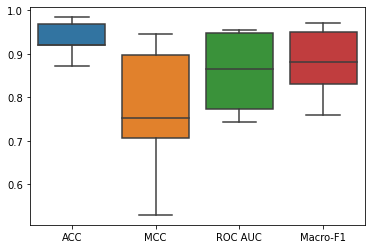

In [186]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.97,0.88,0.76,0.83,0.95]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [162]:
probability_before = clf.predict_proba(X)
probability_before = pd.DataFrame(probability_before)
probability_before.columns = ['Glob','Trans']
probability_before.index = gsp_features.index

MCC score :  0.8514161745365444
AUC :  0.913076923076923


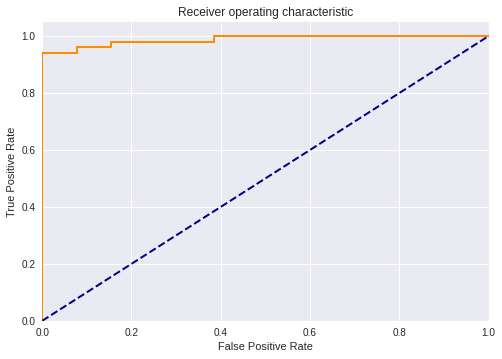

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)
print("MCC score : ",matthews_corrcoef(y_test, y_pred))

lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print("AUC : ",roc_auc_score(y_test, y_pred, multi_class='ovr'))
lw = 2
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [187]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))  


ACCURACY OF THE MODEL:  0.9047619047619048
              precision    recall  f1-score   support

        -1.0       0.86      0.55      0.67        11
         1.0       0.91      0.98      0.94        52

    accuracy                           0.90        63
   macro avg       0.88      0.76      0.81        63
weighted avg       0.90      0.90      0.90        63

AUCROC 0.7631118881118881

ACCURACY OF THE MODEL:  0.8412698412698413
              precision    recall  f1-score   support

        -1.0       0.54      0.64      0.58        11
         1.0       0.92      0.88      0.90        52

    accuracy                           0.84        63
   macro avg       0.73      0.76      0.74        63
weighted avg       0.85      0.84      0.85        63

AUCROC 0.7604895104895104

ACCURACY OF THE MODEL:  0.9365079365079365
              precision    recall  f1-score   support

        -1.0       0.93      0.82      0.87        17
         1.0       0.94      0.98      0.96        46

Accuracy: 0.91 (+/- 0.08)
MCC: 0.70 (+/- 0.28)
ROC AUC: 0.83 (+/- 0.12)
f1: 0.85 (+/- 0.14)


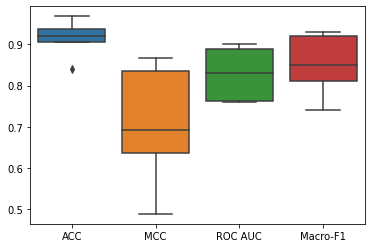

In [188]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.81,0.74,0.92,0.85,0.93]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = LogisticRegression()


scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))  

/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



ACCURACY OF THE MODEL:  0.9206349206349206
              precision    recall  f1-score   support

        -1.0       0.67      0.75      0.71         8
         1.0       0.96      0.95      0.95        55

    accuracy                           0.92        63
   macro avg       0.81      0.85      0.83        63
weighted avg       0.93      0.92      0.92        63

AUCROC 0.8477272727272727


/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



ACCURACY OF THE MODEL:  0.8888888888888888
              precision    recall  f1-score   support

        -1.0       0.71      0.50      0.59        10
         1.0       0.91      0.96      0.94        53

    accuracy                           0.89        63
   macro avg       0.81      0.73      0.76        63
weighted avg       0.88      0.89      0.88        63

AUCROC 0.7311320754716981


/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear


ACCURACY OF THE MODEL:  0.8888888888888888
              precision    recall  f1-score   support

        -1.0       0.73      0.67      0.70        12
         1.0       0.92      0.94      0.93        51

    accuracy                           0.89        63
   macro avg       0.83      0.80      0.81        63
weighted avg       0.89      0.89      0.89        63

AUCROC 0.803921568627451

ACCURACY OF THE MODEL:  0.873015873015873
              precision    recall  f1-score   support

        -1.0       0.73      0.62      0.67        13
         1.0       0.90      0.94      0.92        50

    accuracy                           0.87        63
   macro avg       0.82      0.78      0.79        63
weighted avg       0.87      0.87      0.87        63

AUCROC 0.7776923076923077

ACCURACY OF THE MODEL:  0.9047619047619048
              precision    recall  f1-score   support

        -1.0       0.64      0.90      0.75        10
         1.0       0.98      0.91      0.94        53



/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.90 (+/- 0.03)
MCC: 0.63 (+/- 0.12)
ROC AUC: 0.81 (+/- 0.12)
f1: 0.81 (+/- 0.06)


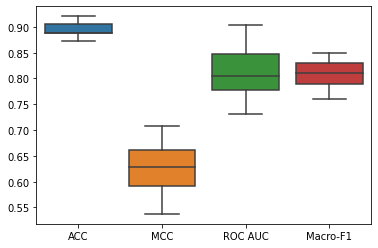

In [190]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.83,0.76,0.81,0.79,0.85]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [191]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = GaussianNB()


scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.8253968253968254
              precision    recall  f1-score   support

        -1.0       0.60      0.46      0.52        13
         1.0       0.87      0.92      0.89        50

    accuracy                           0.83        63
   macro avg       0.73      0.69      0.71        63
weighted avg       0.81      0.83      0.82        63

AUCROC 0.6907692307692308

ACCURACY OF THE MODEL:  0.7777777777777778
              precision    recall  f1-score   support

        -1.0       0.25      0.67      0.36         6
         1.0       0.96      0.79      0.87        57

    accuracy                           0.78        63
   macro avg       0.60      0.73      0.61        63
weighted avg       0.89      0.78      0.82        63

AUCROC 0.7280701754385965

ACCURACY OF THE MODEL:  0.8412698412698413
              precision    recall  f1-score   support

        -1.0       0.56      0.83      0.67        12
         1.0       0.96      0.84      0.90        51

Accuracy: 0.80 (+/- 0.10)
MCC: 0.45 (+/- 0.27)
ROC AUC: 0.75 (+/- 0.14)
f1: 0.71 (+/- 0.15)


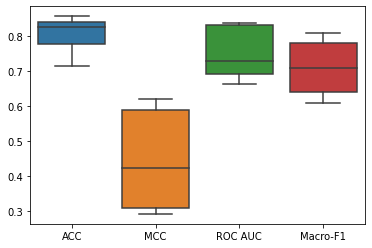

In [192]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.71,0.61,0.78,0.81,0.64]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [193]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf =  KNeighborsClassifier(n_neighbors=5)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.9047619047619048
              precision    recall  f1-score   support

        -1.0       0.78      0.64      0.70        11
         1.0       0.93      0.96      0.94        52

    accuracy                           0.90        63
   macro avg       0.85      0.80      0.82        63
weighted avg       0.90      0.90      0.90        63

AUCROC 0.798951048951049

ACCURACY OF THE MODEL:  0.9365079365079365
              precision    recall  f1-score   support

        -1.0       0.88      0.70      0.78        10
         1.0       0.95      0.98      0.96        53

    accuracy                           0.94        63
   macro avg       0.91      0.84      0.87        63
weighted avg       0.93      0.94      0.93        63

AUCROC 0.840566037735849

ACCURACY OF THE MODEL:  0.9047619047619048
              precision    recall  f1-score   support

        -1.0       0.83      0.71      0.77        14
         1.0       0.92      0.96      0.94        49



Accuracy: 0.91 (+/- 0.03)
MCC: 0.63 (+/- 0.23)
ROC AUC: 0.78 (+/- 0.13)
f1: 0.81 (+/- 0.12)


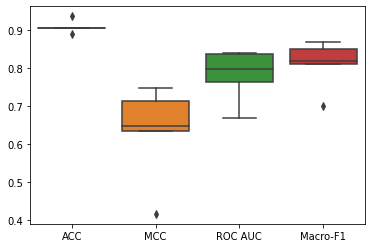

In [194]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.82,0.87,0.85,0.70,0.81]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [195]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = AdaBoostClassifier(n_estimators=1000, random_state=0)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.9523809523809523
              precision    recall  f1-score   support

        -1.0       0.92      0.85      0.88        13
         1.0       0.96      0.98      0.97        50

    accuracy                           0.95        63
   macro avg       0.94      0.91      0.93        63
weighted avg       0.95      0.95      0.95        63

AUCROC 0.913076923076923

ACCURACY OF THE MODEL:  0.9523809523809523
              precision    recall  f1-score   support

        -1.0       1.00      0.77      0.87        13
         1.0       0.94      1.00      0.97        50

    accuracy                           0.95        63
   macro avg       0.97      0.88      0.92        63
weighted avg       0.96      0.95      0.95        63

AUCROC 0.8846153846153846

ACCURACY OF THE MODEL:  0.9365079365079365
              precision    recall  f1-score   support

        -1.0       0.80      0.57      0.67         7
         1.0       0.95      0.98      0.96        56


Accuracy: 0.93 (+/- 0.04)
MCC: 0.78 (+/- 0.16)
ROC AUC: 0.85 (+/- 0.11)
f1: 0.88 (+/- 0.08)


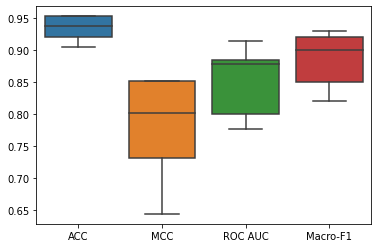

In [197]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.93,0.92,0.90,0.85,0.82]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [198]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0,max_depth=1, random_state=0)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.873015873015873
              precision    recall  f1-score   support

        -1.0       0.50      0.75      0.60         8
         1.0       0.96      0.89      0.92        55

    accuracy                           0.87        63
   macro avg       0.73      0.82      0.76        63
weighted avg       0.90      0.87      0.88        63

AUCROC 0.8204545454545454

ACCURACY OF THE MODEL:  0.9682539682539683
              precision    recall  f1-score   support

        -1.0       1.00      0.85      0.92        13
         1.0       0.96      1.00      0.98        50

    accuracy                           0.97        63
   macro avg       0.98      0.92      0.95        63
weighted avg       0.97      0.97      0.97        63

AUCROC 0.9230769230769231

ACCURACY OF THE MODEL:  0.9682539682539683
              precision    recall  f1-score   support

        -1.0       1.00      0.85      0.92        13
         1.0       0.96      1.00      0.98        50


Accuracy: 0.94 (+/- 0.07)
MCC: 0.78 (+/- 0.27)
ROC AUC: 0.88 (+/- 0.08)
f1: 0.89 (+/- 0.14)


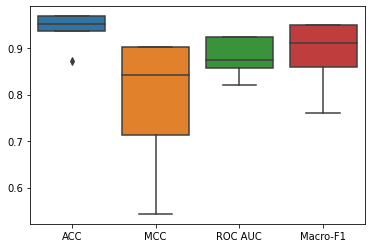

In [199]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.76,0.95,0.95,0.86,0.91]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

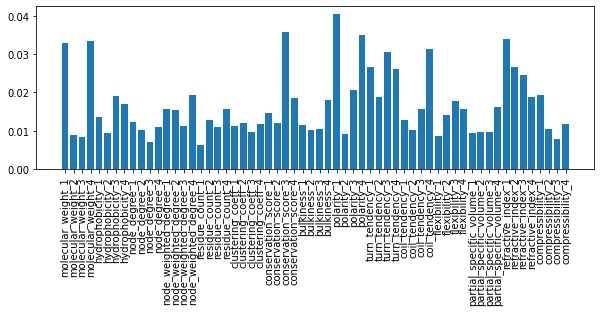

Accuracy: 0.95 (+/- 0.00)


In [14]:
# random forest for feature importance on a regression problem
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestClassifier(n_estimators=1000)
scores=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
    # fit the model
model.fit(X_train, y_train)
sc = model.score(X_test,y_test)
scores.append(sc)
#get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [40]:
final_data = pd.DataFrame(columns = ['Wavelet Scales','Feature Score','Feature Importance','Feature'])
# final_data.columns = ['Wavelet Scales','Feature Score','Feature Importance','Feature']
k=0
for i,j in zip(importance,signals_wavelet):
#     print(j.rpartition("_"))
    final_data.loc[k,'Wavelet Scales'] = j.rpartition("_")[2]
    final_data.loc[k,'Feature'] = j.rpartition("_")[0]
    final_data.loc[k,'Feature Score'] = i
    final_data.loc[k,'Feature Importance'] = i
    k=k+1

In [42]:
final_data.to_csv("./feature_importance_trans_glob.txt",sep="\t",index=False)

In [78]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']
imp_features = importance.argsort()[-20:][::-1]
# X = X.drop(np.array(signals_wavelet)[imp_features], axis=1)
X = X.iloc[:,imp_features]

# Correlation wavelet scales with biphysical proerties

In [97]:
pdbinfo_dict_trans = crawl_pdb('../Protein-GSP-master/data/transmembrane/')
pdbinfo_dict_glob = crawl_pdb('../Protein-GSP-master/data/globular/')

G_glob = {}
G_trans = {}

for pdb in pdbinfo_dict_glob.keys():
    try:
        G_glob[pdb] = get_graph(pdbinfo_dict_glob[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue
        
for pdb in pdbinfo_dict_trans.keys():
    try:
        G_trans[pdb] = get_graph(pdbinfo_dict_trans[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue 

gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in G_glob.keys():
    row = []
    c = -1
    G = G_glob[pdb]
    if pdbinfo_dict_glob[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_glob[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=50,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass


import random   
for pdb in G_trans.keys():
    row = []
    c = 1
    G = G_trans[pdb]
    if pdbinfo_dict_trans[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_trans[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=50,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass

X_all = gsp_features[gsp_features.columns.difference(['class'])]
y_all = gsp_features['class']

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9662.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9760.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9802.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9837.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9869.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4931.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4976.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5021.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5102.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5707.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5051.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5086.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5121.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5170.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5014.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5678.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5687.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6004.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6017.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5164.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2097.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2151.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9832.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9924.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10006.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7624.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7692.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7740.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7794.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6164.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9323.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9499.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9689.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9858.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10028.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7295.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element 'UNK' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7296.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7345.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7367.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9133.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9144.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9154.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9177.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9205.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6978.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6993.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7028.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7059.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7078.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12314.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12356.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12372.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12864.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6622.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structur

In [98]:
from scipy import stats
f_corr = pd.DataFrame()
for i in range(X_all.shape[1]):
    f_corr.loc[X_all.columns[i],'corr'] = stats.spearmanr(X_all.iloc[:,i],y_all)[0]

In [100]:
f_corr.to_csv("./correlation_transmembrane_globular.txt")

# Mutation replace at disease residues

In [78]:
pdbinfo_dict_trans = crawl_pdb('../Protein-GSP-master/data/transmembrane/')
pdbinfo_dict_glob = crawl_pdb('../Protein-GSP-master/data/globular/')

G_glob = {}
G_trans = {}

pdbinfo_dict_glob = mutation_find_replace(pdbinfo_dict_glob,residue_mutation,amino_lookup)
pdbinfo_dict_trans = mutation_find_replace(pdbinfo_dict_trans,residue_mutation,amino_lookup)

for pdb in pdbinfo_dict_glob.keys():
    try:
        G_glob[pdb] = get_graph(pdbinfo_dict_glob[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue
        
for pdb in pdbinfo_dict_trans.keys():
    try:
        G_trans[pdb] = get_graph(pdbinfo_dict_trans[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue 
    
lfc_cutoff = 0.59
model = 'weighted-rig'

gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in G_glob.keys():
    row = []
    c = -1
    G = G_glob[pdb]
    if pdbinfo_dict_glob[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_glob[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass


import random   
for pdb in G_trans.keys():
    row = []
    c = 1
    G = G_trans[pdb]
    if pdbinfo_dict_trans[pdb]['sequence'] != '':
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict_trans[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    else:
        pass

X_all = gsp_features[gsp_features.columns.difference(['class'])]
y_all = gsp_features['class']


/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9662.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9760.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9802.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9837.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9869.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

KeyboardInterrupt: 

In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20,random_state=109)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.9523809523809523
              precision    recall  f1-score   support

        -1.0       0.92      0.85      0.88        13
         1.0       0.96      0.98      0.97        50

    accuracy                           0.95        63
   macro avg       0.94      0.91      0.93        63
weighted avg       0.95      0.95      0.95        63



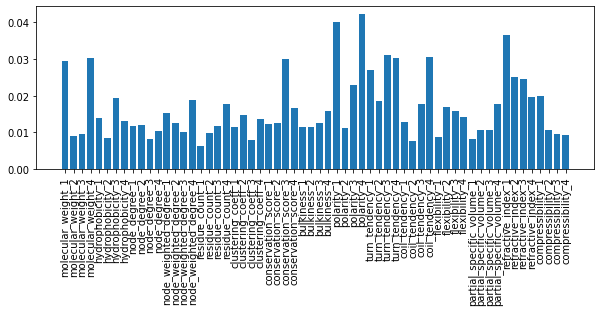

Accuracy: 0.47 (+/- 0.02)


In [281]:
#get importance
importance = clf.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X_all.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']
# X = X.drop(np.array(signals_wavelet)[imp_features], axis=1)
# X = X.iloc[:,imp_features]

In [52]:
# imp_features = importance.argsort()[:10][::-1]
# important_features = X_all.columns[imp_features]
important_features = X_all.columns
important_features = [x.rsplit("_",1)[0] for x in important_features]
important_features = np.unique(important_features)

In [287]:
important_features

array(['bulkiness', 'clustering_coeff', 'coil_tendency',
       'conservation_score', 'flexibility', 'partial_specific_volume',
       'polarity', 'refractive_index', 'turn_tendency'], dtype='<U23')

# ------------------------------------------------------------------------------------------

# Disease - Residue community 

In [47]:
disease_data = pd.read_csv("./protein_disease_residue_humsavar.txt",sep="\t")
protein_to_gene = pd.read_csv("./uniprot_protein_to_gene_trans_glob.tab",sep="\t")
protein_to_gene = protein_to_gene.loc[:,['yourlist:M20210315A94466D2655679D1FD8953E075198DA814D04CI','Gene names']]
protein_to_gene.columns = ['pdb','Gene']
b = pd.DataFrame(protein_to_gene.pdb.str.split(',').tolist(), index=protein_to_gene.Gene).stack()
b = b.reset_index()[[0, 'Gene']]
b.columns = ['pdb', 'Gene']
b = b.dropna()
b = b.reset_index()

In [48]:
gsp_features.index = [i.split('.')[0] for i in gsp_features.index]
gsp_features.index = [i.upper() for i in gsp_features.index]

In [49]:
residue_mutation = pd.DataFrame()
for i in np.unique(b['pdb']):
    gene = []
    indx = np.where(b['pdb'] == i)[0]
    for j in indx:
        gene.extend(b.loc[j,'Gene'].split(" "))
    for k in range(len(gene)):
        ind = np.where(disease_data.loc[:,'Main_gene_name'] == gene[k])[0]
        if len(ind)>0:
            ser = pd.Series(i, index =range(len(ind)))
            n_df = pd.concat([ser,disease_data.loc[ind,['AA_change','Disease name']].reset_index(drop=True)],axis=1)
            residue_mutation = residue_mutation.append(n_df)
residue_mutation['AA_change'] = residue_mutation['AA_change'].str.split(".",expand=True).loc[:,1]
residue_mutation = pd.concat([residue_mutation,residue_mutation['AA_change'].str.split('(\d+)([A-Za-z]+)', expand=True)],axis=1)
residue_mutation.to_csv("./trans_glob_residue_mutation.txt",sep="\t")

In [83]:
residue_mutation = pd.read_csv("./trans_glob_residue_mutation.txt",sep="\t")
residue_mutation.columns = ['index','pdb','AA_change','Disease name','Residue','Position','Mutate_to_residue','']
# z = pdbinfo_dict_glob.copy()   # start with x's keys and values
# z.update(pdbinfo_dict_trans) 
# res = mutation_find(z,residue_mutation,amino_lookup)

In [333]:
res.to_csv("./trans_glob_residue_neighbors.txt",sep="\t")

In [45]:
def mutation_find_replace(dictionary,residue_mutation,amino_lookup):
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]   
    for k in d1.keys():
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        mutation = residue_mutation.loc[indx,'Mutate_to_residue']
        mutation = [amino_lookup.get(key.upper()) for key in mutation]
        residues = [amino_lookup.get(key.upper()) for key in residues]
        seq = list(d1[k]['sequence'])
        for m,j in enumerate(residues):
            indices = [l for l,s in enumerate(d1[k]['sequence']) if j in s]
            for n,i in enumerate(d1[k]['sequence']):
                if n in indices:
                    seq[n] = mutation[m]
                else:
                    seq[n] = d1[k]['sequence'][n]
        seq1 = ''.join(seq)
        d1[k]['sequence'] = seq1
    return d1

In [117]:
from scipy import stats
import traceback
def get_filtered_signal_mutation(G, signal, cutoff,type_spatial, indices):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        signal_filtered_hat1 = np.zeros([1,signal_filtered_hat.shape[1]])
#         print(signal_filtered_hat1.shape)
        for j in range(signal_filtered_hat.shape[1]):
            p = np.percentile(signal_filtered_hat[:,j], cutoff) 
            signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
            b = [stats.percentileofscore(signal_filtered_hat[:,j], a, 'rank') for a in signal_filtered_hat[:,j]]
            signal_filtered_hat[:,j] = b
            signal_filtered_hat1[:,j] = signal_filtered_hat[indices,j] 
#         print(signal_filtered_hat1)
        signal_filtered_hat1 = np.mean(np.abs(signal_filtered_hat1))
        return signal_filtered_hat1
    
def mutation_find_wavelet_coefficient(dictionary,residue_mutation,amino_lookup,signal_important,cutoff,type_spatial):
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]  
    G = {}
    for pdb in d1.keys():
        try:
            G[pdb] = get_graph(d1[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
        except:
            continue  
    coeff_final = {}
    for k in d1.keys():
#         coeff_final[k] = {}
#         print(k)
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        residues = [amino_lookup.get(key.upper()) for key in residues]
        pos = np.array(residue_mutation.loc[indx,'Position'])
        dis = np.array(residue_mutation.loc[indx,'Disease name'])
        to_mutate = np.array(residue_mutation.loc[indx,'Mutate_to_residue'])
#         residues = np.unique(residues)
        G1 = G[k]
        for m,j in enumerate(residues):
#             print(j)
#             indices = [l for l,s in enumerate(d1[k]['sequence']) if j in s]
            indices = pos[m]
            try:
                if np.array(list(d1[k]['sequence']))[indices] == j: 
                    print("protein",k)
                    print("residue",j)
                    print("position",pos[m])
                    print("disease",dis[m])
                    print("to_mutate",to_mutate[m])
                    coeff_final[k,j,pos[m],dis[m]] = {}
                    for i in signal_important:
                        try:
                            coeff_final[k,j,pos[m],dis[m]][i] = {}
                            signal = get_signal(G1, d1[k]['sequence'],k,signal=i)
                            coeff1 = get_filtered_signal_mutation(G1, signal, cutoff, type_spatial, indices)
            #                 print(coeff1)
                            coeff_final[k,j,pos[m],dis[m]][i] = coeff1  
                        except:
                            if coeff_final[k,j,pos[m],dis[m]][i] == {}:
                                del coeff_final[k,j,pos[m],dis[m]][i] 
                if coeff_final[k,j,pos[m],dis[m]] == {}:
                            del coeff_final[k,j,pos[m],dis[m]]
            except:
                continue
    return coeff_final

In [132]:
def mutation_find_wavelet_coefficient_6YF5(dictionary,residue_mutation,amino_lookup,signal_important,cutoff,type_spatial):
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]  
    G = {}
    for pdb in d1.keys():
        try:
            G[pdb] = get_graph(d1[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
        except:
            continue  
    coeff_final = {}
    G1 = G['6YF5']
    if np.array(list(d1['6YF5']['sequence']))[23] == 'R': 
        coeff_final['6YF5','R','25'] = {}
        for i in signal_important:
            coeff_final['6YF5','R','25'][i] = {}
            signal = get_signal(G1, d1['6YF5']['sequence'],'6yf5',signal=i)
            coeff1 = get_filtered_signal_mutation(G1, signal, cutoff, type_spatial, [23])
            coeff_final['6YF5','R','25'][i] = coeff1  
    return coeff_final

In [88]:
pdbinfo_dict_6yf5['6yf5.pdb']['sequence']

'STPLSPTRITRLQEKEDLQELNDRLAVYIDRVRSLETENAGLRLRITESEEVVDFYFGKLRNIELICQENEGENDPVLQRIVDILYATD'

In [135]:
cutoff=70
type_spatial='wavelet'
res = mutation_find_wavelet_coefficient_6YF5(pdbinfo_dict_6yf5,residue_mutation,amino_lookup,signals,cutoff,type_spatial)

In [136]:
res

{('6YF5', 'R', '25'): {'molecular_weight': 86.51685393258427,
  'hydrophobicity': 58.426966292134836,
  'node_degree': 57.58426966292135,
  'node_weighted_degree': 55.617977528089895,
  'residue_count': 64.60674157303372,
  'clustering_coeff': 45.365168539325836,
  'conservation_score': 35.39325842696629,
  'bulkiness': 58.14606741573034,
  'polarity': 74.85955056179775,
  'turn_tendency': 35.39325842696629,
  'coil_tendency': 35.39325842696629,
  'flexibility': 88.20224719101124,
  'partial_specific_volume': 87.35955056179775,
  'refractive_index': 79.21348314606742,
  'compressibility': 50.140449438202246}}

In [59]:
cutoff=70
type_spatial='wavelet'
res = mutation_find_wavelet_coefficient(z,residue_mutation,amino_lookup,important_features,cutoff,type_spatial)

protein 1IFR
residue R
position 50
disease Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]
to_mutate Pro
protein 1IFR
residue R
position 50
disease Muscular dystrophy congenital LMNA-related (MDCL) [MIM:613205]
to_mutate Pro
protein 1IFR
residue R
position 50
disease Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]
to_mutate Ser
protein 1IVT
residue R
position 25
disease Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]
to_mutate Gly
protein 1IVT
residue R
position 25
disease Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]
to_mutate Pro
protein 4DOU
residue Y
position 111
disease -
to_mutate His
protein 4F3J
residue Q
position 44
disease -
to_mutate Arg
protein 4LWZ
residue A
position 143
disease Diarrhea 2, with microvillus atrophy (DIAR2) [MIM:251850]
to_mutate Glu
protein 4NN0
residue Q
position 44
disease -
to_mutate Arg
protein 1IRK
residue L
position 260
disease Leprec

protein 3H9H
residue Q
position 86
disease -
to_mutate Glu
protein 3H9H
residue Q
position 86
disease -
to_mutate Gly
protein 3H9H
residue Q
position 86
disease -
to_mutate Leu
protein 3H9H
residue Q
position 86
disease -
to_mutate Arg
protein 3H9H
residue D
position 101
disease -
to_mutate Asn
protein 3H9H
residue D
position 101
disease -
to_mutate Ser
protein 3H9H
residue R
position 169
disease -
to_mutate His
protein 3H9H
residue E
position 176
disease -
to_mutate Ala
protein 3H9H
residue E
position 176
disease -
to_mutate Arg
protein 3H9H
residue E
position 176
disease -
to_mutate Val
protein 3H9H
residue E
position 176
disease -
to_mutate Trp
protein 3H9S
residue Q
position 86
disease -
to_mutate Glu
protein 3H9S
residue Q
position 86
disease -
to_mutate Gly
protein 3H9S
residue Q
position 86
disease -
to_mutate Leu
protein 3H9S
residue Q
position 86
disease -
to_mutate Arg
protein 3H9S
residue D
position 101
disease -
to_mutate Asn
protein 3H9S
residue D
position 101
disease -
to

In [54]:
res

{('1IFR',
  'R',
  50,
  'Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]'): {'bulkiness': 62.389380530973455,
  'clustering_coeff': 35.39823008849557,
  'coil_tendency': 47.56637168141593,
  'compressibility': 47.78761061946903,
  'conservation_score': 56.415929203539825,
  'flexibility': 73.67256637168143,
  'hydrophobicity': 56.637168141592916,
  'molecular_weight': 66.59292035398231,
  'node_degree': 35.39823008849557,
  'node_weighted_degree': 35.39823008849557,
  'partial_specific_volume': 65.26548672566372,
  'polarity': 71.90265486725663,
  'refractive_index': 64.38053097345133,
  'residue_count': 44.469026548672566,
  'turn_tendency': 44.690265486725664},
 ('1IFR',
  'R',
  50,
  'Muscular dystrophy congenital LMNA-related (MDCL) [MIM:613205]'): {'bulkiness': 62.389380530973455,
  'clustering_coeff': 35.39823008849557,
  'coil_tendency': 47.56637168141593,
  'compressibility': 47.78761061946903,
  'conservation_score': 56.415929203539825,
  'flexib

In [55]:
pd.DataFrame(res).to_csv("./trans_glob_mutation_all_features.txt",sep="\t")

In [167]:
from sklearn.neighbors import NearestNeighbors
def get_key(val,my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
def mutation_find(dictionary,residue_mutation,amino_lookup):
    final_neighbors = pd.DataFrame()
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]   
    for k in d1.keys():
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        residues = np.unique([amino_lookup.get(key.upper()) for key in residues])
        for j in residues:
            indices = [m for m,s in enumerate(d1[k]['sequence']) if j in s]
            nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(d1[k]['distance_matrix'])
            distances, indic = nbrs.kneighbors(d1[k]['distance_matrix'])
            ind_find_residue = indic[np.where(np.isin(indic, indices))[0],:]   
            neighbors = np.unique([s for m,s in enumerate(d1[k]['sequence']) if m in np.ravel(ind_find_residue)])
            neighbors = [get_key(m,amino_lookup) for m in neighbors]
            new_row = pd.DataFrame([k,get_key(j,amino_lookup),neighbors]).T
            final_neighbors = final_neighbors.append(new_row)
    return final_neighbors

# -----------------------------------------------------------------------------------------------------

# difference in prob of class after mutation

In [67]:
from scipy import stats
import traceback

def mutation_find_replace_diff(seq,mutation_site,mutate_to):
    s2 = list(seq)
    for i in range(len(s2)):
        if i==mutation_site:
            s2[i] = mutate_to
    seq1 = ''.join(s2)
    return seq1

def get_filtered_signal_mutation_diff(G, signal,type_spatial, cutoff=10):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                p = np.percentile(signal_filtered_hat[:,j], cutoff) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        signal_filtered_hat = np.mean(signal_filtered_hat,axis=0)
        return signal_filtered_hat
    
def mutation_find_wavelet_coefficient_diff(dictionary,residue_mutation,amino_lookup,cutoff,type_spatial,network_type,gsp_features,model,signals,probability_before):
    residue_mutation['pdb'] = [x.upper() for x in residue_mutation['pdb']]
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]  
    G = {}
    for pdb in d1.keys():
        try:
            G[pdb] = get_graph(d1[pdb]['distance_matrix'], network_type=network_type, rig_cutoff=7.3)
        except:
            continue  
    for k in d1.keys():
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        pos = np.array(residue_mutation.loc[indx,'Position'])
        dis = np.array(residue_mutation.loc[indx,'Disease name'])
        residues = [amino_lookup.get(key.upper()) for key in residues]
        to_mutate = np.array(residue_mutation.loc[indx,'Mutate_to_residue'])
        G1 = G[k]
        for m,j in enumerate(residues):
            indices = pos[m]
            try:
                if np.array(list(d1[k]['sequence']))[indices] == j: 
                    print("protein",k)
                    print("residue",j)
                    print("position",pos[m])
                    print("disease",dis[m])
                    print("to_mutate",to_mutate[m])
                    print("Class belongs to",gsp_features.loc[k,'class'])
                    print("Prob before Mutation to trans",probability_before.loc[k,'Trans'])
                    print("Prob before Mutation to glob",probability_before.loc[k,'Glob'])
                    seq_after_mutation = mutation_find_replace_diff(d1[k]['sequence'],pos[m],amino_lookup.get(to_mutate[m].upper()))
                    row = []
                    row1 = []
                    for i in signals:
                        signal = get_signal(G1, seq_after_mutation,k,signal=i)
                        coeff1 = get_filtered_signal_mutation_diff(G1, signal, type_spatial)
                        row.extend(coeff1)
                        row1.extend(coeff1)
                    row.extend([gsp_features.loc[k,'class']])
                    gsp_features.loc[k] = row    
                    model = RandomForestClassifier(n_estimators=1000)
                    X = gsp_features[gsp_features.columns.difference(['class'])]
                    y = gsp_features['class']
                    model.fit(X, y)
                    print("Prob after mutation :",model.predict_proba(np.array(row1).reshape(1, -1)))
            except:
#                 traceback.print_exc()
                pass
#     return coeff_final

In [168]:
new_ind = []
for i in range(len(gsp_features.index)):
        i1 = gsp_features.index[i].split('.')[0]
        i1 = i1.upper()
        new_ind.append(i1)
gsp_features.index = new_ind

In [169]:
new_ind = []
for i in range(len(probability_before.index)):
        i1 = probability_before.index[i].split('.')[0]
        i1 = i1.upper()
        new_ind.append(i1)
probability_before.index = new_ind

In [31]:
def merge_two_dicts(x, y):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

In [34]:
pdbinfo_dict = merge_two_dicts(pdbinfo_dict_trans, pdbinfo_dict_glob)

0 -> Glob
1 -> Trans

In [175]:
def mutation_find_wavelet_coefficient_diff(dictionary,residue_mutation,amino_lookup,cutoff,type_spatial,network_type,gsp_features,model,signals,probability_before):
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i] 
#     print(d1)
    G = {}
    for pdb in d1.keys():
        try:
            G[pdb] = get_graph(d1[pdb]['distance_matrix'], network_type=network_type, rig_cutoff=7.3)
        except:
            continue  
    G1 = G['6YF5']
    if np.array(list(d1['6YF5']['sequence']))[7] == 'R': 
        print("Class belongs to",gsp_features.loc['6YF5','class'])
        print("Prob before Mutation to trans",probability_before.loc['6YF5','Trans'])
        print("Prob before Mutation to glob",probability_before.loc['6YF5','Glob'])
        seq_after_mutation = mutation_find_replace_diff(d1['6YF5']['sequence'],[7],amino_lookup.get('Pro'.upper()))
        row = []
        row1 = []
        for i in signals:
            signal = get_signal(G1, seq_after_mutation,'6YF5',signal=i)
            coeff1 = get_filtered_signal_mutation_diff(G1, signal, type_spatial)
            row.extend(coeff1)
            row1.extend(coeff1)
        row.extend([gsp_features.loc['6YF5','class']])
        gsp_features.loc['6YF5'] = row    
        model = RandomForestClassifier(n_estimators=1000)
        X = gsp_features[gsp_features.columns.difference(['class'])]
        y = gsp_features['class']
        model.fit(X, y)
        print("Prob after mutation :",model.predict_proba(np.array(row1).reshape(1, -1)))
#     return coeff_final

cutoff=70
type_spatial='wavelet'
network_type = 'weighted-rig'
# residue_mutation = pd.read_csv("./protein_folding_rate_residue_mutation.txt",sep="\t")
# residue_mutation.columns = ['index','pdb','AA_change','Disease name','Residue','Position','Mutate_to_residue',''] 
final_dict = mutation_find_wavelet_coefficient_diff(pdbinfo_dict_6yf5,residue_mutation,amino_lookup,cutoff,type_spatial,network_type,gsp_features,clf,signals,probability_before)

Class belongs to -1.0
Prob before Mutation to trans 0.283
Prob before Mutation to glob 0.717
Prob after mutation : [[0.603 0.397]]


In [68]:
cutoff=70
type_spatial='wavelet'
network_type = 'weighted-rig'
# residue_mutation = pd.read_csv("./protein_folding_rate_residue_mutation.txt",sep="\t")
# residue_mutation.columns = ['index','pdb','AA_change','Disease name','Residue','Position','Mutate_to_residue',''] 
final_dict = mutation_find_wavelet_coefficient_diff(pdbinfo_dict,residue_mutation,amino_lookup,cutoff,type_spatial,network_type,gsp_features,clf,signals,probability_before)

protein 1IRK
residue L
position 260
disease Leprechaunism (LEPRCH) [MIM:246200]
to_mutate Pro
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.597 0.403]]
protein 1IRK
residue R
position 256
disease Rabson-Mendenhall syndrome (RMS) [MIM:262190]
to_mutate Cys
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.61 0.39]]
protein 1LZ0
residue G
position 35
disease -
to_mutate Arg
Class belongs to 1.0
Prob before Mutation to trans 0.998
Prob before Mutation to glob 0.002
Prob after mutation : [[0.593 0.407]]
protein 1LZ0
residue R
position 198
disease -
to_mutate Trp
Class belongs to 1.0
Prob before Mutation to trans 0.998
Prob before Mutation to glob 0.002
Prob after mutation : [[0.625 0.375]]
protein 1LZ0
residue P
position 234
disease -
to_mutate Ala
Class belongs to 1.0
Prob before Mutation to trans 0.998
Prob before Mutation to glob 0.002
Prob after mu

Prob after mutation : [[0.588 0.412]]
protein 2RJ5
residue L
position 266
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.608 0.392]]
protein 2RJ5
residue P
position 257
disease -
to_mutate Leu
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.61 0.39]]
protein 2RJ7
residue L
position 266
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.602 0.398]]
protein 2RJ7
residue G
position 268
disease -
to_mutate Ala
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.607 0.393]]
protein 2RJ7
residue G
position 268
disease -
to_mutate Arg
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.625 0.375]]
protein 2RJ7
r

Prob after mutation : [[0.606 0.394]]
protein 3DPK
residue A
position 245
disease -
to_mutate Ser
Class belongs to 1.0
Prob before Mutation to trans 0.819
Prob before Mutation to glob 0.181
Prob after mutation : [[0.6 0.4]]
protein 3DZQ
residue K
position 207
disease A pancreatic ductal adenocarcinoma sample
to_mutate Asn
Class belongs to 1.0
Prob before Mutation to trans 0.867
Prob before Mutation to glob 0.133
Prob after mutation : [[0.581 0.419]]
protein 3EKN
residue L
position 89
disease Insulin-resistant diabetes mellitus with acanthosis nigricans type A (IRAN type A) [MIM:610549]
to_mutate Pro
Class belongs to 1.0
Prob before Mutation to trans 1.0
Prob before Mutation to glob 0.0
Prob after mutation : [[0.603 0.397]]
protein 3EKN
residue R
position 256
disease Rabson-Mendenhall syndrome (RMS) [MIM:262190]
to_mutate Cys
Class belongs to 1.0
Prob before Mutation to trans 1.0
Prob before Mutation to glob 0.0
Prob after mutation : [[0.603 0.397]]
protein 3GQI
residue Y
position 99
di

Prob after mutation : [[0.575 0.425]]
protein 3IOH
residue G
position 268
disease -
to_mutate Ala
Class belongs to 1.0
Prob before Mutation to trans 0.97
Prob before Mutation to glob 0.03
Prob after mutation : [[0.581 0.419]]
protein 3IOH
residue G
position 35
disease -
to_mutate Arg
Class belongs to 1.0
Prob before Mutation to trans 0.97
Prob before Mutation to glob 0.03
Prob after mutation : [[0.583 0.417]]
protein 3IOH
residue G
position 268
disease -
to_mutate Arg
Class belongs to 1.0
Prob before Mutation to trans 0.97
Prob before Mutation to glob 0.03
Prob after mutation : [[0.571 0.429]]
protein 3IOH
residue T
position 163
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.97
Prob before Mutation to glob 0.03
Prob after mutation : [[0.562 0.438]]
protein 3IOI
residue R
position 176
disease -
to_mutate Gly
Class belongs to 1.0
Prob before Mutation to trans 0.994
Prob before Mutation to glob 0.006
Prob after mutation : [[0.572 0.428]]
protein 3IOI
residue 

Prob after mutation : [[0.546 0.454]]
protein 3V0P
residue L
position 266
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.553 0.447]]
protein 3V0P
residue V
position 277
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.559 0.441]]
protein 3V0P
residue P
position 257
disease -
to_mutate Leu
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.552 0.448]]
protein 3V0Q
residue L
position 266
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.519 0.481]]
protein 3V0Q
residue V
position 277
disease -
to_mutate Met
Class belongs to 1.0
Prob before Mutation to trans 0.999
Prob before Mutation to glob 0.001
Prob after mutation : [[0.561 0.439]]
protein 3V0Q

# ----------------------------------------------------------------------------------------------------------

In [80]:
# random forest for feature importance on a regression problem
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.01)


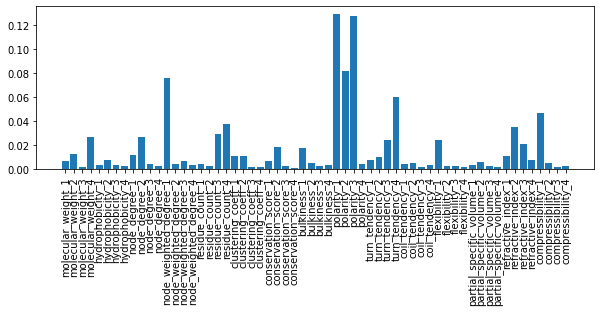

Accuracy: 0.73 (+/- 0.02)


In [487]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# --------------------------------------------TILL HERE----------------------------------------------

# alpha-beta

In [262]:
def crawl_pdb_alphabeta(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path + '' + pdb + '/' + pdb.split('_')[1].upper()+'.pdb' ) # + '/' + pdb + '.pdb'
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        assert residue.get_resname() not in ['HOH', ' CA']
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())

                    except :
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
        info['sequence'] = ''.join([amino_lookup[s] for s in labels])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


In [263]:
path = '../Protein-GSP-master/data/SDTSF_RIG_LIN/'
pdbinfo_dict = crawl_pdb_alphabeta(path)

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1H) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CH3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstruc

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element 'Q' for Atom (name=QD1) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element 'Q' for Atom (name=QD2) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element 'Q' for Atom (name=QQD) with given element '12'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '13'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with g

In [30]:
pdbinfo_dict.keys()

NameError: name 'pdbinfo_dict' is not defined

In [13]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#         print (pdb, end=', ')
    row = []
    if pdb.startswith('A_'): c = 1
    elif pdb.startswith('B_'): c = -1
    else: c = 0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

1.0


In [23]:
gsp_features = gsp_features.drop(gsp_features.index[[0,1,2,3,4,5,6,7,8,9,10,11]])

In [24]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65,random_state=9)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.6666666666666666
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         8
         1.0       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [445]:
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot
# # define the model
# model = RandomForestRegressor()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()
model.score(X,y)

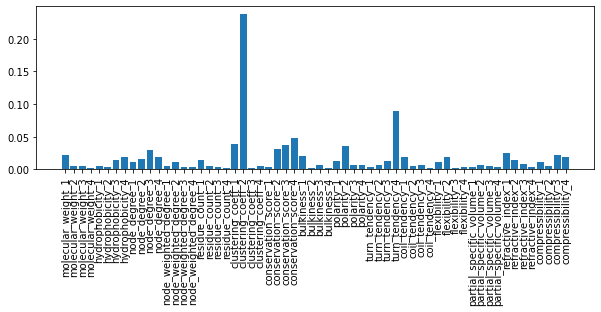

Accuracy: 0.78
0.02432220195007022


In [491]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f" % (scores.mean()))
print(scores.std())

# Protein folding rate using gsp features

In [265]:
def crawl_pdb_folding(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb +"/pdb"+ pdb.lower() +".ent" )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
#         print(np.unique(labels))
        info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
#         print(info['sequence'])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict

In [266]:
import pickle as pk 
def crawl_pdb_allproteins(path):
    '''This funciton reads pdb files and stores their distance matrix and sequence''' 
    path1 = path
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb           
        info['distance_matrix'] = pd.read_csv(path1 + pdb + '/distance_matrix.csv', header=None).values
        info['sequence'] = pk.load(open(path1 + pdb + '/sequence.p', 'rb'))
        str1 = ''.join(info['sequence'])
        info['sequence']= str1
        pdbinfo_dict[pdb.upper()] = info
#     print(count)
    return pdbinfo_dict

In [267]:
path = '../Protein-GSP-master/data/regression_model/test_pdb/'
pdbinfo_dict_1 = crawl_pdb_folding(path)

path = '../Protein-GSP-master/data/regression_model/new_pdb/'
pdbinfo_dict_2 = crawl_pdb_allproteins(path)

pdbinfo_dict = pdbinfo_dict_1.copy()   # start with x's keys and values
pdbinfo_dict.update(pdbinfo_dict_2) 

df = pd.read_csv('../Protein-GSP-master/data/regression_model/final_lnkf.csv', index_col=0)
lnkfs = df['Ln.K_f.']
lnkfs = lnkfs[~lnkfs.index.duplicated(keep='first')]

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2248.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2249.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2250.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2278.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4219.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4675.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4782.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4836.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4986.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1470.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

In [157]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#     print(pdb)
    row = []
    c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')    
#             print(value)
            row.extend(value)
        row.append(c)
#         print(row)
        gsp_features.loc[pdb] = row

# gsp_features.dropna()
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.6808724669396427


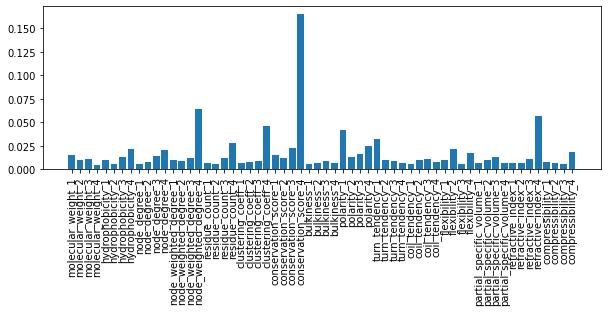

Accuracy: 0.47 (+/- 0.02)


In [158]:
# Cutoff=10
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Remove  Conservation Score

In [152]:
signals_wavelet_nonconservation = []
signals_nonconservation = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility']
for i in signals_nonconservation:
    for j in range(1,5):
        signals_wavelet_nonconservation.append(i+"_"+str(j))

In [153]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet_nonconservation + ['class'])

for pdb in pdbinfo_dict.keys():
#     print(pdb)
    row = []
    c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals_nonconservation:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')    
#             print(value)
            row.extend(value)
        row.append(c)
#         print(row)
        gsp_features.loc[pdb] = row

# gsp_features.dropna()
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.6564545001648427


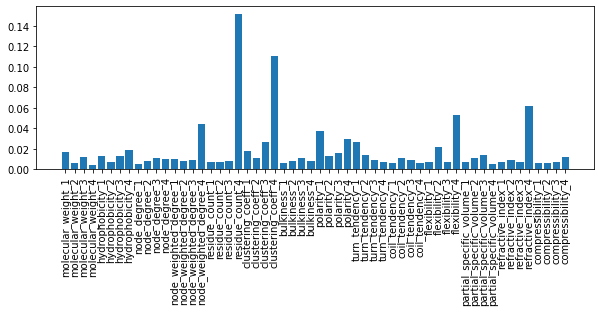

Accuracy: 0.40 (+/- 0.01)


In [156]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet_nonconservation, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Graph Fourier

In [150]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals + ['class'])

for pdb in pdbinfo_dict.keys():
#     print(pdb)
    row = []
    c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=0.42,type_spatial='fourier') 
            row.append(value)
        row.append(c)
#         print(row)
        gsp_features.loc[pdb] = row

# gsp_features.dropna()
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.46740637410304975


In [151]:
# Cutoff=10
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

# f, ax = plt.subplots(figsize=(10,3))
# importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.17 (+/- 0.01)


In [87]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X, y)
reg.score(X, y)

0.3807465970946845

# ------------------------------------------------------------------------------------------------

# AROMATICITY PREDICTION

In [502]:
import pickle as pk 
def crawl_pdb_allproteins(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
#         print (pdb)
        info = dict()
        info[id] = pdb       
        info['distance_matrix'] = pd.read_csv(path + pdb + '/distance_matrix.csv', header=None).values
        info['sequence'] = pk.load(open(path + pdb + '/sequence.p', 'rb'))
        str1 = ''.join(info['sequence'])
        info['sequence']= str1
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict

In [503]:
path = '../Protein-GSP-master/data/regression_model/new_pdb/'
pdbinfo_dict = crawl_pdb_allproteins(path)

In [504]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
def aromaticity(seq):
    X =  ProteinAnalysis(seq)
    aroma = X.aromaticity()
    return aroma

def isoelectric_point(seq):
    X =  ProteinAnalysis(seq)
    isoelectric_point = X.isoelectric_point()
    return isoelectric_point

def instability_index(seq):
    X =  ProteinAnalysis(seq)
    instability_index = X.instability_index()
    return instability_index

def gravy(seq):
    X =  ProteinAnalysis(seq)
    gravy = X.gravy()
    return gravy

def charge(seq):
    X =  ProteinAnalysis(seq)
    charge_at_pH = X.charge_at_pH()
    return charge_at_pH

def molar_extinction_coefficient(seq):
    X =  ProteinAnalysis(seq)
    molar_extinction_coefficient = X.molar_extinction_coefficient()
    return molar_extinction_coefficient

In [751]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0] == 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=50,type_spatial='wavelet')       
            row.extend(value)
        c=aromaticity(pdbinfo_dict[pdb]['sequence'])
        row.append(c)
        gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

1.0


In [459]:
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot
# # define the model
# model = RandomForestRegressor()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()
#model.score(X,y)

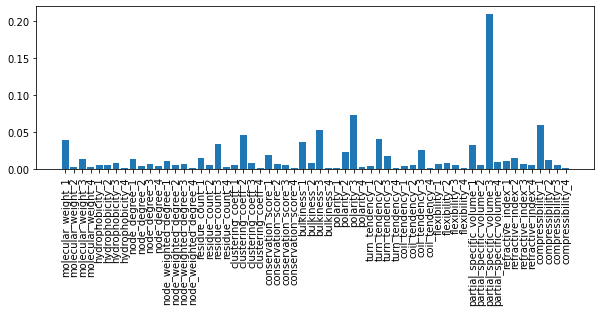

Accuracy: 0.45 (+/- 0.04)


In [755]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [758]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X_train, y_train)
reg.score(X_test, y_test)

0.799581539325241

# isoelectric point

In [ ]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    if pdbinfo_dict[pdb]['distance_matrix'].shape[0]== 1:
        pass
    else:
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
            row.extend(value)
        c= isoelectric_point(pdbinfo_dict[pdb]['sequence'])
        row.append(c)
        gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

In [469]:
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot
# # define the model
# model = RandomForestRegressor()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()
# model.score(X,y)

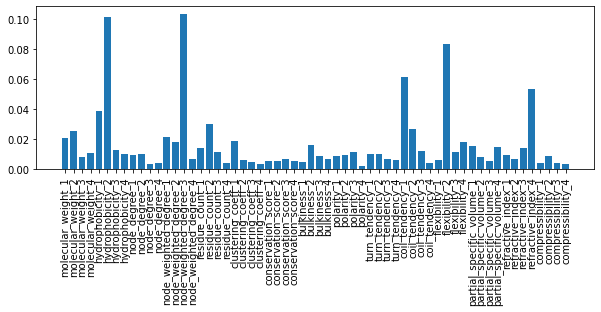

Accuracy: 0.85 (+/- 0.03)


In [777]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators = 1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [778]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X_train, y_train)
reg.score(X_test, y_test)

/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05078779923510268, tolerance: 0.01804769778125952
  positive)


0.7841651619890172

# instability index

In [773]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
    row = []
#     c = lnkfs[pdb.upper()]
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=50,type_spatial='wavelet')       
        row.extend(value)
    c= instability_index(pdbinfo_dict[pdb]['sequence'])
    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

1.0


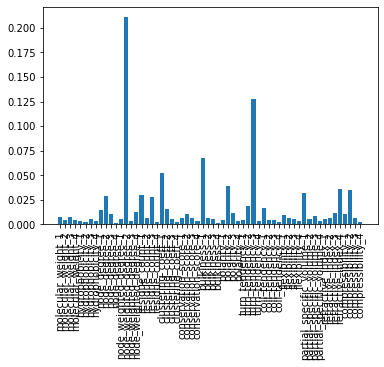

Accuracy: 0.54 (+/- 0.02)


In [774]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators = 1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [775]:
#cutoff=70
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=0,max_iter=10000).fit(X_train, y_train)
reg.score(X_test, y_test)

0.5545888118219156

# correlation protein folding rate

In [359]:
import pickle

def get_filtered_signal_inverse(G, signal,cutoff):
    N_f=4
    scales = utils.compute_log_scales(1, len(signal), N_f-1)
    mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
    signal_filtered_hat = mex.filter(signal)
    signal_filtered_hat = np.abs(signal_filtered_hat)
    for j in range(signal_filtered_hat.shape[1]):
        p = np.percentile(signal_filtered_hat[:,j], cutoff) 
        signal_filtered_hat[np.where(signal_filtered_hat[:,j]<cutoff),j] = 0
    inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
    value = np.mean(np.abs(inv_fil))
    return value

In [540]:
folders = sorted(os.listdir('../Protein-GSP-master/data/regression_model/new_pdb/'))

distance_cutoff = 7.3
G_dict = dict()
NX_dict = dict()

lfc_cutoffs = np.arange(10,80,10)
points = np.zeros_like(lfc_cutoffs)

for index, folder in enumerate(folders):
#     print(folder)
    n = np.asmatrix(np.loadtxt('../Protein-GSP-master/data/regression_model/new_pdb/' + folder + '/distance_matrix.csv', delimiter=','))
    n[n >= distance_cutoff] = 0

    # taking |j-i| as weights
    for i in range(np.shape(n)[0]):
        for j in range(np.shape(n)[1]):
            if n[i,j] > 0:
                n[i,j] = abs(j-i)
    
    G = graphs.Graph(n)
    G.compute_fourier_basis()
    
    G_dict[folder] = G
    NX_dict[folder] = nx.Graph(n)
    
for p, lfc_cutoff in enumerate(lfc_cutoffs):   
    lfc = np.zeros(len(folders))
    lnkf = np.zeros(len(folders))

    for index, folder in enumerate(folders):
        print(folder)
        G = G_dict[folder]
        sequence = pickle.load(open('../Protein-GSP-master/data/regression_model/new_pdb/' + folder + '/sequence.p','rb'))
        str1 = ''.join(sequence)
        sequence = str1
        signal = get_signal(G, sequence,folder,signal=signal_name)
        NX = NX_dict[folder]
        signal = np.array(signal)
        value = get_filtered_signal_inverse(G, signal,p)
        lfc[index] = value
        lnkf[index] = nx.average_clustering(NX)
        print(lnkf[index])
    points[p] = np.corrcoef(lfc, lnkf)[0,1]
    #print(np.corrcoef(lfc, lnkf)[0,1])
    
    #print(np.max(points))
    #print(lfc_cutoffs[np.argmax(points)])

1aey
-0.5216840686427859
1aps
-0.5969308761811631
1aye
-0.6174840510145888
1bdd
-0.4992011307228968
1brs
-0.5881290663571502
1c8c
-0.4875282255203563
1c9o
-0.565821726526094
1cis
-0.5680955633212474
1coa
-0.5640016361375753
1csp
-0.5589777201967187
1div
-0.5178520114713593
1ebd
-0.6186875131717914
1enh
-0.4521405066046404
1fkb
-0.5654251888218748
1g6p
-0.5434362553947681
1hdn
-0.5795482604909699
1hrc
-0.5700150841287072
1hz6
-0.515770014914869
1imq
-0.5445524345205653
1lmb
-0.4671235152656964
1lop
-0.6136383530570244
1mjc
-0.5673829440403159
1nyf
-0.5481041529257931
1pba
-0.541931087894635
1pca
-0.6189532765286664
1pgb
-0.48633708010972343
1pin
-0.6004577559614106
1pks
-0.570258860621319
1pnj
-0.5689749880439726
1poh
-0.585014346319509
1ris
-0.5335937606178325
1shf
-0.5516649491387834
1shg
-0.5463731843735987
1srl
-0.5801361844212983
1ten
-0.5973977454240607
1tit
-0.6134521545844699
1ubq
-0.5075134046704048
1urn
-0.5499209840259136
1vii
-0.42349138364879957
1vik
-0.5600884770018159
1wi

-0.541931087894635
1pca
-0.6189532765286664
1pgb
-0.48633708010972343
1pin
-0.6004577559614106
1pks
-0.570258860621319
1pnj
-0.5689749880439726
1poh
-0.585014346319509
1ris
-0.5335937606178325
1shf
-0.5516649491387834
1shg
-0.5463731843735987
1srl
-0.5801361844212983
1ten
-0.5973977454240607
1tit
-0.6134521545844699
1ubq
-0.5075134046704048
1urn
-0.5499209840259136
1vii
-0.42349138364879957
1vik
-0.5600884770018159
1wit
-0.6000708892208202
1ycc
-0.5747082260758892
256b
-0.5428950780376021
2abd
-0.5441228325292135
2acy
-0.5767351932140028
2ait
-0.5614595822720903
2ci2
-0.5659962998069298
2hqi
-0.5878910104502667
2pdd
-0.4634064246731204
2ptl
-0.5314838586144134
2vik
-0.5567583069806542
3mef
-0.5437130456521081


In [ ]:
distance_cutoff = 7.3
n = distance_matrix
n[n >= distance_cutoff] = 0
NX_graph = nx.Graph(n)
lnkf = nx.average_clustering(NX_graph) 

In [533]:
lnkf

array([0.59352018, 0.55049859, 0.53929958, 0.60701539, 0.55536537,
       0.61414254, 0.5678933 , 0.56660347, 0.56892786, 0.5717933 ,
       0.59579894, 0.53865095, 0.63626476, 0.56811854, 0.58074922,
       0.56015135, 0.56551691, 0.59704069, 0.58010136, 0.62680267,
       0.54137756, 0.56700739, 0.57804466, 0.581624  , 0.53850781,
       0.61487451, 0.54856047, 0.56537907, 0.56610541, 0.55709787,
       0.58649346, 0.57599002, 0.5790461 , 0.55982212, 0.55024164,
       0.54147837, 0.60199063, 0.5769954 , 0.65475682, 0.57115853,
       0.54877273, 0.56286908, 0.58106359, 0.58035062, 0.56172931,
       0.57037595, 0.56779417, 0.55549759, 0.62913688, 0.58773221,
       0.57306375, 0.58058849])